# Test The Kernel of Delight to see how it works

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June  18th 2021
- Update June 23th 2021 : Covariance Matrix with redshifts
- update July 14th 2021 : Simple plots for LOR
- last update September 11th 2021 : Covariance matrix with filters


- **kernel : anaconda3pbs** @ CC

- Last verification Sunday 9th 2022




- Under developmment, to produce instructive plots

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
from matplotlib.colors import LogNorm

In [3]:
#from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [4]:
import logging
import coloredlogs

In [5]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [6]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [7]:
%matplotlib inline

# Configuration

- select if want to control Delight internal simulation or DC2

In [8]:
FLAG_DC2=True

In [9]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [10]:
params = parseParamFile(configfilename, verbose=False)


#comm = MPI.COMM_WORLD
threadNum = 0
numThreads = 1


if threadNum == 0:
    logger.info("--- DELIGHT-LEARN ---")


2022-01-12 14:17:21,580 ipykernel_launcher.py, __main__[3452] INFO --- DELIGHT-LEARN ---


In [11]:
# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
sed_names = params['templates_names']
f_mod = readSEDs(params)

In [12]:
band_name=["u","g","r","i","z","y"]
the_coloredmaps=["Blues","Greens","Reds","Oranges","Greys","Purples"]

In [13]:
numBands

6

In [14]:
all_renormmodel=[]
all_fluxes=[]

# Learn

In [15]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

msg= 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)


firstLine = int(threadNum * numObjectsTraining / numThreads)
lastLine = int(min(numObjectsTraining,(threadNum + 1) * numObjectsTraining / numThreads))
numLines = lastLine - firstLine

    
msg ='Thread ' +  str(threadNum) + ' , analyzes lines ' + str(firstLine) + ' , to ' + str(lastLine)
logger.info(msg)

DL = approx_DL()


/tmp/ipykernel_3452/1585406643.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
2022-01-12 14:17:21,856 ipykernel_launcher.py, __main__[3452] INFO Number of Training Objects 3755
2022-01-12 14:17:21,859 ipykernel_launcher.py, __main__[3452] INFO Thread 0 , analyzes lines 0 , to 3755


## Templates Model

In [16]:
f_mod.shape

(8, 6)

# Gaussian Processes

In [17]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

### Parameters

In [18]:
lines_pos=params['lines_pos']
lines_pos

[6500.0, 5002.26, 3732.22]

In [19]:
lines_width=params['lines_width']
lines_width

[20.0, 20.0, 20.0, 20.0]

In [20]:
V_C=params['V_C']
V_C

0.1

In [21]:
V_L=params['V_L']
V_L

0.1

In [22]:
alpha_C=params['alpha_C']
alpha_C

1000.0

In [23]:
alpha_L=params['alpha_L']
alpha_L

100.0

### Redshift grid

Text(0.5, 1.0, 'Redshift grids')

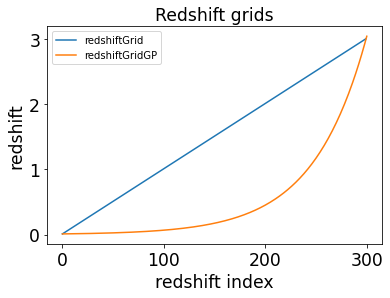

In [24]:
plt.plot(redshiftGrid,label="redshiftGrid")
plt.plot(redshiftGridGP,label="redshiftGridGP")
plt.xlabel("redshift index")
plt.ylabel("redshift")
plt.legend()
plt.title("Redshift grids")

# GP Average function

In [25]:
gp.mean_fct?

In [26]:
X=np.zeros((numBands,3))
X[:,0]=np.arange(numBands)
X[:,1]=1.5
X[:,2]=1.0

In [27]:
gp.mean_fct.f(X).shape

(6, 8)

In [28]:
NBINS=20

## Make all X by varying z

In [29]:
all_F=[]
all_z=[]
all_X=[]
for z in np.linspace(0.1,3,NBINS):
    X=np.zeros((numBands,3))
    X[:,0]=np.arange(numBands)
    X[:,1]=z
    X[:,2]=1.0
    Fluxes=gp.mean_fct.f(X)
    all_F.append(Fluxes)
    all_z.append(z)
    all_X.append(X)
    

In [30]:
all_X[0].shape

(6, 3)

## Plotting

In [31]:
NR=2  
NC=3   
NT=8

### Select band and template

In [32]:
ib=1 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

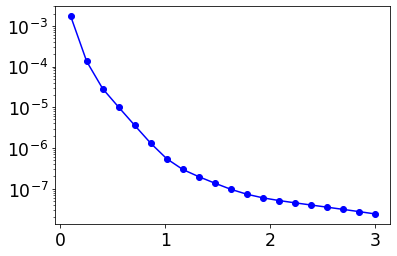

In [33]:
plt.plot(all_z,F,"o-b")
plt.yscale("log")

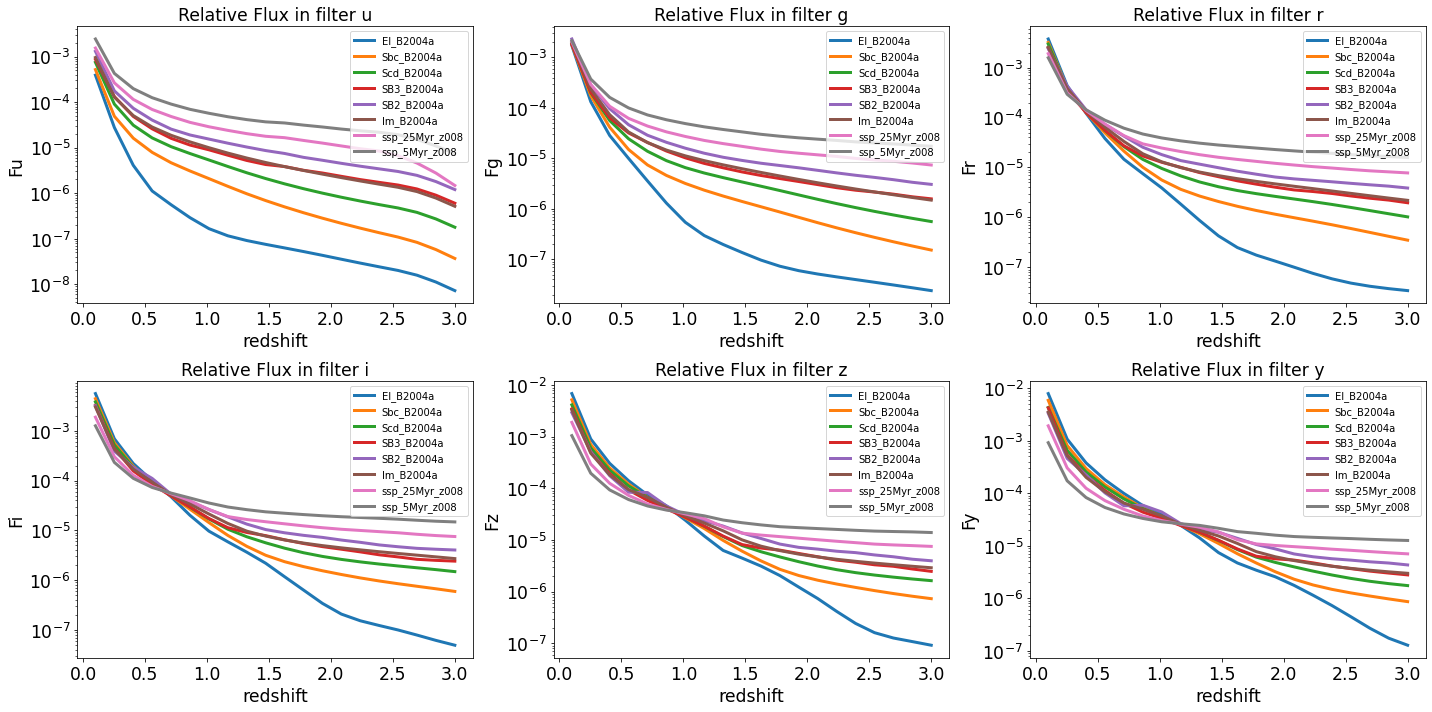

In [34]:
fig, axs = plt.subplots(NR, NC,figsize=(20,10))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib=ic+ir*NC
        
        for it in np.arange(NT):
            F= [ f[ib,it] for f in all_F]
            axs[ir,ic].plot(all_z,F,label=sed_names[it],lw=3)
            axs[ir,ic].set_yscale("log")
            axs[ir,ic].legend(loc="upper right")
            axs[ir,ic].set_xlabel("redshift")
            axs[ir,ic].set_ylabel("F"+band_name[ib])
            axs[ir,ic].set_title("Relative Flux in filter "+band_name[ib])
            
plt.tight_layout()
plt.show()

# GP Kernel

In [35]:
#gp.kernel?

In [36]:
gp.kernel.g_AB

1.0

In [37]:
X1=np.zeros((numBands,3))
X1[:,0]=np.arange(numBands)
X1[:,1]=1
X1[:,2]=1.0

In [38]:
X2=np.zeros((numBands,3))
X2[:,0]=np.arange(numBands)
X2[:,2]=1
X2[:,2]=1.0

In [39]:
gp.kernel.K(X1,X2).shape

(6, 6)

## Covariance matrix

In [40]:
def Make_Covariance_Matrix(the_gp,all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=the_gp.kernel.K(X1,X2)[ifilt2,ifilt1]/(F1*F2)          
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [41]:
def Make_Covariance_Matrix_nonorm(the_gp,all_X,ifilt1,ifilt2):
    """
    """
    N=len(all_X)
    
    K=np.zeros((N,N))
    
    for i in np.arange(N):
        X1=all_X[i]
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for j in np.arange(N):
           
            X2=all_X[j]
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[i,j]=the_gp.kernel.K(X1,X2)[ifilt2,ifilt1]       
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            

In [42]:
def Make_Covariance_matrix_filters(the_gp,z1,z2):
    """
    """
    
    X1=np.zeros((numBands,3))
    X1[:,0]=np.arange(numBands)
    X1[:,1]=z1
    X1[:,2]=1
    
    Fluxes1=the_gp.mean_fct.f(X1)
    
    
    X2=np.zeros((numBands,3))
    X2[:,0]=np.arange(numBands)
    X2[:,1]=z2
    X2[:,2]=1
    
    Fluxes2=the_gp.mean_fct.f(X1)
    
    K=np.zeros((numBands,numBands))
    
    
    for ifilt1 in np.arange(numBands):
        F1=np.average(the_gp.mean_fct.f(X1)[ifilt1])
        for ifilt2 in np.arange(numBands):
           
            F2=np.average(the_gp.mean_fct.f(X2)[ifilt2])
            K[ifilt1,ifilt2]=the_gp.kernel.K(X1,X2)[ifilt1,ifilt2]/(F1*F2)          
            #print("i=",i,"  j=",j,"  X1=",X1[ifilt1,1],"  X2=",X2[ifilt2,1],"  K=",K[i,j])
    return K
            
    


/tmp/ipykernel_3452/1882460199.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label_list)
/tmp/ipykernel_3452/1882460199.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_label_list)
/tmp/ipykernel_3452/1882460199.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label_list)
/tmp/ipykernel_3452/1882460199.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_label_list)


Text(0.5, 1.0, '$z_1$=1, $z_2$=2')

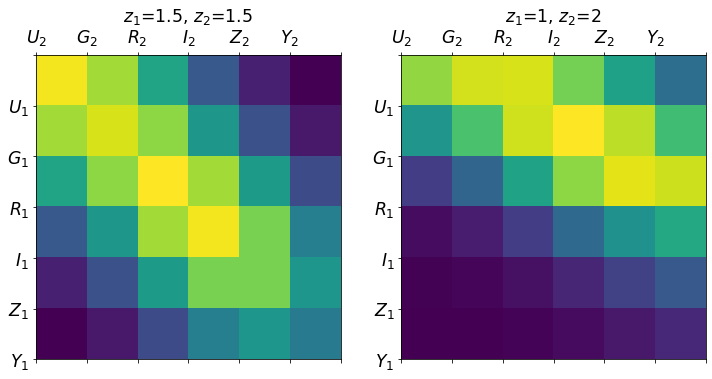

In [43]:
fig=plt.figure(figsize=(12,6))
               
ax=fig.add_subplot(1,2,1)

z1=1.5
z2=1.5
K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
ax.matshow(K,extent=(0,6,0,6))
x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
title="$z_1$={}, $z_2$={}".format(z1,z2)
ax.set_title(title)

ax=fig.add_subplot(1,2,2)
z1=1
z2=2
K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
ax.matshow(K,extent=(0,6,0,6))

x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
title="$z_1$={}, $z_2$={}".format(z1,z2)
ax.set_title(title)

#ax=fig.add_subplot(1,3,3)
#z1=0
#z2=3
#K=Make_Covariance_matrix_filters(gp,z1,z2)
#ax.matshow(K,cmap="jet",extent=(0,6,0,6))
#ax.matshow(K,extent=(0,6,0,6))
#x_label_list = ['$U_2$', '$G_2$', '$R_2$', '$I_2$', '$Z_2$', '$Y_2$' ]
#y_label_list = ['$Y_1$', '$Z_1$', '$I_1$', '$R_1$', '$G_1$', '$U_1$' ]
#ax.set_xticklabels(x_label_list)
#ax.set_yticklabels(y_label_list)
#title="$z_1$={}, $z_2$={}".format(z1,z2)
#ax.set_title(title)


### Plot covariance matrix

In [44]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]

In [45]:
NR=6  
NC=6   

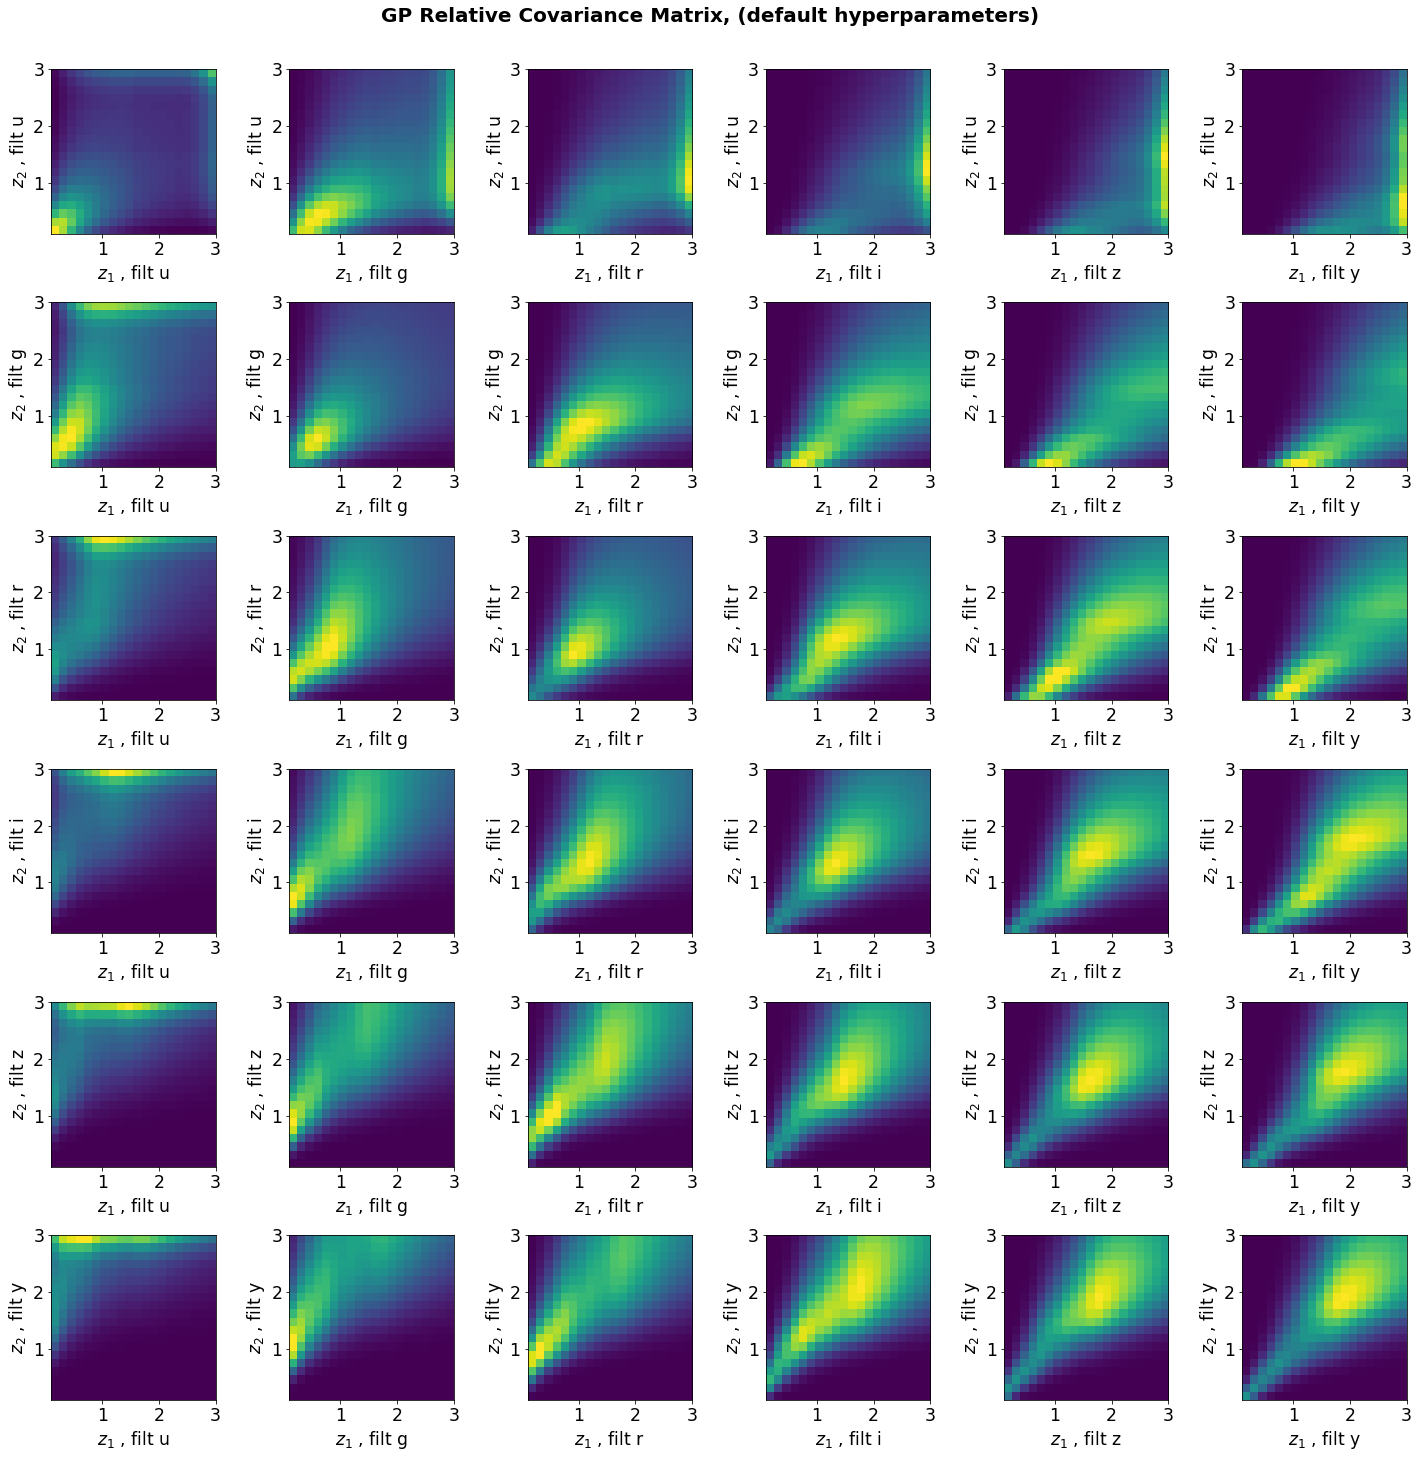

In [46]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
plt.suptitle("GP Relative Covariance Matrix, (default hyperparameters)",fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

Text(0, 0.5, '$z_2$ , filt y')

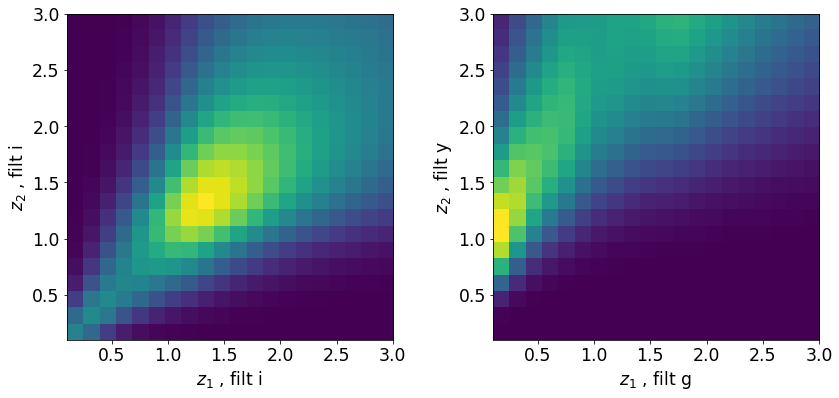

In [47]:
fig=plt.figure(figsize=(14,6))
               
ax=fig.add_subplot(1,2,1)
ib1=3
ib2=3
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
ax.imshow(Cov,origin="lower",extent=extent)
ax.set_xlabel("$z_1$ , filt "+band_name[ib1])
ax.set_ylabel("$z_2$ , filt "+band_name[ib2])
ax=fig.add_subplot(1,2,2)
ib1=1
ib2=5
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
ax.imshow(Cov,origin="lower",extent=extent)
ax.set_xlabel("$z_1$ , filt "+band_name[ib1])
ax.set_ylabel("$z_2$ , filt "+band_name[ib2])

## Marginal Likelihood
### Code inspiré du tutoriel "filling missing bands" sur la page de documentation Delight

In [55]:
loc = -1
trainingDataIter1 = getDataFromFile(params, firstLine, lastLine, prefix="training_", getXY=True, CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
    X, Y, Yvar in trainingDataIter1:
    loc += 1
#    # Interpolate template library at spectroscopic redshift
#    themod = np.zeros((1, f_mod.shape[0], bands.size))
#    for it in range(f_mod.shape[0]):
#        for ib, band in enumerate(bands):
#            themod[0, it, ib] = f_mod[it, band](z)
#    # Run color likelihood to find best template and ML luminosity
#    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
#    bestType = np.argmin(chi2_grid)
#    ell = ellMLs[0, bestType]
#    # Use them in the GP
#    X[:, 2] = ell
#    gp.setData(X, Y, Yvar, bestType)
    print( "Band={}, \nRedshift={}, \nEll={}".format(band_name[X[:,0]], X[:,1], X[:,2]) )
    gp.setData(X, Y, Yvar)
    kernelInterp = gp.kernel.use_interpolators
    gp.kernel.use_interpolators = False
    gp.optimizeHyperparamaters([V_C, alpha_C], verbose=True)
    gp.kernel.use_interpolators = kernelInterp
    print( "Minimum Marginal Likelihood = {}, V_C = {}, alpha_C = {}, loc = {}".format(gp.margLike(), gp.kernel.var_C, gp.kernel.alpha_C, loc) )

Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.02043499 0.02043499 0.02043499 0.02043499 0.02043499 0.02043499], 
Ell=[2.60222574e+11 2.60222574e+11 2.60222574e+11 2.60222574e+11
 2.60222574e+11 2.60222574e+11]
Optimized parameters:  [1.31961211e-06 1.00000847e+03]
Minimum Marginal Likelihood = 56.03809481799241, V_C = 1.319612113423964e-06, alpha_C = 1000.0084685632353, loc = 0
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.01936132 0.01936132 0.01936132 0.01936132 0.01936132 0.01936132], 
Ell=[6.21568103e+09 6.21568103e+09 6.21568103e+09 6.21568103e+09
 6.21568103e+09 6.21568103e+09]
Optimized parameters:  [1.37570965e-06 1.00000807e+03]
Minimum Marginal Likelihood = 34.43797374234687, V_C = 1.375709648054786e-06, alpha_C = 1000.0080714807069, loc = 1
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.03672067 0.03672067 0.03672067 0.03672067 0.03672067 0.03672067], 
Ell=[6.87916515e+10 6.87916515e+10 6.87916515e+10 6.87916515e+10
 6.87916515e+10 6.87916515e+10]
Optimized parameters:  [1.80768796e-06 1.00000925

Optimized parameters:  [1.11555384e-06 1.00000921e+03]
Minimum Marginal Likelihood = 29.311801530836597, V_C = 1.1155538418508608e-06, alpha_C = 1000.0092084574263, loc = 22
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.06451698 0.06451698 0.06451698 0.06451698 0.06451698 0.06451698], 
Ell=[1.48674552e+10 1.48674552e+10 1.48674552e+10 1.48674552e+10
 1.48674552e+10 1.48674552e+10]
Optimized parameters:  [1.09991425e-06 1.00000911e+03]
Minimum Marginal Likelihood = 23.71804845262203, V_C = 1.0999142467015843e-06, alpha_C = 1000.0091091284987, loc = 23
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.07308046 0.07308046 0.07308046 0.07308046 0.07308046 0.07308046], 
Ell=[5.75729622e+09 5.75729622e+09 5.75729622e+09 5.75729622e+09
 5.75729622e+09 5.75729622e+09]
Optimized parameters:  [1.17155281e-06 1.00000958e+03]
Minimum Marginal Likelihood = 16.609038624691557, V_C = 1.1715528130137947e-06, alpha_C = 1000.0095841593916, loc = 24
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.09061105 0.09061105 0.09061105 0.0

Optimized parameters:  [9.81320490e-07 1.00001034e+03]
Minimum Marginal Likelihood = 33.423616724313526, V_C = 9.813204901431744e-07, alpha_C = 1000.0103406469324, loc = 44
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.12184698 0.12184698 0.12184698 0.12184698 0.12184698 0.12184698], 
Ell=[3.11103047e+12 3.11103047e+12 3.11103047e+12 3.11103047e+12
 3.11103047e+12 3.11103047e+12]
Optimized parameters:  [9.96550157e-07 1.00001153e+03]
Minimum Marginal Likelihood = 47.17147173536774, V_C = 9.965501567373932e-07, alpha_C = 1000.011534334616, loc = 45
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.11847609 0.11847609 0.11847609 0.11847609 0.11847609 0.11847609], 
Ell=[6.95223915e+10 6.95223915e+10 6.95223915e+10 6.95223915e+10
 6.95223915e+10 6.95223915e+10]
Optimized parameters:  [9.25557210e-07 1.00001086e+03]
Minimum Marginal Likelihood = 24.501587757452945, V_C = 9.255572101992902e-07, alpha_C = 1000.0108587186517, loc = 46
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.1198283 0.1198283 0.1198283 0.1198283 

Optimized parameters:  [8.52086910e-07 1.00001102e+03]
Minimum Marginal Likelihood = 21.589727341625508, V_C = 8.520869100856678e-07, alpha_C = 1000.011015170417, loc = 66
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.14761769 0.14761769 0.14761769 0.14761769 0.14761769 0.14761769], 
Ell=[2.14710725e+12 2.14710725e+12 2.14710725e+12 2.14710725e+12
 2.14710725e+12 2.14710725e+12]
Optimized parameters:  [8.47989547e-07 1.00001288e+03]
Minimum Marginal Likelihood = 41.90826679479141, V_C = 8.479895466943446e-07, alpha_C = 1000.012883130704, loc = 67
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.13650371 0.13650371 0.13650371 0.13650371 0.13650371 0.13650371], 
Ell=[4.53103045e+10 4.53103045e+10 4.53103045e+10 4.53103045e+10
 4.53103045e+10 4.53103045e+10]
Optimized parameters:  [7.87755435e-07 1.00001289e+03]
Minimum Marginal Likelihood = 19.579406940982093, V_C = 7.87755434861829e-07, alpha_C = 1000.0128855162789, loc = 68
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.14241564 0.14241564 0.14241564 0.1424156

Optimized parameters:  [6.64623341e-07 1.00001314e+03]
Minimum Marginal Likelihood = 20.544002227313072, V_C = 6.646233406348905e-07, alpha_C = 1000.0131383761546, loc = 88
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.18472919 0.18472919 0.18472919 0.18472919 0.18472919 0.18472919], 
Ell=[1.19966501e+12 1.19966501e+12 1.19966501e+12 1.19966501e+12
 1.19966501e+12 1.19966501e+12]
Optimized parameters:  [7.76248111e-07 1.00001349e+03]
Minimum Marginal Likelihood = 35.16043008536534, V_C = 7.762481113954304e-07, alpha_C = 1000.0134909255416, loc = 89
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.1822635 0.1822635 0.1822635 0.1822635 0.1822635 0.1822635], 
Ell=[1.68002424e+12 1.68002424e+12 1.68002424e+12 1.68002424e+12
 1.68002424e+12 1.68002424e+12]
Optimized parameters:  [9.58914864e-07 1.00001406e+03]
Minimum Marginal Likelihood = 38.00968816220056, V_C = 9.589148641690578e-07, alpha_C = 1000.0140601209692, loc = 90
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.15847833 0.15847833 0.15847833 0.15847833 0.

Optimized parameters:  [8.28013903e-07 1.00001419e+03]
Minimum Marginal Likelihood = 49.19147636977692, V_C = 8.2801390258827e-07, alpha_C = 1000.0141924227539, loc = 110
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.20167136 0.20167136 0.20167136 0.20167136 0.20167136 0.20167136], 
Ell=[6.54669557e+12 6.54669557e+12 6.54669557e+12 6.54669557e+12
 6.54669557e+12 6.54669557e+12]
Optimized parameters:  [8.68527021e-07 1.00001343e+03]
Minimum Marginal Likelihood = 44.50322509904339, V_C = 8.685270213429325e-07, alpha_C = 1000.0134321771785, loc = 111
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.20206667 0.20206667 0.20206667 0.20206667 0.20206667 0.20206667], 
Ell=[7.72534983e+11 7.72534983e+11 7.72534983e+11 7.72534983e+11
 7.72534983e+11 7.72534983e+11]
Optimized parameters:  [8.59230543e-07 1.00001496e+03]
Minimum Marginal Likelihood = 31.622129165968285, V_C = 8.592305432779631e-07, alpha_C = 1000.0149578490408, loc = 112
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.20009867 0.20009867 0.20009867 0.2000

Optimized parameters:  [8.93510237e-07 1.00001470e+03]
Minimum Marginal Likelihood = 36.24030279254581, V_C = 8.935102366174974e-07, alpha_C = 1000.0146959765609, loc = 132
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.17989358 0.17989358 0.17989358 0.17989358 0.17989358 0.17989358], 
Ell=[4.00402069e+12 4.00402069e+12 4.00402069e+12 4.00402069e+12
 4.00402069e+12 4.00402069e+12]
Optimized parameters:  [9.73702102e-07 1.00001474e+03]
Minimum Marginal Likelihood = 43.44135845930105, V_C = 9.737021015293888e-07, alpha_C = 1000.0147399640844, loc = 133
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.17879093 0.17879093 0.17879093 0.17879093 0.17879093 0.17879093], 
Ell=[8.68165951e+11 8.68165951e+11 8.68165951e+11 8.68165951e+11
 8.68165951e+11 8.68165951e+11]
Optimized parameters:  [8.81318962e-07 1.00001343e+03]
Minimum Marginal Likelihood = 34.03913951730289, V_C = 8.813189620338692e-07, alpha_C = 1000.0134256548231, loc = 134
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.20927022 0.20927022 0.20927022 0.209

Optimized parameters:  [7.57265894e-07 1.00001413e+03]
Minimum Marginal Likelihood = 19.660519977353403, V_C = 7.572658939214294e-07, alpha_C = 1000.0141337270097, loc = 154
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.19972378 0.19972378 0.19972378 0.19972378 0.19972378 0.19972378], 
Ell=[2.5661059e+11 2.5661059e+11 2.5661059e+11 2.5661059e+11 2.5661059e+11
 2.5661059e+11]
Optimized parameters:  [7.34478136e-07 1.00001404e+03]
Minimum Marginal Likelihood = 24.695878315057946, V_C = 7.344781363437721e-07, alpha_C = 1000.0140373713591, loc = 155
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.19298008 0.19298008 0.19298008 0.19298008 0.19298008 0.19298008], 
Ell=[1.05828755e+11 1.05828755e+11 1.05828755e+11 1.05828755e+11
 1.05828755e+11 1.05828755e+11]
Optimized parameters:  [8.50476961e-07 1.00001412e+03]
Minimum Marginal Likelihood = 20.28810384158082, V_C = 8.504769609737806e-07, alpha_C = 1000.0141158964237, loc = 156
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.19132275 0.19132275 0.19132275 0.1913227

Optimized parameters:  [5.85656162e-07 1.00001606e+03]
Minimum Marginal Likelihood = 39.58642401546083, V_C = 5.856561620417197e-07, alpha_C = 1000.0160565599306, loc = 176
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.23369682 0.23369682 0.23369682 0.23369682 0.23369682 0.23369682], 
Ell=[4.69402994e+11 4.69402994e+11 4.69402994e+11 4.69402994e+11
 4.69402994e+11 4.69402994e+11]
Optimized parameters:  [6.67357273e-07 1.00001477e+03]
Minimum Marginal Likelihood = 25.918687246333196, V_C = 6.673572730414798e-07, alpha_C = 1000.014770465659, loc = 177
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.23312647 0.23312647 0.23312647 0.23312647 0.23312647 0.23312647], 
Ell=[6.1843869e+11 6.1843869e+11 6.1843869e+11 6.1843869e+11 6.1843869e+11
 6.1843869e+11]
Optimized parameters:  [6.03768055e-07 1.00001431e+03]
Minimum Marginal Likelihood = 27.302176818909544, V_C = 6.037680550808271e-07, alpha_C = 1000.0143091427802, loc = 178
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.23314167 0.23314167 0.23314167 0.23314167

Optimized parameters:  [5.88054474e-07 1.00001517e+03]
Minimum Marginal Likelihood = 21.16157258807454, V_C = 5.880544739607245e-07, alpha_C = 1000.0151688053825, loc = 198
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.23072982 0.23072982 0.23072982 0.23072982 0.23072982 0.23072982], 
Ell=[7.34457641e+11 7.34457641e+11 7.34457641e+11 7.34457641e+11
 7.34457641e+11 7.34457641e+11]
Optimized parameters:  [5.75458558e-07 1.00001573e+03]
Minimum Marginal Likelihood = 28.351064753386627, V_C = 5.754585575367037e-07, alpha_C = 1000.0157328767394, loc = 199
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.24240362 0.24240362 0.24240362 0.24240362 0.24240362 0.24240362], 
Ell=[3.2647004e+12 3.2647004e+12 3.2647004e+12 3.2647004e+12 3.2647004e+12
 3.2647004e+12]
Optimized parameters:  [7.81037039e-07 1.00001551e+03]
Minimum Marginal Likelihood = 37.52768328480412, V_C = 7.810370389668397e-07, alpha_C = 1000.0155098382744, loc = 200
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.22799454 0.22799454 0.22799454 0.22799454

Optimized parameters:  [7.12194524e-07 1.00001597e+03]
Minimum Marginal Likelihood = 30.18324518969317, V_C = 7.121945238953563e-07, alpha_C = 1000.0159670655131, loc = 220
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.26509388 0.26509388 0.26509388 0.26509388 0.26509388 0.26509388], 
Ell=[1.64694208e+11 1.64694208e+11 1.64694208e+11 1.64694208e+11
 1.64694208e+11 1.64694208e+11]
Optimized parameters:  [5.41057558e-07 1.00001563e+03]
Minimum Marginal Likelihood = 17.30433461213319, V_C = 5.410575584209598e-07, alpha_C = 1000.0156250726845, loc = 221
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.26735101 0.26735101 0.26735101 0.26735101 0.26735101 0.26735101], 
Ell=[4.01080856e+12 4.01080856e+12 4.01080856e+12 4.01080856e+12
 4.01080856e+12 4.01080856e+12]
Optimized parameters:  [6.76968663e-07 1.00001645e+03]
Minimum Marginal Likelihood = 37.00446503874472, V_C = 6.76968663059265e-07, alpha_C = 1000.0164460406462, loc = 222
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.27045311 0.27045311 0.27045311 0.2704

Optimized parameters:  [5.55396619e-07 1.00001647e+03]
Minimum Marginal Likelihood = 17.86524150440103, V_C = 5.553966192142239e-07, alpha_C = 1000.0164668169875, loc = 242
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.25674193 0.25674193 0.25674193 0.25674193 0.25674193 0.25674193], 
Ell=[5.14319409e+11 5.14319409e+11 5.14319409e+11 5.14319409e+11
 5.14319409e+11 5.14319409e+11]
Optimized parameters:  [5.66012982e-07 1.00001646e+03]
Minimum Marginal Likelihood = 24.7095686177709, V_C = 5.660129819807564e-07, alpha_C = 1000.0164579403119, loc = 243
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.28471569 0.28471569 0.28471569 0.28471569 0.28471569 0.28471569], 
Ell=[3.85376726e+11 3.85376726e+11 3.85376726e+11 3.85376726e+11
 3.85376726e+11 3.85376726e+11]
Optimized parameters:  [4.74403919e-07 1.00001428e+03]
Minimum Marginal Likelihood = 21.02379589453231, V_C = 4.7440391874251087e-07, alpha_C = 1000.0142805555087, loc = 244
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.29886053 0.29886053 0.29886053 0.298

Optimized parameters:  [4.84703429e-07 1.00001608e+03]
Minimum Marginal Likelihood = 25.488069156696902, V_C = 4.847034294029789e-07, alpha_C = 1000.0160799540438, loc = 264
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.30264777 0.30264777 0.30264777 0.30264777 0.30264777 0.30264777], 
Ell=[1.12024954e+12 1.12024954e+12 1.12024954e+12 1.12024954e+12
 1.12024954e+12 1.12024954e+12]
Optimized parameters:  [4.69263195e-07 1.00001563e+03]
Minimum Marginal Likelihood = 26.554480556599074, V_C = 4.6926319538410483e-07, alpha_C = 1000.0156276695873, loc = 265
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.27691826 0.27691826 0.27691826 0.27691826 0.27691826 0.27691826], 
Ell=[5.13758289e+11 5.13758289e+11 5.13758289e+11 5.13758289e+11
 5.13758289e+11 5.13758289e+11]
Optimized parameters:  [5.13734919e-07 1.00001549e+03]
Minimum Marginal Likelihood = 23.366432861098193, V_C = 5.137349187086067e-07, alpha_C = 1000.015486686995, loc = 266
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.28610643 0.28610643 0.28610643 0.

Optimized parameters:  [4.59300101e-07 1.00001427e+03]
Minimum Marginal Likelihood = 24.324970062582942, V_C = 4.593001012529296e-07, alpha_C = 1000.0142720889546, loc = 286
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.28881531 0.28881531 0.28881531 0.28881531 0.28881531 0.28881531], 
Ell=[2.80959563e+12 2.80959563e+12 2.80959563e+12 2.80959563e+12
 2.80959563e+12 2.80959563e+12]
Optimized parameters:  [6.58406393e-07 1.00001564e+03]
Minimum Marginal Likelihood = 33.734969492657235, V_C = 6.58406393316481e-07, alpha_C = 1000.0156424544098, loc = 287
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.28471215 0.28471215 0.28471215 0.28471215 0.28471215 0.28471215], 
Ell=[4.64598989e+11 4.64598989e+11 4.64598989e+11 4.64598989e+11
 4.64598989e+11 4.64598989e+11]
Optimized parameters:  [4.87374360e-07 1.00001469e+03]
Minimum Marginal Likelihood = 22.227512349605178, V_C = 4.873743595835208e-07, alpha_C = 1000.0146865386907, loc = 288
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.28550318 0.28550318 0.28550318 0.2

Optimized parameters:  [4.43100924e-07 1.00001554e+03]
Minimum Marginal Likelihood = 26.70137384541046, V_C = 4.431009242980906e-07, alpha_C = 1000.0155379004073, loc = 309
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.3223099 0.3223099 0.3223099 0.3223099 0.3223099 0.3223099], 
Ell=[6.00988901e+12 6.00988901e+12 6.00988901e+12 6.00988901e+12
 6.00988901e+12 6.00988901e+12]
Optimized parameters:  [5.80010532e-07 1.00001761e+03]
Minimum Marginal Likelihood = 36.4195362023489, V_C = 5.800105323921048e-07, alpha_C = 1000.0176051557464, loc = 310
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.32565503 0.32565503 0.32565503 0.32565503 0.32565503 0.32565503], 
Ell=[8.08487959e+11 8.08487959e+11 8.08487959e+11 8.08487959e+11
 8.08487959e+11 8.08487959e+11]
Optimized parameters:  [5.18274201e-07 1.00001712e+03]
Minimum Marginal Likelihood = 23.888871443525375, V_C = 5.182742014472103e-07, alpha_C = 1000.0171233103002, loc = 311
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.31664862 0.31664862 0.31664862 0.31664862 

Optimized parameters:  [5.88314767e-07 1.00001853e+03]
Minimum Marginal Likelihood = 40.32276430871204, V_C = 5.883147674513232e-07, alpha_C = 1000.0185310333259, loc = 331
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.32970587 0.32970587 0.32970587 0.32970587 0.32970587 0.32970587], 
Ell=[1.32897922e+13 1.32897922e+13 1.32897922e+13 1.32897922e+13
 1.32897922e+13 1.32897922e+13]
Optimized parameters:  [5.00337595e-07 1.00001576e+03]
Minimum Marginal Likelihood = 40.40917274604415, V_C = 5.003375946874569e-07, alpha_C = 1000.0157626937413, loc = 332
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.31639601 0.31639601 0.31639601 0.31639601 0.31639601 0.31639601], 
Ell=[2.23464529e+11 2.23464529e+11 2.23464529e+11 2.23464529e+11
 2.23464529e+11 2.23464529e+11]
Optimized parameters:  [4.25320382e-07 1.00001670e+03]
Minimum Marginal Likelihood = 15.993177203479199, V_C = 4.253203822548829e-07, alpha_C = 1000.0167019444841, loc = 333
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.32414774 0.32414774 0.32414774 0.32

Optimized parameters:  [4.72284047e-07 1.00001580e+03]
Minimum Marginal Likelihood = 37.48566421884633, V_C = 4.722840470066426e-07, alpha_C = 1000.015803675824, loc = 353
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.355518 0.355518 0.355518 0.355518 0.355518 0.355518], 
Ell=[4.1778666e+11 4.1778666e+11 4.1778666e+11 4.1778666e+11 4.1778666e+11
 4.1778666e+11]
Optimized parameters:  [4.02195653e-07 1.00001646e+03]
Minimum Marginal Likelihood = 17.98984557620643, V_C = 4.0219565253270605e-07, alpha_C = 1000.016457925341, loc = 354
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.3541514 0.3541514 0.3541514 0.3541514 0.3541514 0.3541514], 
Ell=[4.30272363e+12 4.30272363e+12 4.30272363e+12 4.30272363e+12
 4.30272363e+12 4.30272363e+12]
Optimized parameters:  [7.39128811e-07 1.00001833e+03]
Minimum Marginal Likelihood = 33.82101305474924, V_C = 7.391288112384828e-07, alpha_C = 1000.0183254382902, loc = 355
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.36199212 0.36199212 0.36199212 0.36199212 0.36199212 0.361992

Optimized parameters:  [5.49616055e-07 1.00001547e+03]
Minimum Marginal Likelihood = 40.171398593794265, V_C = 5.496160554294027e-07, alpha_C = 1000.0154724736857, loc = 375
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.35176424 0.35176424 0.35176424 0.35176424 0.35176424 0.35176424], 
Ell=[9.16475847e+12 9.16475847e+12 9.16475847e+12 9.16475847e+12
 9.16475847e+12 9.16475847e+12]
Optimized parameters:  [5.77585034e-07 1.00001757e+03]
Minimum Marginal Likelihood = 37.73336995001186, V_C = 5.775850339676932e-07, alpha_C = 1000.0175652734662, loc = 376
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.35763616 0.35763616 0.35763616 0.35763616 0.35763616 0.35763616], 
Ell=[4.14625915e+12 4.14625915e+12 4.14625915e+12 4.14625915e+12
 4.14625915e+12 4.14625915e+12]
Optimized parameters:  [5.03547258e-07 1.00001604e+03]
Minimum Marginal Likelihood = 32.31321849945171, V_C = 5.035472581217318e-07, alpha_C = 1000.0160394495849, loc = 377
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.35658278 0.35658278 0.35658278 0.35

Optimized parameters:  [4.64202290e-07 1.00001587e+03]
Minimum Marginal Likelihood = 15.438589609973569, V_C = 4.642022899013675e-07, alpha_C = 1000.0158699879493, loc = 397
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.34905242 0.34905242 0.34905242 0.34905242 0.34905242 0.34905242], 
Ell=[2.38863121e+11 2.38863121e+11 2.38863121e+11 2.38863121e+11
 2.38863121e+11 2.38863121e+11]
Optimized parameters:  [3.91501838e-07 1.00001700e+03]
Minimum Marginal Likelihood = 14.833367764772088, V_C = 3.915018376847842e-07, alpha_C = 1000.0170026889789, loc = 398
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.35624098 0.35624098 0.35624098 0.35624098 0.35624098 0.35624098], 
Ell=[3.23812208e+11 3.23812208e+11 3.23812208e+11 3.23812208e+11
 3.23812208e+11 3.23812208e+11]
Optimized parameters:  [3.94019675e-07 1.00001625e+03]
Minimum Marginal Likelihood = 16.381334903885538, V_C = 3.940196754976628e-07, alpha_C = 1000.0162549586245, loc = 399
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.40015255 0.40015255 0.40015255 0.

Optimized parameters:  [4.41970124e-07 1.00002130e+03]
Minimum Marginal Likelihood = 25.414764627134193, V_C = 4.419701242568297e-07, alpha_C = 1000.0212961270805, loc = 419
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.3715203 0.3715203 0.3715203 0.3715203 0.3715203 0.3715203], 
Ell=[6.04611433e+12 6.04611433e+12 6.04611433e+12 6.04611433e+12
 6.04611433e+12 6.04611433e+12]
Optimized parameters:  [5.65102272e-07 1.00001841e+03]
Minimum Marginal Likelihood = 34.405690332307366, V_C = 5.651022720717352e-07, alpha_C = 1000.0184087612009, loc = 420
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.38449086 0.38449086 0.38449086 0.38449086 0.38449086 0.38449086], 
Ell=[5.47025172e+12 5.47025172e+12 5.47025172e+12 5.47025172e+12
 5.47025172e+12 5.47025172e+12]
Optimized parameters:  [4.24080505e-07 1.00001999e+03]
Minimum Marginal Likelihood = 32.45376349524032, V_C = 4.240805053485647e-07, alpha_C = 1000.0199852659928, loc = 421
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.40109955 0.40109955 0.40109955 0.4010995

Optimized parameters:  [5.88282624e-07 1.00001799e+03]
Minimum Marginal Likelihood = 38.082321524841284, V_C = 5.882826243164759e-07, alpha_C = 1000.0179907862969, loc = 441
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.37446913 0.37446913 0.37446913 0.37446913 0.37446913 0.37446913], 
Ell=[1.05132533e+13 1.05132533e+13 1.05132533e+13 1.05132533e+13
 1.05132533e+13 1.05132533e+13]
Optimized parameters:  [5.55162030e-07 1.00002033e+03]
Minimum Marginal Likelihood = 37.54664566850668, V_C = 5.551620303375611e-07, alpha_C = 1000.0203297731275, loc = 442
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.40474045 0.40474045 0.40474045 0.40474045 0.40474045 0.40474045], 
Ell=[2.11886993e+12 2.11886993e+12 2.11886993e+12 2.11886993e+12
 2.11886993e+12 2.11886993e+12]
Optimized parameters:  [3.36814922e-07 1.00002333e+03]
Minimum Marginal Likelihood = 25.349019762497264, V_C = 3.3681492170460035e-07, alpha_C = 1000.0233331552042, loc = 443
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.4119137 0.4119137 0.4119137 0.411

Optimized parameters:  [4.78596418e-07 1.00002367e+03]
Minimum Marginal Likelihood = 32.01539164127452, V_C = 4.785964183605982e-07, alpha_C = 1000.0236712701317, loc = 464
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.41261628 0.41261628 0.41261628 0.41261628 0.41261628 0.41261628], 
Ell=[2.32578308e+13 2.32578308e+13 2.32578308e+13 2.32578308e+13
 2.32578308e+13 2.32578308e+13]
Optimized parameters:  [4.89586188e-07 1.00002345e+03]
Minimum Marginal Likelihood = 40.57529479515288, V_C = 4.895861877315553e-07, alpha_C = 1000.0234503820412, loc = 465
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.41170802 0.41170802 0.41170802 0.41170802 0.41170802 0.41170802], 
Ell=[1.54879909e+12 1.54879909e+12 1.54879909e+12 1.54879909e+12
 1.54879909e+12 1.54879909e+12]
Optimized parameters:  [3.59064138e-07 1.00002220e+03]
Minimum Marginal Likelihood = 23.423626186324398, V_C = 3.5906413763200496e-07, alpha_C = 1000.0222012351667, loc = 466
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.4210703 0.4210703 0.4210703 0.4210

Optimized parameters:  [3.33756449e-07 1.00002200e+03]
Minimum Marginal Likelihood = 28.372924522430008, V_C = 3.337564486870632e-07, alpha_C = 1000.021999094071, loc = 486
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.43667052 0.43667052 0.43667052 0.43667052 0.43667052 0.43667052], 
Ell=[3.62067732e+12 3.62067732e+12 3.62067732e+12 3.62067732e+12
 3.62067732e+12 3.62067732e+12]
Optimized parameters:  [4.03267408e-07 1.00002420e+03]
Minimum Marginal Likelihood = 28.05971605920543, V_C = 4.0326740800735765e-07, alpha_C = 1000.0242034421068, loc = 487
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.43929042 0.43929042 0.43929042 0.43929042 0.43929042 0.43929042], 
Ell=[2.54667919e+12 2.54667919e+12 2.54667919e+12 2.54667919e+12
 2.54667919e+12 2.54667919e+12]
Optimized parameters:  [3.38987856e-07 1.00002234e+03]
Minimum Marginal Likelihood = 25.316539681892763, V_C = 3.3898785612654884e-07, alpha_C = 1000.022335607216, loc = 488
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.45976867 0.45976867 0.45976867 0.4

Optimized parameters:  [4.18592642e-07 1.00002097e+03]
Minimum Marginal Likelihood = 34.1521768017609, V_C = 4.185926417553531e-07, alpha_C = 1000.0209730133962, loc = 508
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.45818919 0.45818919 0.45818919 0.45818919 0.45818919 0.45818919], 
Ell=[9.97026111e+12 9.97026111e+12 9.97026111e+12 9.97026111e+12
 9.97026111e+12 9.97026111e+12]
Optimized parameters:  [4.39981197e-07 1.00002368e+03]
Minimum Marginal Likelihood = 33.69060076451604, V_C = 4.3998119696031137e-07, alpha_C = 1000.0236821023956, loc = 509
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.47213286 0.47213286 0.47213286 0.47213286 0.47213286 0.47213286], 
Ell=[1.53597238e+12 1.53597238e+12 1.53597238e+12 1.53597238e+12
 1.53597238e+12 1.53597238e+12]
Optimized parameters:  [2.71251040e-07 1.00002209e+03]
Minimum Marginal Likelihood = 20.59618447350492, V_C = 2.7125104019860997e-07, alpha_C = 1000.0220873860774, loc = 510
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.46182038 0.46182038 0.46182038 0.46

Optimized parameters:  [3.18416570e-07 1.00002189e+03]
Minimum Marginal Likelihood = 28.07820508319198, V_C = 3.1841657002449e-07, alpha_C = 1000.0218859228899, loc = 530
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.49362365 0.49362365 0.49362365 0.49362365 0.49362365 0.49362365], 
Ell=[8.85204905e+11 8.85204905e+11 8.85204905e+11 8.85204905e+11
 8.85204905e+11 8.85204905e+11]
Optimized parameters:  [2.20850386e-07 1.00002559e+03]
Minimum Marginal Likelihood = 16.056640035601237, V_C = 2.2085038562465558e-07, alpha_C = 1000.025590505639, loc = 531
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.48658265 0.48658265 0.48658265 0.48658265 0.48658265 0.48658265], 
Ell=[1.85286537e+13 1.85286537e+13 1.85286537e+13 1.85286537e+13
 1.85286537e+13 1.85286537e+13]
Optimized parameters:  [3.30523893e-07 1.00002495e+03]
Minimum Marginal Likelihood = 35.69006407304322, V_C = 3.3052389294194554e-07, alpha_C = 1000.0249516513084, loc = 532
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.48609481 0.48609481 0.48609481 0.486

Optimized parameters:  [2.99637784e-07 1.00002222e+03]
Minimum Marginal Likelihood = 30.568315444330523, V_C = 2.996377837844946e-07, alpha_C = 1000.02222076492, loc = 552
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.51163381 0.51163381 0.51163381 0.51163381 0.51163381 0.51163381], 
Ell=[4.18481638e+12 4.18481638e+12 4.18481638e+12 4.18481638e+12
 4.18481638e+12 4.18481638e+12]
Optimized parameters:  [2.72813894e-07 1.00002510e+03]
Minimum Marginal Likelihood = 25.468851315075646, V_C = 2.7281389427845076e-07, alpha_C = 1000.0250974402451, loc = 553
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.51231936 0.51231936 0.51231936 0.51231936 0.51231936 0.51231936], 
Ell=[7.27499688e+11 7.27499688e+11 7.27499688e+11 7.27499688e+11
 7.27499688e+11 7.27499688e+11]
Optimized parameters:  [2.63514101e-07 1.00002217e+03]
Minimum Marginal Likelihood = 14.895370771667174, V_C = 2.63514101440712e-07, alpha_C = 1000.0221733709387, loc = 554
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.51174326 0.51174326 0.51174326 0.51

Optimized parameters:  [2.60944828e-07 1.00002620e+03]
Minimum Marginal Likelihood = 16.6401465036459, V_C = 2.6094482816675416e-07, alpha_C = 1000.0262026242904, loc = 574
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.52962078 0.52962078 0.52962078 0.52962078 0.52962078 0.52962078], 
Ell=[1.52872687e+13 1.52872687e+13 1.52872687e+13 1.52872687e+13
 1.52872687e+13 1.52872687e+13]
Optimized parameters:  [2.87776533e-07 1.00002329e+03]
Minimum Marginal Likelihood = 32.90310114665457, V_C = 2.8777653297950585e-07, alpha_C = 1000.0232899702836, loc = 575
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.50061836 0.50061836 0.50061836 0.50061836 0.50061836 0.50061836], 
Ell=[1.20735624e+12 1.20735624e+12 1.20735624e+12 1.20735624e+12
 1.20735624e+12 1.20735624e+12]
Optimized parameters:  [2.97905896e-07 1.00002141e+03]
Minimum Marginal Likelihood = 18.601379258484467, V_C = 2.9790589646968706e-07, alpha_C = 1000.021412570578, loc = 576
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.50957906 0.50957906 0.50957906 0.5

Optimized parameters:  [2.59606837e-07 1.00002603e+03]
Minimum Marginal Likelihood = 22.565011323217853, V_C = 2.5960683701162494e-07, alpha_C = 1000.0260301668794, loc = 596
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.54455094 0.54455094 0.54455094 0.54455094 0.54455094 0.54455094], 
Ell=[8.5412637e+12 8.5412637e+12 8.5412637e+12 8.5412637e+12 8.5412637e+12
 8.5412637e+12]
Optimized parameters:  [3.39088461e-07 1.00002531e+03]
Minimum Marginal Likelihood = 29.49777148212062, V_C = 3.3908846106954906e-07, alpha_C = 1000.0253130923379, loc = 597
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.58031484 0.58031484 0.58031484 0.58031484 0.58031484 0.58031484], 
Ell=[3.84946797e+12 3.84946797e+12 3.84946797e+12 3.84946797e+12
 3.84946797e+12 3.84946797e+12]
Optimized parameters:  [2.28873501e-07 1.00002558e+03]
Minimum Marginal Likelihood = 22.619041981333513, V_C = 2.2887350147020676e-07, alpha_C = 1000.0255797081551, loc = 598
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.56054236 0.56054236 0.56054236 0.5605

Optimized parameters:  [2.95591091e-07 1.00002459e+03]
Minimum Marginal Likelihood = 34.50066231738422, V_C = 2.9559109128478524e-07, alpha_C = 1000.0245928161663, loc = 618
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.56949941 0.56949941 0.56949941 0.56949941 0.56949941 0.56949941], 
Ell=[1.24247186e+12 1.24247186e+12 1.24247186e+12 1.24247186e+12
 1.24247186e+12 1.24247186e+12]
Optimized parameters:  [1.97814618e-07 1.00002790e+03]
Minimum Marginal Likelihood = 15.755277094393364, V_C = 1.9781461796036804e-07, alpha_C = 1000.0278979549261, loc = 619
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.55793147 0.55793147 0.55793147 0.55793147 0.55793147 0.55793147], 
Ell=[5.42552032e+12 5.42552032e+12 5.42552032e+12 5.42552032e+12
 5.42552032e+12 5.42552032e+12]
Optimized parameters:  [2.30722153e-07 1.00002259e+03]
Minimum Marginal Likelihood = 25.268086417754947, V_C = 2.3072215288246554e-07, alpha_C = 1000.0225853678302, loc = 620
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.59232139 0.59232139 0.59232139 

Optimized parameters:  [2.83522233e-07 1.00002401e+03]
Minimum Marginal Likelihood = 29.65692191598604, V_C = 2.835222327404061e-07, alpha_C = 1000.0240107286165, loc = 640
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.59106776 0.59106776 0.59106776 0.59106776 0.59106776 0.59106776], 
Ell=[2.61861761e+13 2.61861761e+13 2.61861761e+13 2.61861761e+13
 2.61861761e+13 2.61861761e+13]
Optimized parameters:  [3.65945457e-07 1.00002561e+03]
Minimum Marginal Likelihood = 35.25117627964019, V_C = 3.659454568250566e-07, alpha_C = 1000.0256115312249, loc = 641
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.61245699 0.61245699 0.61245699 0.61245699 0.61245699 0.61245699], 
Ell=[1.69173227e+12 1.69173227e+12 1.69173227e+12 1.69173227e+12
 1.69173227e+12 1.69173227e+12]
Optimized parameters:  [2.35554571e-07 1.00002395e+03]
Minimum Marginal Likelihood = 17.027315030618748, V_C = 2.3555457111877085e-07, alpha_C = 1000.0239531697149, loc = 642
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.59686622 0.59686622 0.59686622 0.5

Optimized parameters:  [2.29170459e-07 1.00002736e+03]
Minimum Marginal Likelihood = 25.091569904223196, V_C = 2.2917045903895518e-07, alpha_C = 1000.0273627605197, loc = 662
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.58152303 0.58152303 0.58152303 0.58152303 0.58152303 0.58152303], 
Ell=[1.61752748e+13 1.61752748e+13 1.61752748e+13 1.61752748e+13
 1.61752748e+13 1.61752748e+13]
Optimized parameters:  [4.09761703e-07 1.00002518e+03]
Minimum Marginal Likelihood = 32.95886786925377, V_C = 4.0976170341761103e-07, alpha_C = 1000.0251750951941, loc = 663
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.61195198 0.61195198 0.61195198 0.61195198 0.61195198 0.61195198], 
Ell=[4.18965177e+12 4.18965177e+12 4.18965177e+12 4.18965177e+12
 4.18965177e+12 4.18965177e+12]
Optimized parameters:  [2.66207100e-07 1.00002703e+03]
Minimum Marginal Likelihood = 22.79926201908203, V_C = 2.6620710024184767e-07, alpha_C = 1000.0270297899838, loc = 664
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.60490879 0.60490879 0.60490879 0

Optimized parameters:  [3.26248373e-07 1.00002598e+03]
Minimum Marginal Likelihood = 31.79732197985624, V_C = 3.262483734446956e-07, alpha_C = 1000.0259754803353, loc = 684
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.64885829 0.64885829 0.64885829 0.64885829 0.64885829 0.64885829], 
Ell=[3.47924048e+12 3.47924048e+12 3.47924048e+12 3.47924048e+12
 3.47924048e+12 3.47924048e+12]
Optimized parameters:  [2.39830568e-07 1.00002723e+03]
Minimum Marginal Likelihood = 20.522168441634935, V_C = 2.3983056751173473e-07, alpha_C = 1000.0272334298439, loc = 685
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.63431665 0.63431665 0.63431665 0.63431665 0.63431665 0.63431665], 
Ell=[5.31688205e+12 5.31688205e+12 5.31688205e+12 5.31688205e+12
 5.31688205e+12 5.31688205e+12]
Optimized parameters:  [2.25622772e-07 1.00002693e+03]
Minimum Marginal Likelihood = 23.205249754699416, V_C = 2.2562277202193498e-07, alpha_C = 1000.0269292366545, loc = 686
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.6522539 0.6522539 0.6522539 0.65

Optimized parameters:  [1.72131415e-07 1.00002864e+03]
Minimum Marginal Likelihood = 15.739502717087596, V_C = 1.72131415294374e-07, alpha_C = 1000.0286378704124, loc = 706
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.64695542 0.64695542 0.64695542 0.64695542 0.64695542 0.64695542], 
Ell=[9.71792044e+12 9.71792044e+12 9.71792044e+12 9.71792044e+12
 9.71792044e+12 9.71792044e+12]
Optimized parameters:  [3.52418946e-07 1.00002421e+03]
Minimum Marginal Likelihood = 27.857746268109416, V_C = 3.5241894575874084e-07, alpha_C = 1000.02421434668, loc = 707
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.63875751 0.63875751 0.63875751 0.63875751 0.63875751 0.63875751], 
Ell=[1.12027234e+13 1.12027234e+13 1.12027234e+13 1.12027234e+13
 1.12027234e+13 1.12027234e+13]
Optimized parameters:  [2.38642489e-07 1.00002963e+03]
Minimum Marginal Likelihood = 27.731311419678068, V_C = 2.386424892346024e-07, alpha_C = 1000.0296330919879, loc = 708
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.62291796 0.62291796 0.62291796 0.62

Optimized parameters:  [2.38122585e-07 1.00002872e+03]
Minimum Marginal Likelihood = 22.799821645391567, V_C = 2.3812258533433732e-07, alpha_C = 1000.0287190136863, loc = 728
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.68248365 0.68248365 0.68248365 0.68248365 0.68248365 0.68248365], 
Ell=[2.27496744e+13 2.27496744e+13 2.27496744e+13 2.27496744e+13
 2.27496744e+13 2.27496744e+13]
Optimized parameters:  [3.63982819e-07 1.00002556e+03]
Minimum Marginal Likelihood = 32.2542108520925, V_C = 3.6398281934153116e-07, alpha_C = 1000.0255593782217, loc = 729
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.67796961 0.67796961 0.67796961 0.67796961 0.67796961 0.67796961], 
Ell=[7.62068291e+12 7.62068291e+12 7.62068291e+12 7.62068291e+12
 7.62068291e+12 7.62068291e+12]
Optimized parameters:  [5.19359409e-07 1.00003031e+03]
Minimum Marginal Likelihood = 26.85201659280508, V_C = 5.193594090252727e-07, alpha_C = 1000.0303145464095, loc = 730
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.68940726 0.68940726 0.68940726 0.6

Optimized parameters:  [2.81121060e-07 1.00002524e+03]
Minimum Marginal Likelihood = 22.701904618998093, V_C = 2.8112106003611875e-07, alpha_C = 1000.0252388235456, loc = 750
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.67785754 0.67785754 0.67785754 0.67785754 0.67785754 0.67785754], 
Ell=[1.54384853e+13 1.54384853e+13 1.54384853e+13 1.54384853e+13
 1.54384853e+13 1.54384853e+13]
Optimized parameters:  [3.32543747e-07 1.00002936e+03]
Minimum Marginal Likelihood = 29.760550259164173, V_C = 3.3254374709343623e-07, alpha_C = 1000.0293552347327, loc = 751
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.68277769 0.68277769 0.68277769 0.68277769 0.68277769 0.68277769], 
Ell=[9.36464664e+12 9.36464664e+12 9.36464664e+12 9.36464664e+12
 9.36464664e+12 9.36464664e+12]
Optimized parameters:  [2.87617142e-07 1.00002773e+03]
Minimum Marginal Likelihood = 26.224830965384008, V_C = 2.8761714230037333e-07, alpha_C = 1000.0277260960918, loc = 752
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.66489603 0.66489603 0.66489603

Optimized parameters:  [2.17274437e-07 1.00002929e+03]
Minimum Marginal Likelihood = 20.739180729971793, V_C = 2.172744369025237e-07, alpha_C = 1000.0292925689288, loc = 772
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.67228668 0.67228668 0.67228668 0.67228668 0.67228668 0.67228668], 
Ell=[4.84694377e+12 4.84694377e+12 4.84694377e+12 4.84694377e+12
 4.84694377e+12 4.84694377e+12]
Optimized parameters:  [2.29080199e-07 1.00002524e+03]
Minimum Marginal Likelihood = 21.83835376092535, V_C = 2.2908019872093125e-07, alpha_C = 1000.0252425031526, loc = 773
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.67674813 0.67674813 0.67674813 0.67674813 0.67674813 0.67674813], 
Ell=[4.56946367e+12 4.56946367e+12 4.56946367e+12 4.56946367e+12
 4.56946367e+12 4.56946367e+12]
Optimized parameters:  [1.97843935e-07 1.00002512e+03]
Minimum Marginal Likelihood = 20.99414769109869, V_C = 1.978439346978762e-07, alpha_C = 1000.0251226654328, loc = 774
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.69017447 0.69017447 0.69017447 0.6

Optimized parameters:  [2.15440790e-07 1.00002622e+03]
Minimum Marginal Likelihood = 21.709132240320663, V_C = 2.1544078996495706e-07, alpha_C = 1000.0262156257902, loc = 794
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.73569095 0.73569095 0.73569095 0.73569095 0.73569095 0.73569095], 
Ell=[6.15644521e+12 6.15644521e+12 6.15644521e+12 6.15644521e+12
 6.15644521e+12 6.15644521e+12]
Optimized parameters:  [2.25170352e-07 1.00002783e+03]
Minimum Marginal Likelihood = 21.860920327778427, V_C = 2.2517035186034876e-07, alpha_C = 1000.02783402699, loc = 795
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.73158044 0.73158044 0.73158044 0.73158044 0.73158044 0.73158044], 
Ell=[4.30930011e+12 4.30930011e+12 4.30930011e+12 4.30930011e+12
 4.30930011e+12 4.30930011e+12]
Optimized parameters:  [2.55903273e-07 1.00003003e+03]
Minimum Marginal Likelihood = 20.225214021494207, V_C = 2.5590327327068025e-07, alpha_C = 1000.0300347057076, loc = 796
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.73040689 0.73040689 0.73040689 0

Optimized parameters:  [3.21142707e-07 1.00002685e+03]
Minimum Marginal Likelihood = 31.668352455297903, V_C = 3.211427073354121e-07, alpha_C = 1000.026853027432, loc = 816
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.72197282 0.72197282 0.72197282 0.72197282 0.72197282 0.72197282], 
Ell=[2.91578307e+12 2.91578307e+12 2.91578307e+12 2.91578307e+12
 2.91578307e+12 2.91578307e+12]
Optimized parameters:  [2.21450074e-07 1.00003125e+03]
Minimum Marginal Likelihood = 17.70828483452099, V_C = 2.214500744588293e-07, alpha_C = 1000.0312513512027, loc = 817
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.71163436 0.71163436 0.71163436 0.71163436 0.71163436 0.71163436], 
Ell=[5.48885973e+12 5.48885973e+12 5.48885973e+12 5.48885973e+12
 5.48885973e+12 5.48885973e+12]
Optimized parameters:  [2.98057225e-07 1.00002906e+03]
Minimum Marginal Likelihood = 22.513076390891275, V_C = 2.980572252213088e-07, alpha_C = 1000.0290648063711, loc = 818
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.69269305 0.69269305 0.69269305 0.69

Optimized parameters:  [2.14032439e-07 1.00002592e+03]
Minimum Marginal Likelihood = 20.267978554555977, V_C = 2.1403243859478396e-07, alpha_C = 1000.0259196492838, loc = 838
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.71142157 0.71142157 0.71142157 0.71142157 0.71142157 0.71142157], 
Ell=[7.77928548e+12 7.77928548e+12 7.77928548e+12 7.77928548e+12
 7.77928548e+12 7.77928548e+12]
Optimized parameters:  [2.60206611e-07 1.00003133e+03]
Minimum Marginal Likelihood = 24.20190735474177, V_C = 2.602066108548267e-07, alpha_C = 1000.031332072169, loc = 839
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.69968825 0.69968825 0.69968825 0.69968825 0.69968825 0.69968825], 
Ell=[1.91754721e+13 1.91754721e+13 1.91754721e+13 1.91754721e+13
 1.91754721e+13 1.91754721e+13]
Optimized parameters:  [2.94165291e-07 1.00002741e+03]
Minimum Marginal Likelihood = 30.217063377774128, V_C = 2.941652906879696e-07, alpha_C = 1000.027414520403, loc = 840
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.73628268 0.73628268 0.73628268 0.73

Optimized parameters:  [2.14783702e-07 1.00003104e+03]
Minimum Marginal Likelihood = 17.360873627021615, V_C = 2.1478370186566982e-07, alpha_C = 1000.0310448892199, loc = 860
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.75029625 0.75029625 0.75029625 0.75029625 0.75029625 0.75029625], 
Ell=[3.34665939e+12 3.34665939e+12 3.34665939e+12 3.34665939e+12
 3.34665939e+12 3.34665939e+12]
Optimized parameters:  [2.13584523e-07 1.00002661e+03]
Minimum Marginal Likelihood = 17.868668968950484, V_C = 2.1358452336109036e-07, alpha_C = 1000.0266132703551, loc = 861
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.74304416 0.74304416 0.74304416 0.74304416 0.74304416 0.74304416], 
Ell=[4.29362162e+12 4.29362162e+12 4.29362162e+12 4.29362162e+12
 4.29362162e+12 4.29362162e+12]
Optimized parameters:  [2.82694171e-07 1.00002821e+03]
Minimum Marginal Likelihood = 20.256503097495802, V_C = 2.826941712864691e-07, alpha_C = 1000.028210713113, loc = 862
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.77504369 0.77504369 0.77504369 0

Optimized parameters:  [1.98836996e-07 1.00002903e+03]
Minimum Marginal Likelihood = 19.113261440711852, V_C = 1.9883699588573997e-07, alpha_C = 1000.0290344943024, loc = 882
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.76685356 0.76685356 0.76685356 0.76685356 0.76685356 0.76685356], 
Ell=[8.02276257e+12 8.02276257e+12 8.02276257e+12 8.02276257e+12
 8.02276257e+12 8.02276257e+12]
Optimized parameters:  [2.16641405e-07 1.00002738e+03]
Minimum Marginal Likelihood = 22.732974549740195, V_C = 2.1664140451999736e-07, alpha_C = 1000.0273838379812, loc = 883
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.77316998 0.77316998 0.77316998 0.77316998 0.77316998 0.77316998], 
Ell=[3.87846263e+12 3.87846263e+12 3.87846263e+12 3.87846263e+12
 3.87846263e+12 3.87846263e+12]
Optimized parameters:  [2.14819298e-07 1.00002946e+03]
Minimum Marginal Likelihood = 18.285951915084468, V_C = 2.1481929804048633e-07, alpha_C = 1000.0294603745435, loc = 884
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.77905319 0.77905319 0.77905319

Optimized parameters:  [2.71818211e-07 1.00003051e+03]
Minimum Marginal Likelihood = 25.58246083917984, V_C = 2.7181821111397604e-07, alpha_C = 1000.030514118713, loc = 904
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.76054791 0.76054791 0.76054791 0.76054791 0.76054791 0.76054791], 
Ell=[6.08244698e+12 6.08244698e+12 6.08244698e+12 6.08244698e+12
 6.08244698e+12 6.08244698e+12]
Optimized parameters:  [2.45168588e-07 1.00002850e+03]
Minimum Marginal Likelihood = 21.573704499300703, V_C = 2.4516858761128756e-07, alpha_C = 1000.0285040648878, loc = 905
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.76640781 0.76640781 0.76640781 0.76640781 0.76640781 0.76640781], 
Ell=[5.42008805e+12 5.42008805e+12 5.42008805e+12 5.42008805e+12
 5.42008805e+12 5.42008805e+12]
Optimized parameters:  [2.44372656e-07 1.00003216e+03]
Minimum Marginal Likelihood = 20.767292780332266, V_C = 2.443726559779478e-07, alpha_C = 1000.0321620446455, loc = 906
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.77138902 0.77138902 0.77138902 0.

Optimized parameters:  [1.79610875e-07 1.00002676e+03]
Minimum Marginal Likelihood = 14.424402565816784, V_C = 1.796108749600223e-07, alpha_C = 1000.0267593502607, loc = 926
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.77533056 0.77533056 0.77533056 0.77533056 0.77533056 0.77533056], 
Ell=[3.30125217e+12 3.30125217e+12 3.30125217e+12 3.30125217e+12
 3.30125217e+12 3.30125217e+12]
Optimized parameters:  [2.16804029e-07 1.00002834e+03]
Minimum Marginal Likelihood = 17.36061019431063, V_C = 2.16804028769981e-07, alpha_C = 1000.0283442614835, loc = 927
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.73651457 0.73651457 0.73651457 0.73651457 0.73651457 0.73651457], 
Ell=[2.00425864e+12 2.00425864e+12 2.00425864e+12 2.00425864e+12
 2.00425864e+12 2.00425864e+12]
Optimized parameters:  [1.83654842e-07 1.00003106e+03]
Minimum Marginal Likelihood = 14.720522568542503, V_C = 1.8365484193181368e-07, alpha_C = 1000.0310610998914, loc = 928
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.82139593 0.82139593 0.82139593 0.8

Optimized parameters:  [2.17678342e-07 1.00002833e+03]
Minimum Marginal Likelihood = 12.88356071392326, V_C = 2.1767834244739502e-07, alpha_C = 1000.0283292952436, loc = 948
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.80632253 0.80632253 0.80632253 0.80632253 0.80632253 0.80632253], 
Ell=[2.45384169e+13 2.45384169e+13 2.45384169e+13 2.45384169e+13
 2.45384169e+13 2.45384169e+13]
Optimized parameters:  [1.80226781e-07 1.00003326e+03]
Minimum Marginal Likelihood = 28.05843116581452, V_C = 1.802267808371275e-07, alpha_C = 1000.033255491411, loc = 949
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.80576809 0.80576809 0.80576809 0.80576809 0.80576809 0.80576809], 
Ell=[2.27381757e+13 2.27381757e+13 2.27381757e+13 2.27381757e+13
 2.27381757e+13 2.27381757e+13]
Optimized parameters:  [1.62435869e-07 1.00003225e+03]
Minimum Marginal Likelihood = 27.29416730694857, V_C = 1.624358689651192e-07, alpha_C = 1000.032252497394, loc = 950
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.8200718 0.8200718 0.8200718 0.8200718

Optimized parameters:  [1.92885933e-07 1.00002895e+03]
Minimum Marginal Likelihood = 20.77562332768806, V_C = 1.9288593255935612e-07, alpha_C = 1000.0289485929273, loc = 970
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.82170649 0.82170649 0.82170649 0.82170649 0.82170649 0.82170649], 
Ell=[2.20778558e+13 2.20778558e+13 2.20778558e+13 2.20778558e+13
 2.20778558e+13 2.20778558e+13]
Optimized parameters:  [1.65482491e-07 1.00003230e+03]
Minimum Marginal Likelihood = 26.87927287122539, V_C = 1.654824910702094e-07, alpha_C = 1000.032304298462, loc = 971
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.78491703 0.78491703 0.78491703 0.78491703 0.78491703 0.78491703], 
Ell=[9.35013553e+12 9.35013553e+12 9.35013553e+12 9.35013553e+12
 9.35013553e+12 9.35013553e+12]
Optimized parameters:  [1.83835999e-07 1.00003263e+03]
Minimum Marginal Likelihood = 22.757181304481904, V_C = 1.8383599927590116e-07, alpha_C = 1000.0326288470095, loc = 972
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.82314379 0.82314379 0.82314379 0.8

Optimized parameters:  [1.91592379e-07 1.00003159e+03]
Minimum Marginal Likelihood = 23.19218511778444, V_C = 1.9159237910791188e-07, alpha_C = 1000.0315889872129, loc = 992
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.81884372 0.81884372 0.81884372 0.81884372 0.81884372 0.81884372], 
Ell=[5.41913567e+12 5.41913567e+12 5.41913567e+12 5.41913567e+12
 5.41913567e+12 5.41913567e+12]
Optimized parameters:  [1.91232786e-07 1.00003002e+03]
Minimum Marginal Likelihood = 19.010909313856526, V_C = 1.912327864292071e-07, alpha_C = 1000.0300219063298, loc = 993
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.81748381 0.81748381 0.81748381 0.81748381 0.81748381 0.81748381], 
Ell=[2.01743837e+13 2.01743837e+13 2.01743837e+13 2.01743837e+13
 2.01743837e+13 2.01743837e+13]
Optimized parameters:  [1.51089547e-07 1.00002851e+03]
Minimum Marginal Likelihood = 26.202572681871327, V_C = 1.5108954698618043e-07, alpha_C = 1000.028512328818, loc = 994
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.80795047 0.80795047 0.80795047 0.

Optimized parameters:  [2.88339373e-07 1.00002873e+03]
Minimum Marginal Likelihood = 18.10973820748961, V_C = 2.8833937310989506e-07, alpha_C = 1000.0287316933697, loc = 1014
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.81158976 0.81158976 0.81158976 0.81158976 0.81158976 0.81158976], 
Ell=[2.3526739e+13 2.3526739e+13 2.3526739e+13 2.3526739e+13 2.3526739e+13
 2.3526739e+13]
Optimized parameters:  [1.69725390e-07 1.00002877e+03]
Minimum Marginal Likelihood = 27.52703117303485, V_C = 1.6972539015238713e-07, alpha_C = 1000.0287660396832, loc = 1015
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.78585777 0.78585777 0.78585777 0.78585777 0.78585777 0.78585777], 
Ell=[2.02142681e+13 2.02142681e+13 2.02142681e+13 2.02142681e+13
 2.02142681e+13 2.02142681e+13]
Optimized parameters:  [2.25442510e-07 1.00002995e+03]
Minimum Marginal Likelihood = 27.966274196445006, V_C = 2.25442509690207e-07, alpha_C = 1000.0299523934902, loc = 1016
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.8212657 0.8212657 0.8212657 0.8212657

Optimized parameters:  [2.26962968e-07 1.00002843e+03]
Minimum Marginal Likelihood = 17.310156106189606, V_C = 2.269629684023668e-07, alpha_C = 1000.0284281064526, loc = 1036
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.84811669 0.84811669 0.84811669 0.84811669 0.84811669 0.84811669], 
Ell=[9.36356434e+12 9.36356434e+12 9.36356434e+12 9.36356434e+12
 9.36356434e+12 9.36356434e+12]
Optimized parameters:  [1.60122790e-07 1.00003264e+03]
Minimum Marginal Likelihood = 21.15345196062625, V_C = 1.601227903163386e-07, alpha_C = 1000.0326380322776, loc = 1037
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.85332659 0.85332659 0.85332659 0.85332659 0.85332659 0.85332659], 
Ell=[1.13567392e+13 1.13567392e+13 1.13567392e+13 1.13567392e+13
 1.13567392e+13 1.13567392e+13]
Optimized parameters:  [1.44899520e-07 1.00003442e+03]
Minimum Marginal Likelihood = 21.924617722450456, V_C = 1.4489951974013867e-07, alpha_C = 1000.034418155405, loc = 1038
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.85601468 0.85601468 0.85601468 

Optimized parameters:  [1.50818415e-07 1.00003220e+03]
Minimum Marginal Likelihood = 21.9377226083934, V_C = 1.5081841539903065e-07, alpha_C = 1000.0321982219937, loc = 1058
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.84109689 0.84109689 0.84109689 0.84109689 0.84109689 0.84109689], 
Ell=[4.06018963e+12 4.06018963e+12 4.06018963e+12 4.06018963e+12
 4.06018963e+12 4.06018963e+12]
Optimized parameters:  [1.56654972e-07 1.00003208e+03]
Minimum Marginal Likelihood = 16.26815546275152, V_C = 1.5665497220028454e-07, alpha_C = 1000.0320816346726, loc = 1059
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.83149893 0.83149893 0.83149893 0.83149893 0.83149893 0.83149893], 
Ell=[3.64585982e+12 3.64585982e+12 3.64585982e+12 3.64585982e+12
 3.64585982e+12 3.64585982e+12]
Optimized parameters:  [1.42138622e-07 1.00003392e+03]
Minimum Marginal Likelihood = 15.570552518786197, V_C = 1.4213862184248602e-07, alpha_C = 1000.0339207183555, loc = 1060
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.82805533 0.82805533 0.82805533

Optimized parameters:  [2.29434897e-07 1.00002870e+03]
Minimum Marginal Likelihood = 21.349694456503737, V_C = 2.2943489654910796e-07, alpha_C = 1000.0286966959318, loc = 1080
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.83334776 0.83334776 0.83334776 0.83334776 0.83334776 0.83334776], 
Ell=[4.33107031e+12 4.33107031e+12 4.33107031e+12 4.33107031e+12
 4.33107031e+12 4.33107031e+12]
Optimized parameters:  [1.63358459e-07 1.00002870e+03]
Minimum Marginal Likelihood = 16.884135632302733, V_C = 1.6335845900108992e-07, alpha_C = 1000.0286962527773, loc = 1081
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.84941531 0.84941531 0.84941531 0.84941531 0.84941531 0.84941531], 
Ell=[3.30608033e+12 3.30608033e+12 3.30608033e+12 3.30608033e+12
 3.30608033e+12 3.30608033e+12]
Optimized parameters:  [1.51476630e-07 1.00003222e+03]
Minimum Marginal Likelihood = 14.889577698461125, V_C = 1.514766304109671e-07, alpha_C = 1000.0322223498953, loc = 1082
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.84537191 0.84537191 0.845371

Optimized parameters:  [1.14302352e-07 1.00003357e+03]
Minimum Marginal Likelihood = 21.650859118569464, V_C = 1.1430235178852426e-07, alpha_C = 1000.0335742417049, loc = 1102
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.89905201 0.89905201 0.89905201 0.89905201 0.89905201 0.89905201], 
Ell=[2.96317834e+12 2.96317834e+12 2.96317834e+12 2.96317834e+12
 2.96317834e+12 2.96317834e+12]
Optimized parameters:  [1.07452902e-07 1.00003490e+03]
Minimum Marginal Likelihood = 12.22792451475709, V_C = 1.0745290189164983e-07, alpha_C = 1000.0348985866551, loc = 1103
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87988714 0.87988714 0.87988714 0.87988714 0.87988714 0.87988714], 
Ell=[1.48362672e+13 1.48362672e+13 1.48362672e+13 1.48362672e+13
 1.48362672e+13 1.48362672e+13]
Optimized parameters:  [1.72517061e-07 1.00003138e+03]
Minimum Marginal Likelihood = 23.53440063703151, V_C = 1.7251706099993988e-07, alpha_C = 1000.0313843841373, loc = 1104
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.90055969 0.90055969 0.9005596

Optimized parameters:  [2.32223830e-07 1.00003096e+03]
Minimum Marginal Likelihood = 27.905532651018852, V_C = 2.322238301208806e-07, alpha_C = 1000.0309647694221, loc = 1124
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.89491126 0.89491126 0.89491126 0.89491126 0.89491126 0.89491126], 
Ell=[2.95967437e+12 2.95967437e+12 2.95967437e+12 2.95967437e+12
 2.95967437e+12 2.95967437e+12]
Optimized parameters:  [1.35522659e-07 1.00003505e+03]
Minimum Marginal Likelihood = 13.337273296566062, V_C = 1.3552265900884111e-07, alpha_C = 1000.035051959284, loc = 1125
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.88781644 0.88781644 0.88781644 0.88781644 0.88781644 0.88781644], 
Ell=[9.86467061e+12 9.86467061e+12 9.86467061e+12 9.86467061e+12
 9.86467061e+12 9.86467061e+12]
Optimized parameters:  [1.52049919e-07 1.00003491e+03]
Minimum Marginal Likelihood = 20.623891594723293, V_C = 1.5204991899942792e-07, alpha_C = 1000.0349071325496, loc = 1126
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87909091 0.87909091 0.8790909

Optimized parameters:  [1.97853720e-07 1.00003516e+03]
Minimum Marginal Likelihood = 30.92129689196226, V_C = 1.9785372032103683e-07, alpha_C = 1000.03516107865, loc = 1146
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87705902 0.87705902 0.87705902 0.87705902 0.87705902 0.87705902], 
Ell=[2.20533207e+13 2.20533207e+13 2.20533207e+13 2.20533207e+13
 2.20533207e+13 2.20533207e+13]
Optimized parameters:  [1.35608950e-07 1.00003009e+03]
Minimum Marginal Likelihood = 25.25831929154713, V_C = 1.3560895006136233e-07, alpha_C = 1000.0300934036126, loc = 1147
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87723405 0.87723405 0.87723405 0.87723405 0.87723405 0.87723405], 
Ell=[4.09199106e+12 4.09199106e+12 4.09199106e+12 4.09199106e+12
 4.09199106e+12 4.09199106e+12]
Optimized parameters:  [1.29814540e-07 1.00003449e+03]
Minimum Marginal Likelihood = 15.057954275912316, V_C = 1.2981454000949082e-07, alpha_C = 1000.0344867753414, loc = 1148
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.89175981 0.89175981 0.89175981 

Optimized parameters:  [3.79406685e-07 1.00003188e+03]
Minimum Marginal Likelihood = 24.26086287269228, V_C = 3.7940668509908933e-07, alpha_C = 1000.0318831296967, loc = 1168
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.8753308 0.8753308 0.8753308 0.8753308 0.8753308 0.8753308], 
Ell=[3.31558001e+12 3.31558001e+12 3.31558001e+12 3.31558001e+12
 3.31558001e+12 3.31558001e+12]
Optimized parameters:  [1.33371619e-07 1.00003387e+03]
Minimum Marginal Likelihood = 13.998406722260118, V_C = 1.3337161885234665e-07, alpha_C = 1000.0338703825134, loc = 1169
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.9044569 0.9044569 0.9044569 0.9044569 0.9044569 0.9044569], 
Ell=[2.24237697e+13 2.24237697e+13 2.24237697e+13 2.24237697e+13
 2.24237697e+13 2.24237697e+13]
Optimized parameters:  [2.59734450e-07 1.00003346e+03]
Minimum Marginal Likelihood = 26.81227967440462, V_C = 2.597344498839525e-07, alpha_C = 1000.0334630502258, loc = 1170
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87798007 0.87798007 0.87798007 0.87798007 

Optimized parameters:  [1.26471529e-07 1.00003098e+03]
Minimum Marginal Likelihood = 15.80833002242008, V_C = 1.2647152889324408e-07, alpha_C = 1000.0309830056596, loc = 1190
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87496971 0.87496971 0.87496971 0.87496971 0.87496971 0.87496971], 
Ell=[5.75226606e+12 5.75226606e+12 5.75226606e+12 5.75226606e+12
 5.75226606e+12 5.75226606e+12]
Optimized parameters:  [1.37363087e-07 1.00002940e+03]
Minimum Marginal Likelihood = 17.40446015220335, V_C = 1.3736308735928682e-07, alpha_C = 1000.0293968450668, loc = 1191
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.91396512 0.91396512 0.91396512 0.91396512 0.91396512 0.91396512], 
Ell=[6.18268562e+12 6.18268562e+12 6.18268562e+12 6.18268562e+12
 6.18268562e+12 6.18268562e+12]
Optimized parameters:  [1.17248663e-07 1.00003539e+03]
Minimum Marginal Likelihood = 16.549240439471788, V_C = 1.1724866314385834e-07, alpha_C = 1000.0353946699134, loc = 1192
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.88301806 0.88301806 0.8830180

Optimized parameters:  [1.84804893e-07 1.00003064e+03]
Minimum Marginal Likelihood = 17.66203986134858, V_C = 1.8480489257626992e-07, alpha_C = 1000.0306426441298, loc = 1212
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.91230104 0.91230104 0.91230104 0.91230104 0.91230104 0.91230104], 
Ell=[3.42851741e+12 3.42851741e+12 3.42851741e+12 3.42851741e+12
 3.42851741e+12 3.42851741e+12]
Optimized parameters:  [1.26432643e-07 1.00002938e+03]
Minimum Marginal Likelihood = 13.399182502517409, V_C = 1.2643264262976074e-07, alpha_C = 1000.029377429607, loc = 1213
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.88678132 0.88678132 0.88678132 0.88678132 0.88678132 0.88678132], 
Ell=[8.14431244e+12 8.14431244e+12 8.14431244e+12 8.14431244e+12
 8.14431244e+12 8.14431244e+12]
Optimized parameters:  [1.2988038e-07 1.0000348e+03]
Minimum Marginal Likelihood = 19.032650412636873, V_C = 1.298803795859918e-07, alpha_C = 1000.0347963314247, loc = 1214
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.89143557 0.89143557 0.89143557 0

Optimized parameters:  [1.08272879e-07 1.00003468e+03]
Minimum Marginal Likelihood = 21.71688471091203, V_C = 1.082728792746e-07, alpha_C = 1000.0346823894128, loc = 1234
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.90111307 0.90111307 0.90111307 0.90111307 0.90111307 0.90111307], 
Ell=[1.60399859e+13 1.60399859e+13 1.60399859e+13 1.60399859e+13
 1.60399859e+13 1.60399859e+13]
Optimized parameters:  [3.51748028e-07 1.00002945e+03]
Minimum Marginal Likelihood = 25.764766465256514, V_C = 3.51748027911481e-07, alpha_C = 1000.0294519095743, loc = 1235
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.88710667 0.88710667 0.88710667 0.88710667 0.88710667 0.88710667], 
Ell=[1.40326842e+13 1.40326842e+13 1.40326842e+13 1.40326842e+13
 1.40326842e+13 1.40326842e+13]
Optimized parameters:  [1.54421750e-07 1.00003264e+03]
Minimum Marginal Likelihood = 22.78788878879848, V_C = 1.544217501293167e-07, alpha_C = 1000.0326354237875, loc = 1236
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.90817823 0.90817823 0.90817823 0.908

Optimized parameters:  [1.19793138e-07 1.00003079e+03]
Minimum Marginal Likelihood = 17.86488346468223, V_C = 1.1979313787264642e-07, alpha_C = 1000.0307893494306, loc = 1256
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.89623356 0.89623356 0.89623356 0.89623356 0.89623356 0.89623356], 
Ell=[9.13764414e+11 9.13764414e+11 9.13764414e+11 9.13764414e+11
 9.13764414e+11 9.13764414e+11]
Optimized parameters:  [1.77703295e-07 1.00003120e+03]
Minimum Marginal Likelihood = 8.223029901015035, V_C = 1.777032951183853e-07, alpha_C = 1000.0312002268878, loc = 1257
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.87800423 0.87800423 0.87800423 0.87800423 0.87800423 0.87800423], 
Ell=[1.0663318e+12 1.0663318e+12 1.0663318e+12 1.0663318e+12 1.0663318e+12
 1.0663318e+12]
Optimized parameters:  [1.46918770e-07 1.00002852e+03]
Minimum Marginal Likelihood = 7.901767521828711, V_C = 1.4691877041259267e-07, alpha_C = 1000.0285190139841, loc = 1258
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.94257852 0.94257852 0.94257852 0.9425

Optimized parameters:  [1.19394434e-07 1.00003085e+03]
Minimum Marginal Likelihood = 22.694140363100505, V_C = 1.1939443441772126e-07, alpha_C = 1000.0308528451511, loc = 1278
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.96647917 0.96647917 0.96647917 0.96647917 0.96647917 0.96647917], 
Ell=[1.85285426e+12 1.85285426e+12 1.85285426e+12 1.85285426e+12
 1.85285426e+12 1.85285426e+12]
Optimized parameters:  [1.17198725e-07 1.00003155e+03]
Minimum Marginal Likelihood = 8.823120281557014, V_C = 1.1719872453959348e-07, alpha_C = 1000.0315547452042, loc = 1279
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.93460385 0.93460385 0.93460385 0.93460385 0.93460385 0.93460385], 
Ell=[7.67291197e+12 7.67291197e+12 7.67291197e+12 7.67291197e+12
 7.67291197e+12 7.67291197e+12]
Optimized parameters:  [1.08460435e-07 1.00003366e+03]
Minimum Marginal Likelihood = 17.2452296214499, V_C = 1.0846043526174117e-07, alpha_C = 1000.0336572203237, loc = 1280
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.95326064 0.95326064 0.95326064

Optimized parameters:  [1.20904082e-07 1.00003052e+03]
Minimum Marginal Likelihood = 24.443101601942264, V_C = 1.209040823236311e-07, alpha_C = 1000.0305239774456, loc = 1300
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.94998552 0.94998552 0.94998552 0.94998552 0.94998552 0.94998552], 
Ell=[5.22239572e+12 5.22239572e+12 5.22239572e+12 5.22239572e+12
 5.22239572e+12 5.22239572e+12]
Optimized parameters:  [1.19658025e-07 1.00003336e+03]
Minimum Marginal Likelihood = 14.974039184165594, V_C = 1.196580253790792e-07, alpha_C = 1000.0333604197565, loc = 1301
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.96266254 0.96266254 0.96266254 0.96266254 0.96266254 0.96266254], 
Ell=[8.52852607e+12 8.52852607e+12 8.52852607e+12 8.52852607e+12
 8.52852607e+12 8.52852607e+12]
Optimized parameters:  [2.05503356e-07 1.00003431e+03]
Minimum Marginal Likelihood = 19.36091817255061, V_C = 2.05503355878054e-07, alpha_C = 1000.034314488641, loc = 1302
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.92306933 0.92306933 0.92306933 0.

Optimized parameters:  [1.52356626e-07 1.00003240e+03]
Minimum Marginal Likelihood = 20.385546251397017, V_C = 1.523566262373335e-07, alpha_C = 1000.0324033106983, loc = 1322
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.92215633 0.92215633 0.92215633 0.92215633 0.92215633 0.92215633], 
Ell=[7.96957416e+12 7.96957416e+12 7.96957416e+12 7.96957416e+12
 7.96957416e+12 7.96957416e+12]
Optimized parameters:  [1.35599292e-07 1.00003291e+03]
Minimum Marginal Likelihood = 18.39432035392514, V_C = 1.3559929216056684e-07, alpha_C = 1000.0329115064606, loc = 1323
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.9282813 0.9282813 0.9282813 0.9282813 0.9282813 0.9282813], 
Ell=[1.46066387e+13 1.46066387e+13 1.46066387e+13 1.46066387e+13
 1.46066387e+13 1.46066387e+13]
Optimized parameters:  [1.46645568e-07 1.00003340e+03]
Minimum Marginal Likelihood = 22.104120297536586, V_C = 1.4664556763971906e-07, alpha_C = 1000.0333971368939, loc = 1324
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.94008472 0.94008472 0.94008472 0.94

Optimized parameters:  [1.08564995e-07 1.00003623e+03]
Minimum Marginal Likelihood = 16.181391532448927, V_C = 1.0856499491947566e-07, alpha_C = 1000.0362330699944, loc = 1344
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.96089266 0.96089266 0.96089266 0.96089266 0.96089266 0.96089266], 
Ell=[1.85771612e+13 1.85771612e+13 1.85771612e+13 1.85771612e+13
 1.85771612e+13 1.85771612e+13]
Optimized parameters:  [2.20343645e-07 1.00003347e+03]
Minimum Marginal Likelihood = 24.248848142576076, V_C = 2.2034364470215612e-07, alpha_C = 1000.0334710496545, loc = 1345
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.91525924 0.91525924 0.91525924 0.91525924 0.91525924 0.91525924], 
Ell=[1.8736254e+12 1.8736254e+12 1.8736254e+12 1.8736254e+12 1.8736254e+12
 1.8736254e+12]
Optimized parameters:  [1.08059453e-07 1.00003234e+03]
Minimum Marginal Likelihood = 9.36570785749872, V_C = 1.0805945264043903e-07, alpha_C = 1000.0323440414743, loc = 1346
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.94610826 0.94610826 0.94610826 0.94

Optimized parameters:  [4.12422070e-07 1.00003157e+03]
Minimum Marginal Likelihood = 32.60959062695339, V_C = 4.1242206955229033e-07, alpha_C = 1000.0315721800102, loc = 1366
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.94064278 0.94064278 0.94064278 0.94064278 0.94064278 0.94064278], 
Ell=[1.39899443e+12 1.39899443e+12 1.39899443e+12 1.39899443e+12
 1.39899443e+12 1.39899443e+12]
Optimized parameters:  [1.56076610e-07 1.00003322e+03]
Minimum Marginal Likelihood = 9.891586065533843, V_C = 1.5607661026872553e-07, alpha_C = 1000.033218799789, loc = 1367
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.95815716 0.95815716 0.95815716 0.95815716 0.95815716 0.95815716], 
Ell=[8.79416526e+12 8.79416526e+12 8.79416526e+12 8.79416526e+12
 8.79416526e+12 8.79416526e+12]
Optimized parameters:  [3.04046688e-07 1.00003154e+03]
Minimum Marginal Likelihood = 20.793928685966343, V_C = 3.040466880064578e-07, alpha_C = 1000.0315439055418, loc = 1368
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.93592731 0.93592731 0.93592731 

Optimized parameters:  [3.03215895e-07 1.00003697e+03]
Minimum Marginal Likelihood = 24.713636112074944, V_C = 3.032158953147891e-07, alpha_C = 1000.0369667094589, loc = 1388
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0062608 1.0062608 1.0062608 1.0062608 1.0062608 1.0062608], 
Ell=[9.18696497e+12 9.18696497e+12 9.18696497e+12 9.18696497e+12
 9.18696497e+12 9.18696497e+12]
Optimized parameters:  [1.77550809e-07 1.00003208e+03]
Minimum Marginal Likelihood = 18.67960027974376, V_C = 1.7755080917283341e-07, alpha_C = 1000.0320782238917, loc = 1389
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.98045436 0.98045436 0.98045436 0.98045436 0.98045436 0.98045436], 
Ell=[3.74613767e+12 3.74613767e+12 3.74613767e+12 3.74613767e+12
 3.74613767e+12 3.74613767e+12]
Optimized parameters:  [1.36783134e-07 1.00003051e+03]
Minimum Marginal Likelihood = 13.188923122935762, V_C = 1.3678313367515974e-07, alpha_C = 1000.0305099284176, loc = 1390
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.97314394 0.97314394 0.97314394 0.97

Optimized parameters:  [3.02845898e-07 1.00003637e+03]
Minimum Marginal Likelihood = 18.99606417202554, V_C = 3.0284589798585395e-07, alpha_C = 1000.0363712533909, loc = 1410
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.98716367 0.98716367 0.98716367 0.98716367 0.98716367 0.98716367], 
Ell=[1.24829937e+13 1.24829937e+13 1.24829937e+13 1.24829937e+13
 1.24829937e+13 1.24829937e+13]
Optimized parameters:  [2.49914135e-07 1.00003100e+03]
Minimum Marginal Likelihood = 21.810765321474275, V_C = 2.4991413454472764e-07, alpha_C = 1000.0310003291282, loc = 1411
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.99829702 0.99829702 0.99829702 0.99829702 0.99829702 0.99829702], 
Ell=[7.78419556e+12 7.78419556e+12 7.78419556e+12 7.78419556e+12
 7.78419556e+12 7.78419556e+12]
Optimized parameters:  [2.08058274e-07 1.00003450e+03]
Minimum Marginal Likelihood = 18.28403755810531, V_C = 2.0805827369698083e-07, alpha_C = 1000.0345029163534, loc = 1412
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.96347238 0.96347238 0.9634723

Optimized parameters:  [1.08737005e-07 1.00003753e+03]
Minimum Marginal Likelihood = 10.200390718559515, V_C = 1.0873700523420757e-07, alpha_C = 1000.0375276522689, loc = 1432
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.9683559 0.9683559 0.9683559 0.9683559 0.9683559 0.9683559], 
Ell=[4.25581895e+12 4.25581895e+12 4.25581895e+12 4.25581895e+12
 4.25581895e+12 4.25581895e+12]
Optimized parameters:  [1.08259688e-07 1.00003559e+03]
Minimum Marginal Likelihood = 13.255958934761715, V_C = 1.0825968814369312e-07, alpha_C = 1000.0355949830462, loc = 1433
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.99389346 0.99389346 0.99389346 0.99389346 0.99389346 0.99389346], 
Ell=[1.14697505e+13 1.14697505e+13 1.14697505e+13 1.14697505e+13
 1.14697505e+13 1.14697505e+13]
Optimized parameters:  [3.87510529e-07 1.00003479e+03]
Minimum Marginal Likelihood = 22.507650676700177, V_C = 3.8751052876080533e-07, alpha_C = 1000.0347932821745, loc = 1434
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.98703405 0.98703405 0.98703405 0.

Optimized parameters:  [2.70512961e-07 1.00003232e+03]
Minimum Marginal Likelihood = 13.970968174663739, V_C = 2.705129605499038e-07, alpha_C = 1000.0323188233167, loc = 1454
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.96421977 0.96421977 0.96421977 0.96421977 0.96421977 0.96421977], 
Ell=[6.5814822e+12 6.5814822e+12 6.5814822e+12 6.5814822e+12 6.5814822e+12
 6.5814822e+12]
Optimized parameters:  [1.14411211e-07 1.00003293e+03]
Minimum Marginal Likelihood = 16.002828851699945, V_C = 1.1441121062006347e-07, alpha_C = 1000.0329348185261, loc = 1455
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.98230632 0.98230632 0.98230632 0.98230632 0.98230632 0.98230632], 
Ell=[3.31286143e+12 3.31286143e+12 3.31286143e+12 3.31286143e+12
 3.31286143e+12 3.31286143e+12]
Optimized parameters:  [1.25718976e-07 1.00003329e+03]
Minimum Marginal Likelihood = 12.035655483932127, V_C = 1.2571897618688827e-07, alpha_C = 1000.0332853931427, loc = 1456
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.97943263 0.97943263 0.97943263 0.9

Optimized parameters:  [9.42634465e-08 1.00003627e+03]
Minimum Marginal Likelihood = 12.243975447098773, V_C = 9.426344649165198e-08, alpha_C = 1000.0362728587947, loc = 1476
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.00149712 1.00149712 1.00149712 1.00149712 1.00149712 1.00149712], 
Ell=[1.86734919e+13 1.86734919e+13 1.86734919e+13 1.86734919e+13
 1.86734919e+13 1.86734919e+13]
Optimized parameters:  [2.39397115e-07 1.00003281e+03]
Minimum Marginal Likelihood = 23.8365353673504, V_C = 2.393971152839711e-07, alpha_C = 1000.0328131369738, loc = 1477
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.9783787 0.9783787 0.9783787 0.9783787 0.9783787 0.9783787], 
Ell=[1.28646847e+13 1.28646847e+13 1.28646847e+13 1.28646847e+13
 1.28646847e+13 1.28646847e+13]
Optimized parameters:  [1.28940645e-07 1.00003451e+03]
Minimum Marginal Likelihood = 20.13016979786127, V_C = 1.2894064484766562e-07, alpha_C = 1000.0345056265526, loc = 1478
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.00619824 1.00619824 1.00619824 1.00619

Optimized parameters:  [1.35312517e-07 1.00002982e+03]
Minimum Marginal Likelihood = 16.946102201632044, V_C = 1.3531251696471026e-07, alpha_C = 1000.0298237314279, loc = 1498
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.95993429 0.95993429 0.95993429 0.95993429 0.95993429 0.95993429], 
Ell=[4.78499769e+12 4.78499769e+12 4.78499769e+12 4.78499769e+12
 4.78499769e+12 4.78499769e+12]
Optimized parameters:  [8.98496369e-08 1.00003401e+03]
Minimum Marginal Likelihood = 13.453049966651829, V_C = 8.984963685177053e-08, alpha_C = 1000.0340135497398, loc = 1499
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.00194499 1.00194499 1.00194499 1.00194499 1.00194499 1.00194499], 
Ell=[8.33748574e+12 8.33748574e+12 8.33748574e+12 8.33748574e+12
 8.33748574e+12 8.33748574e+12]
Optimized parameters:  [1.91399906e-07 1.00003405e+03]
Minimum Marginal Likelihood = 18.39296708400306, V_C = 1.9139990569249325e-07, alpha_C = 1000.0340484640406, loc = 1500
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[0.99382188 0.99382188 0.9938218

Optimized parameters:  [1.50502942e-07 1.00003383e+03]
Minimum Marginal Likelihood = 23.0799373383657, V_C = 1.5050294189388534e-07, alpha_C = 1000.0338254158413, loc = 1520
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0257957 1.0257957 1.0257957 1.0257957 1.0257957 1.0257957], 
Ell=[6.35178196e+12 6.35178196e+12 6.35178196e+12 6.35178196e+12
 6.35178196e+12 6.35178196e+12]
Optimized parameters:  [2.70138863e-07 1.00003193e+03]
Minimum Marginal Likelihood = 17.40519584301616, V_C = 2.7013886329404777e-07, alpha_C = 1000.0319303892608, loc = 1521
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0197623 1.0197623 1.0197623 1.0197623 1.0197623 1.0197623], 
Ell=[2.77776521e+12 2.77776521e+12 2.77776521e+12 2.77776521e+12
 2.77776521e+12 2.77776521e+12]
Optimized parameters:  [1.67623324e-07 1.00003347e+03]
Minimum Marginal Likelihood = 11.967069318213877, V_C = 1.6762332380750893e-07, alpha_C = 1000.0334682133793, loc = 1522
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02073115 1.02073115 1.02073115 1.02073115 

Optimized parameters:  [2.50891801e-07 1.00003518e+03]
Minimum Marginal Likelihood = 15.659162636673742, V_C = 2.508918014673837e-07, alpha_C = 1000.0351816720524, loc = 1542
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.04040118 1.04040118 1.04040118 1.04040118 1.04040118 1.04040118], 
Ell=[2.10590911e+12 2.10590911e+12 2.10590911e+12 2.10590911e+12
 2.10590911e+12 2.10590911e+12]
Optimized parameters:  [9.41474895e-08 1.00003533e+03]
Minimum Marginal Likelihood = 8.044402748563462, V_C = 9.414748947985833e-08, alpha_C = 1000.0353259130543, loc = 1543
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02936173 1.02936173 1.02936173 1.02936173 1.02936173 1.02936173], 
Ell=[1.87604957e+12 1.87604957e+12 1.87604957e+12 1.87604957e+12
 1.87604957e+12 1.87604957e+12]
Optimized parameters:  [1.07815113e-07 1.00003154e+03]
Minimum Marginal Likelihood = 7.974861573072465, V_C = 1.0781511308482755e-07, alpha_C = 1000.0315376319704, loc = 1544
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03710219 1.03710219 1.03710219 

Optimized parameters:  [2.07950867e-07 1.00003710e+03]
Minimum Marginal Likelihood = 20.71044325934548, V_C = 2.079508665884558e-07, alpha_C = 1000.0370993301138, loc = 1564
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.01859152 1.01859152 1.01859152 1.01859152 1.01859152 1.01859152], 
Ell=[1.66355779e+12 1.66355779e+12 1.66355779e+12 1.66355779e+12
 1.66355779e+12 1.66355779e+12]
Optimized parameters:  [1.29486723e-07 1.00003516e+03]
Minimum Marginal Likelihood = 7.868580448628883, V_C = 1.2948672289109692e-07, alpha_C = 1000.0351590521605, loc = 1565
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02237833 1.02237833 1.02237833 1.02237833 1.02237833 1.02237833], 
Ell=[8.92601461e+12 8.92601461e+12 8.92601461e+12 8.92601461e+12
 8.92601461e+12 8.92601461e+12]
Optimized parameters:  [2.39351992e-07 1.00003328e+03]
Minimum Marginal Likelihood = 19.22729111574339, V_C = 2.3935199244730064e-07, alpha_C = 1000.0332780335741, loc = 1566
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.01728382 1.01728382 1.01728382 

Optimized parameters:  [1.79968061e-07 1.00003750e+03]
Minimum Marginal Likelihood = 19.072377202285303, V_C = 1.7996806144501758e-07, alpha_C = 1000.0374981005081, loc = 1586
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05245413 1.05245413 1.05245413 1.05245413 1.05245413 1.05245413], 
Ell=[2.59144963e+12 2.59144963e+12 2.59144963e+12 2.59144963e+12
 2.59144963e+12 2.59144963e+12]
Optimized parameters:  [2.95635859e-07 1.00003709e+03]
Minimum Marginal Likelihood = 12.833864476426836, V_C = 2.9563585912627915e-07, alpha_C = 1000.0370900228195, loc = 1587
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02620575 1.02620575 1.02620575 1.02620575 1.02620575 1.02620575], 
Ell=[4.30910774e+12 4.30910774e+12 4.30910774e+12 4.30910774e+12
 4.30910774e+12 4.30910774e+12]
Optimized parameters:  [3.00825011e-07 1.00003094e+03]
Minimum Marginal Likelihood = 15.579013942255266, V_C = 3.008250114400259e-07, alpha_C = 1000.0309354621921, loc = 1588
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02097119 1.02097119 1.020971

Optimized parameters:  [3.38150505e-07 1.00003358e+03]
Minimum Marginal Likelihood = 17.866243212865015, V_C = 3.381505048621494e-07, alpha_C = 1000.033579161512, loc = 1608
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03534942 1.03534942 1.03534942 1.03534942 1.03534942 1.03534942], 
Ell=[2.14618608e+13 2.14618608e+13 2.14618608e+13 2.14618608e+13
 2.14618608e+13 2.14618608e+13]
Optimized parameters:  [1.91415053e-07 1.00003438e+03]
Minimum Marginal Likelihood = 23.48771814821025, V_C = 1.9141505341986283e-07, alpha_C = 1000.0343764263862, loc = 1609
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.01313882 1.01313882 1.01313882 1.01313882 1.01313882 1.01313882], 
Ell=[4.79254002e+12 4.79254002e+12 4.79254002e+12 4.79254002e+12
 4.79254002e+12 4.79254002e+12]
Optimized parameters:  [2.57758119e-07 1.00003388e+03]
Minimum Marginal Likelihood = 15.88027548697988, V_C = 2.5775811859376406e-07, alpha_C = 1000.0338843102517, loc = 1610
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05427918 1.05427918 1.05427918 

Optimized parameters:  [1.50619146e-07 1.00003642e+03]
Minimum Marginal Likelihood = 7.668478763611594, V_C = 1.5061914592548514e-07, alpha_C = 1000.0364188924676, loc = 1630
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02106407 1.02106407 1.02106407 1.02106407 1.02106407 1.02106407], 
Ell=[4.34136632e+12 4.34136632e+12 4.34136632e+12 4.34136632e+12
 4.34136632e+12 4.34136632e+12]
Optimized parameters:  [2.39448907e-07 1.00003506e+03]
Minimum Marginal Likelihood = 15.080454264624631, V_C = 2.394489065851343e-07, alpha_C = 1000.035056986456, loc = 1631
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05664797 1.05664797 1.05664797 1.05664797 1.05664797 1.05664797], 
Ell=[2.31666349e+12 2.31666349e+12 2.31666349e+12 2.31666349e+12
 2.31666349e+12 2.31666349e+12]
Optimized parameters:  [1.27207135e-07 1.00003116e+03]
Minimum Marginal Likelihood = 9.01440351016768, V_C = 1.2720713522242778e-07, alpha_C = 1000.0311608517269, loc = 1632
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03160004 1.03160004 1.03160004 1

Optimized parameters:  [4.90590495e-07 1.00003637e+03]
Minimum Marginal Likelihood = 21.748263979609376, V_C = 4.905904953295686e-07, alpha_C = 1000.036371185111, loc = 1652
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05416935 1.05416935 1.05416935 1.05416935 1.05416935 1.05416935], 
Ell=[5.31109963e+12 5.31109963e+12 5.31109963e+12 5.31109963e+12
 5.31109963e+12 5.31109963e+12]
Optimized parameters:  [2.76124651e-07 1.00003384e+03]
Minimum Marginal Likelihood = 16.038494300453422, V_C = 2.761246511849558e-07, alpha_C = 1000.0338372544711, loc = 1653
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0373375 1.0373375 1.0373375 1.0373375 1.0373375 1.0373375], 
Ell=[5.88558942e+12 5.88558942e+12 5.88558942e+12 5.88558942e+12
 5.88558942e+12 5.88558942e+12]
Optimized parameters:  [2.19734040e-07 1.00003161e+03]
Minimum Marginal Likelihood = 16.228037236804482, V_C = 2.197340402743035e-07, alpha_C = 1000.0316093989761, loc = 1654
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02368703 1.02368703 1.02368703 1.0236

Optimized parameters:  [2.06312947e-07 1.00003457e+03]
Minimum Marginal Likelihood = 12.525919439094537, V_C = 2.0631294651332266e-07, alpha_C = 1000.0345688289389, loc = 1674
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.04511861 1.04511861 1.04511861 1.04511861 1.04511861 1.04511861], 
Ell=[2.93270724e+12 2.93270724e+12 2.93270724e+12 2.93270724e+12
 2.93270724e+12 2.93270724e+12]
Optimized parameters:  [2.47237834e-07 1.00003340e+03]
Minimum Marginal Likelihood = 13.171228152466394, V_C = 2.472378341095387e-07, alpha_C = 1000.0334004232707, loc = 1675
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05143751 1.05143751 1.05143751 1.05143751 1.05143751 1.05143751], 
Ell=[1.15223831e+13 1.15223831e+13 1.15223831e+13 1.15223831e+13
 1.15223831e+13 1.15223831e+13]
Optimized parameters:  [3.05279442e-07 1.00003320e+03]
Minimum Marginal Likelihood = 20.98778402711153, V_C = 3.0527944216266583e-07, alpha_C = 1000.0332018987643, loc = 1676
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.04337715 1.04337715 1.0433771

Optimized parameters:  [1.89135379e-07 1.00003131e+03]
Minimum Marginal Likelihood = 14.927720128636736, V_C = 1.8913537939075324e-07, alpha_C = 1000.0313098855221, loc = 1696
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05029314 1.05029314 1.05029314 1.05029314 1.05029314 1.05029314], 
Ell=[2.5328214e+12 2.5328214e+12 2.5328214e+12 2.5328214e+12 2.5328214e+12
 2.5328214e+12]
Optimized parameters:  [2.73133658e-07 1.00003690e+03]
Minimum Marginal Likelihood = 12.35803364104267, V_C = 2.731336584067191e-07, alpha_C = 1000.0369034853586, loc = 1697
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.01762885 1.01762885 1.01762885 1.01762885 1.01762885 1.01762885], 
Ell=[2.70926451e+12 2.70926451e+12 2.70926451e+12 2.70926451e+12
 2.70926451e+12 2.70926451e+12]
Optimized parameters:  [3.12400182e-07 1.00003082e+03]
Minimum Marginal Likelihood = 13.705398722631521, V_C = 3.124001821996964e-07, alpha_C = 1000.0308242046773, loc = 1698
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05092047 1.05092047 1.05092047 1.050

Optimized parameters:  [2.19353688e-07 1.00003297e+03]
Minimum Marginal Likelihood = 13.490625247206378, V_C = 2.1935368792768064e-07, alpha_C = 1000.0329667937407, loc = 1718
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02102895 1.02102895 1.02102895 1.02102895 1.02102895 1.02102895], 
Ell=[1.59458681e+13 1.59458681e+13 1.59458681e+13 1.59458681e+13
 1.59458681e+13 1.59458681e+13]
Optimized parameters:  [2.16219621e-07 1.00003657e+03]
Minimum Marginal Likelihood = 22.329292863168757, V_C = 2.162196209035196e-07, alpha_C = 1000.0365736294746, loc = 1719
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.04008347 1.04008347 1.04008347 1.04008347 1.04008347 1.04008347], 
Ell=[1.28245788e+13 1.28245788e+13 1.28245788e+13 1.28245788e+13
 1.28245788e+13 1.28245788e+13]
Optimized parameters:  [2.97284185e-07 1.00003141e+03]
Minimum Marginal Likelihood = 21.616442408209785, V_C = 2.972841851599086e-07, alpha_C = 1000.0314136957245, loc = 1720
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03895651 1.03895651 1.0389565

Optimized parameters:  [1.27203080e-07 1.00003282e+03]
Minimum Marginal Likelihood = 18.180024335215595, V_C = 1.2720307967093088e-07, alpha_C = 1000.0328196862652, loc = 1740
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03997704 1.03997704 1.03997704 1.03997704 1.03997704 1.03997704], 
Ell=[2.40308283e+12 2.40308283e+12 2.40308283e+12 2.40308283e+12
 2.40308283e+12 2.40308283e+12]
Optimized parameters:  [1.64173816e-07 1.00003638e+03]
Minimum Marginal Likelihood = 11.239313811844674, V_C = 1.641738160972971e-07, alpha_C = 1000.0363830240408, loc = 1741
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.02518846 1.02518846 1.02518846 1.02518846 1.02518846 1.02518846], 
Ell=[4.41381189e+12 4.41381189e+12 4.41381189e+12 4.41381189e+12
 4.41381189e+12 4.41381189e+12]
Optimized parameters:  [2.38588338e-07 1.00003455e+03]
Minimum Marginal Likelihood = 15.1464664236292, V_C = 2.385883381255635e-07, alpha_C = 1000.0345541256677, loc = 1742
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.03253448 1.03253448 1.03253448 

Optimized parameters:  [2.50425993e-07 1.00003352e+03]
Minimum Marginal Likelihood = 27.75543622527743, V_C = 2.504259932781125e-07, alpha_C = 1000.0335150330627, loc = 1762
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08505583 1.08505583 1.08505583 1.08505583 1.08505583 1.08505583], 
Ell=[4.09655388e+12 4.09655388e+12 4.09655388e+12 4.09655388e+12
 4.09655388e+12 4.09655388e+12]
Optimized parameters:  [5.91409504e-07 1.00003124e+03]
Minimum Marginal Likelihood = 16.595071348116512, V_C = 5.91409504089756e-07, alpha_C = 1000.031241337708, loc = 1763
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09739603 1.09739603 1.09739603 1.09739603 1.09739603 1.09739603], 
Ell=[2.05658824e+12 2.05658824e+12 2.05658824e+12 2.05658824e+12
 2.05658824e+12 2.05658824e+12]
Optimized parameters:  [7.71949195e-07 1.00002736e+03]
Minimum Marginal Likelihood = 14.118321519494195, V_C = 7.719491951793392e-07, alpha_C = 1000.0273636369755, loc = 1764
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06564322 1.06564322 1.06564322 1.

Optimized parameters:  [5.36168389e-07 1.00002991e+03]
Minimum Marginal Likelihood = 16.44661739673603, V_C = 5.361683894502919e-07, alpha_C = 1000.0299129346948, loc = 1784
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10141843 1.10141843 1.10141843 1.10141843 1.10141843 1.10141843], 
Ell=[3.36187606e+12 3.36187606e+12 3.36187606e+12 3.36187606e+12
 3.36187606e+12 3.36187606e+12]
Optimized parameters:  [3.16898619e-07 1.00003268e+03]
Minimum Marginal Likelihood = 13.605503403021718, V_C = 3.168986193970259e-07, alpha_C = 1000.0326799032615, loc = 1785
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.07099128 1.07099128 1.07099128 1.07099128 1.07099128 1.07099128], 
Ell=[3.37939552e+12 3.37939552e+12 3.37939552e+12 3.37939552e+12
 3.37939552e+12 3.37939552e+12]
Optimized parameters:  [1.27505264e-06 1.00002725e+03]
Minimum Marginal Likelihood = 17.83990820822488, V_C = 1.2750526417398375e-06, alpha_C = 1000.027251726939, loc = 1786
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06620028 1.06620028 1.06620028 1

Optimized parameters:  [1.97589295e-07 1.00003616e+03]
Minimum Marginal Likelihood = 11.698833429556977, V_C = 1.9758929517363958e-07, alpha_C = 1000.0361572708948, loc = 1806
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06037157 1.06037157 1.06037157 1.06037157 1.06037157 1.06037157], 
Ell=[2.92717686e+12 2.92717686e+12 2.92717686e+12 2.92717686e+12
 2.92717686e+12 2.92717686e+12]
Optimized parameters:  [3.84781438e-07 1.00003291e+03]
Minimum Marginal Likelihood = 13.950484289415524, V_C = 3.8478143823694355e-07, alpha_C = 1000.0329121851158, loc = 1807
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10461105 1.10461105 1.10461105 1.10461105 1.10461105 1.10461105], 
Ell=[8.77491507e+12 8.77491507e+12 8.77491507e+12 8.77491507e+12
 8.77491507e+12 8.77491507e+12]
Optimized parameters:  [8.52462667e-07 1.00003113e+03]
Minimum Marginal Likelihood = 21.59144032948958, V_C = 8.524626672583443e-07, alpha_C = 1000.0311258437338, loc = 1808
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10674594 1.10674594 1.1067459

Optimized parameters:  [4.22919858e-07 1.00003467e+03]
Minimum Marginal Likelihood = 14.6706923011387, V_C = 4.2291985761147164e-07, alpha_C = 1000.0346678922228, loc = 1828
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09515777 1.09515777 1.09515777 1.09515777 1.09515777 1.09515777], 
Ell=[4.9726393e+12 4.9726393e+12 4.9726393e+12 4.9726393e+12 4.9726393e+12
 4.9726393e+12]
Optimized parameters:  [8.33817134e-07 1.00002993e+03]
Minimum Marginal Likelihood = 18.4041787031131, V_C = 8.338171342049543e-07, alpha_C = 1000.0299326904293, loc = 1829
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08317462 1.08317462 1.08317462 1.08317462 1.08317462 1.08317462], 
Ell=[1.21482669e+13 1.21482669e+13 1.21482669e+13 1.21482669e+13
 1.21482669e+13 1.21482669e+13]
Optimized parameters:  [4.88740502e-07 1.00003090e+03]
Minimum Marginal Likelihood = 22.153381649564835, V_C = 4.887405024242952e-07, alpha_C = 1000.0309016282268, loc = 1830
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09704033 1.09704033 1.09704033 1.097040

Optimized parameters:  [5.32901532e-07 1.00003546e+03]
Minimum Marginal Likelihood = 23.466577762172374, V_C = 5.329015324095316e-07, alpha_C = 1000.0354620895116, loc = 1850
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08633401 1.08633401 1.08633401 1.08633401 1.08633401 1.08633401], 
Ell=[9.01737812e+12 9.01737812e+12 9.01737812e+12 9.01737812e+12
 9.01737812e+12 9.01737812e+12]
Optimized parameters:  [4.83469397e-07 1.00003538e+03]
Minimum Marginal Likelihood = 20.245850229579528, V_C = 4.834693973897463e-07, alpha_C = 1000.0353844338443, loc = 1851
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0912645 1.0912645 1.0912645 1.0912645 1.0912645 1.0912645], 
Ell=[8.00519411e+12 8.00519411e+12 8.00519411e+12 8.00519411e+12
 8.00519411e+12 8.00519411e+12]
Optimized parameters:  [7.27774008e-07 1.00003175e+03]
Minimum Marginal Likelihood = 20.780795995931626, V_C = 7.277740083095241e-07, alpha_C = 1000.0317525565775, loc = 1852
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06892062 1.06892062 1.06892062 1.068

Optimized parameters:  [7.8756252e-07 1.0000307e+03]
Minimum Marginal Likelihood = 19.48073061143219, V_C = 7.87562520150914e-07, alpha_C = 1000.030697455708, loc = 1872
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.07297335 1.07297335 1.07297335 1.07297335 1.07297335 1.07297335], 
Ell=[3.34425499e+12 3.34425499e+12 3.34425499e+12 3.34425499e+12
 3.34425499e+12 3.34425499e+12]
Optimized parameters:  [6.33975995e-07 1.00003044e+03]
Minimum Marginal Likelihood = 15.906417838286615, V_C = 6.339759945342064e-07, alpha_C = 1000.030441739505, loc = 1873
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.0700781 1.0700781 1.0700781 1.0700781 1.0700781 1.0700781], 
Ell=[2.32470561e+12 2.32470561e+12 2.32470561e+12 2.32470561e+12
 2.32470561e+12 2.32470561e+12]
Optimized parameters:  [3.78148740e-07 1.00003064e+03]
Minimum Marginal Likelihood = 12.975010943535409, V_C = 3.781487404603644e-07, alpha_C = 1000.0306443373535, loc = 1874
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10648457 1.10648457 1.10648457 1.10648457 

Optimized parameters:  [2.06472148e-07 1.00003012e+03]
Minimum Marginal Likelihood = 8.640493777270214, V_C = 2.0647214830360046e-07, alpha_C = 1000.0301240267801, loc = 1894
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09278107 1.09278107 1.09278107 1.09278107 1.09278107 1.09278107], 
Ell=[2.09408244e+12 2.09408244e+12 2.09408244e+12 2.09408244e+12
 2.09408244e+12 2.09408244e+12]
Optimized parameters:  [7.76732516e-07 1.00002734e+03]
Minimum Marginal Likelihood = 13.88438528375238, V_C = 7.767325158172249e-07, alpha_C = 1000.0273372792277, loc = 1895
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09021443 1.09021443 1.09021443 1.09021443 1.09021443 1.09021443], 
Ell=[4.49886305e+12 4.49886305e+12 4.49886305e+12 4.49886305e+12
 4.49886305e+12 4.49886305e+12]
Optimized parameters:  [4.45568278e-07 1.00003231e+03]
Minimum Marginal Likelihood = 16.17808660613347, V_C = 4.455682777191394e-07, alpha_C = 1000.0323145405026, loc = 1896
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.07828204 1.07828204 1.07828204 1

Optimized parameters:  [5.02217544e-07 1.00003258e+03]
Minimum Marginal Likelihood = 25.085511185124407, V_C = 5.022175444349676e-07, alpha_C = 1000.0325841410015, loc = 1916
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10596994 1.10596994 1.10596994 1.10596994 1.10596994 1.10596994], 
Ell=[9.30091959e+12 9.30091959e+12 9.30091959e+12 9.30091959e+12
 9.30091959e+12 9.30091959e+12]
Optimized parameters:  [5.57296561e-07 1.00003487e+03]
Minimum Marginal Likelihood = 20.6628427207523, V_C = 5.572965606994163e-07, alpha_C = 1000.0348684137495, loc = 1917
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06226306 1.06226306 1.06226306 1.06226306 1.06226306 1.06226306], 
Ell=[1.75528581e+13 1.75528581e+13 1.75528581e+13 1.75528581e+13
 1.75528581e+13 1.75528581e+13]
Optimized parameters:  [5.74117299e-07 1.00003570e+03]
Minimum Marginal Likelihood = 25.13553011803885, V_C = 5.741172988580044e-07, alpha_C = 1000.0357004892982, loc = 1918
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08422451 1.08422451 1.08422451 1.

Optimized parameters:  [3.51002231e-07 1.00003569e+03]
Minimum Marginal Likelihood = 14.978110107923587, V_C = 3.510022314425254e-07, alpha_C = 1000.0356938816285, loc = 1938
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08960917 1.08960917 1.08960917 1.08960917 1.08960917 1.08960917], 
Ell=[7.419299e+12 7.419299e+12 7.419299e+12 7.419299e+12 7.419299e+12
 7.419299e+12]
Optimized parameters:  [3.85264296e-07 1.00003696e+03]
Minimum Marginal Likelihood = 18.598923963841926, V_C = 3.8526429639025255e-07, alpha_C = 1000.0369607961728, loc = 1939
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08599134 1.08599134 1.08599134 1.08599134 1.08599134 1.08599134], 
Ell=[4.32370822e+12 4.32370822e+12 4.32370822e+12 4.32370822e+12
 4.32370822e+12 4.32370822e+12]
Optimized parameters:  [1.26392723e-07 1.00003546e+03]
Minimum Marginal Likelihood = 12.469709258164869, V_C = 1.26392723081835e-07, alpha_C = 1000.0354589083041, loc = 1940
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.09237654 1.09237654 1.09237654 1.09237654 

Optimized parameters:  [3.30693506e-07 1.00003233e+03]
Minimum Marginal Likelihood = 13.147852760242216, V_C = 3.306935057945577e-07, alpha_C = 1000.0323347650395, loc = 1960
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.05943248 1.05943248 1.05943248 1.05943248 1.05943248 1.05943248], 
Ell=[3.2348213e+12 3.2348213e+12 3.2348213e+12 3.2348213e+12 3.2348213e+12
 3.2348213e+12]
Optimized parameters:  [1.41360790e-07 1.00003157e+03]
Minimum Marginal Likelihood = 12.096375543293899, V_C = 1.4136078987136902e-07, alpha_C = 1000.0315697166548, loc = 1961
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.08699993 1.08699993 1.08699993 1.08699993 1.08699993 1.08699993], 
Ell=[3.89392952e+12 3.89392952e+12 3.89392952e+12 3.89392952e+12
 3.89392952e+12 3.89392952e+12]
Optimized parameters:  [1.55927626e-07 1.00003241e+03]
Minimum Marginal Likelihood = 12.781869801540612, V_C = 1.559276259093095e-07, alpha_C = 1000.0324100921505, loc = 1962
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.06492948 1.06492948 1.06492948 1.06

Optimized parameters:  [4.70891185e-07 1.00003684e+03]
Minimum Marginal Likelihood = 23.693939561665765, V_C = 4.708911849989873e-07, alpha_C = 1000.0368403467488, loc = 1982
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.11418518 1.11418518 1.11418518 1.11418518 1.11418518 1.11418518], 
Ell=[6.18334634e+12 6.18334634e+12 6.18334634e+12 6.18334634e+12
 6.18334634e+12 6.18334634e+12]
Optimized parameters:  [5.96786608e-07 1.00003222e+03]
Minimum Marginal Likelihood = 18.433839496988774, V_C = 5.96786608300485e-07, alpha_C = 1000.0322233280461, loc = 1983
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.14657946 1.14657946 1.14657946 1.14657946 1.14657946 1.14657946], 
Ell=[2.89205526e+12 2.89205526e+12 2.89205526e+12 2.89205526e+12
 2.89205526e+12 2.89205526e+12]
Optimized parameters:  [1.83307189e-06 1.00002768e+03]
Minimum Marginal Likelihood = 17.05277905749375, V_C = 1.833071894507952e-06, alpha_C = 1000.0276766783811, loc = 1984
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12112998 1.12112998 1.12112998 1

Optimized parameters:  [1.14115476e-06 1.00002956e+03]
Minimum Marginal Likelihood = 21.875107020759653, V_C = 1.1411547647915133e-06, alpha_C = 1000.0295603833206, loc = 2004
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12125628 1.12125628 1.12125628 1.12125628 1.12125628 1.12125628], 
Ell=[2.09215005e+12 2.09215005e+12 2.09215005e+12 2.09215005e+12
 2.09215005e+12 2.09215005e+12]
Optimized parameters:  [4.63520130e-07 1.00002763e+03]
Minimum Marginal Likelihood = 12.550588328164839, V_C = 4.63520130181562e-07, alpha_C = 1000.0276327294649, loc = 2005
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.11461681 1.11461681 1.11461681 1.11461681 1.11461681 1.11461681], 
Ell=[3.80329326e+12 3.80329326e+12 3.80329326e+12 3.80329326e+12
 3.80329326e+12 3.80329326e+12]
Optimized parameters:  [6.30801248e-07 1.00003004e+03]
Minimum Marginal Likelihood = 15.977198382361458, V_C = 6.308012479320749e-07, alpha_C = 1000.0300369149505, loc = 2006
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13130513 1.13130513 1.13130513

Optimized parameters:  [8.52897091e-07 1.00003077e+03]
Minimum Marginal Likelihood = 17.546883718184176, V_C = 8.528970909224024e-07, alpha_C = 1000.0307662180286, loc = 2026
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13067055 1.13067055 1.13067055 1.13067055 1.13067055 1.13067055], 
Ell=[1.04858853e+13 1.04858853e+13 1.04858853e+13 1.04858853e+13
 1.04858853e+13 1.04858853e+13]
Optimized parameters:  [4.92155378e-07 1.00003201e+03]
Minimum Marginal Likelihood = 20.66589257169687, V_C = 4.921553782641741e-07, alpha_C = 1000.0320107150459, loc = 2027
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13721877 1.13721877 1.13721877 1.13721877 1.13721877 1.13721877], 
Ell=[4.3411816e+12 4.3411816e+12 4.3411816e+12 4.3411816e+12 4.3411816e+12
 4.3411816e+12]
Optimized parameters:  [5.57733104e-07 1.00003180e+03]
Minimum Marginal Likelihood = 15.954851879401911, V_C = 5.577331041081884e-07, alpha_C = 1000.0317951079342, loc = 2028
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.14055294 1.14055294 1.14055294 1.1405

Optimized parameters:  [4.63941117e-07 1.00003529e+03]
Minimum Marginal Likelihood = 26.699352821571157, V_C = 4.6394111666122424e-07, alpha_C = 1000.0352934434197, loc = 2048
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13825381 1.13825381 1.13825381 1.13825381 1.13825381 1.13825381], 
Ell=[2.24078771e+12 2.24078771e+12 2.24078771e+12 2.24078771e+12
 2.24078771e+12 2.24078771e+12]
Optimized parameters:  [1.16590855e-07 1.00003433e+03]
Minimum Marginal Likelihood = 8.142780766409992, V_C = 1.1659085548683337e-07, alpha_C = 1000.0343332184126, loc = 2049
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.10636777 1.10636777 1.10636777 1.10636777 1.10636777 1.10636777], 
Ell=[3.77304901e+12 3.77304901e+12 3.77304901e+12 3.77304901e+12
 3.77304901e+12 3.77304901e+12]
Optimized parameters:  [7.47359251e-07 1.00002937e+03]
Minimum Marginal Likelihood = 16.393374832981284, V_C = 7.473592508212657e-07, alpha_C = 1000.0293738162136, loc = 2050
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12716261 1.12716261 1.1271626

Optimized parameters:  [5.78947109e-07 1.00003039e+03]
Minimum Marginal Likelihood = 15.136959485627791, V_C = 5.789471094119559e-07, alpha_C = 1000.0303919986434, loc = 2070
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12404577 1.12404577 1.12404577 1.12404577 1.12404577 1.12404577], 
Ell=[4.2083114e+13 4.2083114e+13 4.2083114e+13 4.2083114e+13 4.2083114e+13
 4.2083114e+13]
Optimized parameters:  [4.39039757e-07 1.00003531e+03]
Minimum Marginal Likelihood = 28.645674873590327, V_C = 4.3903975725433907e-07, alpha_C = 1000.0353124148254, loc = 2071
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13204509 1.13204509 1.13204509 1.13204509 1.13204509 1.13204509], 
Ell=[5.23539538e+12 5.23539538e+12 5.23539538e+12 5.23539538e+12
 5.23539538e+12 5.23539538e+12]
Optimized parameters:  [1.42588428e-06 1.00002832e+03]
Minimum Marginal Likelihood = 19.72346016831694, V_C = 1.425884282846232e-06, alpha_C = 1000.0283245567588, loc = 2072
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.11844838 1.11844838 1.11844838 1.118

Optimized parameters:  [1.60475837e-06 1.00002780e+03]
Minimum Marginal Likelihood = 19.69957346842963, V_C = 1.6047583726987264e-06, alpha_C = 1000.0278004900662, loc = 2092
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12076526 1.12076526 1.12076526 1.12076526 1.12076526 1.12076526], 
Ell=[2.70795357e+12 2.70795357e+12 2.70795357e+12 2.70795357e+12
 2.70795357e+12 2.70795357e+12]
Optimized parameters:  [1.66413095e-07 1.00003348e+03]
Minimum Marginal Likelihood = 10.234400092920204, V_C = 1.6641309548647066e-07, alpha_C = 1000.0334846196467, loc = 2093
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15070651 1.15070651 1.15070651 1.15070651 1.15070651 1.15070651], 
Ell=[4.53876405e+13 4.53876405e+13 4.53876405e+13 4.53876405e+13
 4.53876405e+13 4.53876405e+13]
Optimized parameters:  [4.89225524e-07 1.00003333e+03]
Minimum Marginal Likelihood = 29.036879502159476, V_C = 4.892255244829138e-07, alpha_C = 1000.0333299740324, loc = 2094
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13538095 1.13538095 1.1353809

Optimized parameters:  [6.55981521e-07 1.00003099e+03]
Minimum Marginal Likelihood = 14.734103553595574, V_C = 6.559815207503082e-07, alpha_C = 1000.0309902429835, loc = 2114
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.13313559 1.13313559 1.13313559 1.13313559 1.13313559 1.13313559], 
Ell=[6.94241277e+12 6.94241277e+12 6.94241277e+12 6.94241277e+12
 6.94241277e+12 6.94241277e+12]
Optimized parameters:  [8.95439497e-07 1.00002931e+03]
Minimum Marginal Likelihood = 19.968341533608864, V_C = 8.954394966430282e-07, alpha_C = 1000.0293054617044, loc = 2115
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.14058232 1.14058232 1.14058232 1.14058232 1.14058232 1.14058232], 
Ell=[3.88339285e+12 3.88339285e+12 3.88339285e+12 3.88339285e+12
 3.88339285e+12 3.88339285e+12]
Optimized parameters:  [9.23561368e-07 1.00003143e+03]
Minimum Marginal Likelihood = 16.762015996755515, V_C = 9.23561368265937e-07, alpha_C = 1000.0314289553744, loc = 2116
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.11954938 1.11954938 1.11954938 

Optimized parameters:  [4.20747726e-07 1.00002994e+03]
Minimum Marginal Likelihood = 13.465277502933773, V_C = 4.207477259911771e-07, alpha_C = 1000.029936881737, loc = 2136
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12301056 1.12301056 1.12301056 1.12301056 1.12301056 1.12301056], 
Ell=[1.00916168e+13 1.00916168e+13 1.00916168e+13 1.00916168e+13
 1.00916168e+13 1.00916168e+13]
Optimized parameters:  [9.72764666e-07 1.00003136e+03]
Minimum Marginal Likelihood = 22.54680505227673, V_C = 9.727646664214067e-07, alpha_C = 1000.0313563009213, loc = 2137
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12003467 1.12003467 1.12003467 1.12003467 1.12003467 1.12003467], 
Ell=[1.68532713e+13 1.68532713e+13 1.68532713e+13 1.68532713e+13
 1.68532713e+13 1.68532713e+13]
Optimized parameters:  [3.88812217e-07 1.00003399e+03]
Minimum Marginal Likelihood = 22.915136994280928, V_C = 3.8881221652921045e-07, alpha_C = 1000.0339946312739, loc = 2138
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.14193958 1.14193958 1.14193958 

Optimized parameters:  [1.56134135e-07 1.00003172e+03]
Minimum Marginal Likelihood = 8.690582171215574, V_C = 1.5613413454297077e-07, alpha_C = 1000.0317239818503, loc = 2158
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12946064 1.12946064 1.12946064 1.12946064 1.12946064 1.12946064], 
Ell=[4.44561176e+12 4.44561176e+12 4.44561176e+12 4.44561176e+12
 4.44561176e+12 4.44561176e+12]
Optimized parameters:  [8.95582035e-07 1.00003074e+03]
Minimum Marginal Likelihood = 17.569558182559934, V_C = 8.955820352820945e-07, alpha_C = 1000.0307442460554, loc = 2159
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.12337146 1.12337146 1.12337146 1.12337146 1.12337146 1.12337146], 
Ell=[2.37883634e+13 2.37883634e+13 2.37883634e+13 2.37883634e+13
 2.37883634e+13 2.37883634e+13]
Optimized parameters:  [3.11502239e-07 1.00003469e+03]
Minimum Marginal Likelihood = 24.26402340315279, V_C = 3.1150223907038995e-07, alpha_C = 1000.0346875404591, loc = 2160
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.19388608 1.19388608 1.19388608

Optimized parameters:  [8.02429907e-07 1.00002837e+03]
Minimum Marginal Likelihood = 14.180492246095767, V_C = 8.024299071412833e-07, alpha_C = 1000.0283714009186, loc = 2180
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.18363485 1.18363485 1.18363485 1.18363485 1.18363485 1.18363485], 
Ell=[2.73941566e+12 2.73941566e+12 2.73941566e+12 2.73941566e+12
 2.73941566e+12 2.73941566e+12]
Optimized parameters:  [5.31596256e-07 1.00003230e+03]
Minimum Marginal Likelihood = 13.265501691432863, V_C = 5.315962557571437e-07, alpha_C = 1000.0322991197364, loc = 2181
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.19912674 1.19912674 1.19912674 1.19912674 1.19912674 1.19912674], 
Ell=[7.65022242e+12 7.65022242e+12 7.65022242e+12 7.65022242e+12
 7.65022242e+12 7.65022242e+12]
Optimized parameters:  [1.12543019e-06 1.00003149e+03]
Minimum Marginal Likelihood = 20.270046281507256, V_C = 1.1254301877054702e-06, alpha_C = 1000.0314897684333, loc = 2182
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.16455676 1.16455676 1.1645567

Optimized parameters:  [4.31173739e-07 1.00003206e+03]
Minimum Marginal Likelihood = 15.701311709742864, V_C = 4.311737390151473e-07, alpha_C = 1000.0320558608396, loc = 2202
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15500969 1.15500969 1.15500969 1.15500969 1.15500969 1.15500969], 
Ell=[4.32059045e+12 4.32059045e+12 4.32059045e+12 4.32059045e+12
 4.32059045e+12 4.32059045e+12]
Optimized parameters:  [1.45318818e-06 1.00002839e+03]
Minimum Marginal Likelihood = 18.40749883948366, V_C = 1.4531881835818504e-06, alpha_C = 1000.0283906036701, loc = 2203
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15429815 1.15429815 1.15429815 1.15429815 1.15429815 1.15429815], 
Ell=[6.64434156e+12 6.64434156e+12 6.64434156e+12 6.64434156e+12
 6.64434156e+12 6.64434156e+12]
Optimized parameters:  [1.10265027e-06 1.00003075e+03]
Minimum Marginal Likelihood = 20.064505217026134, V_C = 1.102650269583301e-06, alpha_C = 1000.030748859486, loc = 2204
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15903665 1.15903665 1.15903665 

Optimized parameters:  [3.85264606e-07 1.00003637e+03]
Minimum Marginal Likelihood = 18.36676278266264, V_C = 3.8526460598359454e-07, alpha_C = 1000.036369920339, loc = 2224
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.16495878 1.16495878 1.16495878 1.16495878 1.16495878 1.16495878], 
Ell=[2.48235004e+12 2.48235004e+12 2.48235004e+12 2.48235004e+12
 2.48235004e+12 2.48235004e+12]
Optimized parameters:  [7.66963092e-07 1.00003122e+03]
Minimum Marginal Likelihood = 13.652347291986874, V_C = 7.66963091707571e-07, alpha_C = 1000.0312150058229, loc = 2225
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.20367088 1.20367088 1.20367088 1.20367088 1.20367088 1.20367088], 
Ell=[5.16223285e+12 5.16223285e+12 5.16223285e+12 5.16223285e+12
 5.16223285e+12 5.16223285e+12]
Optimized parameters:  [6.90703947e-07 1.00003292e+03]
Minimum Marginal Likelihood = 16.729522537110384, V_C = 6.907039467885006e-07, alpha_C = 1000.0329159143122, loc = 2226
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15183655 1.15183655 1.15183655 1

Optimized parameters:  [2.59367396e-07 1.00003996e+03]
Minimum Marginal Likelihood = 24.33030144438835, V_C = 2.5936739615163727e-07, alpha_C = 1000.0399627311448, loc = 2246
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.19239242 1.19239242 1.19239242 1.19239242 1.19239242 1.19239242], 
Ell=[2.8212312e+12 2.8212312e+12 2.8212312e+12 2.8212312e+12 2.8212312e+12
 2.8212312e+12]
Optimized parameters:  [2.69933725e-07 1.00003187e+03]
Minimum Marginal Likelihood = 11.683874228865161, V_C = 2.6993372519282016e-07, alpha_C = 1000.0318698177393, loc = 2247
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.17216092 1.17216092 1.17216092 1.17216092 1.17216092 1.17216092], 
Ell=[2.15523215e+12 2.15523215e+12 2.15523215e+12 2.15523215e+12
 2.15523215e+12 2.15523215e+12]
Optimized parameters:  [8.22689096e-07 1.00002854e+03]
Minimum Marginal Likelihood = 13.828372963737085, V_C = 8.226890958830594e-07, alpha_C = 1000.028544893096, loc = 2248
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.1628205 1.1628205 1.1628205 1.162820

Optimized parameters:  [5.53140063e-07 1.00003286e+03]
Minimum Marginal Likelihood = 15.851271917109404, V_C = 5.531400627843012e-07, alpha_C = 1000.0328566315051, loc = 2268
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.17745759 1.17745759 1.17745759 1.17745759 1.17745759 1.17745759], 
Ell=[2.35584976e+12 2.35584976e+12 2.35584976e+12 2.35584976e+12
 2.35584976e+12 2.35584976e+12]
Optimized parameters:  [1.52372411e-07 1.00003582e+03]
Minimum Marginal Likelihood = 9.381424519478356, V_C = 1.5237241065580228e-07, alpha_C = 1000.0358159643005, loc = 2269
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.15395974 1.15395974 1.15395974 1.15395974 1.15395974 1.15395974], 
Ell=[9.70018287e+12 9.70018287e+12 9.70018287e+12 9.70018287e+12
 9.70018287e+12 9.70018287e+12]
Optimized parameters:  [6.31478940e-07 1.00003542e+03]
Minimum Marginal Likelihood = 20.56020064975398, V_C = 6.31478939607029e-07, alpha_C = 1000.0354189390437, loc = 2270
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.16266293 1.16266293 1.16266293 1

Optimized parameters:  [1.40732595e-06 1.00002823e+03]
Minimum Marginal Likelihood = 19.327540222596532, V_C = 1.4073259464535315e-06, alpha_C = 1000.0282265936453, loc = 2290
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.19640092 1.19640092 1.19640092 1.19640092 1.19640092 1.19640092], 
Ell=[2.8365299e+12 2.8365299e+12 2.8365299e+12 2.8365299e+12 2.8365299e+12
 2.8365299e+12]
Optimized parameters:  [2.24748306e-07 1.00003666e+03]
Minimum Marginal Likelihood = 10.696537730814377, V_C = 2.2474830630756809e-07, alpha_C = 1000.0366552422099, loc = 2291
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.19998515 1.19998515 1.19998515 1.19998515 1.19998515 1.19998515], 
Ell=[2.16872754e+12 2.16872754e+12 2.16872754e+12 2.16872754e+12
 2.16872754e+12 2.16872754e+12]
Optimized parameters:  [1.26492016e-07 1.00003808e+03]
Minimum Marginal Likelihood = 7.617014306918874, V_C = 1.2649201628572724e-07, alpha_C = 1000.0380769055124, loc = 2292
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.16369049 1.16369049 1.16369049 1.1

Optimized parameters:  [3.14764216e-07 1.00003964e+03]
Minimum Marginal Likelihood = 21.71396433348735, V_C = 3.147642161770783e-07, alpha_C = 1000.0396369553317, loc = 2312
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.18832093 1.18832093 1.18832093 1.18832093 1.18832093 1.18832093], 
Ell=[1.08976879e+13 1.08976879e+13 1.08976879e+13 1.08976879e+13
 1.08976879e+13 1.08976879e+13]
Optimized parameters:  [4.51780473e-07 1.00003700e+03]
Minimum Marginal Likelihood = 19.883755213268582, V_C = 4.517804734235038e-07, alpha_C = 1000.0369964901929, loc = 2313
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.1587044 1.1587044 1.1587044 1.1587044 1.1587044 1.1587044], 
Ell=[3.37827452e+13 3.37827452e+13 3.37827452e+13 3.37827452e+13
 3.37827452e+13 3.37827452e+13]
Optimized parameters:  [4.50833941e-07 1.00003748e+03]
Minimum Marginal Likelihood = 26.911462449477778, V_C = 4.5083394129977324e-07, alpha_C = 1000.0374763141145, loc = 2314
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.20477323 1.20477323 1.20477323 1.204

Optimized parameters:  [3.40663276e-07 1.00003322e+03]
Minimum Marginal Likelihood = 17.101359424014095, V_C = 3.4066327610904375e-07, alpha_C = 1000.0332213525535, loc = 2334
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.23576022 1.23576022 1.23576022 1.23576022 1.23576022 1.23576022], 
Ell=[7.85768823e+12 7.85768823e+12 7.85768823e+12 7.85768823e+12
 7.85768823e+12 7.85768823e+12]
Optimized parameters:  [3.59495947e-07 1.00003595e+03]
Minimum Marginal Likelihood = 16.48681483328272, V_C = 3.59495946570447e-07, alpha_C = 1000.035951080708, loc = 2335
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22309555 1.22309555 1.22309555 1.22309555 1.22309555 1.22309555], 
Ell=[5.3318595e+12 5.3318595e+12 5.3318595e+12 5.3318595e+12 5.3318595e+12
 5.3318595e+12]
Optimized parameters:  [7.51060578e-07 1.00003303e+03]
Minimum Marginal Likelihood = 16.86057205830602, V_C = 7.510605778643348e-07, alpha_C = 1000.0330286952767, loc = 2336
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22776577 1.22776577 1.22776577 1.227765

Optimized parameters:  [1.44462071e-07 1.00003625e+03]
Minimum Marginal Likelihood = 7.351836150289227, V_C = 1.4446207125704039e-07, alpha_C = 1000.0362473483391, loc = 2356
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.25481163 1.25481163 1.25481163 1.25481163 1.25481163 1.25481163], 
Ell=[1.47052051e+13 1.47052051e+13 1.47052051e+13 1.47052051e+13
 1.47052051e+13 1.47052051e+13]
Optimized parameters:  [2.37521615e-07 1.00003971e+03]
Minimum Marginal Likelihood = 18.645344831729464, V_C = 2.3752161543645165e-07, alpha_C = 1000.0397113890473, loc = 2357
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.23224511 1.23224511 1.23224511 1.23224511 1.23224511 1.23224511], 
Ell=[3.75773526e+12 3.75773526e+12 3.75773526e+12 3.75773526e+12
 3.75773526e+12 3.75773526e+12]
Optimized parameters:  [2.94241328e-07 1.00003845e+03]
Minimum Marginal Likelihood = 12.043145143079236, V_C = 2.9424132833746943e-07, alpha_C = 1000.0384489290607, loc = 2358
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22813976 1.22813976 1.228139

Optimized parameters:  [2.59379677e-07 1.00003880e+03]
Minimum Marginal Likelihood = 10.161193613937165, V_C = 2.5937967699791246e-07, alpha_C = 1000.038803976666, loc = 2378
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22059871 1.22059871 1.22059871 1.22059871 1.22059871 1.22059871], 
Ell=[3.87539564e+12 3.87539564e+12 3.87539564e+12 3.87539564e+12
 3.87539564e+12 3.87539564e+12]
Optimized parameters:  [2.95533530e-07 1.00003496e+03]
Minimum Marginal Likelihood = 12.616797048733392, V_C = 2.955335302664502e-07, alpha_C = 1000.0349624116325, loc = 2379
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.21494456 1.21494456 1.21494456 1.21494456 1.21494456 1.21494456], 
Ell=[1.12696773e+13 1.12696773e+13 1.12696773e+13 1.12696773e+13
 1.12696773e+13 1.12696773e+13]
Optimized parameters:  [6.72448185e-07 1.00003564e+03]
Minimum Marginal Likelihood = 20.85359751912664, V_C = 6.724481849605238e-07, alpha_C = 1000.0356366537641, loc = 2380
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22067499 1.22067499 1.22067499 

Optimized parameters:  [4.46865046e-07 1.00003900e+03]
Minimum Marginal Likelihood = 20.290174352329238, V_C = 4.4686504572736175e-07, alpha_C = 1000.0390027339259, loc = 2400
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2529931 1.2529931 1.2529931 1.2529931 1.2529931 1.2529931], 
Ell=[7.96581863e+12 7.96581863e+12 7.96581863e+12 7.96581863e+12
 7.96581863e+12 7.96581863e+12]
Optimized parameters:  [4.56302227e-07 1.00003686e+03]
Minimum Marginal Likelihood = 16.963484761825892, V_C = 4.563022274372639e-07, alpha_C = 1000.0368608884919, loc = 2401
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22611386 1.22611386 1.22611386 1.22611386 1.22611386 1.22611386], 
Ell=[1.24785225e+13 1.24785225e+13 1.24785225e+13 1.24785225e+13
 1.24785225e+13 1.24785225e+13]
Optimized parameters:  [4.34106250e-07 1.00003373e+03]
Minimum Marginal Likelihood = 19.918930333870865, V_C = 4.341062502495345e-07, alpha_C = 1000.0337344841315, loc = 2402
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.21837218 1.21837218 1.21837218 1.21

Optimized parameters:  [1.47018528e-07 1.00003428e+03]
Minimum Marginal Likelihood = 12.869006487019803, V_C = 1.4701852799695448e-07, alpha_C = 1000.0342790893842, loc = 2422
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2140363 1.2140363 1.2140363 1.2140363 1.2140363 1.2140363], 
Ell=[2.7368187e+13 2.7368187e+13 2.7368187e+13 2.7368187e+13 2.7368187e+13
 2.7368187e+13]
Optimized parameters:  [2.89327217e-07 1.00003365e+03]
Minimum Marginal Likelihood = 23.56320068606187, V_C = 2.8932721725870623e-07, alpha_C = 1000.0336537159851, loc = 2423
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22464202 1.22464202 1.22464202 1.22464202 1.22464202 1.22464202], 
Ell=[2.20805087e+12 2.20805087e+12 2.20805087e+12 2.20805087e+12
 2.20805087e+12 2.20805087e+12]
Optimized parameters:  [2.20243923e-07 1.00003621e+03]
Minimum Marginal Likelihood = 9.247516347903307, V_C = 2.202439230818891e-07, alpha_C = 1000.0362109735099, loc = 2424
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24163658 1.24163658 1.24163658 1.24163658 

Optimized parameters:  [2.43558506e-07 1.00004091e+03]
Minimum Marginal Likelihood = 10.591249215465538, V_C = 2.4355850592828614e-07, alpha_C = 1000.0409113034469, loc = 2444
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24848344 1.24848344 1.24848344 1.24848344 1.24848344 1.24848344], 
Ell=[6.6398955e+12 6.6398955e+12 6.6398955e+12 6.6398955e+12 6.6398955e+12
 6.6398955e+12]
Optimized parameters:  [3.71613546e-07 1.00003360e+03]
Minimum Marginal Likelihood = 15.589208180518796, V_C = 3.716135460300292e-07, alpha_C = 1000.0335972219935, loc = 2445
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.23059898 1.23059898 1.23059898 1.23059898 1.23059898 1.23059898], 
Ell=[4.64700435e+12 4.64700435e+12 4.64700435e+12 4.64700435e+12
 4.64700435e+12 4.64700435e+12]
Optimized parameters:  [8.39491540e-07 1.00003234e+03]
Minimum Marginal Likelihood = 16.41849725908346, V_C = 8.394915398879125e-07, alpha_C = 1000.0323439141331, loc = 2446
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24775952 1.24775952 1.24775952 1.247

Optimized parameters:  [5.47737600e-07 1.00003061e+03]
Minimum Marginal Likelihood = 14.648758228337119, V_C = 5.477376001708051e-07, alpha_C = 1000.0306104419369, loc = 2466
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24818886 1.24818886 1.24818886 1.24818886 1.24818886 1.24818886], 
Ell=[2.34430512e+12 2.34430512e+12 2.34430512e+12 2.34430512e+12
 2.34430512e+12 2.34430512e+12]
Optimized parameters:  [2.12269246e-07 1.00003572e+03]
Minimum Marginal Likelihood = 8.84018708903118, V_C = 2.1226924571787019e-07, alpha_C = 1000.03572028429, loc = 2467
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.22609826 1.22609826 1.22609826 1.22609826 1.22609826 1.22609826], 
Ell=[7.62672508e+12 7.62672508e+12 7.62672508e+12 7.62672508e+12
 7.62672508e+12 7.62672508e+12]
Optimized parameters:  [4.51445135e-07 1.00003315e+03]
Minimum Marginal Likelihood = 17.158987830560413, V_C = 4.5144513484091e-07, alpha_C = 1000.0331506801334, loc = 2468
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.25080515 1.25080515 1.25080515 1.25

Optimized parameters:  [5.24986968e-07 1.00002867e+03]
Minimum Marginal Likelihood = 13.274361249710442, V_C = 5.249869675670268e-07, alpha_C = 1000.0286720503805, loc = 2488
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24173712 1.24173712 1.24173712 1.24173712 1.24173712 1.24173712], 
Ell=[5.15620811e+12 5.15620811e+12 5.15620811e+12 5.15620811e+12
 5.15620811e+12 5.15620811e+12]
Optimized parameters:  [3.08435650e-07 1.00003485e+03]
Minimum Marginal Likelihood = 13.583350454064728, V_C = 3.0843564980966786e-07, alpha_C = 1000.0348511368985, loc = 2489
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.25810968 1.25810968 1.25810968 1.25810968 1.25810968 1.25810968], 
Ell=[7.76884399e+12 7.76884399e+12 7.76884399e+12 7.76884399e+12
 7.76884399e+12 7.76884399e+12]
Optimized parameters:  [3.49848277e-07 1.00003892e+03]
Minimum Marginal Likelihood = 16.25104174384013, V_C = 3.498482768407523e-07, alpha_C = 1000.0389176475163, loc = 2490
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.21913364 1.21913364 1.21913364

Optimized parameters:  [2.27969182e-07 1.00003920e+03]
Minimum Marginal Likelihood = 24.409645891208733, V_C = 2.2796918184817167e-07, alpha_C = 1000.0391973718732, loc = 2510
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.27980149 1.27980149 1.27980149 1.27980149 1.27980149 1.27980149], 
Ell=[1.7286815e+13 1.7286815e+13 1.7286815e+13 1.7286815e+13 1.7286815e+13
 1.7286815e+13]
Optimized parameters:  [4.14499456e-07 1.00003626e+03]
Minimum Marginal Likelihood = 21.070516277198294, V_C = 4.144994561250373e-07, alpha_C = 1000.0362595320386, loc = 2511
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29564475 1.29564475 1.29564475 1.29564475 1.29564475 1.29564475], 
Ell=[7.49641963e+12 7.49641963e+12 7.49641963e+12 7.49641963e+12
 7.49641963e+12 7.49641963e+12]
Optimized parameters:  [9.42885803e-08 1.00004032e+03]
Minimum Marginal Likelihood = 11.6411839269209, V_C = 9.428858034109954e-08, alpha_C = 1000.0403165239042, loc = 2512
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2978054 1.2978054 1.2978054 1.2978054

Optimized parameters:  [3.13505067e-07 1.00003526e+03]
Minimum Marginal Likelihood = 12.463861051329795, V_C = 3.135050669551631e-07, alpha_C = 1000.0352607986804, loc = 2532
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.30950437 1.30950437 1.30950437 1.30950437 1.30950437 1.30950437], 
Ell=[3.59640863e+12 3.59640863e+12 3.59640863e+12 3.59640863e+12
 3.59640863e+12 3.59640863e+12]
Optimized parameters:  [1.64030911e-07 1.00003652e+03]
Minimum Marginal Likelihood = 9.38651774591694, V_C = 1.640309113658327e-07, alpha_C = 1000.03651852642, loc = 2533
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29213691 1.29213691 1.29213691 1.29213691 1.29213691 1.29213691], 
Ell=[4.78088792e+12 4.78088792e+12 4.78088792e+12 4.78088792e+12
 4.78088792e+12 4.78088792e+12]
Optimized parameters:  [2.94740161e-07 1.00003608e+03]
Minimum Marginal Likelihood = 12.417252058079256, V_C = 2.9474016070298954e-07, alpha_C = 1000.0360784829134, loc = 2534
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.28735687 1.28735687 1.28735687 1.

Optimized parameters:  [2.09305830e-07 1.00003255e+03]
Minimum Marginal Likelihood = 10.508243954890794, V_C = 2.0930582974645207e-07, alpha_C = 1000.0325452271776, loc = 2554
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2798174 1.2798174 1.2798174 1.2798174 1.2798174 1.2798174], 
Ell=[2.3959926e+12 2.3959926e+12 2.3959926e+12 2.3959926e+12 2.3959926e+12
 2.3959926e+12]
Optimized parameters:  [1.83918479e-07 1.00003569e+03]
Minimum Marginal Likelihood = 7.6042400604819225, V_C = 1.8391847902759573e-07, alpha_C = 1000.0356907166332, loc = 2555
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2482922 1.2482922 1.2482922 1.2482922 1.2482922 1.2482922], 
Ell=[3.00740708e+12 3.00740708e+12 3.00740708e+12 3.00740708e+12
 3.00740708e+12 3.00740708e+12]
Optimized parameters:  [1.61975749e-07 1.00003191e+03]
Minimum Marginal Likelihood = 10.771405095153103, V_C = 1.6197574883460412e-07, alpha_C = 1000.0319052017226, loc = 2556
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.26202047 1.26202047 1.26202047 1.26202047 1.2

Optimized parameters:  [8.84765569e-08 1.00004117e+03]
Minimum Marginal Likelihood = 12.106108437235783, V_C = 8.847655687969877e-08, alpha_C = 1000.0411698208181, loc = 2576
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.294087 1.294087 1.294087 1.294087 1.294087 1.294087], 
Ell=[3.34274615e+12 3.34274615e+12 3.34274615e+12 3.34274615e+12
 3.34274615e+12 3.34274615e+12]
Optimized parameters:  [3.40434058e-07 1.00003932e+03]
Minimum Marginal Likelihood = 10.933627089482343, V_C = 3.404340583678637e-07, alpha_C = 1000.0393192974208, loc = 2577
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29091519 1.29091519 1.29091519 1.29091519 1.29091519 1.29091519], 
Ell=[4.67278662e+12 4.67278662e+12 4.67278662e+12 4.67278662e+12
 4.67278662e+12 4.67278662e+12]
Optimized parameters:  [3.38355683e-07 1.00003786e+03]
Minimum Marginal Likelihood = 12.718665037791498, V_C = 3.383556829175743e-07, alpha_C = 1000.0378565292616, loc = 2578
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.30609177 1.30609177 1.30609177 1.30609177 

Optimized parameters:  [3.82303993e-07 1.00003425e+03]
Minimum Marginal Likelihood = 22.055464913313664, V_C = 3.8230399297602056e-07, alpha_C = 1000.0342520744712, loc = 2598
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29143776 1.29143776 1.29143776 1.29143776 1.29143776 1.29143776], 
Ell=[2.40684349e+12 2.40684349e+12 2.40684349e+12 2.40684349e+12
 2.40684349e+12 2.40684349e+12]
Optimized parameters:  [1.13974820e-07 1.00003183e+03]
Minimum Marginal Likelihood = 9.503625554126184, V_C = 1.1397482007748349e-07, alpha_C = 1000.0318309824099, loc = 2599
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.30887514 1.30887514 1.30887514 1.30887514 1.30887514 1.30887514], 
Ell=[2.96036548e+12 2.96036548e+12 2.96036548e+12 2.96036548e+12
 2.96036548e+12 2.96036548e+12]
Optimized parameters:  [2.25704068e-07 1.00003768e+03]
Minimum Marginal Likelihood = 9.365943331695169, V_C = 2.2570406785847054e-07, alpha_C = 1000.0376781288179, loc = 2600
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.30335571 1.30335571 1.3033557

Optimized parameters:  [3.07829473e-07 1.00003929e+03]
Minimum Marginal Likelihood = 15.065236614642707, V_C = 3.07829472573245e-07, alpha_C = 1000.0392927728554, loc = 2620
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.24926558 1.24926558 1.24926558 1.24926558 1.24926558 1.24926558], 
Ell=[3.24735208e+12 3.24735208e+12 3.24735208e+12 3.24735208e+12
 3.24735208e+12 3.24735208e+12]
Optimized parameters:  [7.60999739e-07 1.00002971e+03]
Minimum Marginal Likelihood = 14.488871313051884, V_C = 7.609997391414862e-07, alpha_C = 1000.0297068588942, loc = 2621
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29062314 1.29062314 1.29062314 1.29062314 1.29062314 1.29062314], 
Ell=[5.29970822e+12 5.29970822e+12 5.29970822e+12 5.29970822e+12
 5.29970822e+12 5.29970822e+12]
Optimized parameters:  [2.86667248e-07 1.00003396e+03]
Minimum Marginal Likelihood = 12.915193498930421, V_C = 2.866672478921714e-07, alpha_C = 1000.0339580880177, loc = 2622
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29640312 1.29640312 1.29640312 

Optimized parameters:  [1.72532569e-07 1.00003933e+03]
Minimum Marginal Likelihood = 14.175204377057824, V_C = 1.7253256925043572e-07, alpha_C = 1000.0393283261511, loc = 2642
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29348009 1.29348009 1.29348009 1.29348009 1.29348009 1.29348009], 
Ell=[8.84734825e+12 8.84734825e+12 8.84734825e+12 8.84734825e+12
 8.84734825e+12 8.84734825e+12]
Optimized parameters:  [2.85541861e-07 1.00004094e+03]
Minimum Marginal Likelihood = 15.96020538388158, V_C = 2.8554186064127856e-07, alpha_C = 1000.040944131028, loc = 2643
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.3002672 1.3002672 1.3002672 1.3002672 1.3002672 1.3002672], 
Ell=[4.43865156e+12 4.43865156e+12 4.43865156e+12 4.43865156e+12
 4.43865156e+12 4.43865156e+12]
Optimized parameters:  [3.55653695e-07 1.00003886e+03]
Minimum Marginal Likelihood = 12.760712203141395, V_C = 3.556536945090351e-07, alpha_C = 1000.0388558080615, loc = 2644
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29939301 1.29939301 1.29939301 1.299

Optimized parameters:  [2.94469044e-07 1.00003714e+03]
Minimum Marginal Likelihood = 15.15729835775008, V_C = 2.9446904437130816e-07, alpha_C = 1000.0371447102424, loc = 2664
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.31342172 1.31342172 1.31342172 1.31342172 1.31342172 1.31342172], 
Ell=[6.84356571e+12 6.84356571e+12 6.84356571e+12 6.84356571e+12
 6.84356571e+12 6.84356571e+12]
Optimized parameters:  [9.24487053e-08 1.00003950e+03]
Minimum Marginal Likelihood = 10.922935420962062, V_C = 9.244870530786097e-08, alpha_C = 1000.0395033649853, loc = 2665
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.2836457 1.2836457 1.2836457 1.2836457 1.2836457 1.2836457], 
Ell=[7.81272547e+12 7.81272547e+12 7.81272547e+12 7.81272547e+12
 7.81272547e+12 7.81272547e+12]
Optimized parameters:  [1.90774209e-07 1.00003738e+03]
Minimum Marginal Likelihood = 13.986058759727037, V_C = 1.9077420919294704e-07, alpha_C = 1000.037381223596, loc = 2666
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.28218845 1.28218845 1.28218845 1.282

Optimized parameters:  [6.84381818e-07 1.00003774e+03]
Minimum Marginal Likelihood = 16.645360061610575, V_C = 6.843818184306044e-07, alpha_C = 1000.0377424350507, loc = 2686
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.26311788 1.26311788 1.26311788 1.26311788 1.26311788 1.26311788], 
Ell=[3.21480338e+12 3.21480338e+12 3.21480338e+12 3.21480338e+12
 3.21480338e+12 3.21480338e+12]
Optimized parameters:  [1.03951355e-07 1.00003861e+03]
Minimum Marginal Likelihood = 8.8970224573243, V_C = 1.0395135451321384e-07, alpha_C = 1000.0386131610036, loc = 2687
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.26030778 1.26030778 1.26030778 1.26030778 1.26030778 1.26030778], 
Ell=[5.83089851e+12 5.83089851e+12 5.83089851e+12 5.83089851e+12
 5.83089851e+12 5.83089851e+12]
Optimized parameters:  [4.86973888e-07 1.00003321e+03]
Minimum Marginal Likelihood = 15.759573279413434, V_C = 4.869738875649647e-07, alpha_C = 1000.0332080586653, loc = 2688
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.30138403 1.30138403 1.30138403 1

Optimized parameters:  [2.52363318e-07 1.00004048e+03]
Minimum Marginal Likelihood = 10.283957024328954, V_C = 2.5236331805921225e-07, alpha_C = 1000.0404800540716, loc = 2708
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.31127643 1.31127643 1.31127643 1.31127643 1.31127643 1.31127643], 
Ell=[3.6303836e+12 3.6303836e+12 3.6303836e+12 3.6303836e+12 3.6303836e+12
 3.6303836e+12]
Optimized parameters:  [2.17598510e-07 1.00003471e+03]
Minimum Marginal Likelihood = 10.312933260964096, V_C = 2.1759851045821776e-07, alpha_C = 1000.0347131626883, loc = 2709
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.28520099 1.28520099 1.28520099 1.28520099 1.28520099 1.28520099], 
Ell=[2.73683979e+12 2.73683979e+12 2.73683979e+12 2.73683979e+12
 2.73683979e+12 2.73683979e+12]
Optimized parameters:  [2.00687233e-07 1.00003126e+03]
Minimum Marginal Likelihood = 10.283541947986308, V_C = 2.00687233065899e-07, alpha_C = 1000.0312638709152, loc = 2710
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.26706152 1.26706152 1.26706152 1.26

Optimized parameters:  [1.60198363e-07 1.00003925e+03]
Minimum Marginal Likelihood = 16.478495634336703, V_C = 1.6019836253894857e-07, alpha_C = 1000.0392493581643, loc = 2730
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.29559509 1.29559509 1.29559509 1.29559509 1.29559509 1.29559509], 
Ell=[3.13258268e+12 3.13258268e+12 3.13258268e+12 3.13258268e+12
 3.13258268e+12 3.13258268e+12]
Optimized parameters:  [2.26109399e-07 1.00003842e+03]
Minimum Marginal Likelihood = 9.625831696242908, V_C = 2.2610939885409518e-07, alpha_C = 1000.0384218207763, loc = 2731
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.28093294 1.28093294 1.28093294 1.28093294 1.28093294 1.28093294], 
Ell=[3.88924198e+12 3.88924198e+12 3.88924198e+12 3.88924198e+12
 3.88924198e+12 3.88924198e+12]
Optimized parameters:  [1.53233030e-07 1.00003988e+03]
Minimum Marginal Likelihood = 9.562324453206458, V_C = 1.5323302963080543e-07, alpha_C = 1000.0398823990129, loc = 2732
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.26163746 1.26163746 1.2616374

Optimized parameters:  [1.49258351e-07 1.00003845e+03]
Minimum Marginal Likelihood = 9.829171763438382, V_C = 1.4925835072692113e-07, alpha_C = 1000.0384503713068, loc = 2752
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.33533972 1.33533972 1.33533972 1.33533972 1.33533972 1.33533972], 
Ell=[1.50376643e+13 1.50376643e+13 1.50376643e+13 1.50376643e+13
 1.50376643e+13 1.50376643e+13]
Optimized parameters:  [1.30581141e-07 1.00003993e+03]
Minimum Marginal Likelihood = 16.149353603598232, V_C = 1.305811410755611e-07, alpha_C = 1000.0399293794758, loc = 2753
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.36917607 1.36917607 1.36917607 1.36917607 1.36917607 1.36917607], 
Ell=[7.11793357e+12 7.11793357e+12 7.11793357e+12 7.11793357e+12
 7.11793357e+12 7.11793357e+12]
Optimized parameters:  [1.59879419e-06 1.00003147e+03]
Minimum Marginal Likelihood = 18.897639732109294, V_C = 1.598794189325642e-06, alpha_C = 1000.0314651554874, loc = 2754
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34210078 1.34210078 1.34210078

Optimized parameters:  [2.19443729e-07 1.00003872e+03]
Minimum Marginal Likelihood = 14.988127926941587, V_C = 2.194437286139737e-07, alpha_C = 1000.0387249601241, loc = 2774
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.33875383 1.33875383 1.33875383 1.33875383 1.33875383 1.33875383], 
Ell=[3.31443718e+12 3.31443718e+12 3.31443718e+12 3.31443718e+12
 3.31443718e+12 3.31443718e+12]
Optimized parameters:  [3.01594147e-07 1.00004112e+03]
Minimum Marginal Likelihood = 10.272901712810647, V_C = 3.0159414655918854e-07, alpha_C = 1000.041121744314, loc = 2775
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34466762 1.34466762 1.34466762 1.34466762 1.34466762 1.34466762], 
Ell=[6.74471845e+13 6.74471845e+13 6.74471845e+13 6.74471845e+13
 6.74471845e+13 6.74471845e+13]
Optimized parameters:  [3.50015377e-07 1.00003949e+03]
Minimum Marginal Likelihood = 27.777720606226044, V_C = 3.500153771179636e-07, alpha_C = 1000.0394874944178, loc = 2776
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34848393 1.34848393 1.34848393

Optimized parameters:  [3.08393797e-07 1.00003551e+03]
Minimum Marginal Likelihood = 10.003058889228868, V_C = 3.083937970235781e-07, alpha_C = 1000.0355115379929, loc = 2796
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.33323894 1.33323894 1.33323894 1.33323894 1.33323894 1.33323894], 
Ell=[3.10063055e+12 3.10063055e+12 3.10063055e+12 3.10063055e+12
 3.10063055e+12 3.10063055e+12]
Optimized parameters:  [9.60810397e-08 1.00004162e+03]
Minimum Marginal Likelihood = 7.693355100314337, V_C = 9.608103968041031e-08, alpha_C = 1000.0416231927327, loc = 2797
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34593006 1.34593006 1.34593006 1.34593006 1.34593006 1.34593006], 
Ell=[5.20255776e+12 5.20255776e+12 5.20255776e+12 5.20255776e+12
 5.20255776e+12 5.20255776e+12]
Optimized parameters:  [7.10644115e-07 1.00003519e+03]
Minimum Marginal Likelihood = 15.552697340582089, V_C = 7.106441152203372e-07, alpha_C = 1000.0351935475503, loc = 2798
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34286094 1.34286094 1.34286094 

Optimized parameters:  [9.39998934e-08 1.00004129e+03]
Minimum Marginal Likelihood = 6.326518701787302, V_C = 9.399989338693739e-08, alpha_C = 1000.0412855326628, loc = 2818
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.32197288 1.32197288 1.32197288 1.32197288 1.32197288 1.32197288], 
Ell=[2.99780203e+12 2.99780203e+12 2.99780203e+12 2.99780203e+12
 2.99780203e+12 2.99780203e+12]
Optimized parameters:  [2.53726442e-07 1.00003791e+03]
Minimum Marginal Likelihood = 10.891522154163981, V_C = 2.537264418593276e-07, alpha_C = 1000.0379076356173, loc = 2819
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34546305 1.34546305 1.34546305 1.34546305 1.34546305 1.34546305], 
Ell=[6.99267262e+12 6.99267262e+12 6.99267262e+12 6.99267262e+12
 6.99267262e+12 6.99267262e+12]
Optimized parameters:  [2.60585779e-07 1.00004079e+03]
Minimum Marginal Likelihood = 14.226881369616773, V_C = 2.6058577852181456e-07, alpha_C = 1000.040787504865, loc = 2820
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.32634186 1.32634186 1.32634186 

Optimized parameters:  [1.8973274e-07 1.0000388e+03]
Minimum Marginal Likelihood = 8.141762846239939, V_C = 1.897327395888193e-07, alpha_C = 1000.0388008493393, loc = 2841
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.35293198 1.35293198 1.35293198 1.35293198 1.35293198 1.35293198], 
Ell=[3.15509273e+12 3.15509273e+12 3.15509273e+12 3.15509273e+12
 3.15509273e+12 3.15509273e+12]
Optimized parameters:  [2.00860659e-07 1.00003514e+03]
Minimum Marginal Likelihood = 8.798742555512218, V_C = 2.0086065875798066e-07, alpha_C = 1000.0351437502142, loc = 2842
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.35360881 1.35360881 1.35360881 1.35360881 1.35360881 1.35360881], 
Ell=[1.08490194e+13 1.08490194e+13 1.08490194e+13 1.08490194e+13
 1.08490194e+13 1.08490194e+13]
Optimized parameters:  [2.26365661e-06 1.00003147e+03]
Minimum Marginal Likelihood = 22.369949607083964, V_C = 2.2636566091491456e-06, alpha_C = 1000.0314672954801, loc = 2843
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.31738433 1.31738433 1.31738433 1

Optimized parameters:  [2.92677696e-07 1.00003724e+03]
Minimum Marginal Likelihood = 14.716969146656691, V_C = 2.9267769607662896e-07, alpha_C = 1000.0372399899749, loc = 2863
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.35451183 1.35451183 1.35451183 1.35451183 1.35451183 1.35451183], 
Ell=[4.97730198e+12 4.97730198e+12 4.97730198e+12 4.97730198e+12
 4.97730198e+12 4.97730198e+12]
Optimized parameters:  [1.65118070e-07 1.00003864e+03]
Minimum Marginal Likelihood = 11.451680766959162, V_C = 1.651180699077596e-07, alpha_C = 1000.0386436905034, loc = 2864
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.34386874 1.34386874 1.34386874 1.34386874 1.34386874 1.34386874], 
Ell=[2.92643775e+12 2.92643775e+12 2.92643775e+12 2.92643775e+12
 2.92643775e+12 2.92643775e+12]
Optimized parameters:  [1.53921679e-07 1.00003856e+03]
Minimum Marginal Likelihood = 8.939436338111317, V_C = 1.5392167872719975e-07, alpha_C = 1000.0385577967435, loc = 2865
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.33181748 1.33181748 1.3318174

Optimized parameters:  [1.49389679e-07 1.00003490e+03]
Minimum Marginal Likelihood = 11.771659172802078, V_C = 1.4938967922537846e-07, alpha_C = 1000.0349022825148, loc = 2885
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.41648192 1.41648192 1.41648192 1.41648192 1.41648192 1.41648192], 
Ell=[5.498607e+12 5.498607e+12 5.498607e+12 5.498607e+12 5.498607e+12
 5.498607e+12]
Optimized parameters:  [1.06813430e-07 1.00004037e+03]
Minimum Marginal Likelihood = 11.169342440149387, V_C = 1.0681342974729286e-07, alpha_C = 1000.040372706961, loc = 2886
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.37752189 1.37752189 1.37752189 1.37752189 1.37752189 1.37752189], 
Ell=[2.2290377e+13 2.2290377e+13 2.2290377e+13 2.2290377e+13 2.2290377e+13
 2.2290377e+13]
Optimized parameters:  [2.11496999e-06 1.00003047e+03]
Minimum Marginal Likelihood = 26.10612336659356, V_C = 2.114969986842481e-06, alpha_C = 1000.0304731925684, loc = 2887
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.42621597 1.42621597 1.42621597 1.42621597 1.4262

Optimized parameters:  [2.31044451e-07 1.00004225e+03]
Minimum Marginal Likelihood = 16.663514184618556, V_C = 2.3104445075068486e-07, alpha_C = 1000.0422499690116, loc = 2907
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.41004401 1.41004401 1.41004401 1.41004401 1.41004401 1.41004401], 
Ell=[4.50750389e+12 4.50750389e+12 4.50750389e+12 4.50750389e+12
 4.50750389e+12 4.50750389e+12]
Optimized parameters:  [3.56243753e-07 1.00003769e+03]
Minimum Marginal Likelihood = 12.372360274619595, V_C = 3.562437532213171e-07, alpha_C = 1000.0376870535051, loc = 2908
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.42623935 1.42623935 1.42623935 1.42623935 1.42623935 1.42623935], 
Ell=[4.51155763e+12 4.51155763e+12 4.51155763e+12 4.51155763e+12
 4.51155763e+12 4.51155763e+12]
Optimized parameters:  [2.94597074e-07 1.00003046e+03]
Minimum Marginal Likelihood = 14.442665160187314, V_C = 2.945970739311466e-07, alpha_C = 1000.0304612145828, loc = 2909
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.41980387 1.41980387 1.4198038

Optimized parameters:  [1.34263461e-07 1.00003531e+03]
Minimum Marginal Likelihood = 8.364669454534177, V_C = 1.3426346081218907e-07, alpha_C = 1000.0353095096565, loc = 2929
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.38646792 1.38646792 1.38646792 1.38646792 1.38646792 1.38646792], 
Ell=[1.08826428e+13 1.08826428e+13 1.08826428e+13 1.08826428e+13
 1.08826428e+13 1.08826428e+13]
Optimized parameters:  [4.96611143e-07 1.00003751e+03]
Minimum Marginal Likelihood = 17.956379046332163, V_C = 4.966111425037506e-07, alpha_C = 1000.0375096402001, loc = 2930
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.40856637 1.40856637 1.40856637 1.40856637 1.40856637 1.40856637], 
Ell=[1.63203743e+13 1.63203743e+13 1.63203743e+13 1.63203743e+13
 1.63203743e+13 1.63203743e+13]
Optimized parameters:  [4.53559844e-07 1.00003675e+03]
Minimum Marginal Likelihood = 19.589184316309783, V_C = 4.5355984396691236e-07, alpha_C = 1000.0367549771548, loc = 2931
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.37615809 1.37615809 1.3761580

Optimized parameters:  [6.75235059e-08 1.00003702e+03]
Minimum Marginal Likelihood = 5.562044270653569, V_C = 6.75235058547308e-08, alpha_C = 1000.0370237503164, loc = 2951
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.39716514 1.39716514 1.39716514 1.39716514 1.39716514 1.39716514], 
Ell=[9.05658789e+12 9.05658789e+12 9.05658789e+12 9.05658789e+12
 9.05658789e+12 9.05658789e+12]
Optimized parameters:  [3.17015990e-07 1.00004128e+03]
Minimum Marginal Likelihood = 15.291931591988067, V_C = 3.170159901601481e-07, alpha_C = 1000.0412762530834, loc = 2952
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.38966742 1.38966742 1.38966742 1.38966742 1.38966742 1.38966742], 
Ell=[3.38379767e+13 3.38379767e+13 3.38379767e+13 3.38379767e+13
 3.38379767e+13 3.38379767e+13]
Optimized parameters:  [4.84959406e-07 1.00003542e+03]
Minimum Marginal Likelihood = 24.09947879928714, V_C = 4.849594064140547e-07, alpha_C = 1000.0354160153123, loc = 2953
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.43184402 1.43184402 1.43184402 1.

Optimized parameters:  [7.15672153e-07 1.00003601e+03]
Minimum Marginal Likelihood = 21.317230280940784, V_C = 7.15672152682205e-07, alpha_C = 1000.0360138070848, loc = 2973
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.4250251 1.4250251 1.4250251 1.4250251 1.4250251 1.4250251], 
Ell=[4.26158857e+12 4.26158857e+12 4.26158857e+12 4.26158857e+12
 4.26158857e+12 4.26158857e+12]
Optimized parameters:  [1.03573795e-07 1.00003991e+03]
Minimum Marginal Likelihood = 8.218188380231163, V_C = 1.035737950087361e-07, alpha_C = 1000.039905188562, loc = 2974
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.40171565 1.40171565 1.40171565 1.40171565 1.40171565 1.40171565], 
Ell=[5.99267137e+12 5.99267137e+12 5.99267137e+12 5.99267137e+12
 5.99267137e+12 5.99267137e+12]
Optimized parameters:  [2.37499901e-07 1.00003998e+03]
Minimum Marginal Likelihood = 13.335845500787785, V_C = 2.3749990053844962e-07, alpha_C = 1000.0399762252669, loc = 2975
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.38708879 1.38708879 1.38708879 1.38708

Optimized parameters:  [8.00351397e-08 1.00004201e+03]
Minimum Marginal Likelihood = 6.70086090558816, V_C = 8.003513969289839e-08, alpha_C = 1000.0420067030141, loc = 2996
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.38227323 1.38227323 1.38227323 1.38227323 1.38227323 1.38227323], 
Ell=[5.77079101e+12 5.77079101e+12 5.77079101e+12 5.77079101e+12
 5.77079101e+12 5.77079101e+12]
Optimized parameters:  [3.79197444e-07 1.00003432e+03]
Minimum Marginal Likelihood = 14.95080033556654, V_C = 3.7919744412046873e-07, alpha_C = 1000.0343233642593, loc = 2997
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.38177102 1.38177102 1.38177102 1.38177102 1.38177102 1.38177102], 
Ell=[8.98851836e+12 8.98851836e+12 8.98851836e+12 8.98851836e+12
 8.98851836e+12 8.98851836e+12]
Optimized parameters:  [1.49708430e-07 1.00003895e+03]
Minimum Marginal Likelihood = 13.844115987743137, V_C = 1.4970842990469937e-07, alpha_C = 1000.0389450790713, loc = 2998
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.4063751 1.4063751 1.4063751 1.4

Optimized parameters:  [1.45077480e-07 1.00004136e+03]
Minimum Marginal Likelihood = 18.095731387386508, V_C = 1.4507747970583725e-07, alpha_C = 1000.0413612463998, loc = 3018
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.45809293 1.45809293 1.45809293 1.45809293 1.45809293 1.45809293], 
Ell=[7.10788815e+12 7.10788815e+12 7.10788815e+12 7.10788815e+12
 7.10788815e+12 7.10788815e+12]
Optimized parameters:  [1.03812788e-07 1.00004147e+03]
Minimum Marginal Likelihood = 11.069407656567108, V_C = 1.0381278768472459e-07, alpha_C = 1000.0414728755145, loc = 3019
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.48773658 1.48773658 1.48773658 1.48773658 1.48773658 1.48773658], 
Ell=[3.07545749e+13 3.07545749e+13 3.07545749e+13 3.07545749e+13
 3.07545749e+13 3.07545749e+13]
Optimized parameters:  [4.89435629e-07 1.00003608e+03]
Minimum Marginal Likelihood = 22.449629215651136, V_C = 4.894356293203264e-07, alpha_C = 1000.0360771859196, loc = 3020
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.4424591 1.4424591 1.4424591 

Optimized parameters:  [7.32943462e-07 1.00003586e+03]
Minimum Marginal Likelihood = 12.055317269089525, V_C = 7.329434624975175e-07, alpha_C = 1000.0358646012402, loc = 3040
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.43234784 1.43234784 1.43234784 1.43234784 1.43234784 1.43234784], 
Ell=[2.36183501e+13 2.36183501e+13 2.36183501e+13 2.36183501e+13
 2.36183501e+13 2.36183501e+13]
Optimized parameters:  [8.88127205e-07 1.00003655e+03]
Minimum Marginal Likelihood = 23.25316844436074, V_C = 8.881272054288054e-07, alpha_C = 1000.0365540040845, loc = 3041
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.46565357 1.46565357 1.46565357 1.46565357 1.46565357 1.46565357], 
Ell=[5.85431242e+12 5.85431242e+12 5.85431242e+12 5.85431242e+12
 5.85431242e+12 5.85431242e+12]
Optimized parameters:  [6.76358872e-08 1.00004047e+03]
Minimum Marginal Likelihood = 9.791578383947915, V_C = 6.763588716156072e-08, alpha_C = 1000.040468020478, loc = 3042
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.47797085 1.47797085 1.47797085 1.

Optimized parameters:  [1.27580195e-07 1.00004239e+03]
Minimum Marginal Likelihood = 13.223055465401565, V_C = 1.275801951439815e-07, alpha_C = 1000.0423937754397, loc = 3062
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.45349291 1.45349291 1.45349291 1.45349291 1.45349291 1.45349291], 
Ell=[3.48820289e+12 3.48820289e+12 3.48820289e+12 3.48820289e+12
 3.48820289e+12 3.48820289e+12]
Optimized parameters:  [3.57265051e-07 1.00003635e+03]
Minimum Marginal Likelihood = 10.649476660097097, V_C = 3.5726505086221073e-07, alpha_C = 1000.0363494728264, loc = 3063
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.45882819 1.45882819 1.45882819 1.45882819 1.45882819 1.45882819], 
Ell=[4.64271582e+12 4.64271582e+12 4.64271582e+12 4.64271582e+12
 4.64271582e+12 4.64271582e+12]
Optimized parameters:  [5.47179181e-07 1.00003265e+03]
Minimum Marginal Likelihood = 14.556462685698921, V_C = 5.471791813304782e-07, alpha_C = 1000.0326532256702, loc = 3064
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.44633267 1.44633267 1.4463326

Optimized parameters:  [3.20604423e-07 1.00003835e+03]
Minimum Marginal Likelihood = 16.53922049061304, V_C = 3.2060442300672645e-07, alpha_C = 1000.0383472124294, loc = 3084
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.49245276 1.49245276 1.49245276 1.49245276 1.49245276 1.49245276], 
Ell=[9.81985377e+12 9.81985377e+12 9.81985377e+12 9.81985377e+12
 9.81985377e+12 9.81985377e+12]
Optimized parameters:  [9.11656173e-07 1.00003435e+03]
Minimum Marginal Likelihood = 18.066280337805896, V_C = 9.116561730617863e-07, alpha_C = 1000.0343477609064, loc = 3085
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.45862866 1.45862866 1.45862866 1.45862866 1.45862866 1.45862866], 
Ell=[6.69239724e+12 6.69239724e+12 6.69239724e+12 6.69239724e+12
 6.69239724e+12 6.69239724e+12]
Optimized parameters:  [1.68479014e-06 1.00003084e+03]
Minimum Marginal Likelihood = 17.97493841911799, V_C = 1.6847901443738727e-06, alpha_C = 1000.0308375255318, loc = 3086
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.47561413 1.47561413 1.47561413

Optimized parameters:  [3.30440489e-06 1.00002981e+03]
Minimum Marginal Likelihood = 24.73146587806147, V_C = 3.304404887179872e-06, alpha_C = 1000.0298148292453, loc = 3106
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.4809219 1.4809219 1.4809219 1.4809219 1.4809219 1.4809219], 
Ell=[3.07635035e+13 3.07635035e+13 3.07635035e+13 3.07635035e+13
 3.07635035e+13 3.07635035e+13]
Optimized parameters:  [2.88358106e-07 1.00004249e+03]
Minimum Marginal Likelihood = 21.028079336907314, V_C = 2.883581063620848e-07, alpha_C = 1000.0424941863271, loc = 3107
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.49445879 1.49445879 1.49445879 1.49445879 1.49445879 1.49445879], 
Ell=[7.26430988e+13 7.26430988e+13 7.26430988e+13 7.26430988e+13
 7.26430988e+13 7.26430988e+13]
Optimized parameters:  [3.09757080e-07 1.00004217e+03]
Minimum Marginal Likelihood = 26.093771706799963, V_C = 3.097570801398442e-07, alpha_C = 1000.0421735857725, loc = 3108
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.4698351 1.4698351 1.4698351 1.4698351

Optimized parameters:  [1.14433259e-07 1.00003364e+03]
Minimum Marginal Likelihood = 10.92843287177624, V_C = 1.1443325899487028e-07, alpha_C = 1000.0336430273276, loc = 3128
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.45018125 1.45018125 1.45018125 1.45018125 1.45018125 1.45018125], 
Ell=[7.69447177e+12 7.69447177e+12 7.69447177e+12 7.69447177e+12
 7.69447177e+12 7.69447177e+12]
Optimized parameters:  [1.18492001e-07 1.00003752e+03]
Minimum Marginal Likelihood = 12.271519897495757, V_C = 1.1849200065566743e-07, alpha_C = 1000.0375186085337, loc = 3129
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.43844128 1.43844128 1.43844128 1.43844128 1.43844128 1.43844128], 
Ell=[1.53293327e+13 1.53293327e+13 1.53293327e+13 1.53293327e+13
 1.53293327e+13 1.53293327e+13]
Optimized parameters:  [2.16130431e-07 1.00003925e+03]
Minimum Marginal Likelihood = 16.94821352567054, V_C = 2.161304309239354e-07, alpha_C = 1000.0392526276854, loc = 3130
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.44627405 1.44627405 1.44627405

Optimized parameters:  [8.02834192e-08 1.00003834e+03]
Minimum Marginal Likelihood = 8.161809233590503, V_C = 8.028341919004744e-08, alpha_C = 1000.03834009997, loc = 3150
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.53990787 1.53990787 1.53990787 1.53990787 1.53990787 1.53990787], 
Ell=[6.38737142e+12 6.38737142e+12 6.38737142e+12 6.38737142e+12
 6.38737142e+12 6.38737142e+12]
Optimized parameters:  [4.36361426e-08 1.00003705e+03]
Minimum Marginal Likelihood = 7.899483654099816, V_C = 4.3636142643812935e-08, alpha_C = 1000.037052175546, loc = 3151
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.5227131 1.5227131 1.5227131 1.5227131 1.5227131 1.5227131], 
Ell=[1.30278888e+13 1.30278888e+13 1.30278888e+13 1.30278888e+13
 1.30278888e+13 1.30278888e+13]
Optimized parameters:  [9.42842389e-08 1.00003939e+03]
Minimum Marginal Likelihood = 13.018860759932583, V_C = 9.428423885673295e-08, alpha_C = 1000.0393923334937, loc = 3152
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.49121271 1.49121271 1.49121271 1.4912127

Optimized parameters:  [7.91286114e-08 1.00003614e+03]
Minimum Marginal Likelihood = 9.813924722948471, V_C = 7.912861137960507e-08, alpha_C = 1000.036136395106, loc = 3172
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.5234395 1.5234395 1.5234395 1.5234395 1.5234395 1.5234395], 
Ell=[1.08979627e+13 1.08979627e+13 1.08979627e+13 1.08979627e+13
 1.08979627e+13 1.08979627e+13]
Optimized parameters:  [1.04896534e-07 1.00004131e+03]
Minimum Marginal Likelihood = 11.816874944856814, V_C = 1.0489653438326844e-07, alpha_C = 1000.0413094326669, loc = 3173
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.51506097 1.51506097 1.51506097 1.51506097 1.51506097 1.51506097], 
Ell=[5.39430932e+12 5.39430932e+12 5.39430932e+12 5.39430932e+12
 5.39430932e+12 5.39430932e+12]
Optimized parameters:  [5.32034997e-08 1.00003465e+03]
Minimum Marginal Likelihood = 9.371842166814602, V_C = 5.320349974604618e-08, alpha_C = 1000.0346465306451, loc = 3174
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.50429446 1.50429446 1.50429446 1.50429

Optimized parameters:  [7.74022381e-08 1.00003941e+03]
Minimum Marginal Likelihood = 7.037789397697731, V_C = 7.740223808095573e-08, alpha_C = 1000.039408745482, loc = 3194
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.49770214 1.49770214 1.49770214 1.49770214 1.49770214 1.49770214], 
Ell=[1.28489802e+13 1.28489802e+13 1.28489802e+13 1.28489802e+13
 1.28489802e+13 1.28489802e+13]
Optimized parameters:  [1.05517158e-07 1.00004103e+03]
Minimum Marginal Likelihood = 13.182683655916422, V_C = 1.0551715824926084e-07, alpha_C = 1000.0410338731971, loc = 3195
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.52555045 1.52555045 1.52555045 1.52555045 1.52555045 1.52555045], 
Ell=[2.45547407e+13 2.45547407e+13 2.45547407e+13 2.45547407e+13
 2.45547407e+13 2.45547407e+13]
Optimized parameters:  [7.62432700e-07 1.00003968e+03]
Minimum Marginal Likelihood = 22.009141815911953, V_C = 7.624326995204263e-07, alpha_C = 1000.0396808179617, loc = 3196
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.51009502 1.51009502 1.51009502 

Optimized parameters:  [9.62214172e-07 1.00003138e+03]
Minimum Marginal Likelihood = 16.985763912574644, V_C = 9.622141723159516e-07, alpha_C = 1000.031378588697, loc = 3216
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.5434742 1.5434742 1.5434742 1.5434742 1.5434742 1.5434742], 
Ell=[5.28686793e+12 5.28686793e+12 5.28686793e+12 5.28686793e+12
 5.28686793e+12 5.28686793e+12]
Optimized parameters:  [1.32784899e-07 1.00003173e+03]
Minimum Marginal Likelihood = 13.86947105148867, V_C = 1.3278489940838729e-07, alpha_C = 1000.0317283102684, loc = 3217
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.51064507 1.51064507 1.51064507 1.51064507 1.51064507 1.51064507], 
Ell=[9.19792713e+12 9.19792713e+12 9.19792713e+12 9.19792713e+12
 9.19792713e+12 9.19792713e+12]
Optimized parameters:  [3.53672510e-07 1.00003771e+03]
Minimum Marginal Likelihood = 15.226775231389471, V_C = 3.5367250975612224e-07, alpha_C = 1000.0377147397252, loc = 3218
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.49207644 1.49207644 1.49207644 1.492

Optimized parameters:  [5.1781134e-08 1.0000402e+03]
Minimum Marginal Likelihood = 7.065302092789711, V_C = 5.178113403747384e-08, alpha_C = 1000.0401951510233, loc = 3238
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.58165291 1.58165291 1.58165291 1.58165291 1.58165291 1.58165291], 
Ell=[1.36293964e+13 1.36293964e+13 1.36293964e+13 1.36293964e+13
 1.36293964e+13 1.36293964e+13]
Optimized parameters:  [6.16247644e-08 1.00004004e+03]
Minimum Marginal Likelihood = 12.880924624657712, V_C = 6.162476435407036e-08, alpha_C = 1000.0400409160629, loc = 3239
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.54927187 1.54927187 1.54927187 1.54927187 1.54927187 1.54927187], 
Ell=[4.46848241e+12 4.46848241e+12 4.46848241e+12 4.46848241e+12
 4.46848241e+12 4.46848241e+12]
Optimized parameters:  [6.77233610e-08 1.00004044e+03]
Minimum Marginal Likelihood = 6.861314614664096, V_C = 6.772336098378991e-08, alpha_C = 1000.040435487359, loc = 3240
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.61457092 1.61457092 1.61457092 1.61

Optimized parameters:  [7.88332586e-08 1.00003996e+03]
Minimum Marginal Likelihood = 6.210314623256641, V_C = 7.883325855081132e-08, alpha_C = 1000.03996260499, loc = 3260
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.56901432 1.56901432 1.56901432 1.56901432 1.56901432 1.56901432], 
Ell=[1.20927857e+13 1.20927857e+13 1.20927857e+13 1.20927857e+13
 1.20927857e+13 1.20927857e+13]
Optimized parameters:  [7.17061751e-08 1.00004139e+03]
Minimum Marginal Likelihood = 11.692474548739558, V_C = 7.170617512524158e-08, alpha_C = 1000.0413865702568, loc = 3261
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.60032833 1.60032833 1.60032833 1.60032833 1.60032833 1.60032833], 
Ell=[5.55548273e+12 5.55548273e+12 5.55548273e+12 5.55548273e+12
 5.55548273e+12 5.55548273e+12]
Optimized parameters:  [3.34886946e-08 1.00003435e+03]
Minimum Marginal Likelihood = 7.07386454436104, V_C = 3.348869455497443e-08, alpha_C = 1000.034348750856, loc = 3262
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.56206547 1.56206547 1.56206547 1.562

Optimized parameters:  [4.40371741e-08 1.00004293e+03]
Minimum Marginal Likelihood = 8.155201884149086, V_C = 4.403717408950065e-08, alpha_C = 1000.0429270865169, loc = 3282
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.59440368 1.59440368 1.59440368 1.59440368 1.59440368 1.59440368], 
Ell=[7.4282358e+12 7.4282358e+12 7.4282358e+12 7.4282358e+12 7.4282358e+12
 7.4282358e+12]
Optimized parameters:  [5.09684111e-08 1.00004160e+03]
Minimum Marginal Likelihood = 8.339926329966278, V_C = 5.096841108639504e-08, alpha_C = 1000.0415997784771, loc = 3283
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.56778829 1.56778829 1.56778829 1.56778829 1.56778829 1.56778829], 
Ell=[6.15087905e+12 6.15087905e+12 6.15087905e+12 6.15087905e+12
 6.15087905e+12 6.15087905e+12]
Optimized parameters:  [6.58582158e-08 1.00003926e+03]
Minimum Marginal Likelihood = 8.936585457862414, V_C = 6.585821579908038e-08, alpha_C = 1000.039264873493, loc = 3284
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.54471382 1.54471382 1.54471382 1.5447138

Optimized parameters:  [5.90349405e-08 1.00004080e+03]
Minimum Marginal Likelihood = 8.497828872642454, V_C = 5.903494050562865e-08, alpha_C = 1000.0407961546465, loc = 3304
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.55368383 1.55368383 1.55368383 1.55368383 1.55368383 1.55368383], 
Ell=[5.4688096e+12 5.4688096e+12 5.4688096e+12 5.4688096e+12 5.4688096e+12
 5.4688096e+12]
Optimized parameters:  [8.10856865e-08 1.00004006e+03]
Minimum Marginal Likelihood = 9.34617428417642, V_C = 8.10856864928614e-08, alpha_C = 1000.0400568656484, loc = 3305
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.58769117 1.58769117 1.58769117 1.58769117 1.58769117 1.58769117], 
Ell=[1.16540559e+13 1.16540559e+13 1.16540559e+13 1.16540559e+13
 1.16540559e+13 1.16540559e+13]
Optimized parameters:  [7.06101814e-08 1.00003953e+03]
Minimum Marginal Likelihood = 14.230858423325738, V_C = 7.061018140618637e-08, alpha_C = 1000.0395286272847, loc = 3306
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.61136567 1.61136567 1.61136567 1.6113656

Optimized parameters:  [6.75351340e-08 1.00003119e+03]
Minimum Marginal Likelihood = 10.490374262000866, V_C = 6.753513397779136e-08, alpha_C = 1000.0311934621478, loc = 3326
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.58458304 1.58458304 1.58458304 1.58458304 1.58458304 1.58458304], 
Ell=[1.35645483e+13 1.35645483e+13 1.35645483e+13 1.35645483e+13
 1.35645483e+13 1.35645483e+13]
Optimized parameters:  [4.10912137e-08 1.00004365e+03]
Minimum Marginal Likelihood = 10.489942255397663, V_C = 4.109121371518902e-08, alpha_C = 1000.043647026536, loc = 3327
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.57532712 1.57532712 1.57532712 1.57532712 1.57532712 1.57532712], 
Ell=[6.52692563e+12 6.52692563e+12 6.52692563e+12 6.52692563e+12
 6.52692563e+12 6.52692563e+12]
Optimized parameters:  [6.5773766e-08 1.0000340e+03]
Minimum Marginal Likelihood = 11.344531871350974, V_C = 6.577376604543488e-08, alpha_C = 1000.0339988497195, loc = 3328
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.57946399 1.57946399 1.57946399 1.

Optimized parameters:  [5.00859985e-08 1.00004348e+03]
Minimum Marginal Likelihood = 7.910574634788088, V_C = 5.008599852727658e-08, alpha_C = 1000.0434766755372, loc = 3348
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.63099345 1.63099345 1.63099345 1.63099345 1.63099345 1.63099345], 
Ell=[1.14806634e+13 1.14806634e+13 1.14806634e+13 1.14806634e+13
 1.14806634e+13 1.14806634e+13]
Optimized parameters:  [4.86312822e-08 1.00003991e+03]
Minimum Marginal Likelihood = 10.447270732786912, V_C = 4.863128221090734e-08, alpha_C = 1000.039914939137, loc = 3349
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.65609369 1.65609369 1.65609369 1.65609369 1.65609369 1.65609369], 
Ell=[1.15004467e+13 1.15004467e+13 1.15004467e+13 1.15004467e+13
 1.15004467e+13 1.15004467e+13]
Optimized parameters:  [7.07469095e-08 1.00004053e+03]
Minimum Marginal Likelihood = 12.579520382551799, V_C = 7.07469094865891e-08, alpha_C = 1000.040532128544, loc = 3350
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.67258631 1.67258631 1.67258631 1.6

Optimized parameters:  [3.20414455e-08 1.00003935e+03]
Minimum Marginal Likelihood = 9.77166256534752, V_C = 3.204144548376069e-08, alpha_C = 1000.039348272218, loc = 3370
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.66399067 1.66399067 1.66399067 1.66399067 1.66399067 1.66399067], 
Ell=[8.75693176e+12 8.75693176e+12 8.75693176e+12 8.75693176e+12
 8.75693176e+12 8.75693176e+12]
Optimized parameters:  [6.59256314e-08 1.00003594e+03]
Minimum Marginal Likelihood = 12.501939896908777, V_C = 6.592563144974484e-08, alpha_C = 1000.0359446228798, loc = 3371
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.65819111 1.65819111 1.65819111 1.65819111 1.65819111 1.65819111], 
Ell=[9.68344596e+12 9.68344596e+12 9.68344596e+12 9.68344596e+12
 9.68344596e+12 9.68344596e+12]
Optimized parameters:  [4.20963975e-08 1.00004062e+03]
Minimum Marginal Likelihood = 7.507928455986547, V_C = 4.2096397521919136e-08, alpha_C = 1000.0406170778858, loc = 3372
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.66383069 1.66383069 1.66383069 1.

Optimized parameters:  [4.11463902e-08 1.00004332e+03]
Minimum Marginal Likelihood = 7.39950707481316, V_C = 4.11463902319579e-08, alpha_C = 1000.0433203993972, loc = 3392
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.67229984 1.67229984 1.67229984 1.67229984 1.67229984 1.67229984], 
Ell=[2.84228797e+13 2.84228797e+13 2.84228797e+13 2.84228797e+13
 2.84228797e+13 2.84228797e+13]
Optimized parameters:  [8.74119393e-08 1.00004385e+03]
Minimum Marginal Likelihood = 15.655706214803438, V_C = 8.741193927441304e-08, alpha_C = 1000.043849036674, loc = 3393
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.6760683 1.6760683 1.6760683 1.6760683 1.6760683 1.6760683], 
Ell=[1.20001911e+13 1.20001911e+13 1.20001911e+13 1.20001911e+13
 1.20001911e+13 1.20001911e+13]
Optimized parameters:  [3.20430663e-08 1.00004582e+03]
Minimum Marginal Likelihood = 8.061679325353232, V_C = 3.20430662746261e-08, alpha_C = 1000.0458246922274, loc = 3394
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.61200886 1.61200886 1.61200886 1.61200886 

Optimized parameters:  [3.20561509e-08 1.00004387e+03]
Minimum Marginal Likelihood = 16.3894649023138, V_C = 3.20561508526226e-08, alpha_C = 1000.0438748369221, loc = 3414
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.6848446 1.6848446 1.6848446 1.6848446 1.6848446 1.6848446], 
Ell=[2.03660502e+13 2.03660502e+13 2.03660502e+13 2.03660502e+13
 2.03660502e+13 2.03660502e+13]
Optimized parameters:  [5.39154812e-08 1.00004657e+03]
Minimum Marginal Likelihood = 11.47404991335185, V_C = 5.391548122361624e-08, alpha_C = 1000.0465698302442, loc = 3415
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.70678731 1.70678731 1.70678731 1.70678731 1.70678731 1.70678731], 
Ell=[2.41596108e+13 2.41596108e+13 2.41596108e+13 2.41596108e+13
 2.41596108e+13 2.41596108e+13]
Optimized parameters:  [4.26558189e-08 1.00004182e+03]
Minimum Marginal Likelihood = 11.538183116976793, V_C = 4.26558188805153e-08, alpha_C = 1000.0418239661126, loc = 3416
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.69471576 1.69471576 1.69471576 1.69471576

Optimized parameters:  [3.88094667e-08 1.00004598e+03]
Minimum Marginal Likelihood = 6.079574333293058, V_C = 3.8809466662292934e-08, alpha_C = 1000.0459786847126, loc = 3436
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.68512502 1.68512502 1.68512502 1.68512502 1.68512502 1.68512502], 
Ell=[8.61630186e+12 8.61630186e+12 8.61630186e+12 8.61630186e+12
 8.61630186e+12 8.61630186e+12]
Optimized parameters:  [4.04703277e-08 1.00003945e+03]
Minimum Marginal Likelihood = 8.102460717089397, V_C = 4.047032767932307e-08, alpha_C = 1000.0394467209469, loc = 3437
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.72282208 1.72282208 1.72282208 1.72282208 1.72282208 1.72282208], 
Ell=[8.32028895e+12 8.32028895e+12 8.32028895e+12 8.32028895e+12
 8.32028895e+12 8.32028895e+12]
Optimized parameters:  [6.02180470e-08 1.00004295e+03]
Minimum Marginal Likelihood = 8.545864020735845, V_C = 6.021804697058038e-08, alpha_C = 1000.0429532102029, loc = 3438
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.68624178 1.68624178 1.68624178 1

Optimized parameters:  [4.00528349e-08 1.00004435e+03]
Minimum Marginal Likelihood = 6.314378101143051, V_C = 4.005283485373489e-08, alpha_C = 1000.0443505738697, loc = 3458
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.71973616 1.71973616 1.71973616 1.71973616 1.71973616 1.71973616], 
Ell=[6.01307486e+12 6.01307486e+12 6.01307486e+12 6.01307486e+12
 6.01307486e+12 6.01307486e+12]
Optimized parameters:  [6.03372976e-08 1.00003771e+03]
Minimum Marginal Likelihood = 6.908524410335407, V_C = 6.033729764274445e-08, alpha_C = 1000.0377135125145, loc = 3459
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.7619555 1.7619555 1.7619555 1.7619555 1.7619555 1.7619555], 
Ell=[8.06214414e+12 8.06214414e+12 8.06214414e+12 8.06214414e+12
 8.06214414e+12 8.06214414e+12]
Optimized parameters:  [6.75290955e-08 1.00004597e+03]
Minimum Marginal Likelihood = 7.098608761677705, V_C = 6.752909551049057e-08, alpha_C = 1000.0459703644735, loc = 3460
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.76223802 1.76223802 1.76223802 1.762238

Optimized parameters:  [3.15813651e-08 1.00004352e+03]
Minimum Marginal Likelihood = 14.34420467370618, V_C = 3.1581365134702535e-08, alpha_C = 1000.0435192718389, loc = 3480
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.73986996 1.73986996 1.73986996 1.73986996 1.73986996 1.73986996], 
Ell=[6.96709578e+12 6.96709578e+12 6.96709578e+12 6.96709578e+12
 6.96709578e+12 6.96709578e+12]
Optimized parameters:  [1.47886663e-07 1.00003277e+03]
Minimum Marginal Likelihood = 11.853825081351548, V_C = 1.478866627152888e-07, alpha_C = 1000.0327689854294, loc = 3481
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.77335739 1.77335739 1.77335739 1.77335739 1.77335739 1.77335739], 
Ell=[1.43466637e+13 1.43466637e+13 1.43466637e+13 1.43466637e+13
 1.43466637e+13 1.43466637e+13]
Optimized parameters:  [3.02406331e-08 1.00004643e+03]
Minimum Marginal Likelihood = 7.6081390317428434, V_C = 3.0240633103773896e-08, alpha_C = 1000.046428948386, loc = 3482
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.74537606 1.74537606 1.74537606

Optimized parameters:  [5.98343655e-08 1.00004171e+03]
Minimum Marginal Likelihood = 8.788069631181319, V_C = 5.983436549448312e-08, alpha_C = 1000.0417066805747, loc = 3502
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.78127599 1.78127599 1.78127599 1.78127599 1.78127599 1.78127599], 
Ell=[3.50367232e+13 3.50367232e+13 3.50367232e+13 3.50367232e+13
 3.50367232e+13 3.50367232e+13]
Optimized parameters:  [2.42900530e-08 1.00004756e+03]
Minimum Marginal Likelihood = 11.290379275913498, V_C = 2.4290053011148642e-08, alpha_C = 1000.047559262947, loc = 3503
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.75614856 1.75614856 1.75614856 1.75614856 1.75614856 1.75614856], 
Ell=[1.01382515e+13 1.01382515e+13 1.01382515e+13 1.01382515e+13
 1.01382515e+13 1.01382515e+13]
Optimized parameters:  [1.81495904e-06 1.00002865e+03]
Minimum Marginal Likelihood = 18.198950520157084, V_C = 1.8149590374288248e-06, alpha_C = 1000.028652951392, loc = 3504
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.73569419 1.73569419 1.73569419 

Optimized parameters:  [4.17575326e-08 1.00004118e+03]
Minimum Marginal Likelihood = 8.426167337130476, V_C = 4.1757532576915185e-08, alpha_C = 1000.0411841057912, loc = 3524
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.85309911 1.85309911 1.85309911 1.85309911 1.85309911 1.85309911], 
Ell=[9.81186086e+12 9.81186086e+12 9.81186086e+12 9.81186086e+12
 9.81186086e+12 9.81186086e+12]
Optimized parameters:  [5.92034799e-08 1.00004217e+03]
Minimum Marginal Likelihood = 8.356708572402008, V_C = 5.920347992396721e-08, alpha_C = 1000.042168174307, loc = 3525
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.7957208 1.7957208 1.7957208 1.7957208 1.7957208 1.7957208], 
Ell=[1.06021498e+13 1.06021498e+13 1.06021498e+13 1.06021498e+13
 1.06021498e+13 1.06021498e+13]
Optimized parameters:  [2.91815970e-08 1.00004134e+03]
Minimum Marginal Likelihood = 7.210583322386824, V_C = 2.9181596968658444e-08, alpha_C = 1000.0413391477477, loc = 3526
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.87333612 1.87333612 1.87333612 1.87333

Optimized parameters:  [4.11836667e-08 1.00004153e+03]
Minimum Marginal Likelihood = 5.850034394148023, V_C = 4.118366672076041e-08, alpha_C = 1000.0415299381161, loc = 3546
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.80540628 1.80540628 1.80540628 1.80540628 1.80540628 1.80540628], 
Ell=[8.61343162e+12 8.61343162e+12 8.61343162e+12 8.61343162e+12
 8.61343162e+12 8.61343162e+12]
Optimized parameters:  [4.65107967e-08 1.00003248e+03]
Minimum Marginal Likelihood = 10.125793743055226, V_C = 4.6510796675918786e-08, alpha_C = 1000.0324761798516, loc = 3547
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.81111413 1.81111413 1.81111413 1.81111413 1.81111413 1.81111413], 
Ell=[5.78352935e+13 5.78352935e+13 5.78352935e+13 5.78352935e+13
 5.78352935e+13 5.78352935e+13]
Optimized parameters:  [3.20559684e-08 1.00004232e+03]
Minimum Marginal Likelihood = 15.15426090734596, V_C = 3.205596841209424e-08, alpha_C = 1000.0423184064265, loc = 3548
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.83470446 1.83470446 1.83470446 

Optimized parameters:  [3.07110218e-08 1.00004093e+03]
Minimum Marginal Likelihood = 7.6837335957897395, V_C = 3.071102175967309e-08, alpha_C = 1000.0409254651227, loc = 3568
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.86088344 1.86088344 1.86088344 1.86088344 1.86088344 1.86088344], 
Ell=[3.01446594e+13 3.01446594e+13 3.01446594e+13 3.01446594e+13
 3.01446594e+13 3.01446594e+13]
Optimized parameters:  [4.16069549e-08 1.00004174e+03]
Minimum Marginal Likelihood = 12.124581171706748, V_C = 4.160695490022803e-08, alpha_C = 1000.0417423674045, loc = 3569
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.81099481 1.81099481 1.81099481 1.81099481 1.81099481 1.81099481], 
Ell=[3.25545077e+13 3.25545077e+13 3.25545077e+13 3.25545077e+13
 3.25545077e+13 3.25545077e+13]
Optimized parameters:  [3.20528173e-08 1.00004199e+03]
Minimum Marginal Likelihood = 12.216105951162408, V_C = 3.205281728339465e-08, alpha_C = 1000.0419940200305, loc = 3570
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.86607974 1.86607974 1.86607974

Optimized parameters:  [2.45550677e-08 1.00004673e+03]
Minimum Marginal Likelihood = 14.911948887316285, V_C = 2.4555067658054674e-08, alpha_C = 1000.0467313928815, loc = 3590
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.89881319 1.89881319 1.89881319 1.89881319 1.89881319 1.89881319], 
Ell=[4.43972249e+13 4.43972249e+13 4.43972249e+13 4.43972249e+13
 4.43972249e+13 4.43972249e+13]
Optimized parameters:  [4.06456129e-08 1.00004304e+03]
Minimum Marginal Likelihood = 16.192745112372677, V_C = 4.064561292172463e-08, alpha_C = 1000.0430444525401, loc = 3591
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.94462197 1.94462197 1.94462197 1.94462197 1.94462197 1.94462197], 
Ell=[9.54000814e+12 9.54000814e+12 9.54000814e+12 9.54000814e+12
 9.54000814e+12 9.54000814e+12]
Optimized parameters:  [2.47895518e-08 1.00004768e+03]
Minimum Marginal Likelihood = 4.201444228179793, V_C = 2.4789551794124366e-08, alpha_C = 1000.0476832278302, loc = 3592
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.87477541 1.87477541 1.8747754

Optimized parameters:  [2.60443385e-08 1.00004543e+03]
Minimum Marginal Likelihood = 10.703645789768101, V_C = 2.6044338480948735e-08, alpha_C = 1000.0454321875854, loc = 3612
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.88240048 1.88240048 1.88240048 1.88240048 1.88240048 1.88240048], 
Ell=[1.60506771e+13 1.60506771e+13 1.60506771e+13 1.60506771e+13
 1.60506771e+13 1.60506771e+13]
Optimized parameters:  [4.29908555e-08 1.00004304e+03]
Minimum Marginal Likelihood = 8.190997082652865, V_C = 4.2990855497735904e-08, alpha_C = 1000.0430355624205, loc = 3613
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.93109563 1.93109563 1.93109563 1.93109563 1.93109563 1.93109563], 
Ell=[3.58610445e+13 3.58610445e+13 3.58610445e+13 3.58610445e+13
 3.58610445e+13 3.58610445e+13]
Optimized parameters:  [3.16214921e-08 1.00004278e+03]
Minimum Marginal Likelihood = 13.705365966254465, V_C = 3.16214920883891e-08, alpha_C = 1000.042778779426, loc = 3614
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.90646734 1.90646734 1.90646734 

Optimized parameters:  [2.46489191e-08 1.00004356e+03]
Minimum Marginal Likelihood = 5.174704260721862, V_C = 2.4648919113840492e-08, alpha_C = 1000.0435615633554, loc = 3634
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.98394347 1.98394347 1.98394347 1.98394347 1.98394347 1.98394347], 
Ell=[2.30604644e+13 2.30604644e+13 2.30604644e+13 2.30604644e+13
 2.30604644e+13 2.30604644e+13]
Optimized parameters:  [4.63808647e-08 1.00003999e+03]
Minimum Marginal Likelihood = 10.997985107409654, V_C = 4.6380864680039654e-08, alpha_C = 1000.0399865806256, loc = 3635
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.99772529 1.99772529 1.99772529 1.99772529 1.99772529 1.99772529], 
Ell=[2.24008687e+13 2.24008687e+13 2.24008687e+13 2.24008687e+13
 2.24008687e+13 2.24008687e+13]
Optimized parameters:  [2.62059954e-08 1.00004531e+03]
Minimum Marginal Likelihood = 8.645202053936014, V_C = 2.6205995445288193e-08, alpha_C = 1000.0453141553281, loc = 3636
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[1.99785247 1.99785247 1.9978524

Optimized parameters:  [6.84867160e-08 1.00004751e+03]
Minimum Marginal Likelihood = 12.823930525686045, V_C = 6.848671598589739e-08, alpha_C = 1000.0475095864946, loc = 3656
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.02342763 2.02342763 2.02342763 2.02342763 2.02342763 2.02342763], 
Ell=[1.50203446e+13 1.50203446e+13 1.50203446e+13 1.50203446e+13
 1.50203446e+13 1.50203446e+13]
Optimized parameters:  [2.02339417e-08 1.00004648e+03]
Minimum Marginal Likelihood = 5.53179392068701, V_C = 2.023394174338916e-08, alpha_C = 1000.0464825315786, loc = 3657
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.04475288 2.04475288 2.04475288 2.04475288 2.04475288 2.04475288], 
Ell=[1.52800493e+13 1.52800493e+13 1.52800493e+13 1.52800493e+13
 1.52800493e+13 1.52800493e+13]
Optimized parameters:  [2.87297905e-08 1.00004565e+03]
Minimum Marginal Likelihood = 6.546433571119565, V_C = 2.8729790462874365e-08, alpha_C = 1000.0456458805362, loc = 3658
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.07490673 2.07490673 2.07490673 2

Optimized parameters:  [2.31830513e-08 1.00004724e+03]
Minimum Marginal Likelihood = 8.703161436334831, V_C = 2.318305133740953e-08, alpha_C = 1000.0472379511182, loc = 3678
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.08713922 2.08713922 2.08713922 2.08713922 2.08713922 2.08713922], 
Ell=[1.30807192e+13 1.30807192e+13 1.30807192e+13 1.30807192e+13
 1.30807192e+13 1.30807192e+13]
Optimized parameters:  [3.19970213e-08 1.00004454e+03]
Minimum Marginal Likelihood = 6.53169692613403, V_C = 3.199702125689836e-08, alpha_C = 1000.0445394329678, loc = 3679
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.01833017 2.01833017 2.01833017 2.01833017 2.01833017 2.01833017], 
Ell=[1.67357107e+13 1.67357107e+13 1.67357107e+13 1.67357107e+13
 1.67357107e+13 1.67357107e+13]
Optimized parameters:  [2.77988140e-08 1.00004586e+03]
Minimum Marginal Likelihood = 6.723015162176905, V_C = 2.779881402346755e-08, alpha_C = 1000.0458560320957, loc = 3680
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.06384253 2.06384253 2.06384253 2.0

Optimized parameters:  [2.20342754e-08 1.00004409e+03]
Minimum Marginal Likelihood = 6.102131270813852, V_C = 2.203427543326636e-08, alpha_C = 1000.0440856218488, loc = 3700
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.13916929 2.13916929 2.13916929 2.13916929 2.13916929 2.13916929], 
Ell=[2.28490404e+13 2.28490404e+13 2.28490404e+13 2.28490404e+13
 2.28490404e+13 2.28490404e+13]
Optimized parameters:  [2.34623130e-08 1.00004634e+03]
Minimum Marginal Likelihood = 9.276519508510296, V_C = 2.346231304141412e-08, alpha_C = 1000.0463377601363, loc = 3701
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.13872631 2.13872631 2.13872631 2.13872631 2.13872631 2.13872631], 
Ell=[1.2095603e+13 1.2095603e+13 1.2095603e+13 1.2095603e+13 1.2095603e+13
 1.2095603e+13]
Optimized parameters:  [3.73741300e-08 1.00004394e+03]
Minimum Marginal Likelihood = 5.845571647303923, V_C = 3.737413004618105e-08, alpha_C = 1000.0439401059673, loc = 3702
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.09482898 2.09482898 2.09482898 2.094828

Optimized parameters:  [2.65427712e-08 1.00005360e+03]
Minimum Marginal Likelihood = 9.161734999513685, V_C = 2.6542771233615106e-08, alpha_C = 1000.0536031674809, loc = 3722
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.30878402 2.30878402 2.30878402 2.30878402 2.30878402 2.30878402], 
Ell=[3.00568063e+13 3.00568063e+13 3.00568063e+13 3.00568063e+13
 3.00568063e+13 3.00568063e+13]
Optimized parameters:  [2.84059295e-08 1.00004288e+03]
Minimum Marginal Likelihood = 10.332617678766898, V_C = 2.8405929467216697e-08, alpha_C = 1000.0428788945729, loc = 3723
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.28317435 2.28317435 2.28317435 2.28317435 2.28317435 2.28317435], 
Ell=[4.15623729e+13 4.15623729e+13 4.15623729e+13 4.15623729e+13
 4.15623729e+13 4.15623729e+13]
Optimized parameters:  [1.30113565e-08 1.00005117e+03]
Minimum Marginal Likelihood = 7.27119600918177, V_C = 1.3011356490921705e-08, alpha_C = 1000.0511663064706, loc = 3724
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.32153144 2.32153144 2.32153144

Optimized parameters:  [1.42050211e-08 1.00004952e+03]
Minimum Marginal Likelihood = 14.533321418902744, V_C = 1.4205021124677599e-08, alpha_C = 1000.0495181044771, loc = 3744
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.54900666 2.54900666 2.54900666 2.54900666 2.54900666 2.54900666], 
Ell=[1.02214588e+14 1.02214588e+14 1.02214588e+14 1.02214588e+14
 1.02214588e+14 1.02214588e+14]
Optimized parameters:  [1.41205635e-08 1.00004560e+03]
Minimum Marginal Likelihood = 13.823738437875857, V_C = 1.4120563525724823e-08, alpha_C = 1000.0455965182614, loc = 3745
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.58885329 2.58885329 2.58885329 2.58885329 2.58885329 2.58885329], 
Ell=[4.45142069e+13 4.45142069e+13 4.45142069e+13 4.45142069e+13
 4.45142069e+13 4.45142069e+13]
Optimized parameters:  [7.08678915e-09 1.00004782e+03]
Minimum Marginal Likelihood = 5.612031192182952, V_C = 7.086789154912434e-09, alpha_C = 1000.0478178982145, loc = 3746
Band=[0. 1. 2. 3. 4. 5.], 
Redshift=[2.62881484 2.62881484 2.6288148

# Generate random priors on Flux Function

In [56]:
ib=0 # select band
it=0 # select template
F= [ f[ib,it] for f in all_F ]

In [57]:
mu=np.zeros(NBINS)

In [58]:
C=Make_Covariance_Matrix_nonorm(gp,all_X,ib,5)

In [59]:
C.shape

(20, 20)

In [60]:
NSIM=20

In [61]:
F_gp  = np.random.multivariate_normal(mu, C, NSIM)

In [62]:
F_gp.shape

(20, 20)

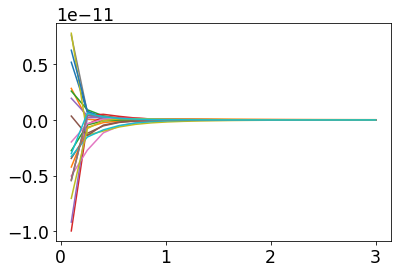

In [63]:
#plt.plot(all_z,F,"k-",lw=3)
for idx in np.arange(NSIM):
    plt.plot(all_z,F_gp[idx,:])
    
#plt.yscale("log")

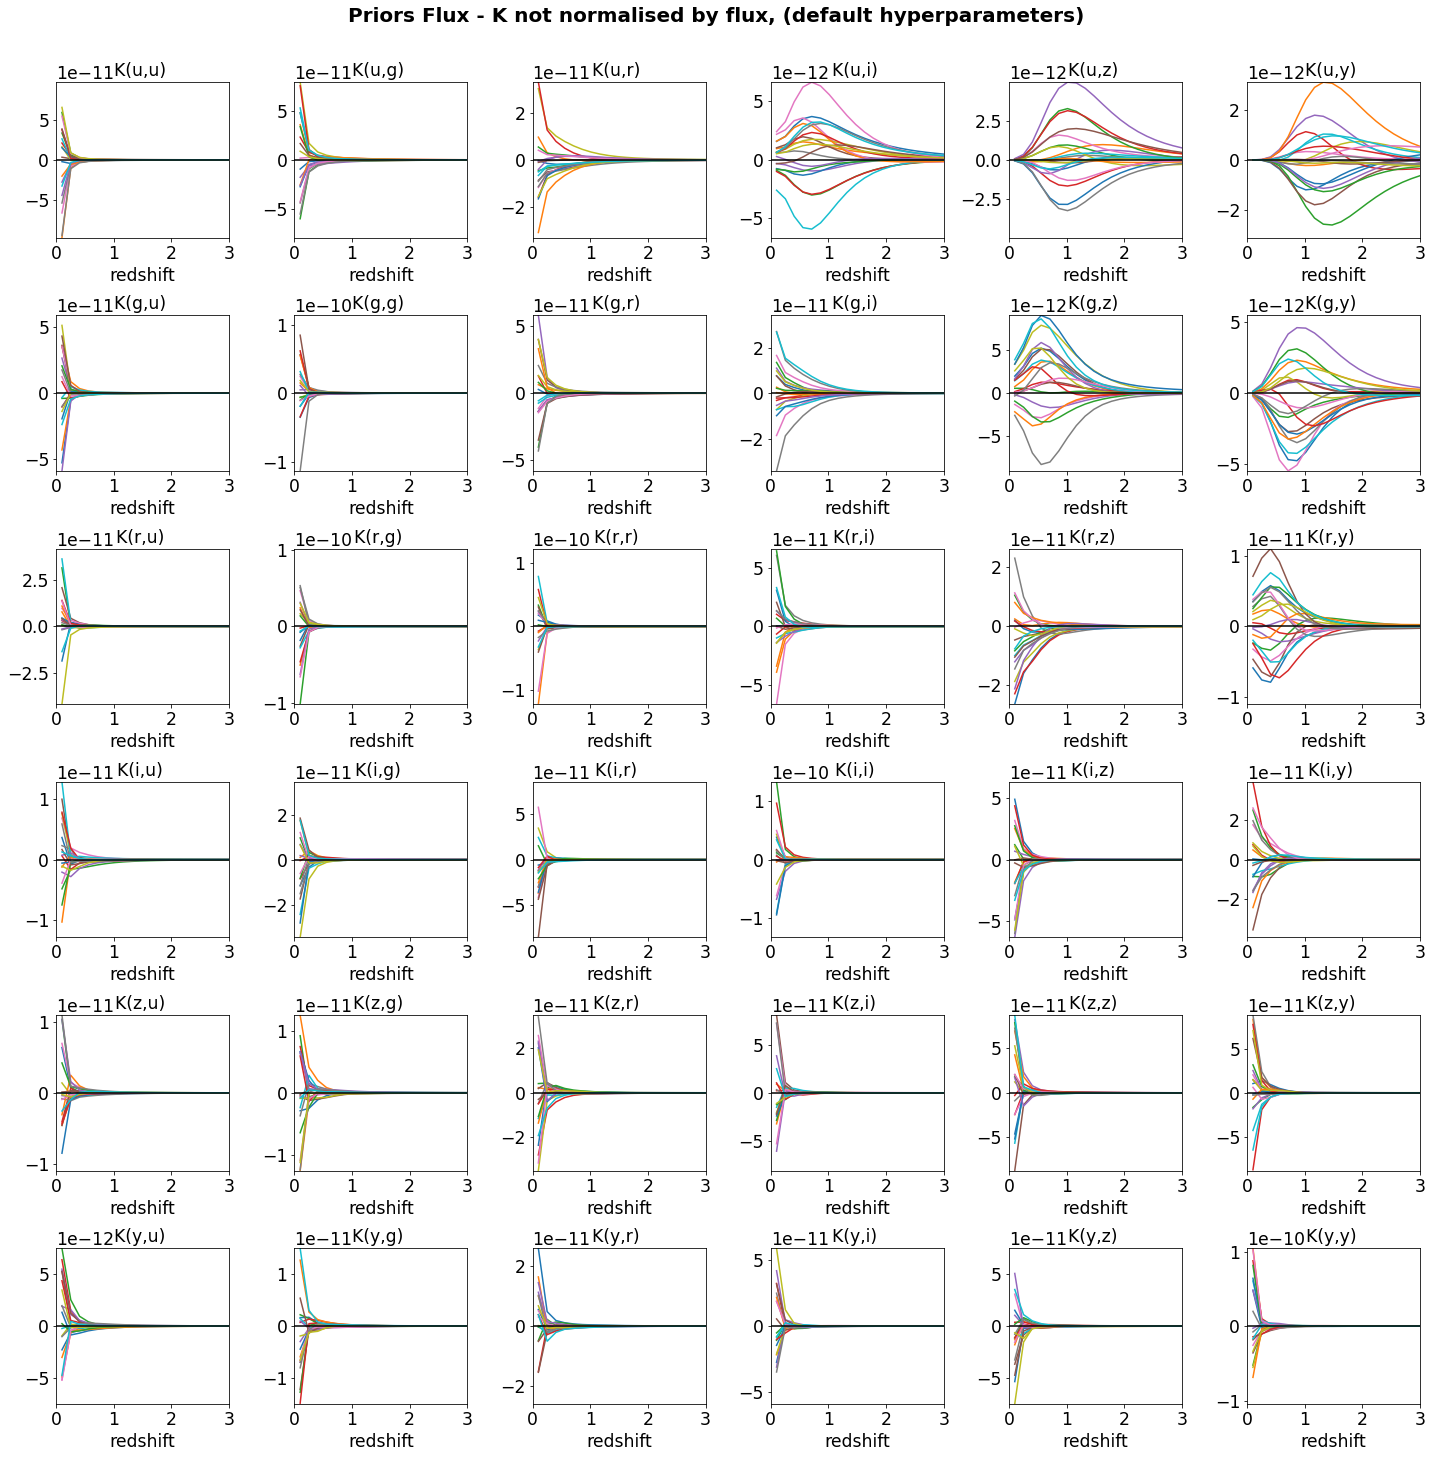

In [64]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color='k')
 
title = "Priors Flux - K not normalised by flux, (default hyperparameters)"
plt.suptitle(title,fontsize=20,y=1.01,fontweight="bold")
plt.tight_layout()      

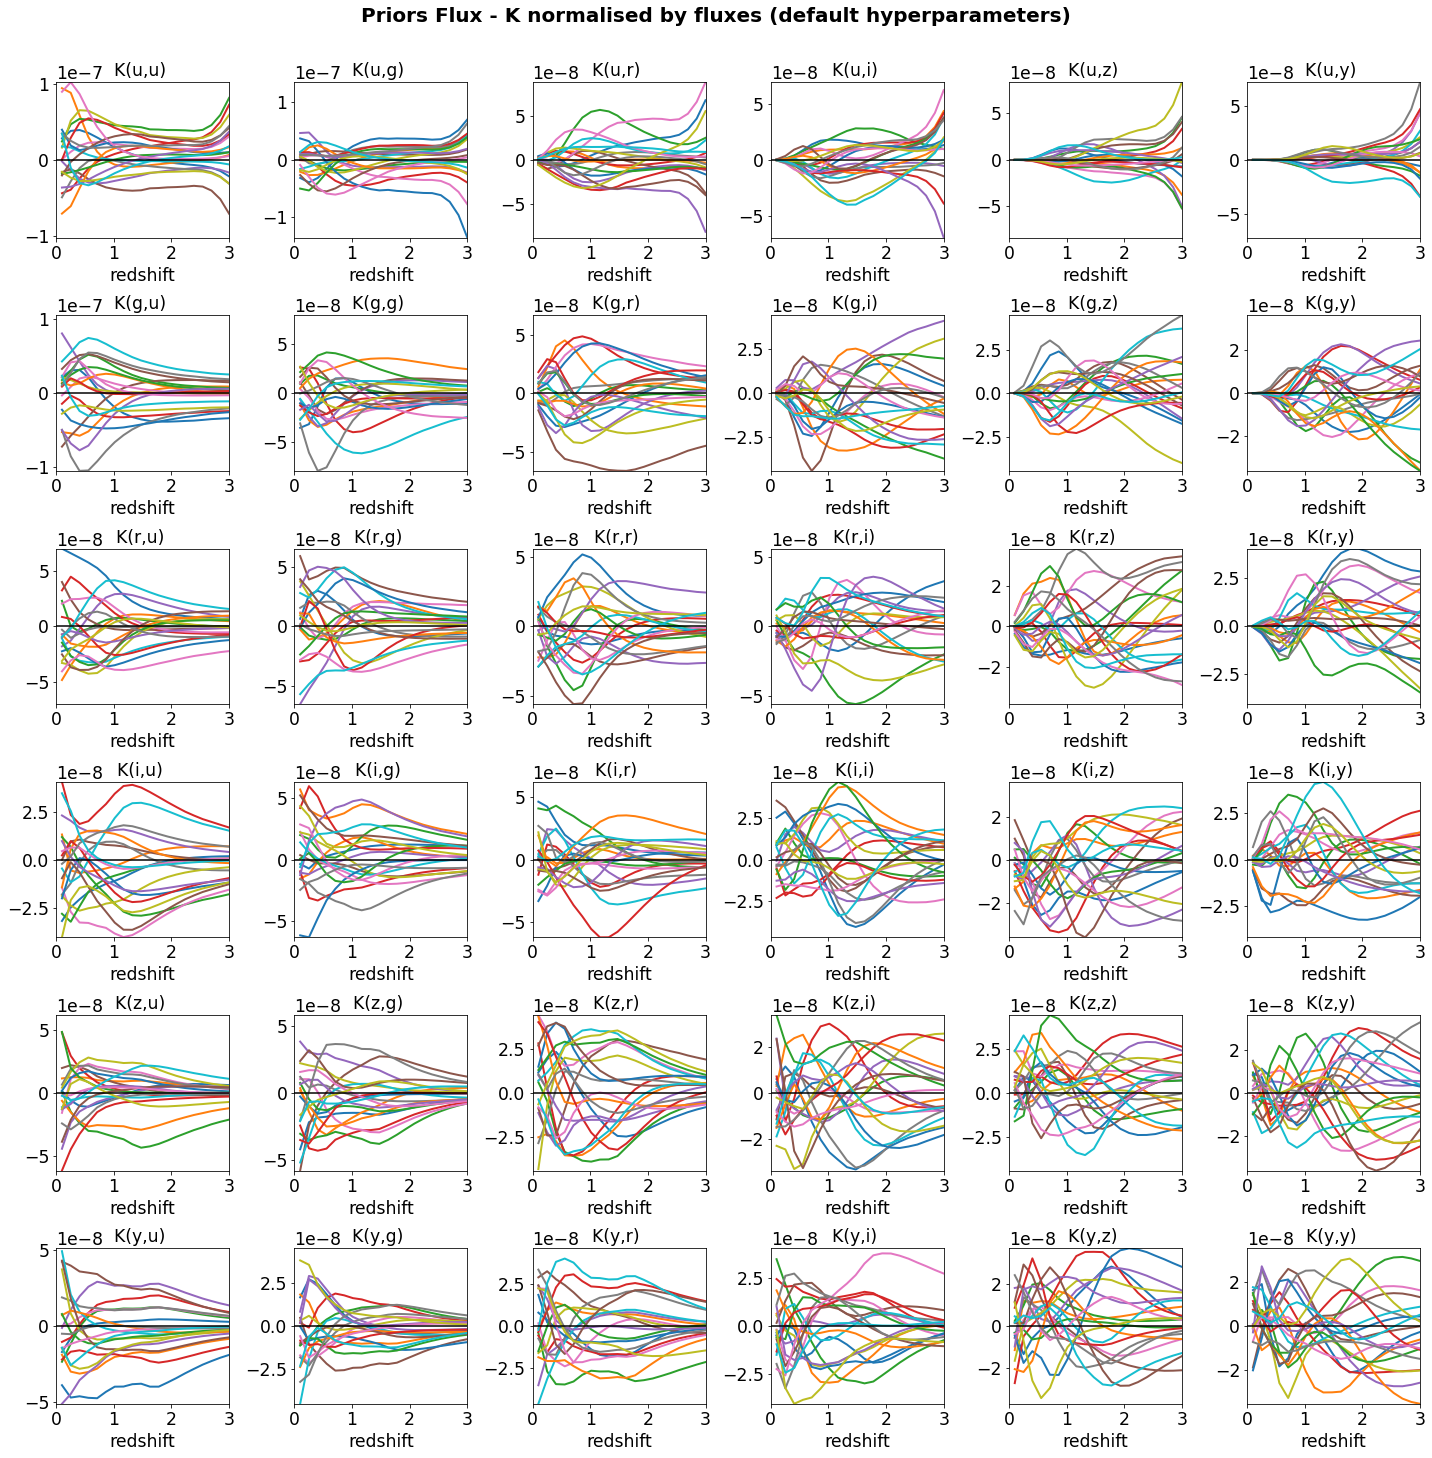

In [65]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")

title="Priors Flux - K normalised by fluxes (default hyperparameters)"        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()      

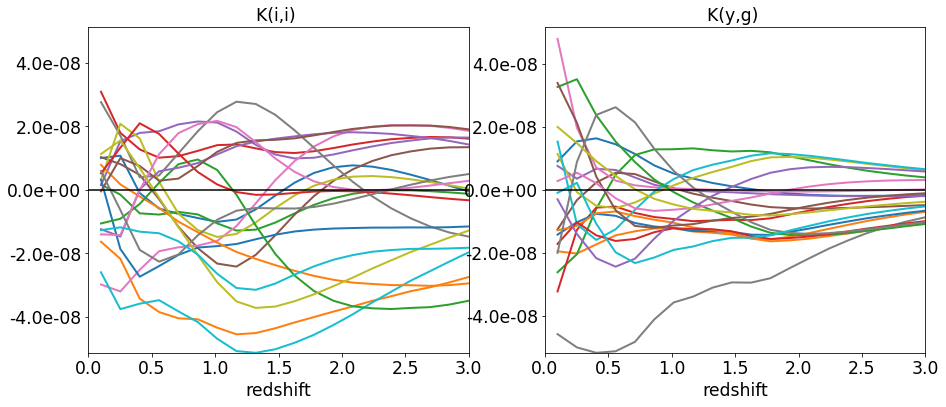

In [66]:
import matplotlib.ticker as ticker

fig=plt.figure(figsize=(15,6))
               
ax=fig.add_subplot(1,2,1)
ib1=3
ib2=3
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
F_gp_max=np.abs(F_gp).max()
for idx in np.arange(NSIM):
    ax.plot(all_z,F_gp[idx,:],lw=2)
ax.set_xlim(0,3)
ax.set_xlabel("redshift")
ax.set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
ax.set_ylim(-F_gp_max,F_gp_max)
ax.axhline(y=0,color="k")
# Rewrite the y labels
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1e'))


ax=fig.add_subplot(1,2,2)
ib1=1
ib2=5
Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
F_gp_max=np.abs(F_gp).max()
for idx in np.arange(NSIM):
    ax.plot(all_z,F_gp[idx,:],lw=2)
ax.set_xlim(0,3)
ax.set_xlabel("redshift")
ax.set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
ax.set_ylim(-F_gp_max,F_gp_max)
ax.axhline(y=0,color="k")
# Rewrite the y labels
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1e'))

## New parameters of Kernel 

In [67]:
V_L

0.1

In [68]:
V_L=10000

In [69]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              lines_pos, lines_width,
              V_C, V_L,alpha_C, alpha_L,
              redshiftGridGP, use_interpolators=True)

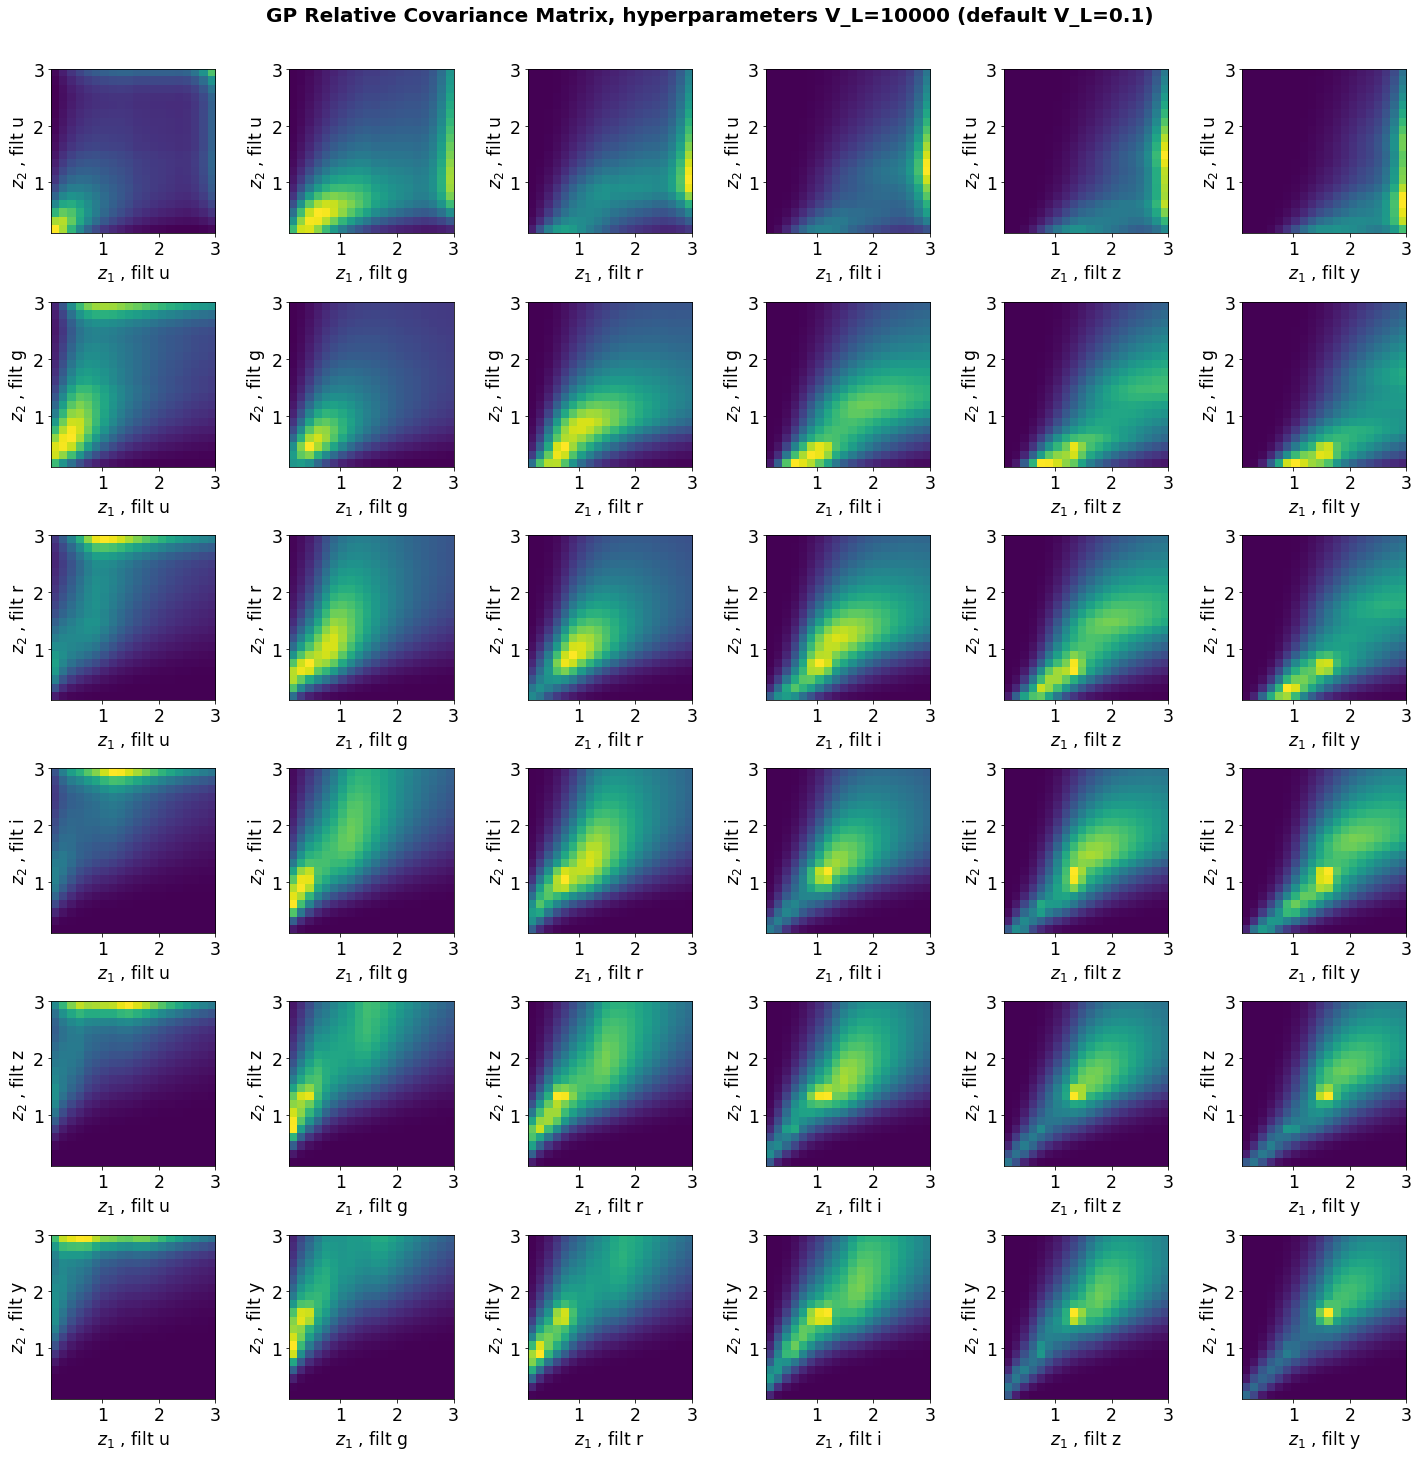

In [70]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
        
title="GP Relative Covariance Matrix, hyperparameters V_L={} (default V_L=0.1)".format(V_L)        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

## Marginal Likelihood

In [72]:
loc = -1
trainingDataIter1 = getDataFromFile(params, firstLine, lastLine, prefix="training_", getXY=True, CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
    X, Y, Yvar in trainingDataIter1:
    loc += 1
    #print( "Band={}, \nRedshift={}, \nEll={}".format(band_name[X[:,0]], X[:,1], X[:,2]) )
    gp.setData(X, Y, Yvar)
    kernelInterp = gp.kernel.use_interpolators
    gp.kernel.use_interpolators = False
    gp.optimizeHyperparamaters([V_C, alpha_C], verbose=True)
    gp.kernel.use_interpolators = kernelInterp
    print( "Loc = {}, Minimum Marginal Likelihood = {}, V_C = {}, alpha_C = {}".format(loc, gp.margLike(), gp.kernel.var_C, gp.kernel.alpha_C) )

Optimized parameters:  [1.31961211e-06 1.00000847e+03]
Loc = 0, Minimum Marginal Likelihood = 56.03809481799241, V_C = 1.319612113423964e-06, alpha_C = 1000.0084685632353
Optimized parameters:  [1.37570965e-06 1.00000807e+03]
Loc = 1, Minimum Marginal Likelihood = 34.43797374234687, V_C = 1.375709648054786e-06, alpha_C = 1000.0080714807069
Optimized parameters:  [1.80768796e-06 1.00000925e+03]
Loc = 2, Minimum Marginal Likelihood = 41.62434399789767, V_C = 1.8076879602847354e-06, alpha_C = 1000.0092530126481
Optimized parameters:  [1.23905648e-06 1.00000944e+03]
Loc = 3, Minimum Marginal Likelihood = 44.34903994431408, V_C = 1.239056476729544e-06, alpha_C = 1000.0094381307665
Optimized parameters:  [1.26205144e-06 1.00000827e+03]
Loc = 4, Minimum Marginal Likelihood = 32.61272482059564, V_C = 1.2620514426918425e-06, alpha_C = 1000.0082723876125
Optimized parameters:  [1.25363053e-06 1.00000914e+03]
Loc = 5, Minimum Marginal Likelihood = 23.569584819061646, V_C = 1.2536305329327605e-06,

Optimized parameters:  [1.18460198e-06 1.00001037e+03]
Loc = 48, Minimum Marginal Likelihood = 52.85205443510313, V_C = 1.184601983176959e-06, alpha_C = 1000.0103726652073
Optimized parameters:  [1.22079330e-06 1.00001013e+03]
Loc = 49, Minimum Marginal Likelihood = 41.04816260534853, V_C = 1.220793295698068e-06, alpha_C = 1000.0101292360235
Optimized parameters:  [9.46084920e-07 1.00001015e+03]
Loc = 50, Minimum Marginal Likelihood = 36.55550084383802, V_C = 9.460849198679634e-07, alpha_C = 1000.010151398554
Optimized parameters:  [1.18057255e-06 1.00001030e+03]
Loc = 51, Minimum Marginal Likelihood = 59.037597311089065, V_C = 1.1805725540300978e-06, alpha_C = 1000.0102991303136
Optimized parameters:  [9.06681554e-07 1.00001075e+03]
Loc = 52, Minimum Marginal Likelihood = 26.807705316311097, V_C = 9.066815536403691e-07, alpha_C = 1000.0107452064829
Optimized parameters:  [1.03174288e-06 1.00001029e+03]
Loc = 53, Minimum Marginal Likelihood = 23.184505484106523, V_C = 1.031742884169471

Optimized parameters:  [8.33571072e-07 1.00001348e+03]
Loc = 96, Minimum Marginal Likelihood = 38.002998742201804, V_C = 8.33571072401789e-07, alpha_C = 1000.0134833268102
Optimized parameters:  [8.90260303e-07 1.00001401e+03]
Loc = 97, Minimum Marginal Likelihood = 30.615662599523024, V_C = 8.90260302672092e-07, alpha_C = 1000.0140064568161
Optimized parameters:  [8.03685109e-07 1.00001254e+03]
Loc = 98, Minimum Marginal Likelihood = 23.5278078372103, V_C = 8.0368510883936e-07, alpha_C = 1000.012537242425
Optimized parameters:  [7.30394719e-07 1.00001346e+03]
Loc = 99, Minimum Marginal Likelihood = 38.377375419594316, V_C = 7.303947191500652e-07, alpha_C = 1000.0134610776175
Optimized parameters:  [8.15220830e-07 1.00001414e+03]
Loc = 100, Minimum Marginal Likelihood = 28.771988024403452, V_C = 8.152208303087918e-07, alpha_C = 1000.0141355695563
Optimized parameters:  [6.4929351e-07 1.0000131e+03]
Loc = 101, Minimum Marginal Likelihood = 23.748174496778553, V_C = 6.492935096975608e-07

Optimized parameters:  [6.41094996e-07 1.00001371e+03]
Loc = 144, Minimum Marginal Likelihood = 21.18058976076806, V_C = 6.410949955466175e-07, alpha_C = 1000.0137061034774
Optimized parameters:  [6.88764137e-07 1.00001459e+03]
Loc = 145, Minimum Marginal Likelihood = 19.26879293001643, V_C = 6.887641369928895e-07, alpha_C = 1000.0145906655049
Optimized parameters:  [5.85948849e-07 1.00001533e+03]
Loc = 146, Minimum Marginal Likelihood = 20.135039332807747, V_C = 5.859488490575827e-07, alpha_C = 1000.0153266261177
Optimized parameters:  [9.21509557e-07 1.00001323e+03]
Loc = 147, Minimum Marginal Likelihood = 39.50241830901536, V_C = 9.215095569750853e-07, alpha_C = 1000.0132317062539
Optimized parameters:  [7.22591503e-07 1.00001490e+03]
Loc = 148, Minimum Marginal Likelihood = 15.448187529541304, V_C = 7.225915025296813e-07, alpha_C = 1000.0149029515618
Optimized parameters:  [7.43003655e-07 1.00001411e+03]
Loc = 149, Minimum Marginal Likelihood = 19.230125639431893, V_C = 7.430036550

Optimized parameters:  [6.44927126e-07 1.00001380e+03]
Loc = 192, Minimum Marginal Likelihood = 30.786686257145437, V_C = 6.44927126492974e-07, alpha_C = 1000.0137970829768
Optimized parameters:  [7.35495717e-07 1.00001409e+03]
Loc = 193, Minimum Marginal Likelihood = 43.06978834146856, V_C = 7.35495717305086e-07, alpha_C = 1000.0140939664326
Optimized parameters:  [7.72063308e-07 1.00001455e+03]
Loc = 194, Minimum Marginal Likelihood = 31.08291536476375, V_C = 7.720633083592091e-07, alpha_C = 1000.0145521412003
Optimized parameters:  [7.46305309e-07 1.00001533e+03]
Loc = 195, Minimum Marginal Likelihood = 45.31352407977361, V_C = 7.463053092931411e-07, alpha_C = 1000.0153289094621
Optimized parameters:  [8.39596165e-07 1.00001474e+03]
Loc = 196, Minimum Marginal Likelihood = 45.20133845118849, V_C = 8.395961648254314e-07, alpha_C = 1000.0147444125272
Optimized parameters:  [5.75416254e-07 1.00001381e+03]
Loc = 197, Minimum Marginal Likelihood = 22.62166240318219, V_C = 5.7541625410007

Optimized parameters:  [7.95043241e-07 1.00001617e+03]
Loc = 240, Minimum Marginal Likelihood = 40.10242460730678, V_C = 7.950432413169799e-07, alpha_C = 1000.0161660012525
Optimized parameters:  [5.65089229e-07 1.00001520e+03]
Loc = 241, Minimum Marginal Likelihood = 14.77737975470398, V_C = 5.650892293399316e-07, alpha_C = 1000.0152027646816
Optimized parameters:  [5.55396619e-07 1.00001647e+03]
Loc = 242, Minimum Marginal Likelihood = 17.86524150440103, V_C = 5.553966192142239e-07, alpha_C = 1000.0164668169875
Optimized parameters:  [5.66012982e-07 1.00001646e+03]
Loc = 243, Minimum Marginal Likelihood = 24.7095686177709, V_C = 5.660129819807564e-07, alpha_C = 1000.0164579403119
Optimized parameters:  [4.74403919e-07 1.00001428e+03]
Loc = 244, Minimum Marginal Likelihood = 21.02379589453231, V_C = 4.7440391874251087e-07, alpha_C = 1000.0142805555087
Optimized parameters:  [4.56818839e-07 1.00001442e+03]
Loc = 245, Minimum Marginal Likelihood = 28.886936460749805, V_C = 4.56818838898

Optimized parameters:  [4.87374360e-07 1.00001469e+03]
Loc = 288, Minimum Marginal Likelihood = 22.227512349605178, V_C = 4.873743595835208e-07, alpha_C = 1000.0146865386907
Optimized parameters:  [6.94684466e-07 1.00001722e+03]
Loc = 289, Minimum Marginal Likelihood = 36.08637096385358, V_C = 6.946844661154631e-07, alpha_C = 1000.0172233315244
Optimized parameters:  [5.52820116e-07 1.00001578e+03]
Loc = 290, Minimum Marginal Likelihood = 28.954786968469712, V_C = 5.52820115704499e-07, alpha_C = 1000.0157843004718
Optimized parameters:  [4.96497645e-07 1.00001457e+03]
Loc = 291, Minimum Marginal Likelihood = 26.74811492716394, V_C = 4.964976445731952e-07, alpha_C = 1000.014568107164
Optimized parameters:  [5.72841539e-07 1.00001690e+03]
Loc = 292, Minimum Marginal Likelihood = 34.56563944635697, V_C = 5.728415391027776e-07, alpha_C = 1000.0169003544821
Optimized parameters:  [6.95228373e-07 1.00001650e+03]
Loc = 293, Minimum Marginal Likelihood = 37.984962468867764, V_C = 6.95228372681

Optimized parameters:  [6.18840280e-07 1.00001628e+03]
Loc = 336, Minimum Marginal Likelihood = 33.8774953550922, V_C = 6.188402800545013e-07, alpha_C = 1000.0162759729247
Optimized parameters:  [5.95812046e-07 1.00001701e+03]
Loc = 337, Minimum Marginal Likelihood = 29.403581708179082, V_C = 5.958120460840822e-07, alpha_C = 1000.0170058668301
Optimized parameters:  [4.56179300e-07 1.00001516e+03]
Loc = 338, Minimum Marginal Likelihood = 19.037589710500164, V_C = 4.561793001165251e-07, alpha_C = 1000.0151574234817
Optimized parameters:  [4.06560682e-07 1.00001575e+03]
Loc = 339, Minimum Marginal Likelihood = 23.008481372041675, V_C = 4.0656068228557387e-07, alpha_C = 1000.0157528849905
Optimized parameters:  [6.13517050e-07 1.00001635e+03]
Loc = 340, Minimum Marginal Likelihood = 37.098358931538975, V_C = 6.135170500195459e-07, alpha_C = 1000.0163458234581
Optimized parameters:  [5.38654433e-07 1.00001461e+03]
Loc = 341, Minimum Marginal Likelihood = 34.27830102749116, V_C = 5.38654432

Optimized parameters:  [5.76080562e-07 1.00001762e+03]
Loc = 384, Minimum Marginal Likelihood = 44.54840585428182, V_C = 5.760805623195072e-07, alpha_C = 1000.0176186086067
Optimized parameters:  [4.37120804e-07 1.00001785e+03]
Loc = 385, Minimum Marginal Likelihood = 24.512359304147417, V_C = 4.371208037306807e-07, alpha_C = 1000.0178539278069
Optimized parameters:  [5.57769538e-07 1.00001664e+03]
Loc = 386, Minimum Marginal Likelihood = 29.946061553253795, V_C = 5.577695380120668e-07, alpha_C = 1000.0166355695504
Optimized parameters:  [3.85263298e-07 1.00001543e+03]
Loc = 387, Minimum Marginal Likelihood = 16.163999564167863, V_C = 3.8526329827712827e-07, alpha_C = 1000.0154282835064
Optimized parameters:  [4.84369462e-07 1.00001559e+03]
Loc = 388, Minimum Marginal Likelihood = 24.37211045559612, V_C = 4.84369461803343e-07, alpha_C = 1000.0155947088948
Optimized parameters:  [5.98273186e-07 1.00001682e+03]
Loc = 389, Minimum Marginal Likelihood = 37.2878888300412, V_C = 5.9827318565

Optimized parameters:  [4.47073708e-07 1.00002313e+03]
Loc = 432, Minimum Marginal Likelihood = 29.781730115527676, V_C = 4.470737084753571e-07, alpha_C = 1000.0231333669077
Optimized parameters:  [5.50314873e-07 1.00002261e+03]
Loc = 433, Minimum Marginal Likelihood = 39.58284939541884, V_C = 5.503148725571007e-07, alpha_C = 1000.022605504212
Optimized parameters:  [3.51963379e-07 1.00002218e+03]
Loc = 434, Minimum Marginal Likelihood = 23.60333969795643, V_C = 3.519633788430988e-07, alpha_C = 1000.0221784852073
Optimized parameters:  [4.57422804e-07 1.00002018e+03]
Loc = 435, Minimum Marginal Likelihood = 15.87722028656929, V_C = 4.5742280435135e-07, alpha_C = 1000.0201762680251
Optimized parameters:  [3.72109218e-07 1.00002142e+03]
Loc = 436, Minimum Marginal Likelihood = 20.205985924743715, V_C = 3.721092181549756e-07, alpha_C = 1000.0214214852314
Optimized parameters:  [5.54925225e-07 1.00002220e+03]
Loc = 437, Minimum Marginal Likelihood = 37.823182919289344, V_C = 5.549252246943

Optimized parameters:  [3.70910772e-07 1.00001963e+03]
Loc = 480, Minimum Marginal Likelihood = 20.957042784594048, V_C = 3.7091077217532123e-07, alpha_C = 1000.0196318224715
Optimized parameters:  [4.52420321e-07 1.00002338e+03]
Loc = 481, Minimum Marginal Likelihood = 42.998500112783766, V_C = 4.524203206553406e-07, alpha_C = 1000.0233803039363
Optimized parameters:  [3.38025750e-07 1.00002311e+03]
Loc = 482, Minimum Marginal Likelihood = 23.498813070853654, V_C = 3.380257501668843e-07, alpha_C = 1000.0231088112847
Optimized parameters:  [3.61531954e-07 1.00002022e+03]
Loc = 483, Minimum Marginal Likelihood = 21.442122746259553, V_C = 3.615319544897915e-07, alpha_C = 1000.0202213031672
Optimized parameters:  [3.43899114e-07 1.00002344e+03]
Loc = 484, Minimum Marginal Likelihood = 27.320729850868382, V_C = 3.4389911389738563e-07, alpha_C = 1000.023436311117
Optimized parameters:  [3.65062462e-07 1.00002006e+03]
Loc = 485, Minimum Marginal Likelihood = 19.73940354260174, V_C = 3.650624

Optimized parameters:  [2.87815443e-07 1.00002284e+03]
Loc = 528, Minimum Marginal Likelihood = 26.214864179130778, V_C = 2.878154426556159e-07, alpha_C = 1000.0228430382349
Optimized parameters:  [2.59570252e-07 1.00002299e+03]
Loc = 529, Minimum Marginal Likelihood = 14.049072336182231, V_C = 2.5957025178322717e-07, alpha_C = 1000.0229888105652
Optimized parameters:  [3.18416570e-07 1.00002189e+03]
Loc = 530, Minimum Marginal Likelihood = 28.07820508319198, V_C = 3.1841657002449e-07, alpha_C = 1000.0218859228899
Optimized parameters:  [2.20850386e-07 1.00002559e+03]
Loc = 531, Minimum Marginal Likelihood = 16.056640035601237, V_C = 2.2085038562465558e-07, alpha_C = 1000.025590505639
Optimized parameters:  [3.30523893e-07 1.00002495e+03]
Loc = 532, Minimum Marginal Likelihood = 35.69006407304322, V_C = 3.3052389294194554e-07, alpha_C = 1000.0249516513084
Optimized parameters:  [3.97220708e-07 1.00002182e+03]
Loc = 533, Minimum Marginal Likelihood = 32.50058777170505, V_C = 3.972207083

Optimized parameters:  [2.97905896e-07 1.00002141e+03]
Loc = 576, Minimum Marginal Likelihood = 18.601379258484467, V_C = 2.9790589646968706e-07, alpha_C = 1000.021412570578
Optimized parameters:  [3.85344688e-07 1.00002663e+03]
Loc = 577, Minimum Marginal Likelihood = 38.78514921092478, V_C = 3.8534468755597346e-07, alpha_C = 1000.0266328986014
Optimized parameters:  [3.84006992e-07 1.00002575e+03]
Loc = 578, Minimum Marginal Likelihood = 34.771860878385176, V_C = 3.840069916025348e-07, alpha_C = 1000.025751061648
Optimized parameters:  [2.24596291e-07 1.00002428e+03]
Loc = 579, Minimum Marginal Likelihood = 16.82302379212583, V_C = 2.2459629126947642e-07, alpha_C = 1000.0242784927153
Optimized parameters:  [3.71633992e-07 1.00002402e+03]
Loc = 580, Minimum Marginal Likelihood = 29.717741838409687, V_C = 3.7163399244188097e-07, alpha_C = 1000.0240178629051
Optimized parameters:  [2.66130661e-07 1.00002752e+03]
Loc = 581, Minimum Marginal Likelihood = 28.727982859861893, V_C = 2.661306

Optimized parameters:  [2.66614549e-07 1.00002467e+03]
Loc = 624, Minimum Marginal Likelihood = 25.121277991700524, V_C = 2.666145494911664e-07, alpha_C = 1000.0246718867675
Optimized parameters:  [3.19697662e-07 1.00002636e+03]
Loc = 625, Minimum Marginal Likelihood = 32.42918600266106, V_C = 3.196976620552953e-07, alpha_C = 1000.0263605781305
Optimized parameters:  [2.29711091e-07 1.00002868e+03]
Loc = 626, Minimum Marginal Likelihood = 17.309763001514437, V_C = 2.2971109120379136e-07, alpha_C = 1000.0286843766247
Optimized parameters:  [3.57881547e-07 1.00002839e+03]
Loc = 627, Minimum Marginal Likelihood = 30.42540885209675, V_C = 3.578815467289994e-07, alpha_C = 1000.028389034116
Optimized parameters:  [3.80924558e-07 1.00002544e+03]
Loc = 628, Minimum Marginal Likelihood = 27.11781983261109, V_C = 3.809245578784872e-07, alpha_C = 1000.0254400122711
Optimized parameters:  [2.66939031e-07 1.00002801e+03]
Loc = 629, Minimum Marginal Likelihood = 16.72474489326675, V_C = 2.6693903142

Optimized parameters:  [4.58115624e-07 1.00002571e+03]
Loc = 672, Minimum Marginal Likelihood = 35.18577395936725, V_C = 4.5811562402404296e-07, alpha_C = 1000.0257068606321
Optimized parameters:  [2.86393048e-07 1.00002658e+03]
Loc = 673, Minimum Marginal Likelihood = 23.90603266672022, V_C = 2.8639304819460217e-07, alpha_C = 1000.0265813048028
Optimized parameters:  [1.74117175e-07 1.00002478e+03]
Loc = 674, Minimum Marginal Likelihood = 18.084484428963098, V_C = 1.741171752205439e-07, alpha_C = 1000.0247753792834
Optimized parameters:  [2.45114493e-07 1.00002697e+03]
Loc = 675, Minimum Marginal Likelihood = 25.512515285550744, V_C = 2.451144931099321e-07, alpha_C = 1000.0269692041145
Optimized parameters:  [1.76204245e-07 1.00002477e+03]
Loc = 676, Minimum Marginal Likelihood = 20.154448527277957, V_C = 1.762042453119059e-07, alpha_C = 1000.024771398223
Optimized parameters:  [3.04194094e-07 1.00002431e+03]
Loc = 677, Minimum Marginal Likelihood = 20.22818397707528, V_C = 3.04194093

Optimized parameters:  [2.75326137e-07 1.00002921e+03]
Loc = 720, Minimum Marginal Likelihood = 26.837432726613073, V_C = 2.7532613671670616e-07, alpha_C = 1000.0292146084856
Optimized parameters:  [2.25176142e-07 1.00002560e+03]
Loc = 721, Minimum Marginal Likelihood = 26.132112252062495, V_C = 2.2517614225162383e-07, alpha_C = 1000.0256034251244
Optimized parameters:  [2.41550787e-07 1.00002556e+03]
Loc = 722, Minimum Marginal Likelihood = 26.968667407495936, V_C = 2.4155078711227113e-07, alpha_C = 1000.0255592925679
Optimized parameters:  [2.36014848e-07 1.00003065e+03]
Loc = 723, Minimum Marginal Likelihood = 24.350428826377343, V_C = 2.3601484793612664e-07, alpha_C = 1000.0306466632607
Optimized parameters:  [2.75642200e-07 1.00002911e+03]
Loc = 724, Minimum Marginal Likelihood = 29.79109175698963, V_C = 2.7564220003282627e-07, alpha_C = 1000.0291107311402
Optimized parameters:  [3.53592875e-07 1.00002764e+03]
Loc = 725, Minimum Marginal Likelihood = 19.316372214368958, V_C = 3.53

Optimized parameters:  [3.03664021e-07 1.00002811e+03]
Loc = 768, Minimum Marginal Likelihood = 29.852187683061228, V_C = 3.0366402118643225e-07, alpha_C = 1000.0281125283819
Optimized parameters:  [2.30909627e-07 1.00002570e+03]
Loc = 769, Minimum Marginal Likelihood = 28.102536457410405, V_C = 2.3090962738287942e-07, alpha_C = 1000.0256972814026
Optimized parameters:  [1.79233679e-07 1.00002593e+03]
Loc = 770, Minimum Marginal Likelihood = 19.90887184188993, V_C = 1.7923367869085193e-07, alpha_C = 1000.0259250930961
Optimized parameters:  [2.26318001e-07 1.00002967e+03]
Loc = 771, Minimum Marginal Likelihood = 22.874033969540086, V_C = 2.26318000789917e-07, alpha_C = 1000.0296683666023
Optimized parameters:  [2.17274437e-07 1.00002929e+03]
Loc = 772, Minimum Marginal Likelihood = 20.739180729971793, V_C = 2.172744369025237e-07, alpha_C = 1000.0292925689288
Optimized parameters:  [2.29080199e-07 1.00002524e+03]
Loc = 773, Minimum Marginal Likelihood = 21.83835376092535, V_C = 2.290801

Optimized parameters:  [3.21142707e-07 1.00002685e+03]
Loc = 816, Minimum Marginal Likelihood = 31.668352455297903, V_C = 3.211427073354121e-07, alpha_C = 1000.026853027432
Optimized parameters:  [2.21450074e-07 1.00003125e+03]
Loc = 817, Minimum Marginal Likelihood = 17.70828483452099, V_C = 2.214500744588293e-07, alpha_C = 1000.0312513512027
Optimized parameters:  [2.98057225e-07 1.00002906e+03]
Loc = 818, Minimum Marginal Likelihood = 22.513076390891275, V_C = 2.980572252213088e-07, alpha_C = 1000.0290648063711
Optimized parameters:  [3.09207911e-07 1.00002986e+03]
Loc = 819, Minimum Marginal Likelihood = 27.695584101660607, V_C = 3.0920791061079857e-07, alpha_C = 1000.0298557607949
Optimized parameters:  [2.85879481e-07 1.00002629e+03]
Loc = 820, Minimum Marginal Likelihood = 23.90314778378258, V_C = 2.8587948070598686e-07, alpha_C = 1000.0262853080131
Optimized parameters:  [2.71954697e-07 1.00002814e+03]
Loc = 821, Minimum Marginal Likelihood = 18.852937203888693, V_C = 2.7195469

Optimized parameters:  [1.46827118e-07 1.00003165e+03]
Loc = 864, Minimum Marginal Likelihood = 14.387140706893508, V_C = 1.4682711779556923e-07, alpha_C = 1000.0316452272567
Optimized parameters:  [1.32986558e-07 1.00002860e+03]
Loc = 865, Minimum Marginal Likelihood = 12.456021056873855, V_C = 1.329865580789102e-07, alpha_C = 1000.0285990170067
Optimized parameters:  [2.36134217e-07 1.00002928e+03]
Loc = 866, Minimum Marginal Likelihood = 30.536467118525533, V_C = 2.3613421680794585e-07, alpha_C = 1000.0292779406493
Optimized parameters:  [2.83270055e-07 1.00002935e+03]
Loc = 867, Minimum Marginal Likelihood = 27.58519816901059, V_C = 2.8327005518528667e-07, alpha_C = 1000.0293493889488
Optimized parameters:  [2.15680544e-07 1.00003189e+03]
Loc = 868, Minimum Marginal Likelihood = 24.84694767680713, V_C = 2.1568054383605198e-07, alpha_C = 1000.0318899483594
Optimized parameters:  [2.70856428e-07 1.00003074e+03]
Loc = 869, Minimum Marginal Likelihood = 29.335646953666025, V_C = 2.7085

Optimized parameters:  [2.35867411e-07 1.00003203e+03]
Loc = 912, Minimum Marginal Likelihood = 25.694008468040966, V_C = 2.358674111482979e-07, alpha_C = 1000.0320260274173
Optimized parameters:  [2.73407005e-07 1.00002822e+03]
Loc = 913, Minimum Marginal Likelihood = 27.93888350038317, V_C = 2.7340700539805964e-07, alpha_C = 1000.0282188321248
Optimized parameters:  [1.78461301e-07 1.00002726e+03]
Loc = 914, Minimum Marginal Likelihood = 17.627818404227494, V_C = 1.7846130102064752e-07, alpha_C = 1000.0272555954953
Optimized parameters:  [1.88907826e-07 1.00002870e+03]
Loc = 915, Minimum Marginal Likelihood = 14.111850131007241, V_C = 1.8890782621658624e-07, alpha_C = 1000.0287009402215
Optimized parameters:  [2.79739767e-07 1.00003189e+03]
Loc = 916, Minimum Marginal Likelihood = 30.802143287568907, V_C = 2.797397674716777e-07, alpha_C = 1000.0318936407563
Optimized parameters:  [2.39084884e-07 1.00003101e+03]
Loc = 917, Minimum Marginal Likelihood = 23.85950971413275, V_C = 2.39084

Optimized parameters:  [1.89007413e-07 1.00002725e+03]
Loc = 960, Minimum Marginal Likelihood = 19.286736713415323, V_C = 1.890074128971757e-07, alpha_C = 1000.0272543322999
Optimized parameters:  [2.23099034e-07 1.00002840e+03]
Loc = 961, Minimum Marginal Likelihood = 13.535083082771997, V_C = 2.2309903396868024e-07, alpha_C = 1000.0284017184955
Optimized parameters:  [1.83848027e-07 1.00002856e+03]
Loc = 962, Minimum Marginal Likelihood = 12.277045145251613, V_C = 1.8384802678456012e-07, alpha_C = 1000.0285637849752
Optimized parameters:  [2.67025209e-07 1.00003140e+03]
Loc = 963, Minimum Marginal Likelihood = 17.90202013581675, V_C = 2.670252085203397e-07, alpha_C = 1000.0313967606905
Optimized parameters:  [2.39321398e-07 1.00002865e+03]
Loc = 964, Minimum Marginal Likelihood = 23.700237965211933, V_C = 2.3932139814134e-07, alpha_C = 1000.0286460439233
Optimized parameters:  [1.97230038e-07 1.00002820e+03]
Loc = 965, Minimum Marginal Likelihood = 26.207661588544852, V_C = 1.9723003

Optimized parameters:  [2.13954513e-07 1.00003295e+03]
Loc = 1008, Minimum Marginal Likelihood = 13.261510827611403, V_C = 2.139545125433658e-07, alpha_C = 1000.0329457381853
Optimized parameters:  [1.91967095e-07 1.00002782e+03]
Loc = 1009, Minimum Marginal Likelihood = 27.22686978778006, V_C = 1.9196709479348393e-07, alpha_C = 1000.0278214494626
Optimized parameters:  [1.72293299e-07 1.00003075e+03]
Loc = 1010, Minimum Marginal Likelihood = 23.31697418403373, V_C = 1.7229329923200046e-07, alpha_C = 1000.0307540871057
Optimized parameters:  [2.24662295e-07 1.00003072e+03]
Loc = 1011, Minimum Marginal Likelihood = 25.162294616236597, V_C = 2.246622954114481e-07, alpha_C = 1000.030722874614
Optimized parameters:  [2.13844214e-07 1.00002902e+03]
Loc = 1012, Minimum Marginal Likelihood = 25.732787039543076, V_C = 2.1384421364682345e-07, alpha_C = 1000.0290167998136
Optimized parameters:  [1.81994551e-07 1.00002817e+03]
Loc = 1013, Minimum Marginal Likelihood = 17.584760900494267, V_C = 1.

Optimized parameters:  [1.46331998e-07 1.00003040e+03]
Loc = 1055, Minimum Marginal Likelihood = 20.359605478545244, V_C = 1.4633199778828013e-07, alpha_C = 1000.0303996208403
Optimized parameters:  [1.49353219e-07 1.00002919e+03]
Loc = 1056, Minimum Marginal Likelihood = 21.367359097842062, V_C = 1.4935321937728396e-07, alpha_C = 1000.029186568118
Optimized parameters:  [1.27788966e-07 1.00003236e+03]
Loc = 1057, Minimum Marginal Likelihood = 25.17816102672989, V_C = 1.2778896606289677e-07, alpha_C = 1000.0323648312932
Optimized parameters:  [1.50818415e-07 1.00003220e+03]
Loc = 1058, Minimum Marginal Likelihood = 21.9377226083934, V_C = 1.5081841539903065e-07, alpha_C = 1000.0321982219937
Optimized parameters:  [1.56654972e-07 1.00003208e+03]
Loc = 1059, Minimum Marginal Likelihood = 16.26815546275152, V_C = 1.5665497220028454e-07, alpha_C = 1000.0320816346726
Optimized parameters:  [1.42138622e-07 1.00003392e+03]
Loc = 1060, Minimum Marginal Likelihood = 15.570552518786197, V_C = 1.

Optimized parameters:  [1.14302352e-07 1.00003357e+03]
Loc = 1102, Minimum Marginal Likelihood = 21.650859118569464, V_C = 1.1430235178852426e-07, alpha_C = 1000.0335742417049
Optimized parameters:  [1.07452902e-07 1.00003490e+03]
Loc = 1103, Minimum Marginal Likelihood = 12.22792451475709, V_C = 1.0745290189164983e-07, alpha_C = 1000.0348985866551
Optimized parameters:  [1.72517061e-07 1.00003138e+03]
Loc = 1104, Minimum Marginal Likelihood = 23.53440063703151, V_C = 1.7251706099993988e-07, alpha_C = 1000.0313843841373
Optimized parameters:  [1.25655773e-07 1.00003380e+03]
Loc = 1105, Minimum Marginal Likelihood = 9.661417069866244, V_C = 1.2565577261870348e-07, alpha_C = 1000.0337968273847
Optimized parameters:  [1.29265307e-07 1.00002865e+03]
Loc = 1106, Minimum Marginal Likelihood = 10.905651342909575, V_C = 1.2926530695462724e-07, alpha_C = 1000.0286489845807
Optimized parameters:  [1.50965307e-07 1.00003001e+03]
Loc = 1107, Minimum Marginal Likelihood = 9.582401798507242, V_C = 1

Optimized parameters:  [1.33713958e-07 1.00003363e+03]
Loc = 1149, Minimum Marginal Likelihood = 23.058793723083642, V_C = 1.3371395751180894e-07, alpha_C = 1000.0336284612421
Optimized parameters:  [1.08400951e-07 1.00003051e+03]
Loc = 1150, Minimum Marginal Likelihood = 25.830988734682787, V_C = 1.0840095082470848e-07, alpha_C = 1000.0305145302192
Optimized parameters:  [1.35347636e-07 1.00002855e+03]
Loc = 1151, Minimum Marginal Likelihood = 10.192305587216435, V_C = 1.3534763581163017e-07, alpha_C = 1000.0285523821736
Optimized parameters:  [1.35593564e-07 1.00003080e+03]
Loc = 1152, Minimum Marginal Likelihood = 17.62670347728139, V_C = 1.355935636282851e-07, alpha_C = 1000.0308023538026
Optimized parameters:  [1.24620811e-07 1.00003262e+03]
Loc = 1153, Minimum Marginal Likelihood = 20.17552136773101, V_C = 1.2462081082873173e-07, alpha_C = 1000.0326200587288
Optimized parameters:  [1.37926244e-07 1.00003596e+03]
Loc = 1154, Minimum Marginal Likelihood = 20.658077389118176, V_C = 

Optimized parameters:  [1.24188781e-07 1.00003449e+03]
Loc = 1196, Minimum Marginal Likelihood = 21.128607064049273, V_C = 1.241887809250894e-07, alpha_C = 1000.0344901584859
Optimized parameters:  [1.15095706e-07 1.00003401e+03]
Loc = 1197, Minimum Marginal Likelihood = 17.52353944862122, V_C = 1.150957059206402e-07, alpha_C = 1000.0340135801773
Optimized parameters:  [1.22344178e-07 1.00002948e+03]
Loc = 1198, Minimum Marginal Likelihood = 13.612432872654374, V_C = 1.2234417767608286e-07, alpha_C = 1000.0294827064135
Optimized parameters:  [1.12294464e-07 1.00003039e+03]
Loc = 1199, Minimum Marginal Likelihood = 20.499017585509304, V_C = 1.1229446353178794e-07, alpha_C = 1000.0303876518808
Optimized parameters:  [1.24526932e-07 1.00003501e+03]
Loc = 1200, Minimum Marginal Likelihood = 24.299310187861664, V_C = 1.2452693180730618e-07, alpha_C = 1000.0350079864971
Optimized parameters:  [1.69674993e-07 1.00003111e+03]
Loc = 1201, Minimum Marginal Likelihood = 25.52068252354135, V_C = 1

Optimized parameters:  [1.26394504e-07 1.00003545e+03]
Loc = 1243, Minimum Marginal Likelihood = 20.47618149619677, V_C = 1.26394503868296e-07, alpha_C = 1000.0354479526986
Optimized parameters:  [1.08516289e-07 1.00003013e+03]
Loc = 1244, Minimum Marginal Likelihood = 7.085051372653041, V_C = 1.0851628943447076e-07, alpha_C = 1000.0301260309747
Optimized parameters:  [1.53324631e-07 1.00003556e+03]
Loc = 1245, Minimum Marginal Likelihood = 15.25265439077798, V_C = 1.533246309873002e-07, alpha_C = 1000.0355632551114
Optimized parameters:  [1.29377787e-07 1.00003084e+03]
Loc = 1246, Minimum Marginal Likelihood = 20.16161708866215, V_C = 1.293777874675129e-07, alpha_C = 1000.0308413069918
Optimized parameters:  [1.28280084e-07 1.00003562e+03]
Loc = 1247, Minimum Marginal Likelihood = 15.538401334132452, V_C = 1.2828008384742234e-07, alpha_C = 1000.0356212002037
Optimized parameters:  [3.04192428e-07 1.00003454e+03]
Loc = 1248, Minimum Marginal Likelihood = 23.35193196492227, V_C = 3.0419

Optimized parameters:  [1.63702932e-07 1.00003461e+03]
Loc = 1290, Minimum Marginal Likelihood = 20.12063249557388, V_C = 1.637029322139784e-07, alpha_C = 1000.0346067971726
Optimized parameters:  [1.17065779e-07 1.00003397e+03]
Loc = 1291, Minimum Marginal Likelihood = 15.74246009994214, V_C = 1.1706577943581047e-07, alpha_C = 1000.0339748804431
Optimized parameters:  [1.50875100e-07 1.00003454e+03]
Loc = 1292, Minimum Marginal Likelihood = 15.690176390265645, V_C = 1.5087510013128296e-07, alpha_C = 1000.034537304387
Optimized parameters:  [1.46767299e-07 1.00003407e+03]
Loc = 1293, Minimum Marginal Likelihood = 20.99426428626656, V_C = 1.467672986685941e-07, alpha_C = 1000.0340659288851
Optimized parameters:  [1.09128193e-07 1.00003036e+03]
Loc = 1294, Minimum Marginal Likelihood = 10.645587655692559, V_C = 1.0912819318252669e-07, alpha_C = 1000.0303577743383
Optimized parameters:  [9.41917243e-08 1.00003573e+03]
Loc = 1295, Minimum Marginal Likelihood = 9.43478191419923, V_C = 9.419

Optimized parameters:  [1.01204063e-07 1.00003427e+03]
Loc = 1337, Minimum Marginal Likelihood = 12.724331486434021, V_C = 1.0120406341250634e-07, alpha_C = 1000.0342696706762
Optimized parameters:  [1.35598011e-07 1.00003359e+03]
Loc = 1338, Minimum Marginal Likelihood = 18.052487651138716, V_C = 1.3559801053221082e-07, alpha_C = 1000.0335904188411
Optimized parameters:  [1.08203313e-07 1.00003513e+03]
Loc = 1339, Minimum Marginal Likelihood = 17.1061384551067, V_C = 1.0820331301180256e-07, alpha_C = 1000.0351285932697
Optimized parameters:  [1.25198730e-07 1.00003451e+03]
Loc = 1340, Minimum Marginal Likelihood = 20.645542342918105, V_C = 1.2519873003849403e-07, alpha_C = 1000.0345127294104
Optimized parameters:  [1.07997900e-07 1.00003589e+03]
Loc = 1341, Minimum Marginal Likelihood = 21.980375130043022, V_C = 1.0799789966522298e-07, alpha_C = 1000.0358922457734
Optimized parameters:  [9.68313163e-08 1.00003361e+03]
Loc = 1342, Minimum Marginal Likelihood = 17.943468109273137, V_C =

Optimized parameters:  [1.73076972e-07 1.00003404e+03]
Loc = 1384, Minimum Marginal Likelihood = 16.079146695726575, V_C = 1.730769722413597e-07, alpha_C = 1000.0340418784106
Optimized parameters:  [1.90309956e-07 1.00003472e+03]
Loc = 1385, Minimum Marginal Likelihood = 15.39192050471577, V_C = 1.9030995645386642e-07, alpha_C = 1000.0347190133397
Optimized parameters:  [1.35386378e-07 1.00003678e+03]
Loc = 1386, Minimum Marginal Likelihood = 9.16691669932514, V_C = 1.3538637778706453e-07, alpha_C = 1000.0367845606188
Optimized parameters:  [1.48832149e-07 1.00003585e+03]
Loc = 1387, Minimum Marginal Likelihood = 17.069162865710005, V_C = 1.4883214922807816e-07, alpha_C = 1000.0358521239729
Optimized parameters:  [3.03215895e-07 1.00003697e+03]
Loc = 1388, Minimum Marginal Likelihood = 24.713636112074944, V_C = 3.032158953147891e-07, alpha_C = 1000.0369667094589
Optimized parameters:  [1.77550809e-07 1.00003208e+03]
Loc = 1389, Minimum Marginal Likelihood = 18.67960027974376, V_C = 1.7

Optimized parameters:  [2.69504827e-07 1.00003370e+03]
Loc = 1431, Minimum Marginal Likelihood = 21.470278913881128, V_C = 2.6950482733643403e-07, alpha_C = 1000.0336952741271
Optimized parameters:  [1.08737005e-07 1.00003753e+03]
Loc = 1432, Minimum Marginal Likelihood = 10.200390718559515, V_C = 1.0873700523420757e-07, alpha_C = 1000.0375276522689
Optimized parameters:  [1.08259688e-07 1.00003559e+03]
Loc = 1433, Minimum Marginal Likelihood = 13.255958934761715, V_C = 1.0825968814369312e-07, alpha_C = 1000.0355949830462
Optimized parameters:  [3.87510529e-07 1.00003479e+03]
Loc = 1434, Minimum Marginal Likelihood = 22.507650676700177, V_C = 3.8751052876080533e-07, alpha_C = 1000.0347932821745
Optimized parameters:  [1.13926319e-07 1.00003530e+03]
Loc = 1435, Minimum Marginal Likelihood = 19.135876762897073, V_C = 1.1392631902736311e-07, alpha_C = 1000.0352976346007
Optimized parameters:  [2.37630035e-07 1.00003107e+03]
Loc = 1436, Minimum Marginal Likelihood = 21.596565933080385, V_C

Optimized parameters:  [1.28940645e-07 1.00003451e+03]
Loc = 1478, Minimum Marginal Likelihood = 20.13016979786127, V_C = 1.2894064484766562e-07, alpha_C = 1000.0345056265526
Optimized parameters:  [2.98661298e-07 1.00003026e+03]
Loc = 1479, Minimum Marginal Likelihood = 24.85095625350673, V_C = 2.9866129797744367e-07, alpha_C = 1000.0302576433282
Optimized parameters:  [2.08209308e-07 1.00003486e+03]
Loc = 1480, Minimum Marginal Likelihood = 27.233131708527864, V_C = 2.082093081185268e-07, alpha_C = 1000.0348566135816
Optimized parameters:  [1.7895256e-07 1.0000363e+03]
Loc = 1481, Minimum Marginal Likelihood = 17.55216278073337, V_C = 1.7895255969541957e-07, alpha_C = 1000.0363044090983
Optimized parameters:  [1.47195634e-07 1.00003618e+03]
Loc = 1482, Minimum Marginal Likelihood = 11.417821069284482, V_C = 1.4719563374368258e-07, alpha_C = 1000.0361818122103
Optimized parameters:  [1.65401010e-07 1.00003104e+03]
Loc = 1483, Minimum Marginal Likelihood = 13.244702610310991, V_C = 1.6

Optimized parameters:  [5.26404723e-07 1.00003417e+03]
Loc = 1525, Minimum Marginal Likelihood = 17.707730299238726, V_C = 5.264047225433082e-07, alpha_C = 1000.0341735332873
Optimized parameters:  [3.27792025e-07 1.00003039e+03]
Loc = 1526, Minimum Marginal Likelihood = 18.224252120575706, V_C = 3.2779202490719646e-07, alpha_C = 1000.0303932346498
Optimized parameters:  [1.75025206e-07 1.00003121e+03]
Loc = 1527, Minimum Marginal Likelihood = 13.369470729621678, V_C = 1.750252059756402e-07, alpha_C = 1000.0312067808346
Optimized parameters:  [4.81502084e-07 1.00003175e+03]
Loc = 1528, Minimum Marginal Likelihood = 17.49431630572657, V_C = 4.81502083562924e-07, alpha_C = 1000.0317544357594
Optimized parameters:  [3.29123920e-07 1.00003494e+03]
Loc = 1529, Minimum Marginal Likelihood = 19.484646244004225, V_C = 3.2912391977481105e-07, alpha_C = 1000.0349392375944
Optimized parameters:  [2.15747327e-07 1.00003411e+03]
Loc = 1530, Minimum Marginal Likelihood = 14.526763317499789, V_C = 2.

Optimized parameters:  [2.32977889e-07 1.00003672e+03]
Loc = 1572, Minimum Marginal Likelihood = 18.37267643575097, V_C = 2.3297788949933921e-07, alpha_C = 1000.0367226397078
Optimized parameters:  [3.81405806e-07 1.00003451e+03]
Loc = 1573, Minimum Marginal Likelihood = 14.198546804195821, V_C = 3.8140580631428343e-07, alpha_C = 1000.0345120239762
Optimized parameters:  [3.03691045e-07 1.00003281e+03]
Loc = 1574, Minimum Marginal Likelihood = 20.298816257736117, V_C = 3.0369104451073404e-07, alpha_C = 1000.0328114421736
Optimized parameters:  [1.30403113e-07 1.00003264e+03]
Loc = 1575, Minimum Marginal Likelihood = 9.273378577835764, V_C = 1.3040311306769997e-07, alpha_C = 1000.0326408711011
Optimized parameters:  [1.14539506e-07 1.00003375e+03]
Loc = 1576, Minimum Marginal Likelihood = 10.419579364839116, V_C = 1.1453950584110968e-07, alpha_C = 1000.0337451973254
Optimized parameters:  [2.40949382e-07 1.00003440e+03]
Loc = 1577, Minimum Marginal Likelihood = 14.793711538643464, V_C =

Optimized parameters:  [1.46566901e-07 1.00003573e+03]
Loc = 1619, Minimum Marginal Likelihood = 27.623679454133026, V_C = 1.4656690114577858e-07, alpha_C = 1000.0357258331645
Optimized parameters:  [1.68081320e-07 1.00003251e+03]
Loc = 1620, Minimum Marginal Likelihood = 24.10013761091658, V_C = 1.680813201216071e-07, alpha_C = 1000.032507402928
Optimized parameters:  [1.76006112e-07 1.00003759e+03]
Loc = 1621, Minimum Marginal Likelihood = 14.359021206588054, V_C = 1.7600611195752035e-07, alpha_C = 1000.0375860262162
Optimized parameters:  [2.94544794e-07 1.00003722e+03]
Loc = 1622, Minimum Marginal Likelihood = 18.719914730158536, V_C = 2.945447935633892e-07, alpha_C = 1000.0372160635482
Optimized parameters:  [3.23751988e-07 1.00003305e+03]
Loc = 1623, Minimum Marginal Likelihood = 11.895480761361299, V_C = 3.237519875354751e-07, alpha_C = 1000.0330460615764
Optimized parameters:  [9.8382564e-08 1.0000360e+03]
Loc = 1624, Minimum Marginal Likelihood = 7.527636594167363, V_C = 9.838

Optimized parameters:  [1.65440358e-07 1.00003209e+03]
Loc = 1666, Minimum Marginal Likelihood = 12.676909147052886, V_C = 1.6544035784242313e-07, alpha_C = 1000.0320869538696
Optimized parameters:  [2.09276360e-07 1.00003515e+03]
Loc = 1667, Minimum Marginal Likelihood = 20.274431120999324, V_C = 2.0927635975911975e-07, alpha_C = 1000.0351508680886
Optimized parameters:  [2.05942625e-07 1.00003100e+03]
Loc = 1668, Minimum Marginal Likelihood = 25.286182592752034, V_C = 2.0594262530526167e-07, alpha_C = 1000.0309954564511
Optimized parameters:  [2.29201903e-07 1.00003669e+03]
Loc = 1669, Minimum Marginal Likelihood = 21.56181020064036, V_C = 2.2920190282487206e-07, alpha_C = 1000.0366897310756
Optimized parameters:  [3.33973137e-07 1.00003182e+03]
Loc = 1670, Minimum Marginal Likelihood = 17.15902398128484, V_C = 3.339731365682537e-07, alpha_C = 1000.0318177410569
Optimized parameters:  [2.52996918e-07 1.00003380e+03]
Loc = 1671, Minimum Marginal Likelihood = 14.35537675606352, V_C = 2

Optimized parameters:  [2.29689509e-07 1.00003404e+03]
Loc = 1713, Minimum Marginal Likelihood = 14.410866357239215, V_C = 2.2968950904206215e-07, alpha_C = 1000.0340418087787
Optimized parameters:  [3.14576100e-07 1.00003528e+03]
Loc = 1714, Minimum Marginal Likelihood = 20.51168334143702, V_C = 3.1457609982843696e-07, alpha_C = 1000.0352806572481
Optimized parameters:  [1.26222790e-07 1.00003261e+03]
Loc = 1715, Minimum Marginal Likelihood = 12.696881494149071, V_C = 1.2622279007081623e-07, alpha_C = 1000.0326115353902
Optimized parameters:  [3.06655813e-07 1.00003118e+03]
Loc = 1716, Minimum Marginal Likelihood = 16.191003218186243, V_C = 3.066558130331051e-07, alpha_C = 1000.031184290831
Optimized parameters:  [3.56573764e-07 1.00003163e+03]
Loc = 1717, Minimum Marginal Likelihood = 16.39523992697101, V_C = 3.5657376396521635e-07, alpha_C = 1000.031631262491
Optimized parameters:  [2.19353688e-07 1.00003297e+03]
Loc = 1718, Minimum Marginal Likelihood = 13.490625247206378, V_C = 2.

Optimized parameters:  [6.16237904e-07 1.00003285e+03]
Loc = 1760, Minimum Marginal Likelihood = 20.75730815447307, V_C = 6.16237904254353e-07, alpha_C = 1000.0328547552406
Optimized parameters:  [2.21616117e-07 1.00003515e+03]
Loc = 1761, Minimum Marginal Likelihood = 21.691929490854182, V_C = 2.2161611650641473e-07, alpha_C = 1000.035149794865
Optimized parameters:  [2.50425993e-07 1.00003352e+03]
Loc = 1762, Minimum Marginal Likelihood = 27.75543622527743, V_C = 2.504259932781125e-07, alpha_C = 1000.0335150330627
Optimized parameters:  [5.91409504e-07 1.00003124e+03]
Loc = 1763, Minimum Marginal Likelihood = 16.595071348116512, V_C = 5.91409504089756e-07, alpha_C = 1000.031241337708
Optimized parameters:  [7.71949195e-07 1.00002736e+03]
Loc = 1764, Minimum Marginal Likelihood = 14.118321519494195, V_C = 7.719491951793392e-07, alpha_C = 1000.0273636369755
Optimized parameters:  [5.38363178e-07 1.00003338e+03]
Loc = 1765, Minimum Marginal Likelihood = 20.05540474654846, V_C = 5.383631

Optimized parameters:  [3.84781438e-07 1.00003291e+03]
Loc = 1807, Minimum Marginal Likelihood = 13.950484289415524, V_C = 3.8478143823694355e-07, alpha_C = 1000.0329121851158
Optimized parameters:  [8.52462667e-07 1.00003113e+03]
Loc = 1808, Minimum Marginal Likelihood = 21.59144032948958, V_C = 8.524626672583443e-07, alpha_C = 1000.0311258437338
Optimized parameters:  [4.93577575e-07 1.00003602e+03]
Loc = 1809, Minimum Marginal Likelihood = 18.03694564070849, V_C = 4.935775747444877e-07, alpha_C = 1000.0360194338352
Optimized parameters:  [1.08507390e-06 1.00002754e+03]
Loc = 1810, Minimum Marginal Likelihood = 17.806665359983988, V_C = 1.0850739048077992e-06, alpha_C = 1000.0275388656655
Optimized parameters:  [6.74832581e-07 1.00003111e+03]
Loc = 1811, Minimum Marginal Likelihood = 14.566337626211158, V_C = 6.748325806462662e-07, alpha_C = 1000.0311121550251
Optimized parameters:  [4.86733985e-07 1.00003193e+03]
Loc = 1812, Minimum Marginal Likelihood = 16.152089845110083, V_C = 4.

Optimized parameters:  [1.47635492e-07 1.00003259e+03]
Loc = 1854, Minimum Marginal Likelihood = 9.560069803039276, V_C = 1.4763549172881112e-07, alpha_C = 1000.0325893568967
Optimized parameters:  [7.29807912e-07 1.00003126e+03]
Loc = 1855, Minimum Marginal Likelihood = 23.17129591495774, V_C = 7.298079123159554e-07, alpha_C = 1000.0312586032585
Optimized parameters:  [2.60104518e-07 1.00003531e+03]
Loc = 1856, Minimum Marginal Likelihood = 17.97338377281034, V_C = 2.6010451786332296e-07, alpha_C = 1000.0353117253584
Optimized parameters:  [5.91860130e-07 1.00003445e+03]
Loc = 1857, Minimum Marginal Likelihood = 18.516024672826337, V_C = 5.918601296011337e-07, alpha_C = 1000.034448676839
Optimized parameters:  [8.60474746e-07 1.00003079e+03]
Loc = 1858, Minimum Marginal Likelihood = 19.219537711175835, V_C = 8.604747463123444e-07, alpha_C = 1000.0307911775111
Optimized parameters:  [8.42376477e-07 1.00002991e+03]
Loc = 1859, Minimum Marginal Likelihood = 18.62066564532963, V_C = 8.423

Optimized parameters:  [1.89915501e-07 1.00003409e+03]
Loc = 1901, Minimum Marginal Likelihood = 12.810435049416226, V_C = 1.8991550100636557e-07, alpha_C = 1000.0340875475605
Optimized parameters:  [7.75741491e-07 1.00003038e+03]
Loc = 1902, Minimum Marginal Likelihood = 17.058149469592397, V_C = 7.757414910942288e-07, alpha_C = 1000.0303803956465
Optimized parameters:  [4.81028400e-07 1.00003403e+03]
Loc = 1903, Minimum Marginal Likelihood = 16.473469422935697, V_C = 4.810284004724669e-07, alpha_C = 1000.0340316474407
Optimized parameters:  [2.45719908e-07 1.00003732e+03]
Loc = 1904, Minimum Marginal Likelihood = 21.498490110239686, V_C = 2.457199076153291e-07, alpha_C = 1000.0373151299616
Optimized parameters:  [3.15214354e-07 1.00003255e+03]
Loc = 1905, Minimum Marginal Likelihood = 22.101165971619658, V_C = 3.1521435381044376e-07, alpha_C = 1000.032553959026
Optimized parameters:  [3.56210202e-07 1.00003690e+03]
Loc = 1906, Minimum Marginal Likelihood = 15.531197013689724, V_C = 3

Optimized parameters:  [7.25248404e-07 1.00002910e+03]
Loc = 1948, Minimum Marginal Likelihood = 16.814472923158853, V_C = 7.25248403723044e-07, alpha_C = 1000.0290999202342
Optimized parameters:  [3.30419711e-07 1.00003605e+03]
Loc = 1949, Minimum Marginal Likelihood = 14.394936149121811, V_C = 3.304197110551111e-07, alpha_C = 1000.0360521759428
Optimized parameters:  [7.23408518e-07 1.00003037e+03]
Loc = 1950, Minimum Marginal Likelihood = 14.812616317444913, V_C = 7.234085178458425e-07, alpha_C = 1000.0303700583223
Optimized parameters:  [2.97462776e-07 1.00003076e+03]
Loc = 1951, Minimum Marginal Likelihood = 14.150626806018487, V_C = 2.974627762541717e-07, alpha_C = 1000.0307551619871
Optimized parameters:  [6.84060093e-07 1.00003112e+03]
Loc = 1952, Minimum Marginal Likelihood = 15.995944460566356, V_C = 6.840600931499714e-07, alpha_C = 1000.0311158905272
Optimized parameters:  [2.55318054e-07 1.00003585e+03]
Loc = 1953, Minimum Marginal Likelihood = 11.662941938500332, V_C = 2.5

Optimized parameters:  [5.64152236e-07 1.00003458e+03]
Loc = 1995, Minimum Marginal Likelihood = 23.89856357786295, V_C = 5.641522364948898e-07, alpha_C = 1000.0345810228471
Optimized parameters:  [1.00087995e-06 1.00002957e+03]
Loc = 1996, Minimum Marginal Likelihood = 17.5891710960477, V_C = 1.000879946840182e-06, alpha_C = 1000.0295739727776
Optimized parameters:  [6.56167139e-07 1.00003092e+03]
Loc = 1997, Minimum Marginal Likelihood = 16.378857777962576, V_C = 6.561671385672392e-07, alpha_C = 1000.0309223563073
Optimized parameters:  [1.00204188e-06 1.00002921e+03]
Loc = 1998, Minimum Marginal Likelihood = 22.056643108896456, V_C = 1.0020418782210931e-06, alpha_C = 1000.02920525153
Optimized parameters:  [4.18997830e-07 1.00003464e+03]
Loc = 1999, Minimum Marginal Likelihood = 26.988106486933045, V_C = 4.189978295095722e-07, alpha_C = 1000.0346354022954
Optimized parameters:  [5.59680291e-07 1.00003057e+03]
Loc = 2000, Minimum Marginal Likelihood = 15.012498909717017, V_C = 5.5968

Optimized parameters:  [3.03166621e-07 1.00003226e+03]
Loc = 2042, Minimum Marginal Likelihood = 22.901146464743, V_C = 3.031666213922513e-07, alpha_C = 1000.0322558287533
Optimized parameters:  [4.48253097e-07 1.00003698e+03]
Loc = 2043, Minimum Marginal Likelihood = 27.30516961161903, V_C = 4.4825309689068634e-07, alpha_C = 1000.036975847689
Optimized parameters:  [9.21090575e-07 1.00002933e+03]
Loc = 2044, Minimum Marginal Likelihood = 19.50459652732548, V_C = 9.210905745738506e-07, alpha_C = 1000.0293321941234
Optimized parameters:  [2.05719799e-07 1.00003397e+03]
Loc = 2045, Minimum Marginal Likelihood = 21.177330411516117, V_C = 2.0571979930100375e-07, alpha_C = 1000.033971579778
Optimized parameters:  [1.20771668e-07 1.00003871e+03]
Loc = 2046, Minimum Marginal Likelihood = 9.675205848174027, V_C = 1.2077166836570603e-07, alpha_C = 1000.0387126145785
Optimized parameters:  [3.55297250e-07 1.00003312e+03]
Loc = 2047, Minimum Marginal Likelihood = 19.761006029502724, V_C = 3.55297

Optimized parameters:  [5.09459257e-07 1.00002762e+03]
Loc = 2089, Minimum Marginal Likelihood = 12.854453776682497, V_C = 5.09459256767315e-07, alpha_C = 1000.0276150528168
Optimized parameters:  [4.69311371e-07 1.00002882e+03]
Loc = 2090, Minimum Marginal Likelihood = 11.38175083245918, V_C = 4.6931137067633347e-07, alpha_C = 1000.0288239628989
Optimized parameters:  [6.85302538e-07 1.00003116e+03]
Loc = 2091, Minimum Marginal Likelihood = 15.223583499992667, V_C = 6.853025377970625e-07, alpha_C = 1000.031161079566
Optimized parameters:  [1.60475837e-06 1.00002780e+03]
Loc = 2092, Minimum Marginal Likelihood = 19.69957346842963, V_C = 1.6047583726987264e-06, alpha_C = 1000.0278004900662
Optimized parameters:  [1.66413095e-07 1.00003348e+03]
Loc = 2093, Minimum Marginal Likelihood = 10.234400092920204, V_C = 1.6641309548647066e-07, alpha_C = 1000.0334846196467
Optimized parameters:  [4.89225524e-07 1.00003333e+03]
Loc = 2094, Minimum Marginal Likelihood = 29.036879502159476, V_C = 4.8

Optimized parameters:  [4.20747726e-07 1.00002994e+03]
Loc = 2136, Minimum Marginal Likelihood = 13.465277502933773, V_C = 4.207477259911771e-07, alpha_C = 1000.029936881737
Optimized parameters:  [9.72764666e-07 1.00003136e+03]
Loc = 2137, Minimum Marginal Likelihood = 22.54680505227673, V_C = 9.727646664214067e-07, alpha_C = 1000.0313563009213
Optimized parameters:  [3.88812217e-07 1.00003399e+03]
Loc = 2138, Minimum Marginal Likelihood = 22.915136994280928, V_C = 3.8881221652921045e-07, alpha_C = 1000.0339946312739
Optimized parameters:  [5.19780148e-07 1.00003161e+03]
Loc = 2139, Minimum Marginal Likelihood = 14.684184714252964, V_C = 5.197801483435979e-07, alpha_C = 1000.0316129805183
Optimized parameters:  [3.67096986e-07 1.00003366e+03]
Loc = 2140, Minimum Marginal Likelihood = 12.62345405053733, V_C = 3.670969859006874e-07, alpha_C = 1000.0336645812317
Optimized parameters:  [1.00522194e-06 1.00003087e+03]
Loc = 2141, Minimum Marginal Likelihood = 18.60742260167399, V_C = 1.005

Optimized parameters:  [4.55195973e-07 1.00002868e+03]
Loc = 2183, Minimum Marginal Likelihood = 14.760900917705463, V_C = 4.5519597281097025e-07, alpha_C = 1000.0286793896234
Optimized parameters:  [1.17545878e-06 1.00002840e+03]
Loc = 2184, Minimum Marginal Likelihood = 16.958675210078116, V_C = 1.1754587770513993e-06, alpha_C = 1000.0283960428781
Optimized parameters:  [9.51236650e-07 1.00003119e+03]
Loc = 2185, Minimum Marginal Likelihood = 19.161260378752075, V_C = 9.512366497523384e-07, alpha_C = 1000.0311919209017
Optimized parameters:  [2.12762161e-06 1.00002583e+03]
Loc = 2186, Minimum Marginal Likelihood = 15.924997774868555, V_C = 2.127621608759382e-06, alpha_C = 1000.025834549748
Optimized parameters:  [9.25857645e-07 1.00002972e+03]
Loc = 2187, Minimum Marginal Likelihood = 16.60539958796473, V_C = 9.258576454425365e-07, alpha_C = 1000.0297223766981
Optimized parameters:  [1.67346478e-07 1.00003451e+03]
Loc = 2188, Minimum Marginal Likelihood = 7.730813581515316, V_C = 1.6

Optimized parameters:  [1.31940871e-07 1.00003777e+03]
Loc = 2230, Minimum Marginal Likelihood = 9.65984418286856, V_C = 1.319408711929858e-07, alpha_C = 1000.0377743451894
Optimized parameters:  [4.51879808e-07 1.00003702e+03]
Loc = 2231, Minimum Marginal Likelihood = 25.617308910216074, V_C = 4.51879807811222e-07, alpha_C = 1000.0370191029889
Optimized parameters:  [5.12233366e-07 1.00003175e+03]
Loc = 2232, Minimum Marginal Likelihood = 25.41786267753398, V_C = 5.122333657840797e-07, alpha_C = 1000.0317456618274
Optimized parameters:  [2.99559611e-07 1.00003308e+03]
Loc = 2233, Minimum Marginal Likelihood = 12.371752688430231, V_C = 2.9955961071202906e-07, alpha_C = 1000.0330790813497
Optimized parameters:  [5.29751327e-07 1.00003034e+03]
Loc = 2234, Minimum Marginal Likelihood = 13.089595890744235, V_C = 5.29751327170061e-07, alpha_C = 1000.030335709324
Optimized parameters:  [1.44306232e-06 1.00002783e+03]
Loc = 2235, Minimum Marginal Likelihood = 17.43332340583836, V_C = 1.443062

Optimized parameters:  [7.29810976e-07 1.00003152e+03]
Loc = 2277, Minimum Marginal Likelihood = 21.486003246502328, V_C = 7.298109760230575e-07, alpha_C = 1000.0315153849269
Optimized parameters:  [8.50139956e-07 1.00002792e+03]
Loc = 2278, Minimum Marginal Likelihood = 14.502589150367442, V_C = 8.501399562847878e-07, alpha_C = 1000.0279237333618
Optimized parameters:  [4.47810432e-07 1.00003057e+03]
Loc = 2279, Minimum Marginal Likelihood = 13.186007695173334, V_C = 4.478104321815888e-07, alpha_C = 1000.030565353993
Optimized parameters:  [5.20029559e-07 1.00003683e+03]
Loc = 2280, Minimum Marginal Likelihood = 22.440269532650717, V_C = 5.200295589833092e-07, alpha_C = 1000.0368319382366
Optimized parameters:  [2.51494374e-07 1.00003295e+03]
Loc = 2281, Minimum Marginal Likelihood = 16.69319230987851, V_C = 2.5149437421498794e-07, alpha_C = 1000.0329504576986
Optimized parameters:  [5.71452659e-07 1.00003118e+03]
Loc = 2282, Minimum Marginal Likelihood = 13.527817142693372, V_C = 5.7

Optimized parameters:  [1.97381648e-07 1.00003192e+03]
Loc = 2324, Minimum Marginal Likelihood = 10.28202402182845, V_C = 1.9738164826868148e-07, alpha_C = 1000.031921676871
Optimized parameters:  [2.87919293e-07 1.00003854e+03]
Loc = 2325, Minimum Marginal Likelihood = 13.26465666040377, V_C = 2.879192926301001e-07, alpha_C = 1000.038537402881
Optimized parameters:  [2.15879662e-07 1.00003440e+03]
Loc = 2326, Minimum Marginal Likelihood = 12.916253538959314, V_C = 2.158796616568912e-07, alpha_C = 1000.0344006718128
Optimized parameters:  [3.81172137e-07 1.00003393e+03]
Loc = 2327, Minimum Marginal Likelihood = 21.169683683374988, V_C = 3.8117213742500147e-07, alpha_C = 1000.0339281443
Optimized parameters:  [4.90925238e-07 1.00003165e+03]
Loc = 2328, Minimum Marginal Likelihood = 12.71324061306213, V_C = 4.909252377393646e-07, alpha_C = 1000.0316463673265
Optimized parameters:  [1.60721948e-06 1.00002843e+03]
Loc = 2329, Minimum Marginal Likelihood = 18.872475438690014, V_C = 1.607219

Optimized parameters:  [1.97845938e-07 1.00003860e+03]
Loc = 2371, Minimum Marginal Likelihood = 20.575761641165375, V_C = 1.9784593842463138e-07, alpha_C = 1000.0385993738072
Optimized parameters:  [4.25296660e-07 1.00003482e+03]
Loc = 2372, Minimum Marginal Likelihood = 14.25343300767312, V_C = 4.2529666049651243e-07, alpha_C = 1000.0348172303552
Optimized parameters:  [5.04680011e-07 1.00003819e+03]
Loc = 2373, Minimum Marginal Likelihood = 21.445627281487894, V_C = 5.046800107190805e-07, alpha_C = 1000.0381906454511
Optimized parameters:  [2.52558645e-07 1.00003862e+03]
Loc = 2374, Minimum Marginal Likelihood = 11.89427776446094, V_C = 2.5255864522432136e-07, alpha_C = 1000.0386199688021
Optimized parameters:  [4.37344763e-07 1.00003298e+03]
Loc = 2375, Minimum Marginal Likelihood = 17.215947847581578, V_C = 4.373447630683886e-07, alpha_C = 1000.0329834020994
Optimized parameters:  [3.45260274e-07 1.00003674e+03]
Loc = 2376, Minimum Marginal Likelihood = 17.11258104878825, V_C = 3.

Optimized parameters:  [3.91346222e-07 1.00003676e+03]
Loc = 2418, Minimum Marginal Likelihood = 17.449654378898337, V_C = 3.9134622159467666e-07, alpha_C = 1000.0367634529532
Optimized parameters:  [3.05418197e-07 1.00003778e+03]
Loc = 2419, Minimum Marginal Likelihood = 14.26102679275521, V_C = 3.054181970816169e-07, alpha_C = 1000.0377849232848
Optimized parameters:  [1.97850173e-07 1.00003763e+03]
Loc = 2420, Minimum Marginal Likelihood = 24.66278122422278, V_C = 1.978501726324356e-07, alpha_C = 1000.0376328009305
Optimized parameters:  [4.46365359e-07 1.00003555e+03]
Loc = 2421, Minimum Marginal Likelihood = 11.079124838927907, V_C = 4.4636535867267237e-07, alpha_C = 1000.0355489655287
Optimized parameters:  [1.47018528e-07 1.00003428e+03]
Loc = 2422, Minimum Marginal Likelihood = 12.869006487019803, V_C = 1.4701852799695448e-07, alpha_C = 1000.0342790893842
Optimized parameters:  [2.89327217e-07 1.00003365e+03]
Loc = 2423, Minimum Marginal Likelihood = 23.56320068606187, V_C = 2.

Optimized parameters:  [2.84465270e-07 1.00003643e+03]
Loc = 2465, Minimum Marginal Likelihood = 18.859850455483492, V_C = 2.844652704255641e-07, alpha_C = 1000.0364267640915
Optimized parameters:  [5.47737600e-07 1.00003061e+03]
Loc = 2466, Minimum Marginal Likelihood = 14.648758228337119, V_C = 5.477376001708051e-07, alpha_C = 1000.0306104419369
Optimized parameters:  [2.12269246e-07 1.00003572e+03]
Loc = 2467, Minimum Marginal Likelihood = 8.84018708903118, V_C = 2.1226924571787019e-07, alpha_C = 1000.03572028429
Optimized parameters:  [4.51445135e-07 1.00003315e+03]
Loc = 2468, Minimum Marginal Likelihood = 17.158987830560413, V_C = 4.5144513484091e-07, alpha_C = 1000.0331506801334
Optimized parameters:  [2.91062656e-07 1.00003519e+03]
Loc = 2469, Minimum Marginal Likelihood = 13.75251693493713, V_C = 2.9106265561920036e-07, alpha_C = 1000.0351941989468
Optimized parameters:  [3.44031127e-07 1.00003613e+03]
Loc = 2470, Minimum Marginal Likelihood = 13.556829646472309, V_C = 3.44031

Optimized parameters:  [9.42885803e-08 1.00004032e+03]
Loc = 2512, Minimum Marginal Likelihood = 11.6411839269209, V_C = 9.428858034109954e-08, alpha_C = 1000.0403165239042
Optimized parameters:  [1.01527572e-07 1.00003584e+03]
Loc = 2513, Minimum Marginal Likelihood = 6.288471996693687, V_C = 1.0152757199795629e-07, alpha_C = 1000.0358436489884
Optimized parameters:  [3.15300389e-07 1.00004057e+03]
Loc = 2514, Minimum Marginal Likelihood = 15.199132624267094, V_C = 3.15300389060887e-07, alpha_C = 1000.0405705035314
Optimized parameters:  [2.58555418e-07 1.00004036e+03]
Loc = 2515, Minimum Marginal Likelihood = 15.477058486398445, V_C = 2.5855541758908733e-07, alpha_C = 1000.0403611476117
Optimized parameters:  [3.75032449e-07 1.00003935e+03]
Loc = 2516, Minimum Marginal Likelihood = 22.23715970452492, V_C = 3.7503244948230393e-07, alpha_C = 1000.0393459039844
Optimized parameters:  [3.42625386e-07 1.00003906e+03]
Loc = 2517, Minimum Marginal Likelihood = 12.90483191318118, V_C = 3.426

Optimized parameters:  [1.96906194e-07 1.00003686e+03]
Loc = 2560, Minimum Marginal Likelihood = 10.41196521309365, V_C = 1.969061940890065e-07, alpha_C = 1000.0368612979416
Optimized parameters:  [2.44969601e-07 1.00003934e+03]
Loc = 2561, Minimum Marginal Likelihood = 12.992754481168738, V_C = 2.449696013285196e-07, alpha_C = 1000.0393377226452
Optimized parameters:  [2.15384540e-07 1.00003992e+03]
Loc = 2562, Minimum Marginal Likelihood = 11.862720752003714, V_C = 2.1538453987913985e-07, alpha_C = 1000.0399174977894
Optimized parameters:  [3.77915919e-07 1.00003427e+03]
Loc = 2563, Minimum Marginal Likelihood = 12.088659407722222, V_C = 3.779159185342886e-07, alpha_C = 1000.0342678871448
Optimized parameters:  [2.53629313e-07 1.00003959e+03]
Loc = 2564, Minimum Marginal Likelihood = 11.927928166526193, V_C = 2.536293132543461e-07, alpha_C = 1000.0395944423223
Optimized parameters:  [4.10009449e-07 1.00003754e+03]
Loc = 2565, Minimum Marginal Likelihood = 16.97965252029437, V_C = 4.1

Optimized parameters:  [2.10989023e-07 1.00003971e+03]
Loc = 2607, Minimum Marginal Likelihood = 11.864561043293756, V_C = 2.1098902262609543e-07, alpha_C = 1000.0397139611819
Optimized parameters:  [3.79528748e-07 1.00003858e+03]
Loc = 2608, Minimum Marginal Likelihood = 12.779084972829947, V_C = 3.795287475302305e-07, alpha_C = 1000.0385818136624
Optimized parameters:  [1.49043062e-07 1.00003653e+03]
Loc = 2609, Minimum Marginal Likelihood = 7.838607402454787, V_C = 1.4904306158018411e-07, alpha_C = 1000.0365266538273
Optimized parameters:  [3.67671335e-07 1.00003927e+03]
Loc = 2610, Minimum Marginal Likelihood = 14.000099311989164, V_C = 3.6767133478000626e-07, alpha_C = 1000.0392664153953
Optimized parameters:  [2.40138724e-07 1.00003413e+03]
Loc = 2611, Minimum Marginal Likelihood = 12.740253837112636, V_C = 2.4013872353683435e-07, alpha_C = 1000.0341280580269
Optimized parameters:  [1.80819426e-07 1.00004091e+03]
Loc = 2612, Minimum Marginal Likelihood = 11.9938141541895, V_C = 1

Optimized parameters:  [3.61900068e-07 1.00003913e+03]
Loc = 2654, Minimum Marginal Likelihood = 12.957996490301795, V_C = 3.619000678516491e-07, alpha_C = 1000.0391303896649
Optimized parameters:  [1.60654012e-07 1.00004170e+03]
Loc = 2655, Minimum Marginal Likelihood = 9.817655974108636, V_C = 1.6065401237014225e-07, alpha_C = 1000.0417013999885
Optimized parameters:  [1.56016752e-07 1.00004018e+03]
Loc = 2656, Minimum Marginal Likelihood = 9.016111817368058, V_C = 1.56016751683013e-07, alpha_C = 1000.0401760260235
Optimized parameters:  [3.31759983e-07 1.00003939e+03]
Loc = 2657, Minimum Marginal Likelihood = 14.080765609570793, V_C = 3.317599830762825e-07, alpha_C = 1000.0393938826143
Optimized parameters:  [1.21117681e-07 1.00004007e+03]
Loc = 2658, Minimum Marginal Likelihood = 10.383570614794635, V_C = 1.2111768088660367e-07, alpha_C = 1000.0400686878311
Optimized parameters:  [3.30913267e-07 1.00003739e+03]
Loc = 2659, Minimum Marginal Likelihood = 9.957085584308643, V_C = 3.30

Optimized parameters:  [2.42254826e-07 1.00004026e+03]
Loc = 2701, Minimum Marginal Likelihood = 20.21231968338887, V_C = 2.4225482630044055e-07, alpha_C = 1000.0402623896911
Optimized parameters:  [9.03815100e-07 1.00003602e+03]
Loc = 2702, Minimum Marginal Likelihood = 20.05309356564258, V_C = 9.038150999859949e-07, alpha_C = 1000.0360236321875
Optimized parameters:  [9.11192518e-08 1.00003801e+03]
Loc = 2703, Minimum Marginal Likelihood = 7.7029219487443505, V_C = 9.111925177273805e-08, alpha_C = 1000.0380093491942
Optimized parameters:  [1.62946010e-07 1.00003943e+03]
Loc = 2704, Minimum Marginal Likelihood = 9.817323298092862, V_C = 1.629460101300992e-07, alpha_C = 1000.0394269930906
Optimized parameters:  [2.8188532e-07 1.0000381e+03]
Loc = 2705, Minimum Marginal Likelihood = 12.438330802758578, V_C = 2.8188532017690263e-07, alpha_C = 1000.0381000694778
Optimized parameters:  [2.27325979e-07 1.00003676e+03]
Loc = 2706, Minimum Marginal Likelihood = 10.725104461089394, V_C = 2.273

Optimized parameters:  [3.77811017e-07 1.00003606e+03]
Loc = 2748, Minimum Marginal Likelihood = 13.068184944124024, V_C = 3.7781101673596337e-07, alpha_C = 1000.0360594669633
Optimized parameters:  [1.68874921e-07 1.00004253e+03]
Loc = 2749, Minimum Marginal Likelihood = 9.026057463765921, V_C = 1.6887492131499298e-07, alpha_C = 1000.0425344775779
Optimized parameters:  [1.86725420e-07 1.00003539e+03]
Loc = 2750, Minimum Marginal Likelihood = 12.68379242379984, V_C = 1.8672541956141403e-07, alpha_C = 1000.0353949720169
Optimized parameters:  [2.44762144e-07 1.00003915e+03]
Loc = 2751, Minimum Marginal Likelihood = 14.599004296235996, V_C = 2.447621437644977e-07, alpha_C = 1000.0391538537775
Optimized parameters:  [1.49258351e-07 1.00003845e+03]
Loc = 2752, Minimum Marginal Likelihood = 9.829171763438382, V_C = 1.4925835072692113e-07, alpha_C = 1000.0384503713068
Optimized parameters:  [1.30581141e-07 1.00003993e+03]
Loc = 2753, Minimum Marginal Likelihood = 16.149353603598232, V_C = 1

Optimized parameters:  [1.29313538e-07 1.00003822e+03]
Loc = 2795, Minimum Marginal Likelihood = 7.0781373544432995, V_C = 1.2931353769170958e-07, alpha_C = 1000.0382154622441
Optimized parameters:  [3.08393797e-07 1.00003551e+03]
Loc = 2796, Minimum Marginal Likelihood = 10.003058889228868, V_C = 3.083937970235781e-07, alpha_C = 1000.0355115379929
Optimized parameters:  [9.60810397e-08 1.00004162e+03]
Loc = 2797, Minimum Marginal Likelihood = 7.693355100314337, V_C = 9.608103968041031e-08, alpha_C = 1000.0416231927327
Optimized parameters:  [7.10644115e-07 1.00003519e+03]
Loc = 2798, Minimum Marginal Likelihood = 15.552697340582089, V_C = 7.106441152203372e-07, alpha_C = 1000.0351935475503
Optimized parameters:  [5.01554983e-07 1.00003710e+03]
Loc = 2799, Minimum Marginal Likelihood = 22.492484052391106, V_C = 5.015549832470519e-07, alpha_C = 1000.0371049280282
Optimized parameters:  [1.08637681e-07 1.00003787e+03]
Loc = 2800, Minimum Marginal Likelihood = 17.618722063540844, V_C = 1.

Optimized parameters:  [2.26365661e-06 1.00003147e+03]
Loc = 2843, Minimum Marginal Likelihood = 22.369949607083964, V_C = 2.2636566091491456e-06, alpha_C = 1000.0314672954801
Optimized parameters:  [2.01071544e-07 1.00004061e+03]
Loc = 2844, Minimum Marginal Likelihood = 12.825871839769135, V_C = 2.0107154359623904e-07, alpha_C = 1000.040611407561
Optimized parameters:  [2.90203829e-07 1.00003994e+03]
Loc = 2845, Minimum Marginal Likelihood = 12.844790178813517, V_C = 2.9020382918957435e-07, alpha_C = 1000.0399402299984
Optimized parameters:  [1.45652150e-07 1.00003747e+03]
Loc = 2846, Minimum Marginal Likelihood = 12.141174540428196, V_C = 1.4565214950699292e-07, alpha_C = 1000.0374712773346
Optimized parameters:  [1.72390924e-07 1.00003957e+03]
Loc = 2847, Minimum Marginal Likelihood = 8.807140377072706, V_C = 1.723909238167172e-07, alpha_C = 1000.0395671419565
Optimized parameters:  [2.52652594e-07 1.00003917e+03]
Loc = 2848, Minimum Marginal Likelihood = 13.167998361236542, V_C = 

Optimized parameters:  [1.88855732e-07 1.00003351e+03]
Loc = 2890, Minimum Marginal Likelihood = 12.45104331945419, V_C = 1.8885573196584346e-07, alpha_C = 1000.0335077430949
Optimized parameters:  [1.30531157e-07 1.00003953e+03]
Loc = 2891, Minimum Marginal Likelihood = 11.569355134246212, V_C = 1.3053115660221346e-07, alpha_C = 1000.0395283320195
Optimized parameters:  [9.44743173e-08 1.00003833e+03]
Loc = 2892, Minimum Marginal Likelihood = 12.366212282723533, V_C = 9.447431728487897e-08, alpha_C = 1000.0383251050898
Optimized parameters:  [4.05274322e-07 1.00003631e+03]
Loc = 2893, Minimum Marginal Likelihood = 17.374748226371302, V_C = 4.05274322327036e-07, alpha_C = 1000.0363105182248
Optimized parameters:  [3.70745158e-07 1.00003697e+03]
Loc = 2894, Minimum Marginal Likelihood = 11.986404814636828, V_C = 3.707451582678148e-07, alpha_C = 1000.0369736847613
Optimized parameters:  [9.08538965e-07 1.00003305e+03]
Loc = 2895, Minimum Marginal Likelihood = 20.0555892435977, V_C = 9.08

Optimized parameters:  [2.86650842e-07 1.00004203e+03]
Loc = 2937, Minimum Marginal Likelihood = 19.200282267267696, V_C = 2.8665084173754306e-07, alpha_C = 1000.0420313281036
Optimized parameters:  [8.30987964e-08 1.00003970e+03]
Loc = 2938, Minimum Marginal Likelihood = 7.836195106499018, V_C = 8.309879644684288e-08, alpha_C = 1000.0397047500082
Optimized parameters:  [1.35463292e-07 1.00003651e+03]
Loc = 2939, Minimum Marginal Likelihood = 12.64153648590262, V_C = 1.3546329242172233e-07, alpha_C = 1000.0365091640693
Optimized parameters:  [1.03594565e-07 1.00003620e+03]
Loc = 2940, Minimum Marginal Likelihood = 9.66217594904089, V_C = 1.0359456499946055e-07, alpha_C = 1000.0362019884639
Optimized parameters:  [1.25632314e-07 1.00003929e+03]
Loc = 2941, Minimum Marginal Likelihood = 11.133656945071877, V_C = 1.2563231403247527e-07, alpha_C = 1000.0392916095159
Optimized parameters:  [1.75476826e-07 1.00004036e+03]
Loc = 2942, Minimum Marginal Likelihood = 11.068183198203702, V_C = 1.

Optimized parameters:  [1.78921734e-07 1.00003916e+03]
Loc = 2985, Minimum Marginal Likelihood = 13.158239979443966, V_C = 1.7892173397325836e-07, alpha_C = 1000.039164598506
Optimized parameters:  [7.46156726e-07 1.00003280e+03]
Loc = 2986, Minimum Marginal Likelihood = 17.6713635428087, V_C = 7.461567256317006e-07, alpha_C = 1000.0327953057177
Optimized parameters:  [2.64869160e-07 1.00004194e+03]
Loc = 2987, Minimum Marginal Likelihood = 22.240164668354474, V_C = 2.648691600522807e-07, alpha_C = 1000.0419368634166
Optimized parameters:  [4.63323495e-07 1.00003684e+03]
Loc = 2988, Minimum Marginal Likelihood = 15.881093930196563, V_C = 4.6332349510010253e-07, alpha_C = 1000.0368376513039
Optimized parameters:  [1.98814723e-07 1.00003828e+03]
Loc = 2989, Minimum Marginal Likelihood = 12.006358256274442, V_C = 1.9881472345181568e-07, alpha_C = 1000.0382778258075
Optimized parameters:  [2.36538019e-07 1.00003847e+03]
Loc = 2990, Minimum Marginal Likelihood = 12.085028429670647, V_C = 2.

Optimized parameters:  [1.47652037e-07 1.00003346e+03]
Loc = 3032, Minimum Marginal Likelihood = 13.577303955107617, V_C = 1.4765203688615542e-07, alpha_C = 1000.0334631206579
Optimized parameters:  [1.41493583e-07 1.00003834e+03]
Loc = 3033, Minimum Marginal Likelihood = 14.528042446346216, V_C = 1.4149358302921113e-07, alpha_C = 1000.0383439175456
Optimized parameters:  [1.1172973e-07 1.0000398e+03]
Loc = 3034, Minimum Marginal Likelihood = 13.80758377863459, V_C = 1.117297303023915e-07, alpha_C = 1000.0398049507725
Optimized parameters:  [3.44239634e-06 1.00002944e+03]
Loc = 3035, Minimum Marginal Likelihood = 25.798169022450352, V_C = 3.4423963422764495e-06, alpha_C = 1000.0294387431104
Optimized parameters:  [4.74895351e-08 1.00003520e+03]
Loc = 3036, Minimum Marginal Likelihood = 9.037277896772101, V_C = 4.748953514503871e-08, alpha_C = 1000.035204928781
Optimized parameters:  [9.18119845e-08 1.00004375e+03]
Loc = 3037, Minimum Marginal Likelihood = 12.08959447771408, V_C = 9.181

Optimized parameters:  [1.28588305e-07 1.00003612e+03]
Loc = 3079, Minimum Marginal Likelihood = 9.702262926254246, V_C = 1.2858830518140995e-07, alpha_C = 1000.0361197227267
Optimized parameters:  [1.10958049e-06 1.00003399e+03]
Loc = 3080, Minimum Marginal Likelihood = 18.27799112031811, V_C = 1.10958049338099e-06, alpha_C = 1000.0339938347332
Optimized parameters:  [3.03341606e-07 1.00003734e+03]
Loc = 3081, Minimum Marginal Likelihood = 17.01679776660505, V_C = 3.0334160606119534e-07, alpha_C = 1000.0373441108588
Optimized parameters:  [1.27842337e-06 1.00003269e+03]
Loc = 3082, Minimum Marginal Likelihood = 23.710242506461555, V_C = 1.2784233706488516e-06, alpha_C = 1000.032691190724
Optimized parameters:  [5.54596453e-07 1.00003397e+03]
Loc = 3083, Minimum Marginal Likelihood = 15.468395679057583, V_C = 5.545964529318567e-07, alpha_C = 1000.0339651661128
Optimized parameters:  [3.20604423e-07 1.00003835e+03]
Loc = 3084, Minimum Marginal Likelihood = 16.53922049061304, V_C = 3.206

Optimized parameters:  [9.23310431e-08 1.00003890e+03]
Loc = 3126, Minimum Marginal Likelihood = 9.21864617142892, V_C = 9.233104308717625e-08, alpha_C = 1000.0389024281499
Optimized parameters:  [8.07218674e-08 1.00003970e+03]
Loc = 3127, Minimum Marginal Likelihood = 9.698400592569966, V_C = 8.072186736252808e-08, alpha_C = 1000.0396974418197
Optimized parameters:  [1.14433259e-07 1.00003364e+03]
Loc = 3128, Minimum Marginal Likelihood = 10.92843287177624, V_C = 1.1443325899487028e-07, alpha_C = 1000.0336430273276
Optimized parameters:  [1.18492001e-07 1.00003752e+03]
Loc = 3129, Minimum Marginal Likelihood = 12.271519897495757, V_C = 1.1849200065566743e-07, alpha_C = 1000.0375186085337
Optimized parameters:  [2.16130431e-07 1.00003925e+03]
Loc = 3130, Minimum Marginal Likelihood = 16.94821352567054, V_C = 2.161304309239354e-07, alpha_C = 1000.0392526276854
Optimized parameters:  [8.33393747e-08 1.00003597e+03]
Loc = 3131, Minimum Marginal Likelihood = 6.662105878217133, V_C = 8.3339

Optimized parameters:  [1.04896534e-07 1.00004131e+03]
Loc = 3173, Minimum Marginal Likelihood = 11.816874944856814, V_C = 1.0489653438326844e-07, alpha_C = 1000.0413094326669
Optimized parameters:  [5.32034997e-08 1.00003465e+03]
Loc = 3174, Minimum Marginal Likelihood = 9.371842166814602, V_C = 5.320349974604618e-08, alpha_C = 1000.0346465306451
Optimized parameters:  [8.31088629e-08 1.00003980e+03]
Loc = 3175, Minimum Marginal Likelihood = 11.304482848668087, V_C = 8.310886285231455e-08, alpha_C = 1000.0397967551912
Optimized parameters:  [2.54441316e-07 1.00003420e+03]
Loc = 3176, Minimum Marginal Likelihood = 15.140730949747812, V_C = 2.544413158170456e-07, alpha_C = 1000.034195549358
Optimized parameters:  [6.66889029e-08 1.00003865e+03]
Loc = 3177, Minimum Marginal Likelihood = 11.244292415791122, V_C = 6.668890289419051e-08, alpha_C = 1000.0386450034639
Optimized parameters:  [6.48612960e-08 1.00003952e+03]
Loc = 3178, Minimum Marginal Likelihood = 7.8587181512126705, V_C = 6.4

Optimized parameters:  [7.23129197e-07 1.00003092e+03]
Loc = 3220, Minimum Marginal Likelihood = 16.504721302582823, V_C = 7.231291972189184e-07, alpha_C = 1000.0309200221096
Optimized parameters:  [7.05124610e-08 1.00004103e+03]
Loc = 3221, Minimum Marginal Likelihood = 7.265332978556785, V_C = 7.051246103251106e-08, alpha_C = 1000.041032834746
Optimized parameters:  [1.22984277e-07 1.00004227e+03]
Loc = 3222, Minimum Marginal Likelihood = 10.560058254115358, V_C = 1.229842770091272e-07, alpha_C = 1000.0422684423538
Optimized parameters:  [1.0245362e-06 1.0000344e+03]
Loc = 3223, Minimum Marginal Likelihood = 20.976396250414016, V_C = 1.0245361981161207e-06, alpha_C = 1000.0343966703508
Optimized parameters:  [6.75534355e-08 1.00003497e+03]
Loc = 3224, Minimum Marginal Likelihood = 9.108374303407338, V_C = 6.755343547117026e-08, alpha_C = 1000.0349733446994
Optimized parameters:  [9.17765136e-08 1.00003509e+03]
Loc = 3225, Minimum Marginal Likelihood = 11.606923262752037, V_C = 9.1776

Optimized parameters:  [2.51055371e-07 1.00004305e+03]
Loc = 3268, Minimum Marginal Likelihood = 22.0247872467311, V_C = 2.510553708386062e-07, alpha_C = 1000.0430485982178
Optimized parameters:  [7.05405320e-08 1.00003727e+03]
Loc = 3269, Minimum Marginal Likelihood = 10.498146584165866, V_C = 7.054053195261367e-08, alpha_C = 1000.0372654953082
Optimized parameters:  [4.98453608e-08 1.00004165e+03]
Loc = 3270, Minimum Marginal Likelihood = 6.524149623233702, V_C = 4.984536079545117e-08, alpha_C = 1000.0416504607019
Optimized parameters:  [8.38724399e-08 1.00003933e+03]
Loc = 3271, Minimum Marginal Likelihood = 7.965339615664826, V_C = 8.387243988334556e-08, alpha_C = 1000.0393322198039
Optimized parameters:  [9.98499132e-08 1.00004436e+03]
Loc = 3272, Minimum Marginal Likelihood = 13.044818024226203, V_C = 9.984991323552622e-08, alpha_C = 1000.0443592901364
Optimized parameters:  [5.33939151e-08 1.00003918e+03]
Loc = 3273, Minimum Marginal Likelihood = 8.591531545447173, V_C = 5.33939

Optimized parameters:  [8.04874658e-08 1.00004172e+03]
Loc = 3316, Minimum Marginal Likelihood = 16.829590210318766, V_C = 8.048746582291169e-08, alpha_C = 1000.0417247039285
Optimized parameters:  [5.01333663e-08 1.00004222e+03]
Loc = 3317, Minimum Marginal Likelihood = 7.242752314215698, V_C = 5.0133366296572745e-08, alpha_C = 1000.042223826138
Optimized parameters:  [1.54800161e-07 1.00004143e+03]
Loc = 3318, Minimum Marginal Likelihood = 18.781550013856283, V_C = 1.5480016145888948e-07, alpha_C = 1000.0414271034457
Optimized parameters:  [6.99803317e-08 1.00003723e+03]
Loc = 3319, Minimum Marginal Likelihood = 14.157762881804324, V_C = 6.998033171242506e-08, alpha_C = 1000.0372253903005
Optimized parameters:  [6.27121391e-08 1.00004276e+03]
Loc = 3320, Minimum Marginal Likelihood = 11.010308499342916, V_C = 6.271213914292675e-08, alpha_C = 1000.0427579724666
Optimized parameters:  [5.90253607e-08 1.00004000e+03]
Loc = 3321, Minimum Marginal Likelihood = 7.890817804786939, V_C = 5.9

Optimized parameters:  [4.99179134e-08 1.00004507e+03]
Loc = 3363, Minimum Marginal Likelihood = 13.104833317009918, V_C = 4.9917913447417936e-08, alpha_C = 1000.0450663064759
Optimized parameters:  [3.21997106e-08 1.00004258e+03]
Loc = 3364, Minimum Marginal Likelihood = 6.940720369205467, V_C = 3.2199710599506875e-08, alpha_C = 1000.0425782394567
Optimized parameters:  [6.4015130e-08 1.0000364e+03]
Loc = 3365, Minimum Marginal Likelihood = 11.13817324113154, V_C = 6.401512996718764e-08, alpha_C = 1000.0364048508895
Optimized parameters:  [4.07589857e-08 1.00004151e+03]
Loc = 3366, Minimum Marginal Likelihood = 8.3245628479809, V_C = 4.075898571146262e-08, alpha_C = 1000.0415082378753
Optimized parameters:  [4.82997224e-08 1.00004157e+03]
Loc = 3367, Minimum Marginal Likelihood = 6.7448377632653225, V_C = 4.8299722421920875e-08, alpha_C = 1000.0415741642206
Optimized parameters:  [5.82624343e-08 1.00003608e+03]
Loc = 3368, Minimum Marginal Likelihood = 10.368328161329728, V_C = 5.8262

Optimized parameters:  [4.89567642e-08 1.00004343e+03]
Loc = 3411, Minimum Marginal Likelihood = 12.306436963327323, V_C = 4.8956764233192654e-08, alpha_C = 1000.0434336636167
Optimized parameters:  [4.46321605e-08 1.00004285e+03]
Loc = 3412, Minimum Marginal Likelihood = 5.9658141377016145, V_C = 4.4632160510483964e-08, alpha_C = 1000.0428466529935
Optimized parameters:  [3.27278471e-08 1.00004129e+03]
Loc = 3413, Minimum Marginal Likelihood = 6.482477928852575, V_C = 3.272784711012741e-08, alpha_C = 1000.0412936816039
Optimized parameters:  [3.20561509e-08 1.00004387e+03]
Loc = 3414, Minimum Marginal Likelihood = 16.3894649023138, V_C = 3.20561508526226e-08, alpha_C = 1000.0438748369221
Optimized parameters:  [5.39154812e-08 1.00004657e+03]
Loc = 3415, Minimum Marginal Likelihood = 11.47404991335185, V_C = 5.391548122361624e-08, alpha_C = 1000.0465698302442
Optimized parameters:  [4.26558189e-08 1.00004182e+03]
Loc = 3416, Minimum Marginal Likelihood = 11.538183116976793, V_C = 4.265

Optimized parameters:  [6.03372976e-08 1.00003771e+03]
Loc = 3459, Minimum Marginal Likelihood = 6.908524410335407, V_C = 6.033729764274445e-08, alpha_C = 1000.0377135125145
Optimized parameters:  [6.75290955e-08 1.00004597e+03]
Loc = 3460, Minimum Marginal Likelihood = 7.098608761677705, V_C = 6.752909551049057e-08, alpha_C = 1000.0459703644735
Optimized parameters:  [5.83043821e-08 1.00004231e+03]
Loc = 3461, Minimum Marginal Likelihood = 9.894710490819184, V_C = 5.830438212766201e-08, alpha_C = 1000.0423105665512
Optimized parameters:  [9.38421790e-08 1.00004222e+03]
Loc = 3462, Minimum Marginal Likelihood = 9.437536220996158, V_C = 9.384217896747924e-08, alpha_C = 1000.0422194435239
Optimized parameters:  [2.31303481e-08 1.00004664e+03]
Loc = 3463, Minimum Marginal Likelihood = 9.552321393419275, V_C = 2.3130348076209643e-08, alpha_C = 1000.0466359689568
Optimized parameters:  [1.61744444e-06 1.00003094e+03]
Loc = 3464, Minimum Marginal Likelihood = 17.767682444244873, V_C = 1.6174

Optimized parameters:  [2.45902557e-08 1.00004386e+03]
Loc = 3506, Minimum Marginal Likelihood = 9.644212044019635, V_C = 2.459025567421491e-08, alpha_C = 1000.0438585029259
Optimized parameters:  [3.45284553e-08 1.00003864e+03]
Loc = 3507, Minimum Marginal Likelihood = 9.929583733856143, V_C = 3.4528455338325744e-08, alpha_C = 1000.0386424389957
Optimized parameters:  [4.87111477e-08 1.00004483e+03]
Loc = 3508, Minimum Marginal Likelihood = 10.979222073565566, V_C = 4.8711147679076514e-08, alpha_C = 1000.0448275823157
Optimized parameters:  [3.20185846e-08 1.00004524e+03]
Loc = 3509, Minimum Marginal Likelihood = 5.272053718020068, V_C = 3.201858458371868e-08, alpha_C = 1000.0452351145573
Optimized parameters:  [4.01277816e-08 1.00004394e+03]
Loc = 3510, Minimum Marginal Likelihood = 5.614405547677555, V_C = 4.0127781629601714e-08, alpha_C = 1000.0439440459029
Optimized parameters:  [5.98250497e-07 1.00003286e+03]
Loc = 3511, Minimum Marginal Likelihood = 16.268331044599385, V_C = 5.9

Optimized parameters:  [3.20071468e-08 1.00004572e+03]
Loc = 3553, Minimum Marginal Likelihood = 6.4278522846814194, V_C = 3.200714675051005e-08, alpha_C = 1000.0457194734049
Optimized parameters:  [3.02517189e-08 1.00004381e+03]
Loc = 3554, Minimum Marginal Likelihood = 5.215901688289325, V_C = 3.0251718946460885e-08, alpha_C = 1000.0438129402685
Optimized parameters:  [8.40100065e-08 1.00003780e+03]
Loc = 3555, Minimum Marginal Likelihood = 11.502944412458183, V_C = 8.401000648062312e-08, alpha_C = 1000.0377987445925
Optimized parameters:  [3.94657738e-08 1.00004526e+03]
Loc = 3556, Minimum Marginal Likelihood = 12.239221814310314, V_C = 3.946577378545407e-08, alpha_C = 1000.04526132937
Optimized parameters:  [3.87775268e-08 1.00004279e+03]
Loc = 3557, Minimum Marginal Likelihood = 5.413386147382415, V_C = 3.8777526778873496e-08, alpha_C = 1000.042789537929
Optimized parameters:  [2.35052459e-08 1.00004170e+03]
Loc = 3558, Minimum Marginal Likelihood = 7.457732895555834, V_C = 2.3505

Optimized parameters:  [8.22730085e-08 1.00003985e+03]
Loc = 3600, Minimum Marginal Likelihood = 8.289802671856018, V_C = 8.227300846972118e-08, alpha_C = 1000.0398485286213
Optimized parameters:  [3.20513374e-08 1.00004439e+03]
Loc = 3601, Minimum Marginal Likelihood = 11.791605719183096, V_C = 3.2051337449090905e-08, alpha_C = 1000.0443912135877
Optimized parameters:  [4.24303864e-08 1.00004363e+03]
Loc = 3602, Minimum Marginal Likelihood = 7.667791186900593, V_C = 4.243038643798404e-08, alpha_C = 1000.043631843507
Optimized parameters:  [3.14951814e-08 1.00004407e+03]
Loc = 3603, Minimum Marginal Likelihood = 8.91612680566578, V_C = 3.149518140410724e-08, alpha_C = 1000.0440711050762
Optimized parameters:  [2.58212293e-08 1.00004592e+03]
Loc = 3604, Minimum Marginal Likelihood = 10.736087883637786, V_C = 2.5821229291185655e-08, alpha_C = 1000.0459224283172
Optimized parameters:  [2.91738832e-08 1.00003483e+03]
Loc = 3605, Minimum Marginal Likelihood = 10.686722993004096, V_C = 2.917

Optimized parameters:  [7.17092801e-08 1.00004613e+03]
Loc = 3647, Minimum Marginal Likelihood = 12.814146181142448, V_C = 7.170928010905545e-08, alpha_C = 1000.0461308355545
Optimized parameters:  [3.22464752e-08 1.00004514e+03]
Loc = 3648, Minimum Marginal Likelihood = 9.800466973809822, V_C = 3.224647521714842e-08, alpha_C = 1000.045141407395
Optimized parameters:  [3.20248794e-08 1.00004186e+03]
Loc = 3649, Minimum Marginal Likelihood = 6.405736383974231, V_C = 3.2024879418701894e-08, alpha_C = 1000.0418556638261
Optimized parameters:  [4.75301408e-08 1.00004778e+03]
Loc = 3650, Minimum Marginal Likelihood = 7.91556007092847, V_C = 4.7530140828738387e-08, alpha_C = 1000.0477802046045
Optimized parameters:  [4.13446621e-08 1.00004635e+03]
Loc = 3651, Minimum Marginal Likelihood = 7.629621508686784, V_C = 4.134466211455537e-08, alpha_C = 1000.0463501459006
Optimized parameters:  [3.09690668e-08 1.00004377e+03]
Loc = 3652, Minimum Marginal Likelihood = 6.127748730105415, V_C = 3.09690

Optimized parameters:  [4.98560177e-08 1.00004554e+03]
Loc = 3694, Minimum Marginal Likelihood = 8.076083101772376, V_C = 4.985601773372534e-08, alpha_C = 1000.0455410299786
Optimized parameters:  [2.90211844e-08 1.00004578e+03]
Loc = 3695, Minimum Marginal Likelihood = 6.786405308973672, V_C = 2.9021184403839757e-08, alpha_C = 1000.0457777489463
Optimized parameters:  [3.20023654e-08 1.00004651e+03]
Loc = 3696, Minimum Marginal Likelihood = 10.830954749035303, V_C = 3.2002365417762776e-08, alpha_C = 1000.0465080674982
Optimized parameters:  [6.06923815e-08 1.00004853e+03]
Loc = 3697, Minimum Marginal Likelihood = 9.155287788470401, V_C = 6.069238147808622e-08, alpha_C = 1000.0485279853841
Optimized parameters:  [1.47871329e-08 1.00004646e+03]
Loc = 3698, Minimum Marginal Likelihood = 6.600631078318845, V_C = 1.4787132928012557e-08, alpha_C = 1000.0464560196933
Optimized parameters:  [2.78009222e-08 1.00004870e+03]
Loc = 3699, Minimum Marginal Likelihood = 11.537588375989507, V_C = 2.7

Optimized parameters:  [1.37394890e-08 1.00004272e+03]
Loc = 3741, Minimum Marginal Likelihood = 6.176210229602126, V_C = 1.373948897785655e-08, alpha_C = 1000.0427159717378
Optimized parameters:  [8.83460743e-09 1.00004670e+03]
Loc = 3742, Minimum Marginal Likelihood = 5.306611448534612, V_C = 8.834607433297696e-09, alpha_C = 1000.0466962413064
Optimized parameters:  [1.42050024e-08 1.00004927e+03]
Loc = 3743, Minimum Marginal Likelihood = 7.338175082702275, V_C = 1.420500239079632e-08, alpha_C = 1000.0492746443656
Optimized parameters:  [1.42050211e-08 1.00004952e+03]
Loc = 3744, Minimum Marginal Likelihood = 14.533321418902744, V_C = 1.4205021124677599e-08, alpha_C = 1000.0495181044771
Optimized parameters:  [1.41205635e-08 1.00004560e+03]
Loc = 3745, Minimum Marginal Likelihood = 13.823738437875857, V_C = 1.4120563525724823e-08, alpha_C = 1000.0455965182614
Optimized parameters:  [7.08678915e-09 1.00004782e+03]
Loc = 3746, Minimum Marginal Likelihood = 5.612031192182952, V_C = 7.08

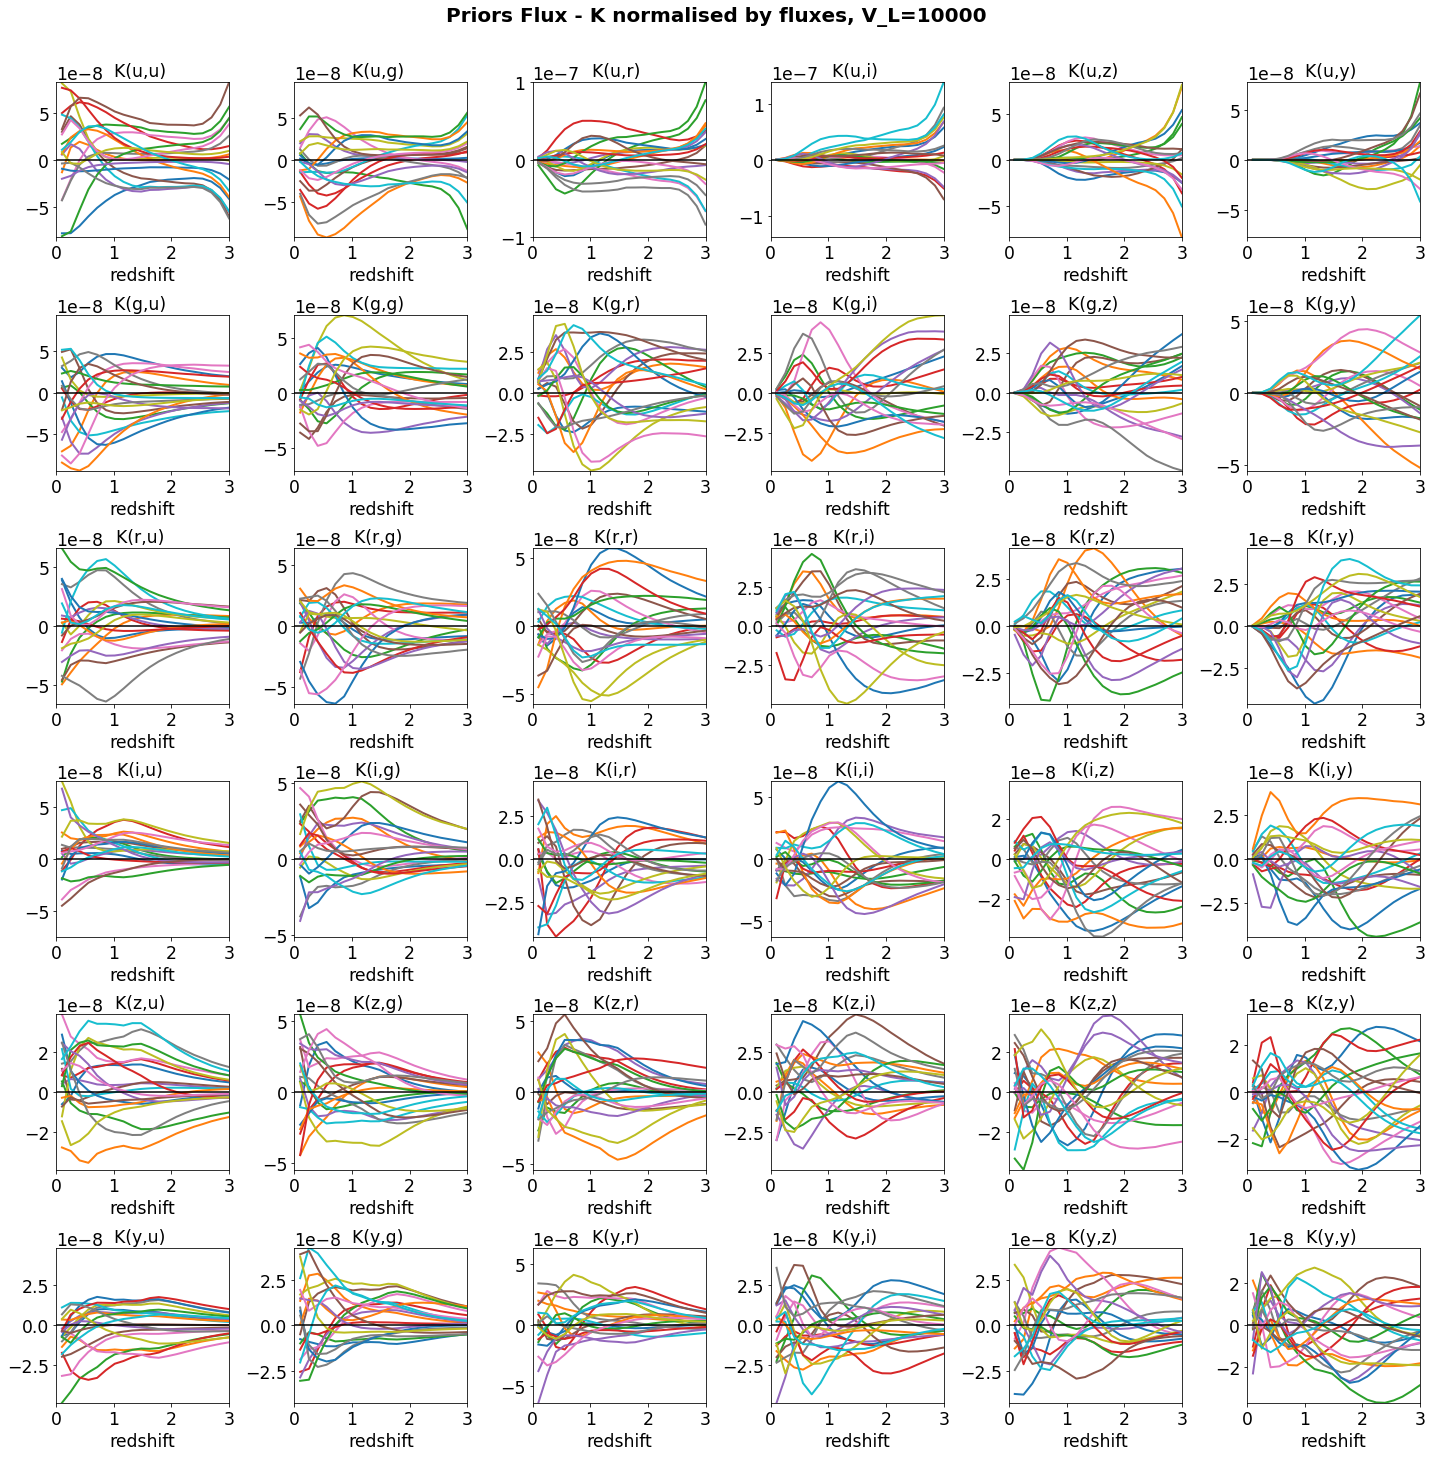

In [73]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K normalised by fluxes, V_L={}".format(V_L)      
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()    

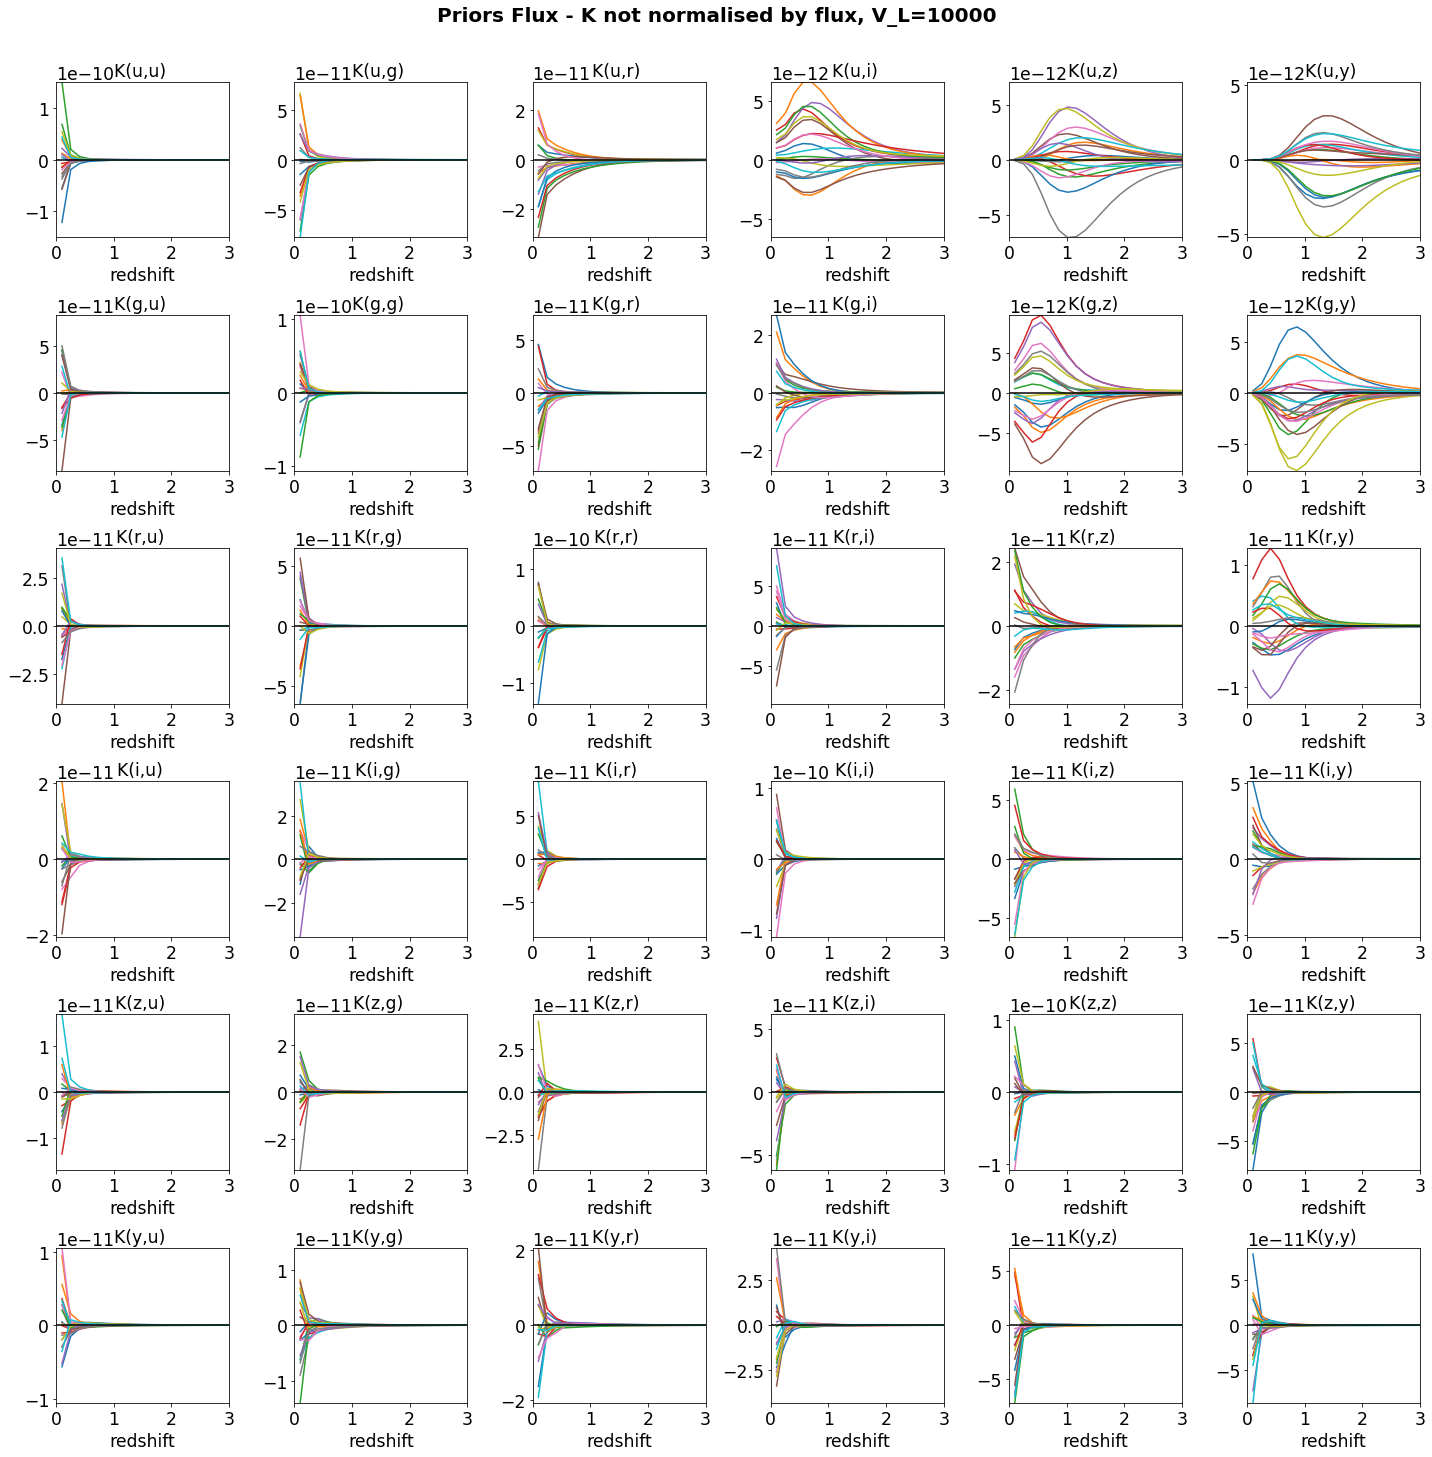

In [74]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K not normalised by flux, V_L={}".format(V_L)
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()   

In [75]:
V_C=1000

In [76]:
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              lines_pos, lines_width,
              V_C, V_L,alpha_C, alpha_L,
              redshiftGridGP, use_interpolators=True)

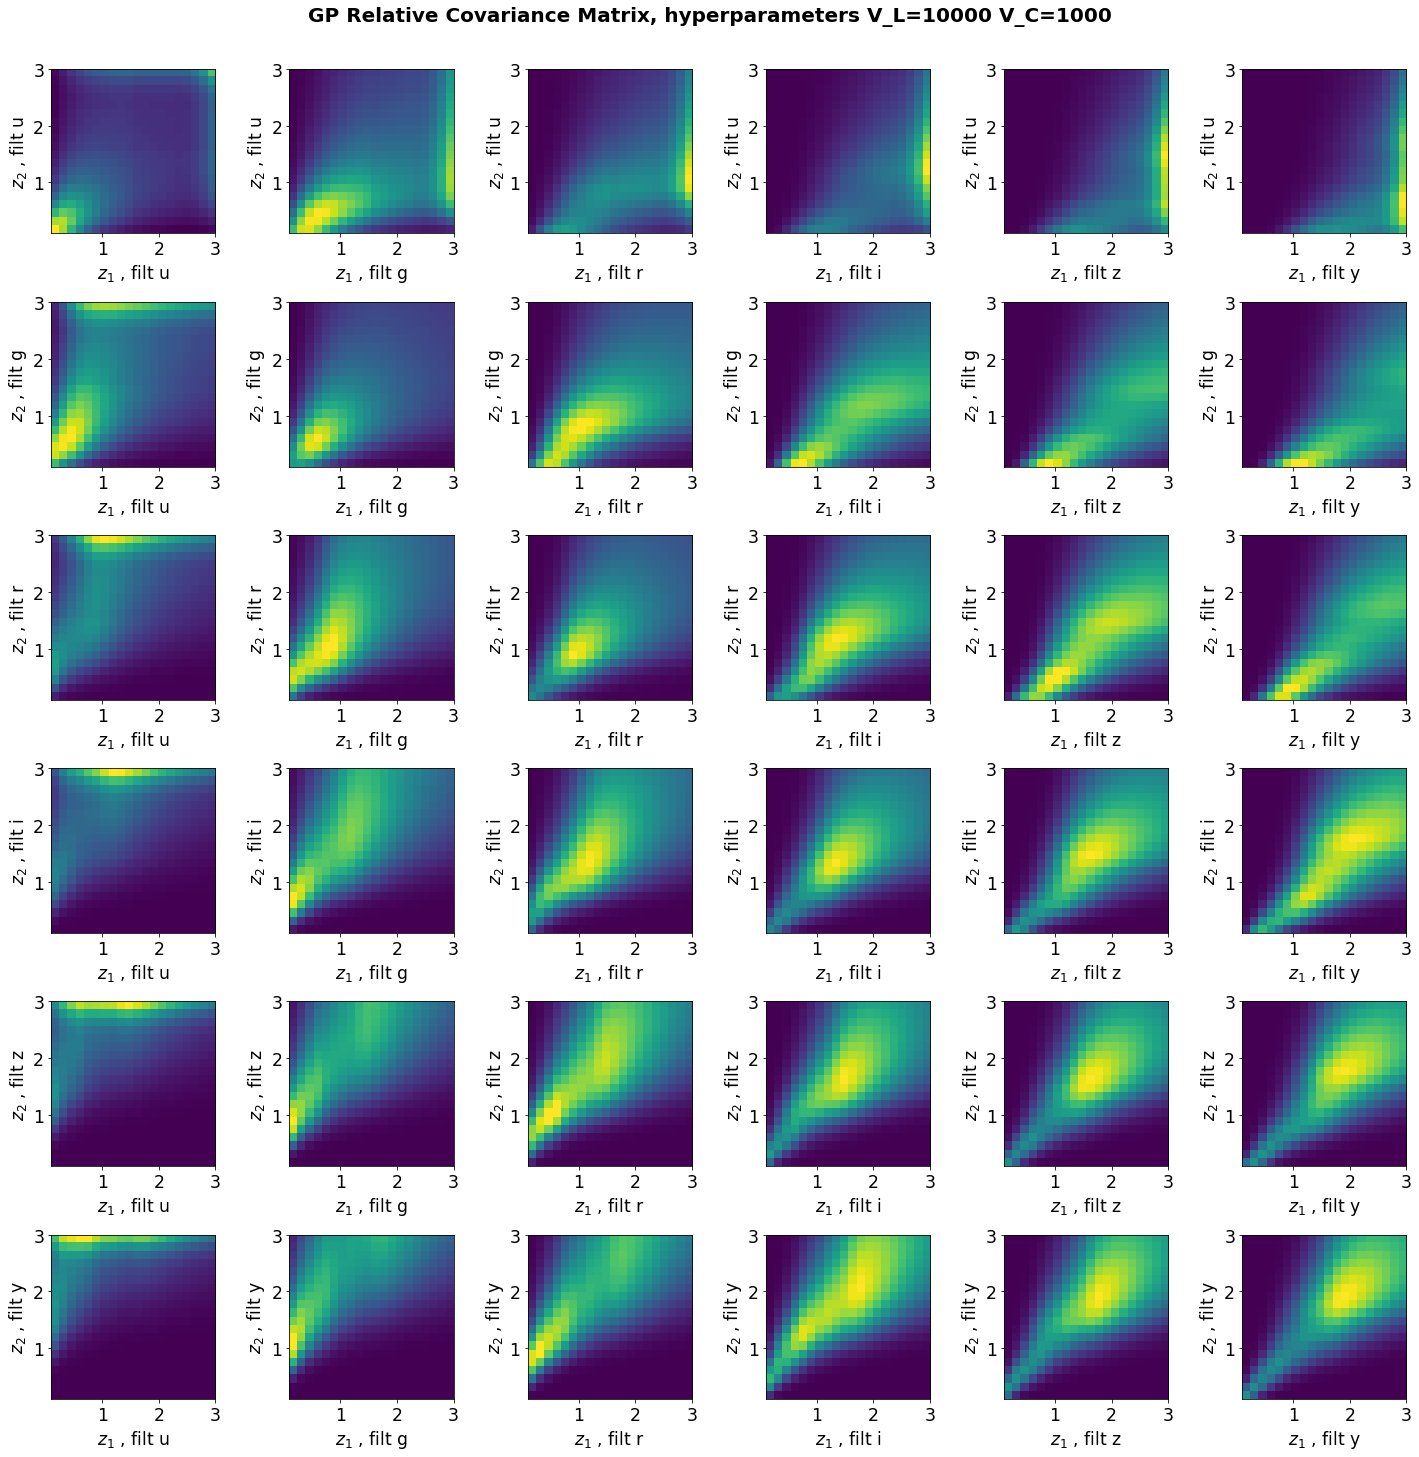

In [77]:
extent= [all_z[0], all_z[-1], all_z[0], all_z[-1] ]
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        axs[ir,ic].imshow(Cov,origin="lower",extent=extent)
        axs[ir,ic].set_xlabel("$z_1$ , filt "+band_name[ib1])
        axs[ir,ic].set_ylabel("$z_2$ , filt "+band_name[ib2])
        
        
title="GP Relative Covariance Matrix, hyperparameters V_L={} V_C={}".format(V_L,V_C)        
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  
plt.show()

## Marginal likelihood

In [78]:
loc = -1
trainingDataIter1 = getDataFromFile(params, firstLine, lastLine, prefix="training_", getXY=True, CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
    X, Y, Yvar in trainingDataIter1:
    loc += 1
    #print( "Band={}, \nRedshift={}, \nEll={}".format(band_name[X[:,0]], X[:,1], X[:,2]) )
    gp.setData(X, Y, Yvar)
    kernelInterp = gp.kernel.use_interpolators
    gp.kernel.use_interpolators = False
    gp.optimizeHyperparamaters([V_C, alpha_C], verbose=False)
    gp.kernel.use_interpolators = kernelInterp
    print( "Loc = {}, Minimum Marginal Likelihood = {}, V_C = {}, alpha_C = {}, V_L = {}, alpha_L = {}".format(loc, gp.margLike(), gp.kernel.var_C, gp.kernel.alpha_C, gp.kernel.var_L, gp.kernel.alpha_L) )

Optimized parameters:  [1.35325970e-06 1.94076404e+03]
Loc = 0, Minimum Marginal Likelihood = 64.71790168787629, V_C = 1.3532596954238954e-06, alpha_C = 1940.7640438450976
Optimized parameters:  [1.39341863e-06 1.70416991e+03]
Loc = 1, Minimum Marginal Likelihood = 31.68057701562386, V_C = 1.3934186258549514e-06, alpha_C = 1704.1699097410112
Optimized parameters:  [1.54327569e-05 2.97600554e+03]
Loc = 2, Minimum Marginal Likelihood = 39.66132322284965, V_C = 1.5432756932995582e-05, alpha_C = 2976.0055418895354
Optimized parameters:  [1.31503118e-06 1.93334837e+03]
Loc = 3, Minimum Marginal Likelihood = 40.56426463967998, V_C = 1.3150311783269936e-06, alpha_C = 1933.3483653782039
Optimized parameters:  [1.63237251e-06 1.90190224e+03]
Loc = 4, Minimum Marginal Likelihood = 29.652755856717917, V_C = 1.6323725064758661e-06, alpha_C = 1901.9022447114567
Optimized parameters:  [1.09465148e-06 1.94187079e+03]
Loc = 5, Minimum Marginal Likelihood = 19.190136936584743, V_C = 1.09465148396953e-0

Optimized parameters:  [1.30222000e-06 2.12734254e+03]
Loc = 48, Minimum Marginal Likelihood = 47.74083651765148, V_C = 1.3022200012179088e-06, alpha_C = 2127.3425400802153
Optimized parameters:  [1.22572179e-06 2.10894865e+03]
Loc = 49, Minimum Marginal Likelihood = 35.79267508124232, V_C = 1.225721794576357e-06, alpha_C = 2108.9486501036313
Optimized parameters:  [7.55583763e-07 2.11123504e+03]
Loc = 50, Minimum Marginal Likelihood = 30.60571223859874, V_C = 7.555837634596641e-07, alpha_C = 2111.235037188404
Optimized parameters:  [1.24893132e-06 2.12787201e+03]
Loc = 51, Minimum Marginal Likelihood = 53.7968674534773, V_C = 1.248931322785692e-06, alpha_C = 2127.87200631492
Optimized parameters:  [7.32947763e-07 2.12781333e+03]
Loc = 52, Minimum Marginal Likelihood = 20.81997443751898, V_C = 7.329477626537812e-07, alpha_C = 2127.8133259043443
Optimized parameters:  [7.32585056e-07 2.30757338e+03]
Loc = 53, Minimum Marginal Likelihood = 36.033844782095045, V_C = 7.32585056165567e-07, 

Optimized parameters:  [9.60582096e-07 2.27422262e+03]
Loc = 96, Minimum Marginal Likelihood = 31.995901686980684, V_C = 9.605820962517827e-07, alpha_C = 2274.22262246143
Optimized parameters:  [2.42075340e-06 2.87316187e+03]
Loc = 97, Minimum Marginal Likelihood = 34.310270372901606, V_C = 2.4207534009201833e-06, alpha_C = 2873.1618741305124
Optimized parameters:  [1.64132834e-06 4.41400068e+03]
Loc = 98, Minimum Marginal Likelihood = 14.233651230734502, V_C = 1.641328342851735e-06, alpha_C = 4414.000684634979
Optimized parameters:  [3.64244799e-05 3.63025962e+03]
Loc = 99, Minimum Marginal Likelihood = 39.01135038005518, V_C = 3.642447991848083e-05, alpha_C = 3630.2596224678878
Optimized parameters:  [1.01249608e-06 2.30058358e+03]
Loc = 100, Minimum Marginal Likelihood = 22.839053133392547, V_C = 1.0124960776977139e-06, alpha_C = 2300.583581438691
Optimized parameters:  [4.55531739e-07 2.69395297e+03]
Loc = 101, Minimum Marginal Likelihood = 37.20513321690456, V_C = 4.55531739318673

Optimized parameters:  [7.36446389e-07 2.31210421e+03]
Loc = 144, Minimum Marginal Likelihood = 22.884322892577696, V_C = 7.364463888705253e-07, alpha_C = 2312.1042099205492
Optimized parameters:  [1.15462105e-06 3.62287506e+03]
Loc = 145, Minimum Marginal Likelihood = 13.477673944274192, V_C = 1.1546210495894622e-06, alpha_C = 3622.875058611994
Optimized parameters:  [8.19328295e-07 2.36349798e+03]
Loc = 146, Minimum Marginal Likelihood = 15.918703022343763, V_C = 8.193282952977948e-07, alpha_C = 2363.497984215497
Optimized parameters:  [1.08297515e-06 2.00734931e+03]
Loc = 147, Minimum Marginal Likelihood = 34.792922831305034, V_C = 1.0829751459802284e-06, alpha_C = 2007.3493083880062
Optimized parameters:  [1.15156123e-06 5.17547572e+03]
Loc = 148, Minimum Marginal Likelihood = 10.246865179816522, V_C = 1.1515612324781737e-06, alpha_C = 5175.475722145957
Optimized parameters:  [1.24124212e-06 2.33720332e+03]
Loc = 149, Minimum Marginal Likelihood = 14.722118682148597, V_C = 1.241242

Optimized parameters:  [1.73939889e-06 2.36713833e+03]
Loc = 192, Minimum Marginal Likelihood = 27.002815381566318, V_C = 1.7393988914359902e-06, alpha_C = 2367.138332941628
Optimized parameters:  [3.23302092e-06 2.41369221e+03]
Loc = 193, Minimum Marginal Likelihood = 40.317342141827595, V_C = 3.233020919640774e-06, alpha_C = 2413.6922063729944
Optimized parameters:  [1.52840480e-06 2.36695281e+03]
Loc = 194, Minimum Marginal Likelihood = 26.057866864999177, V_C = 1.5284048036766442e-06, alpha_C = 2366.9528124604285
Optimized parameters:  [1.84083435e-06 2.41035744e+03]
Loc = 195, Minimum Marginal Likelihood = 40.656915352230165, V_C = 1.840834353310232e-06, alpha_C = 2410.357442444101
Optimized parameters:  [1.01970450e-06 1.87709732e+03]
Loc = 196, Minimum Marginal Likelihood = 44.31261265318574, V_C = 1.019704502680406e-06, alpha_C = 1877.0973154211094
Optimized parameters:  [8.8038139e-07 2.5122437e+03]
Loc = 197, Minimum Marginal Likelihood = 16.68851432428283, V_C = 8.8038139014

Optimized parameters:  [1.23607436e-05 3.33562663e+03]
Loc = 240, Minimum Marginal Likelihood = 36.984555355944366, V_C = 1.236074355290765e-05, alpha_C = 3335.626630514607
Optimized parameters:  [1.31217408e-06 2.45591975e+03]
Loc = 241, Minimum Marginal Likelihood = 11.869720990815216, V_C = 1.3121740836100713e-06, alpha_C = 2455.919754694813
Optimized parameters:  [1.22752024e-04 5.19677722e+03]
Loc = 242, Minimum Marginal Likelihood = 19.01423097685505, V_C = 0.00012275202364621818, alpha_C = 5196.777215886826
Optimized parameters:  [2.97656624e-06 2.47768861e+03]
Loc = 243, Minimum Marginal Likelihood = 22.23583085160823, V_C = 2.976566238072123e-06, alpha_C = 2477.688609243308
Optimized parameters:  [5.48727825e-06 2.54386450e+03]
Loc = 244, Minimum Marginal Likelihood = 21.33869461828009, V_C = 5.487278254523412e-06, alpha_C = 2543.8644977324548
Optimized parameters:  [8.01446833e-07 1.79048239e+03]
Loc = 245, Minimum Marginal Likelihood = 26.09591925345216, V_C = 8.014468331137

Optimized parameters:  [1.24635210e-05 2.54215363e+03]
Loc = 288, Minimum Marginal Likelihood = 24.00505542171517, V_C = 1.2463521002588017e-05, alpha_C = 2542.153627231328
Optimized parameters:  [1.43567586e-06 2.31205114e+03]
Loc = 289, Minimum Marginal Likelihood = 31.018673872317024, V_C = 1.435675861019402e-06, alpha_C = 2312.051141779953
Optimized parameters:  [3.71018328e-06 2.55065049e+03]
Loc = 290, Minimum Marginal Likelihood = 26.700451805621142, V_C = 3.710183275138771e-06, alpha_C = 2550.650494637131
Optimized parameters:  [1.74809047e-06 2.15067737e+03]
Loc = 291, Minimum Marginal Likelihood = 24.318371220292462, V_C = 1.7480904745053492e-06, alpha_C = 2150.6773704935104
Optimized parameters:  [3.03512954e-06 2.56847152e+03]
Loc = 292, Minimum Marginal Likelihood = 31.411258461448114, V_C = 3.035129541537636e-06, alpha_C = 2568.4715150669554
Optimized parameters:  [1.83496904e-06 2.28653242e+03]
Loc = 293, Minimum Marginal Likelihood = 33.8957273012058, V_C = 1.8349690415

Optimized parameters:  [8.05965149e-07 1.99409234e+03]
Loc = 336, Minimum Marginal Likelihood = 47.04154295039642, V_C = 8.059651488165131e-07, alpha_C = 1994.0923404862883
Optimized parameters:  [2.64016622e-06 2.59488615e+03]
Loc = 337, Minimum Marginal Likelihood = 25.300979958383667, V_C = 2.6401662200059208e-06, alpha_C = 2594.886154125762
Optimized parameters:  [1.85956017e-06 2.65533783e+03]
Loc = 338, Minimum Marginal Likelihood = 15.618122990729407, V_C = 1.8595601676576906e-06, alpha_C = 2655.337831630709
Optimized parameters:  [1.52981407e-05 2.64947262e+03]
Loc = 339, Minimum Marginal Likelihood = 25.304164457974302, V_C = 1.5298140658242993e-05, alpha_C = 2649.472616017533
Optimized parameters:  [8.95293754e-07 2.03824885e+03]
Loc = 340, Minimum Marginal Likelihood = 48.674884193242704, V_C = 8.952937536736647e-07, alpha_C = 2038.2488468245547
Optimized parameters:  [1.02947891e-06 2.13692995e+03]
Loc = 341, Minimum Marginal Likelihood = 29.766077571849316, V_C = 1.0294789

Optimized parameters:  [1.31706653e-06 2.15799780e+03]
Loc = 384, Minimum Marginal Likelihood = 40.42427057730093, V_C = 1.3170665278042718e-06, alpha_C = 2157.9978009963297
Optimized parameters:  [8.35939701e-06 2.72682095e+03]
Loc = 385, Minimum Marginal Likelihood = 24.438645448246426, V_C = 8.359397007521851e-06, alpha_C = 2726.8209489814335
Optimized parameters:  [3.22044728e-06 2.68624787e+03]
Loc = 386, Minimum Marginal Likelihood = 26.035008316056267, V_C = 3.220447284317941e-06, alpha_C = 2686.247870846993
Optimized parameters:  [1.70810587e-05 2.69114984e+03]
Loc = 387, Minimum Marginal Likelihood = 20.467426692234763, V_C = 1.70810586531723e-05, alpha_C = 2691.1498355903473
Optimized parameters:  [1.26699373e-05 2.69322544e+03]
Loc = 388, Minimum Marginal Likelihood = 25.414001948114887, V_C = 1.266993733824074e-05, alpha_C = 2693.2254369095836
Optimized parameters:  [4.18829093e-06 2.68525263e+03]
Loc = 389, Minimum Marginal Likelihood = 34.009659352285105, V_C = 4.18829093

Optimized parameters:  [5.74658798e-05 3.82367715e+03]
Loc = 432, Minimum Marginal Likelihood = 31.117926301230327, V_C = 5.7465879827547406e-05, alpha_C = 3823.6771455795847
Optimized parameters:  [2.07419633e-05 2.76774012e+03]
Loc = 433, Minimum Marginal Likelihood = 40.8461254991013, V_C = 2.0741963304407667e-05, alpha_C = 2767.7401167179305
Optimized parameters:  [6.70034499e-07 1.65993555e+03]
Loc = 434, Minimum Marginal Likelihood = 38.48879013903635, V_C = 6.700344989663175e-07, alpha_C = 1659.9355457717506
Optimized parameters:  [1.11391292e-05 2.74646095e+03]
Loc = 435, Minimum Marginal Likelihood = 18.314898177979508, V_C = 1.1139129246814338e-05, alpha_C = 2746.460950882171
Optimized parameters:  [2.10267699e-06 1.71733210e+03]
Loc = 436, Minimum Marginal Likelihood = 21.584924051634456, V_C = 2.1026769901291386e-06, alpha_C = 1717.3321028646321
Optimized parameters:  [1.05506338e-05 2.64852749e+03]
Loc = 437, Minimum Marginal Likelihood = 37.66372907420307, V_C = 1.0550633

Optimized parameters:  [5.02208384e-05 2.82904860e+03]
Loc = 480, Minimum Marginal Likelihood = 25.920862355385033, V_C = 5.0220838431306455e-05, alpha_C = 2829.048600589416
Optimized parameters:  [8.48427473e-07 1.94161710e+03]
Loc = 481, Minimum Marginal Likelihood = 38.868223166114134, V_C = 8.484274726438707e-07, alpha_C = 1941.617099856517
Optimized parameters:  [ 244.44633836 3929.34136816]
Loc = 482, Minimum Marginal Likelihood = 67.494801498244, V_C = 244.44633835721422, alpha_C = 3929.3413681582388
Optimized parameters:  [6.83709284e-05 2.80476099e+03]
Loc = 483, Minimum Marginal Likelihood = 27.239104584325613, V_C = 6.837092835430231e-05, alpha_C = 2804.760990677255
Optimized parameters:  [6.22003155e-05 2.84797726e+03]
Loc = 484, Minimum Marginal Likelihood = 32.61869462346771, V_C = 6.22003155032867e-05, alpha_C = 2847.9772647640716
Optimized parameters:  [7.00091732e-07 1.68314874e+03]
Loc = 485, Minimum Marginal Likelihood = 30.29444794461281, V_C = 7.00091732439541e-07,

Optimized parameters:  [2.68007250e-05 2.99499081e+03]
Loc = 528, Minimum Marginal Likelihood = 29.13493120181782, V_C = 2.6800725048422526e-05, alpha_C = 2994.990808243296
Optimized parameters:  [7.76314419e-06 2.76443376e+03]
Loc = 529, Minimum Marginal Likelihood = 17.034402163107842, V_C = 7.763144189851394e-06, alpha_C = 2764.433761646626
Optimized parameters:  [1.08921754e-06 2.98364180e+03]
Loc = 530, Minimum Marginal Likelihood = 21.475094599172095, V_C = 1.0892175376027127e-06, alpha_C = 2983.641796717945
Optimized parameters:  [8.87613146e-07 2.10909241e+03]
Loc = 531, Minimum Marginal Likelihood = 16.297306729457883, V_C = 8.876131457157891e-07, alpha_C = 2109.0924124507524
Optimized parameters:  [1.06929113e-06 2.96759230e+03]
Loc = 532, Minimum Marginal Likelihood = 40.300702707817116, V_C = 1.0692911325198007e-06, alpha_C = 2967.5922971869004
Optimized parameters:  [1.17675027e-06 2.97709125e+03]
Loc = 533, Minimum Marginal Likelihood = 25.452369630835214, V_C = 1.1767502

Optimized parameters:  [1.50242552e-05 3.13371062e+03]
Loc = 576, Minimum Marginal Likelihood = 18.9747145421332, V_C = 1.502425521310082e-05, alpha_C = 3133.7106247080114
Optimized parameters:  [3.58363010e-05 3.04501251e+03]
Loc = 577, Minimum Marginal Likelihood = 41.07140846511634, V_C = 3.583630097357756e-05, alpha_C = 3045.0125067395925
Optimized parameters:  [1.25260764e-04 3.10053881e+03]
Loc = 578, Minimum Marginal Likelihood = 39.89915906796197, V_C = 0.0001252607644872875, alpha_C = 3100.538812225451
Optimized parameters:  [8.10679481e-05 5.12516660e+03]
Loc = 579, Minimum Marginal Likelihood = 20.605862039128898, V_C = 8.106794810855076e-05, alpha_C = 5125.166603533901
Optimized parameters:  [1.58531404e-04 2.99790494e+03]
Loc = 580, Minimum Marginal Likelihood = 36.070473487522634, V_C = 0.00015853140444161752, alpha_C = 2997.904941192492
Optimized parameters:  [9.27815416e-05 3.01281017e+03]
Loc = 581, Minimum Marginal Likelihood = 34.4594536056045, V_C = 9.27815416346868

Optimized parameters:  [1.53517611e-04 3.22790057e+03]
Loc = 624, Minimum Marginal Likelihood = 31.41253016317631, V_C = 0.00015351761099940386, alpha_C = 3227.9005720466716
Optimized parameters:  [1.77700135e-04 3.24835578e+03]
Loc = 625, Minimum Marginal Likelihood = 38.37024932303304, V_C = 0.00017770013537961662, alpha_C = 3248.355775349373
Optimized parameters:  [1.86691875e-04 4.03861426e+03]
Loc = 626, Minimum Marginal Likelihood = 22.923102199058285, V_C = 0.0001866918752183781, alpha_C = 4038.614261367039
Optimized parameters:  [8.97816789e-04 8.34503691e+03]
Loc = 627, Minimum Marginal Likelihood = 33.98392991532428, V_C = 0.0008978167885901683, alpha_C = 8345.036911351213
Optimized parameters:  [2.94777617e-04 3.08478995e+03]
Loc = 628, Minimum Marginal Likelihood = 34.7230736202215, V_C = 0.000294777617183795, alpha_C = 3084.789949119263
Optimized parameters:  [4.57657301e-07 1.75809196e+03]
Loc = 629, Minimum Marginal Likelihood = 28.421271423385264, V_C = 4.57657301029141

Optimized parameters:  [6.83573453e-05 2.19248230e+03]
Loc = 672, Minimum Marginal Likelihood = 42.54637061992398, V_C = 6.835734531610212e-05, alpha_C = 2192.4823038087666
Optimized parameters:  [1.31455148e-03 6.15747771e+03]
Loc = 673, Minimum Marginal Likelihood = 31.037640369116758, V_C = 0.0013145514812336256, alpha_C = 6157.4777144472755
Optimized parameters:  [3.76037183e-04 3.31663294e+03]
Loc = 674, Minimum Marginal Likelihood = 28.596897075517415, V_C = 0.0003760371827047334, alpha_C = 3316.632942015114
Optimized parameters:  [2.66182235e-04 2.93086022e+03]
Loc = 675, Minimum Marginal Likelihood = 34.63311441277098, V_C = 0.000266182234532245, alpha_C = 2930.860220813144
Optimized parameters:  [1.73206384e-04 2.76480868e+03]
Loc = 676, Minimum Marginal Likelihood = 30.045968855220742, V_C = 0.0001732063843005379, alpha_C = 2764.8086786396557
Optimized parameters:  [2.17016057e-04 2.65546076e+03]
Loc = 677, Minimum Marginal Likelihood = 29.490475122619742, V_C = 0.00021701605

Optimized parameters:  [4.81696336e-05 1.88538805e+03]
Loc = 720, Minimum Marginal Likelihood = 33.912263500931886, V_C = 4.8169633564175575e-05, alpha_C = 1885.3880478457759
Optimized parameters:  [5.77125913e-04 7.01631482e+03]
Loc = 721, Minimum Marginal Likelihood = 31.307696452960823, V_C = 0.0005771259126197617, alpha_C = 7016.314818519456
Optimized parameters:  [2.9383162e-05 2.1403830e+03]
Loc = 722, Minimum Marginal Likelihood = 33.52304884937394, V_C = 2.9383162040956187e-05, alpha_C = 2140.3830013827337
Optimized parameters:  [6.07881937e-04 5.62878083e+03]
Loc = 723, Minimum Marginal Likelihood = 30.97121908007755, V_C = 0.000607881936921767, alpha_C = 5628.780831258248
Optimized parameters:  [3.29943303e-04 2.97647109e+03]
Loc = 724, Minimum Marginal Likelihood = 39.56440137169349, V_C = 0.0003299433030758814, alpha_C = 2976.471089231274
Optimized parameters:  [2.72391950e-07 8.57496528e+02]
Loc = 725, Minimum Marginal Likelihood = 19.544907018943395, V_C = 2.7239195019552

Optimized parameters:  [1.14072405e-04 2.45371774e+03]
Loc = 768, Minimum Marginal Likelihood = 38.17395689815217, V_C = 0.00011407240492128723, alpha_C = 2453.7177374643857
Optimized parameters:  [3.59916984e-04 3.59893071e+03]
Loc = 769, Minimum Marginal Likelihood = 36.90401894479862, V_C = 0.00035991698414778047, alpha_C = 3598.9307074841277
Optimized parameters:  [3.41727785e-04 3.34129525e+03]
Loc = 770, Minimum Marginal Likelihood = 30.070111035418996, V_C = 0.0003417277850552058, alpha_C = 3341.2952507958207
Optimized parameters:  [5.98033065e-04 6.96376249e+03]
Loc = 771, Minimum Marginal Likelihood = 28.11862337305581, V_C = 0.0005980330651671613, alpha_C = 6963.762490199899
Optimized parameters:  [3.61568763e-04 4.27016153e+03]
Loc = 772, Minimum Marginal Likelihood = 28.263368179742457, V_C = 0.00036156876295281615, alpha_C = 4270.161526805775
Optimized parameters:  [2.35852813e-04 2.87389832e+03]
Loc = 773, Minimum Marginal Likelihood = 31.59325648099232, V_C = 0.000235852

Optimized parameters:  [4.45306361e-04 3.17392084e+03]
Loc = 816, Minimum Marginal Likelihood = 41.23910527487915, V_C = 0.0004453063606098639, alpha_C = 3173.9208396800864
Optimized parameters:  [5.97053982e-04 4.15446591e+03]
Loc = 817, Minimum Marginal Likelihood = 26.896941023076664, V_C = 0.0005970539823629534, alpha_C = 4154.46591132081
Optimized parameters:  [2.72554477e-05 1.99283591e+03]
Loc = 818, Minimum Marginal Likelihood = 29.00447725961277, V_C = 2.7255447654501445e-05, alpha_C = 1992.835912591908
Optimized parameters:  [4.71933071e-04 3.41148064e+03]
Loc = 819, Minimum Marginal Likelihood = 36.84576289045536, V_C = 0.0004719330710126707, alpha_C = 3411.480643276155
Optimized parameters:  [5.31163382e-04 3.51816998e+03]
Loc = 820, Minimum Marginal Likelihood = 33.41104346008342, V_C = 0.0005311633822382936, alpha_C = 3518.1699809861398
Optimized parameters:  [8.24999370e-04 5.57026696e+03]
Loc = 821, Minimum Marginal Likelihood = 26.1067393843012, V_C = 0.000824999369683

Optimized parameters:  [1.92408053e-04 3.41933845e+03]
Loc = 864, Minimum Marginal Likelihood = 23.740549557132667, V_C = 0.00019240805301176013, alpha_C = 3419.338453828599
Optimized parameters:  [1.55144911e-06 2.34831731e+03]
Loc = 865, Minimum Marginal Likelihood = 15.015330786144233, V_C = 1.5514491118696778e-06, alpha_C = 2348.3173094404356
Optimized parameters:  [4.39859328e-04 4.71208241e+03]
Loc = 866, Minimum Marginal Likelihood = 37.555989715163044, V_C = 0.000439859327809326, alpha_C = 4712.082407856729
Optimized parameters:  [2.44682217e-04 2.69545006e+03]
Loc = 867, Minimum Marginal Likelihood = 37.30335583736371, V_C = 0.00024468221743973465, alpha_C = 2695.450062554562
Optimized parameters:  [1.01282154e-04 3.33614701e+03]
Loc = 868, Minimum Marginal Likelihood = 30.29241333439575, V_C = 0.0001012821536425688, alpha_C = 3336.1470081971393
Optimized parameters:  [4.59460006e-04 4.11199250e+03]
Loc = 869, Minimum Marginal Likelihood = 37.17612617330242, V_C = 0.0004594600

Optimized parameters:  [6.79448989e-05 2.18139073e+03]
Loc = 912, Minimum Marginal Likelihood = 34.35523794585345, V_C = 6.794489887154287e-05, alpha_C = 2181.390730779774
Optimized parameters:  [5.52322943e-04 6.20339053e+03]
Loc = 913, Minimum Marginal Likelihood = 33.28511408437948, V_C = 0.0005523229434963754, alpha_C = 6203.390527498074
Optimized parameters:  [1.37101152e-06 1.50612234e+03]
Loc = 914, Minimum Marginal Likelihood = 35.042169412002934, V_C = 1.3710115236330329e-06, alpha_C = 1506.1223432202146
Optimized parameters:  [2.95239925e-04 3.91239738e+03]
Loc = 915, Minimum Marginal Likelihood = 22.572698011829694, V_C = 0.00029523992466749056, alpha_C = 3912.397377532119
Optimized parameters:  [7.17369214e-05 2.20050074e+03]
Loc = 916, Minimum Marginal Likelihood = 39.04706913281852, V_C = 7.1736921424884e-05, alpha_C = 2200.5007377685356
Optimized parameters:  [ 491.8770326  2355.07483628]
Loc = 917, Minimum Marginal Likelihood = 75.94560368364398, V_C = 491.8770326002696

Optimized parameters:  [4.53074308e-04 5.48636198e+03]
Loc = 960, Minimum Marginal Likelihood = 25.937117280625756, V_C = 0.0004530743079570296, alpha_C = 5486.361975009054
Optimized parameters:  [5.12509154e-04 4.17474851e+03]
Loc = 961, Minimum Marginal Likelihood = 22.23036137510433, V_C = 0.0005125091544085861, alpha_C = 4174.748511507731
Optimized parameters:  [ 332.97724882 3718.2117612 ]
Loc = 962, Minimum Marginal Likelihood = 58.839519935991916, V_C = 332.97724882167967, alpha_C = 3718.2117612044435
Optimized parameters:  [1.13046335e-03 3.63468993e+03]
Loc = 963, Minimum Marginal Likelihood = 29.323814105179114, V_C = 0.0011304633457063927, alpha_C = 3634.68992532402
Optimized parameters:  [2.92622721e-04 2.38395930e+03]
Loc = 964, Minimum Marginal Likelihood = 35.332153058672084, V_C = 0.00029262272062694286, alpha_C = 2383.95929500061
Optimized parameters:  [1.81129500e-04 3.58595078e+03]
Loc = 965, Minimum Marginal Likelihood = 33.44749633301353, V_C = 0.000181129500025591

Optimized parameters:  [1.50829663e-03 4.26178715e+03]
Loc = 1008, Minimum Marginal Likelihood = 24.452764195187143, V_C = 0.0015082966343634117, alpha_C = 4261.787152555978
Optimized parameters:  [3.12964937e-04 4.48433722e+03]
Loc = 1009, Minimum Marginal Likelihood = 34.088993381098234, V_C = 0.00031296493726382584, alpha_C = 4484.33721593665
Optimized parameters:  [1.20274707e-04 2.95959619e+03]
Loc = 1010, Minimum Marginal Likelihood = 31.417843136987152, V_C = 0.00012027470682406914, alpha_C = 2959.5961920250184
Optimized parameters:  [1.60343527e-04 3.59695648e+03]
Loc = 1011, Minimum Marginal Likelihood = 31.523654663225813, V_C = 0.00016034352687880729, alpha_C = 3596.9564791006073
Optimized parameters:  [1.26880302e-06 1.37874966e+03]
Loc = 1012, Minimum Marginal Likelihood = 28.060241341704746, V_C = 1.2688030218702583e-06, alpha_C = 1378.7496561295281
Optimized parameters:  [3.85690103e-04 3.31204610e+03]
Loc = 1013, Minimum Marginal Likelihood = 28.076804449289128, V_C = 0

Optimized parameters:  [ 327.76707696 2672.54855052]
Loc = 1056, Minimum Marginal Likelihood = 71.30602040864136, V_C = 327.76707696080337, alpha_C = 2672.54855052424
Optimized parameters:  [1.72188782e-05 2.21393673e+03]
Loc = 1057, Minimum Marginal Likelihood = 31.259393473065522, V_C = 1.7218878183950615e-05, alpha_C = 2213.9367336151645
Optimized parameters:  [ 154.06169807 4724.97706269]
Loc = 1058, Minimum Marginal Likelihood = 62.27596919194541, V_C = 154.06169806589742, alpha_C = 4724.977062685219
Optimized parameters:  [3.36231707e-06 2.23530938e+03]
Loc = 1059, Minimum Marginal Likelihood = 19.69793969296088, V_C = 3.362317068170629e-06, alpha_C = 2235.309379092372
Optimized parameters:  [3.66320145e-05 2.60232235e+03]
Loc = 1060, Minimum Marginal Likelihood = 24.028240318942835, V_C = 3.6632014466501033e-05, alpha_C = 2602.3223532583647
Optimized parameters:  [ 190.3745927  4811.33879825]
Loc = 1061, Minimum Marginal Likelihood = 60.94473104417823, V_C = 190.3745927013934, a

Optimized parameters:  [ 323.90539346 4532.26640171]
Loc = 1104, Minimum Marginal Likelihood = 68.65560033806219, V_C = 323.9053934575196, alpha_C = 4532.266401712823
Optimized parameters:  [2.58398784e-06 2.53770908e+03]
Loc = 1105, Minimum Marginal Likelihood = 12.129091973357674, V_C = 2.5839878390210706e-06, alpha_C = 2537.7090760755837
Optimized parameters:  [1.58490765e-07 1.16901711e+03]
Loc = 1106, Minimum Marginal Likelihood = 11.533547155447874, V_C = 1.5849076469551644e-07, alpha_C = 1169.0171059226957
Optimized parameters:  [2.21149548e-06 2.72957735e+03]
Loc = 1107, Minimum Marginal Likelihood = 10.049183179956279, V_C = 2.211495478088661e-06, alpha_C = 2729.5773541942826
Optimized parameters:  [1.80951317e-07 1.04820850e+03]
Loc = 1108, Minimum Marginal Likelihood = 15.333125032809775, V_C = 1.809513167875201e-07, alpha_C = 1048.2085030866199
Optimized parameters:  [4.22403765e-07 1.75979653e+03]
Loc = 1109, Minimum Marginal Likelihood = 9.918011310453117, V_C = 4.2240376

Optimized parameters:  [5.22718539e-04 3.82933471e+03]
Loc = 1152, Minimum Marginal Likelihood = 27.99662826411833, V_C = 0.0005227185393244247, alpha_C = 3829.334709603436
Optimized parameters:  [2.35124509e-05 2.22532717e+03]
Loc = 1153, Minimum Marginal Likelihood = 27.507060550103613, V_C = 2.3512450863160047e-05, alpha_C = 2225.327173249489
Optimized parameters:  [1.16295971e-05 2.35587840e+03]
Loc = 1154, Minimum Marginal Likelihood = 24.91806828677165, V_C = 1.1629597050850569e-05, alpha_C = 2355.8783990610946
Optimized parameters:  [ 490.76289698 2658.43284593]
Loc = 1155, Minimum Marginal Likelihood = 63.76940800428661, V_C = 490.76289697613566, alpha_C = 2658.4328459334183
Optimized parameters:  [2.68989663e-04 3.77594439e+03]
Loc = 1156, Minimum Marginal Likelihood = 38.33132567536129, V_C = 0.0002689896626871153, alpha_C = 3775.9443943903702
Optimized parameters:  [2.19448245e-05 2.64088880e+03]
Loc = 1157, Minimum Marginal Likelihood = 20.176555678612512, V_C = 2.194482445

Optimized parameters:  [8.73975981e-07 1.80418074e+03]
Loc = 1200, Minimum Marginal Likelihood = 23.852027160044397, V_C = 8.739759807181109e-07, alpha_C = 1804.1807416673219
Optimized parameters:  [9.39960114e-05 3.50920942e+03]
Loc = 1201, Minimum Marginal Likelihood = 32.249055240507396, V_C = 9.399601139952953e-05, alpha_C = 3509.2094170567457
Optimized parameters:  [1.92152908e-04 3.61025527e+03]
Loc = 1202, Minimum Marginal Likelihood = 30.633292707057304, V_C = 0.0001921529083621508, alpha_C = 3610.2552687682205
Optimized parameters:  [9.21188973e-07 1.81360555e+03]
Loc = 1203, Minimum Marginal Likelihood = 19.5918280178697, V_C = 9.211889726568766e-07, alpha_C = 1813.6055515115715
Optimized parameters:  [1.86099003e-05 2.82088158e+03]
Loc = 1204, Minimum Marginal Likelihood = 32.62059557337843, V_C = 1.860990025520132e-05, alpha_C = 2820.8815807550527
Optimized parameters:  [5.98953335e-06 1.93864459e+03]
Loc = 1205, Minimum Marginal Likelihood = 24.890339921354347, V_C = 5.989

Optimized parameters:  [8.93598260e-04 3.99640168e+03]
Loc = 1248, Minimum Marginal Likelihood = 31.966834731287182, V_C = 0.0008935982595894528, alpha_C = 3996.4016787114165
Optimized parameters:  [8.03497861e-05 2.25304916e+03]
Loc = 1249, Minimum Marginal Likelihood = 33.231615426692265, V_C = 8.034978611505738e-05, alpha_C = 2253.049163517515
Optimized parameters:  [ 417.69837179 3264.16395319]
Loc = 1250, Minimum Marginal Likelihood = 67.57739818149139, V_C = 417.698371787711, alpha_C = 3264.1639531943733
Optimized parameters:  [4.57919363e-07 2.45887633e+03]
Loc = 1251, Minimum Marginal Likelihood = 8.157758634310824, V_C = 4.5791936339250536e-07, alpha_C = 2458.8763318871174
Optimized parameters:  [ 245.63253691 3471.65576167]
Loc = 1252, Minimum Marginal Likelihood = 62.27443342016286, V_C = 245.63253690828287, alpha_C = 3471.655761667145
Optimized parameters:  [ 486.6111022  2495.64053179]
Loc = 1253, Minimum Marginal Likelihood = 59.26779807158858, V_C = 486.6111021981394, al

Optimized parameters:  [4.18036575e-06 2.36519154e+03]
Loc = 1296, Minimum Marginal Likelihood = 21.25214268704932, V_C = 4.180365752313734e-06, alpha_C = 2365.1915377360688
Optimized parameters:  [5.96082249e-06 2.22939013e+03]
Loc = 1297, Minimum Marginal Likelihood = 26.56481959274226, V_C = 5.960822487152871e-06, alpha_C = 2229.390128669662
Optimized parameters:  [2.22451651e-06 2.94111106e+03]
Loc = 1298, Minimum Marginal Likelihood = 14.953553743155812, V_C = 2.2245165085294814e-06, alpha_C = 2941.111061081829
Optimized parameters:  [8.55290088e-05 3.48030622e+03]
Loc = 1299, Minimum Marginal Likelihood = 25.205157871113805, V_C = 8.552900877036345e-05, alpha_C = 3480.30621505554
Optimized parameters:  [2.75987268e-04 3.81734536e+03]
Loc = 1300, Minimum Marginal Likelihood = 33.47322323831949, V_C = 0.0002759872683621697, alpha_C = 3817.3453566045064
Optimized parameters:  [5.85527425e-06 2.53106080e+03]
Loc = 1301, Minimum Marginal Likelihood = 20.87962347594359, V_C = 5.8552742

Optimized parameters:  [3.53138969e-07 1.75312864e+03]
Loc = 1344, Minimum Marginal Likelihood = 15.085427720220974, V_C = 3.5313896867249933e-07, alpha_C = 1753.1286426157915
Optimized parameters:  [8.67363351e-06 1.70940325e+03]
Loc = 1345, Minimum Marginal Likelihood = 29.576657738517056, V_C = 8.67363350914449e-06, alpha_C = 1709.403247561053
Optimized parameters:  [6.07155497e-07 1.92523519e+03]
Loc = 1346, Minimum Marginal Likelihood = 10.047409457652748, V_C = 6.071554970446676e-07, alpha_C = 1925.235190355408
Optimized parameters:  [4.28536759e-04 3.81400815e+03]
Loc = 1347, Minimum Marginal Likelihood = 24.549234904144186, V_C = 0.00042853675875057895, alpha_C = 3814.008146409805
Optimized parameters:  [7.85506941e-06 2.53708670e+03]
Loc = 1348, Minimum Marginal Likelihood = 25.452525944964012, V_C = 7.855069407296822e-06, alpha_C = 2537.0867021262716
Optimized parameters:  [6.78073410e-06 2.26953578e+03]
Loc = 1349, Minimum Marginal Likelihood = 22.38728889135914, V_C = 6.780

Optimized parameters:  [ 491.42043576 2552.49334642]
Loc = 1392, Minimum Marginal Likelihood = 68.84348310324219, V_C = 491.4204357595513, alpha_C = 2552.4933464216297
Optimized parameters:  [5.30372676e-07 2.33537815e+03]
Loc = 1393, Minimum Marginal Likelihood = 21.641794635453778, V_C = 5.303726761690341e-07, alpha_C = 2335.378153901206
Optimized parameters:  [1.31523889e-04 3.23928147e+03]
Loc = 1394, Minimum Marginal Likelihood = 25.291586477092004, V_C = 0.0001315238886542958, alpha_C = 3239.2814695856123
Optimized parameters:  [5.26533690e-05 2.07533972e+03]
Loc = 1395, Minimum Marginal Likelihood = 30.18123207819707, V_C = 5.265336898786023e-05, alpha_C = 2075.3397158024054
Optimized parameters:  [  24.46846631 8155.68310916]
Loc = 1396, Minimum Marginal Likelihood = 40.564736705713415, V_C = 24.46846631164015, alpha_C = 8155.6831091643135
Optimized parameters:  [ 163.37059114 5216.47539342]
Loc = 1397, Minimum Marginal Likelihood = 53.431828941096704, V_C = 163.37059113990085,

Optimized parameters:  [2.79469950e-04 3.27433342e+03]
Loc = 1440, Minimum Marginal Likelihood = 29.61049452747225, V_C = 0.00027946995006838574, alpha_C = 3274.3334151985873
Optimized parameters:  [5.01817791e-05 2.09813579e+03]
Loc = 1441, Minimum Marginal Likelihood = 28.308707561574902, V_C = 5.018177910878185e-05, alpha_C = 2098.1357947279985
Optimized parameters:  [6.49825187e-05 2.78970605e+03]
Loc = 1442, Minimum Marginal Likelihood = 30.180716973463987, V_C = 6.498251869824046e-05, alpha_C = 2789.706047961271
Optimized parameters:  [3.98128080e-07 1.81376231e+03]
Loc = 1443, Minimum Marginal Likelihood = 12.505306475044453, V_C = 3.981280796028922e-07, alpha_C = 1813.7623118367353
Optimized parameters:  [1.39997115e-04 5.91673001e+03]
Loc = 1444, Minimum Marginal Likelihood = 22.585434575673577, V_C = 0.0001399971154698796, alpha_C = 5916.730009671972
Optimized parameters:  [3.11920851e-07 2.11543891e+03]
Loc = 1445, Minimum Marginal Likelihood = 8.94874012732243, V_C = 3.1192

Optimized parameters:  [2.23380908e-05 2.61827623e+03]
Loc = 1488, Minimum Marginal Likelihood = 27.13843422650521, V_C = 2.2338090847621013e-05, alpha_C = 2618.2762259134593
Optimized parameters:  [  27.32479158 9265.87250289]
Loc = 1489, Minimum Marginal Likelihood = 58.161513067420415, V_C = 27.32479157656706, alpha_C = 9265.872502888256
Optimized parameters:  [3.12932574e-04 3.40090426e+03]
Loc = 1490, Minimum Marginal Likelihood = 25.48028725490278, V_C = 0.0003129325739443146, alpha_C = 3400.9042606260796
Optimized parameters:  [7.36392673e-04 3.92625712e+03]
Loc = 1491, Minimum Marginal Likelihood = 29.15864903211882, V_C = 0.0007363926725236412, alpha_C = 3926.257120332961
Optimized parameters:  [4.14439311e-05 3.99618540e+03]
Loc = 1492, Minimum Marginal Likelihood = 21.862481467043832, V_C = 4.144393112430299e-05, alpha_C = 3996.1854024093363
Optimized parameters:  [2.77680379e-07 2.44837859e+03]
Loc = 1493, Minimum Marginal Likelihood = 26.57184397392908, V_C = 2.77680379020

Optimized parameters:  [1.96035561e-04 2.16321390e+03]
Loc = 1536, Minimum Marginal Likelihood = 32.00417400020741, V_C = 0.00019603556055743904, alpha_C = 2163.213896835104
Optimized parameters:  [2.65009883e-04 3.91324174e+03]
Loc = 1537, Minimum Marginal Likelihood = 28.672825999551122, V_C = 0.00026500988279500953, alpha_C = 3913.2417425886833
Optimized parameters:  [2.18678785e-05 3.06715117e+03]
Loc = 1538, Minimum Marginal Likelihood = 26.335926591847443, V_C = 2.1867878483279816e-05, alpha_C = 3067.151172548609
Optimized parameters:  [  99.49082754 5779.17666615]
Loc = 1539, Minimum Marginal Likelihood = 65.89119477663242, V_C = 99.49082753529171, alpha_C = 5779.1766661503325
Optimized parameters:  [3.87063544e-07 2.23100849e+03]
Loc = 1540, Minimum Marginal Likelihood = 24.320630356650934, V_C = 3.870635437195299e-07, alpha_C = 2231.0084910698747
Optimized parameters:  [3.80155063e-04 3.72191438e+03]
Loc = 1541, Minimum Marginal Likelihood = 24.459997173239174, V_C = 0.0003801

Optimized parameters:  [  54.55086767 5657.33044945]
Loc = 1584, Minimum Marginal Likelihood = 44.033125719001546, V_C = 54.550867666352, alpha_C = 5657.330449448806
Optimized parameters:  [4.46742273e-04 2.68788870e+03]
Loc = 1585, Minimum Marginal Likelihood = 37.36602691660979, V_C = 0.0004467422731305426, alpha_C = 2687.888697789412
Optimized parameters:  [2.32130789e-07 1.06408492e+03]
Loc = 1586, Minimum Marginal Likelihood = 19.31967497038344, V_C = 2.3213078944145817e-07, alpha_C = 1064.084919078115
Optimized parameters:  [2.99573899e-06 3.89371917e+03]
Loc = 1587, Minimum Marginal Likelihood = 15.66830429558772, V_C = 2.9957389909618217e-06, alpha_C = 3893.7191691822145
Optimized parameters:  [ 245.47188568 4244.55518407]
Loc = 1588, Minimum Marginal Likelihood = 58.62471462946281, V_C = 245.47188567679373, alpha_C = 4244.55518406966
Optimized parameters:  [3.41754869e-04 5.42472249e+03]
Loc = 1589, Minimum Marginal Likelihood = 22.713694142202158, V_C = 0.0003417548693444622,

Optimized parameters:  [ 772.34696134 7107.39485234]
Loc = 1632, Minimum Marginal Likelihood = 53.09082172445011, V_C = 772.3469613387502, alpha_C = 7107.394852339058
Optimized parameters:  [9.01274347e-07 2.47311152e+03]
Loc = 1633, Minimum Marginal Likelihood = 19.032014330815933, V_C = 9.012743470887818e-07, alpha_C = 2473.1115239729347
Optimized parameters:  [5.51213212e-05 3.02194753e+03]
Loc = 1634, Minimum Marginal Likelihood = 21.397133967668715, V_C = 5.5121321155732206e-05, alpha_C = 3021.9475321777145
Optimized parameters:  [2.24933408e-04 2.58574871e+03]
Loc = 1635, Minimum Marginal Likelihood = 34.06686012063587, V_C = 0.000224933408282571, alpha_C = 2585.7487100688395
Optimized parameters:  [6.97776003e-06 4.91189444e+03]
Loc = 1636, Minimum Marginal Likelihood = 11.92002670503979, V_C = 6.977760033130844e-06, alpha_C = 4911.894440065442
Optimized parameters:  [  27.34017049 2701.87501516]
Loc = 1637, Minimum Marginal Likelihood = 66.56525242478162, V_C = 27.3401704925464

Optimized parameters:  [8.52211486e-07 2.56564410e+03]
Loc = 1680, Minimum Marginal Likelihood = 11.995808613494043, V_C = 8.522114860860296e-07, alpha_C = 2565.6440985507556
Optimized parameters:  [ 288.91021961 2500.36799756]
Loc = 1681, Minimum Marginal Likelihood = 67.02050428002302, V_C = 288.9102196103154, alpha_C = 2500.3679975578743
Optimized parameters:  [1.05572952e-06 2.59457294e+03]
Loc = 1682, Minimum Marginal Likelihood = 17.021136185537834, V_C = 1.0557295196618022e-06, alpha_C = 2594.5729431073014
Optimized parameters:  [  27.3231908  2499.87186607]
Loc = 1683, Minimum Marginal Likelihood = 55.40833708918829, V_C = 27.323190803023106, alpha_C = 2499.8718660734735
Optimized parameters:  [ 490.53681429 2275.79518421]
Loc = 1684, Minimum Marginal Likelihood = 62.490743658811056, V_C = 490.5368142924994, alpha_C = 2275.795184208093
Optimized parameters:  [2.40863660e-07 2.69252182e+03]
Loc = 1685, Minimum Marginal Likelihood = 20.52809470338848, V_C = 2.408636601959139e-07,

Optimized parameters:  [1.16558763e-06 3.38564264e+03]
Loc = 1728, Minimum Marginal Likelihood = 17.675796469373417, V_C = 1.165587626145343e-06, alpha_C = 3385.642643001493
Optimized parameters:  [4.00375686e-07 2.26522313e+03]
Loc = 1729, Minimum Marginal Likelihood = 29.016345979612993, V_C = 4.003756859885852e-07, alpha_C = 2265.2231301265606
Optimized parameters:  [ 348.80304432 2433.69087124]
Loc = 1730, Minimum Marginal Likelihood = 58.31751228133926, V_C = 348.80304431622835, alpha_C = 2433.690871241712
Optimized parameters:  [5.26395344e-07 2.44768763e+03]
Loc = 1731, Minimum Marginal Likelihood = 17.841148477751567, V_C = 5.263953440815073e-07, alpha_C = 2447.687632097595
Optimized parameters:  [2.39197566e-06 1.41196268e+03]
Loc = 1732, Minimum Marginal Likelihood = 23.48088769747855, V_C = 2.391975664594244e-06, alpha_C = 1411.9626785802407
Optimized parameters:  [1.36806405e-06 3.37257039e+03]
Loc = 1733, Minimum Marginal Likelihood = 16.38225855733565, V_C = 1.36806405222

Optimized parameters:  [ 458.32795681 3553.43205599]
Loc = 1776, Minimum Marginal Likelihood = 68.37139794111286, V_C = 458.32795681333, alpha_C = 3553.4320559910952
Optimized parameters:  [1.61519226e-04 2.48338095e+03]
Loc = 1777, Minimum Marginal Likelihood = 29.79321458225163, V_C = 0.00016151922550244712, alpha_C = 2483.3809486760338
Optimized parameters:  [3.44501318e-07 2.58308458e+03]
Loc = 1778, Minimum Marginal Likelihood = 21.937361114297197, V_C = 3.445013180997757e-07, alpha_C = 2583.084582849256
Optimized parameters:  [3.44044545e-04 4.00312871e+03]
Loc = 1779, Minimum Marginal Likelihood = 27.88320179477454, V_C = 0.0003440445447396771, alpha_C = 4003.128713809744
Optimized parameters:  [1.84435689e-04 3.99057010e+03]
Loc = 1780, Minimum Marginal Likelihood = 25.701550375565112, V_C = 0.00018443568885882945, alpha_C = 3990.5701032995235
Optimized parameters:  [5.00481382e-04 2.84408325e+03]
Loc = 1781, Minimum Marginal Likelihood = 34.75404373465736, V_C = 0.000500481381

Optimized parameters:  [ 147.51640187 5219.29684595]
Loc = 1824, Minimum Marginal Likelihood = 50.20904865502003, V_C = 147.5164018691402, alpha_C = 5219.296845952186
Optimized parameters:  [4.21497573e-04 2.59725164e+03]
Loc = 1825, Minimum Marginal Likelihood = 25.485814909605395, V_C = 0.00042149757271102065, alpha_C = 2597.2516352276234
Optimized parameters:  [1.00293797e-02 5.45602672e+03]
Loc = 1826, Minimum Marginal Likelihood = 30.99964224092037, V_C = 0.01002937974826923, alpha_C = 5456.026717869646
Optimized parameters:  [ 245.33816181 4634.23595426]
Loc = 1827, Minimum Marginal Likelihood = 56.51485363936721, V_C = 245.33816181245774, alpha_C = 4634.235954257452
Optimized parameters:  [ 489.80065003 3209.25757755]
Loc = 1828, Minimum Marginal Likelihood = 60.931563355311035, V_C = 489.8006500301742, alpha_C = 3209.257577547237
Optimized parameters:  [7.59526920e+00 8.18908645e+03]
Loc = 1829, Minimum Marginal Likelihood = 41.88706116800434, V_C = 7.595269202410123, alpha_C =

Optimized parameters:  [6.91249187e-04 3.40540036e+03]
Loc = 1872, Minimum Marginal Likelihood = 26.627144383596395, V_C = 0.0006912491874550159, alpha_C = 3405.4003634232085
Optimized parameters:  [7.22651873e-04 3.87263634e+03]
Loc = 1873, Minimum Marginal Likelihood = 22.79584753228445, V_C = 0.0007226518728260424, alpha_C = 3872.636340878471
Optimized parameters:  [5.69960392e-07 2.50290594e+03]
Loc = 1874, Minimum Marginal Likelihood = 22.7219618003512, V_C = 5.69960392352846e-07, alpha_C = 2502.905935495719
Optimized parameters:  [1.95071795e-03 9.99957879e+03]
Loc = 1875, Minimum Marginal Likelihood = 20.74394221419477, V_C = 0.0019507179494469902, alpha_C = 9999.578791871876
Optimized parameters:  [6.38022984e-07 2.94703041e+03]
Loc = 1876, Minimum Marginal Likelihood = 13.128199321670074, V_C = 6.380229842790802e-07, alpha_C = 2947.030412435026
Optimized parameters:  [4.35269717e-04 3.65997594e+03]
Loc = 1877, Minimum Marginal Likelihood = 22.678729230300746, V_C = 0.000435269

Optimized parameters:  [3.54740038e-07 2.16318317e+03]
Loc = 1920, Minimum Marginal Likelihood = 13.880831277415624, V_C = 3.547400379636349e-07, alpha_C = 2163.1831671891227
Optimized parameters:  [3.25175846e-07 8.96628155e+02]
Loc = 1921, Minimum Marginal Likelihood = 14.719346936757365, V_C = 3.25175845943061e-07, alpha_C = 896.6281546753432
Optimized parameters:  [1.36541577e-04 2.83855458e+03]
Loc = 1922, Minimum Marginal Likelihood = 37.978198949521065, V_C = 0.00013654157665000797, alpha_C = 2838.5545798816042
Optimized parameters:  [ 515.54690674 9972.57744198]
Loc = 1923, Minimum Marginal Likelihood = 52.49307071653139, V_C = 515.5469067396685, alpha_C = 9972.577441982328
Optimized parameters:  [1.30894336e-03 5.82412987e+03]
Loc = 1924, Minimum Marginal Likelihood = 19.482596165192998, V_C = 0.0013089433574647548, alpha_C = 5824.129868424134
Optimized parameters:  [4.91522045e+00 7.70302223e+03]
Loc = 1925, Minimum Marginal Likelihood = 40.53599376481355, V_C = 4.91522044695

Optimized parameters:  [9.75446275e-04 3.02160774e+03]
Loc = 1968, Minimum Marginal Likelihood = 28.819907530711422, V_C = 0.0009754462749756398, alpha_C = 3021.6077429227203
Optimized parameters:  [8.02040621e-04 5.08427358e+03]
Loc = 1969, Minimum Marginal Likelihood = 21.29497334147118, V_C = 0.0008020406214747321, alpha_C = 5084.273579822423
Optimized parameters:  [4.07468227e-04 2.16148401e+03]
Loc = 1970, Minimum Marginal Likelihood = 24.062541279523717, V_C = 0.0004074682266992455, alpha_C = 2161.4840107131745
Optimized parameters:  [ 188.52551727 9999.99998985]
Loc = 1971, Minimum Marginal Likelihood = 47.869627520467475, V_C = 188.5255172658091, alpha_C = 9999.999989847665
Optimized parameters:  [1212.48893115 6247.66306042]
Loc = 1972, Minimum Marginal Likelihood = 53.797235638340425, V_C = 1212.4889311487723, alpha_C = 6247.663060423712
Optimized parameters:  [ 200.07220443 4118.20305716]
Loc = 1973, Minimum Marginal Likelihood = 56.30314944001232, V_C = 200.07220443469487, 

Optimized parameters:  [ 235.83011728 4080.78061512]
Loc = 2016, Minimum Marginal Likelihood = 65.99061230220505, V_C = 235.83011728110094, alpha_C = 4080.7806151183017
Optimized parameters:  [ 491.39841124 2632.24506577]
Loc = 2017, Minimum Marginal Likelihood = 66.36079953792112, V_C = 491.3984112423148, alpha_C = 2632.245065765858
Optimized parameters:  [1.43015735e-03 4.07887397e+03]
Loc = 2018, Minimum Marginal Likelihood = 25.724902938802323, V_C = 0.0014301573491044383, alpha_C = 4078.8739660315705
Optimized parameters:  [ 492.38858881 2647.56569756]
Loc = 2019, Minimum Marginal Likelihood = 76.40141772725956, V_C = 492.38858880697234, alpha_C = 2647.5656975643783
Optimized parameters:  [  22.61895632 3688.92894662]
Loc = 2020, Minimum Marginal Likelihood = 49.916661704097805, V_C = 22.618956318828996, alpha_C = 3688.9289466198543
Optimized parameters:  [4.38451689e-04 2.23282777e+03]
Loc = 2021, Minimum Marginal Likelihood = 26.202746362120386, V_C = 0.0004384516894168751, alph

Optimized parameters:  [6.05366696e-07 2.55254000e+03]
Loc = 2064, Minimum Marginal Likelihood = 16.7623593769316, V_C = 6.053666957472517e-07, alpha_C = 2552.540001550538
Optimized parameters:  [2.98912078e-04 2.96639432e+03]
Loc = 2065, Minimum Marginal Likelihood = 27.747721244338305, V_C = 0.0002989120776151713, alpha_C = 2966.3943226399965
Optimized parameters:  [ 217.22549393 4501.39929508]
Loc = 2066, Minimum Marginal Likelihood = 53.46753101970951, V_C = 217.2254939282446, alpha_C = 4501.399295081048
Optimized parameters:  [5.36515639e-04 2.56629858e+03]
Loc = 2067, Minimum Marginal Likelihood = 26.60195962944661, V_C = 0.0005365156385387129, alpha_C = 2566.298577650686
Optimized parameters:  [7.14748166e-04 3.08692797e+03]
Loc = 2068, Minimum Marginal Likelihood = 28.875255476701582, V_C = 0.0007147481663670629, alpha_C = 3086.927974857369
Optimized parameters:  [ 491.62966714 2649.55580859]
Loc = 2069, Minimum Marginal Likelihood = 72.17606469763182, V_C = 491.62966714394435,

Optimized parameters:  [ 737.61360147 1848.75110985]
Loc = 2112, Minimum Marginal Likelihood = 63.97698091071775, V_C = 737.6136014705106, alpha_C = 1848.7511098523394
Optimized parameters:  [1.55698837e-06 3.34838871e+03]
Loc = 2113, Minimum Marginal Likelihood = 18.61378136085594, V_C = 1.5569883712498041e-06, alpha_C = 3348.3887076547253
Optimized parameters:  [3.84542568e-04 3.16849016e+03]
Loc = 2114, Minimum Marginal Likelihood = 21.566540501143827, V_C = 0.00038454256821265367, alpha_C = 3168.490158612626
Optimized parameters:  [6.13751416e-04 2.47846517e+03]
Loc = 2115, Minimum Marginal Likelihood = 29.38075759672155, V_C = 0.0006137514156222021, alpha_C = 2478.4651708986667
Optimized parameters:  [ 296.07416372 4408.55991932]
Loc = 2116, Minimum Marginal Likelihood = 56.40676312275595, V_C = 296.07416371785763, alpha_C = 4408.559919320766
Optimized parameters:  [1.21182678e-07 7.71983040e+02]
Loc = 2117, Minimum Marginal Likelihood = 37.933348040128706, V_C = 1.211826782344547

Optimized parameters:  [1.49002537e-04 2.28968595e+03]
Loc = 2160, Minimum Marginal Likelihood = 33.385845565243685, V_C = 0.00014900253702632604, alpha_C = 2289.685946804668
Optimized parameters:  [5445.21128761 6557.17854998]
Loc = 2161, Minimum Marginal Likelihood = 67.33865506703242, V_C = 5445.211287607915, alpha_C = 6557.178549983715
Optimized parameters:  [ 414.8015819 1956.9363962]
Loc = 2162, Minimum Marginal Likelihood = 65.32651249201999, V_C = 414.80158189633806, alpha_C = 1956.9363961981555
Optimized parameters:  [1.87041977e-03 2.55709382e+03]
Loc = 2163, Minimum Marginal Likelihood = 27.525635030512188, V_C = 0.001870419770652332, alpha_C = 2557.093815039838
Optimized parameters:  [3.08175854e-04 2.67807158e+03]
Loc = 2164, Minimum Marginal Likelihood = 28.781108850991544, V_C = 0.0003081758542054918, alpha_C = 2678.0715750957797
Optimized parameters:  [8.21638451e-04 2.57728213e+03]
Loc = 2165, Minimum Marginal Likelihood = 24.37657497846658, V_C = 0.0008216384511757016

Optimized parameters:  [1.30171074e-03 4.98238935e+03]
Loc = 2208, Minimum Marginal Likelihood = 22.001500661226192, V_C = 0.0013017107429375823, alpha_C = 4982.3893520459615
Optimized parameters:  [2.91157318e-04 2.97023958e+03]
Loc = 2209, Minimum Marginal Likelihood = 31.395093996344613, V_C = 0.00029115731759348873, alpha_C = 2970.239578948933
Optimized parameters:  [ 852.49353927 2044.40949951]
Loc = 2210, Minimum Marginal Likelihood = 73.94554547430653, V_C = 852.4935392729312, alpha_C = 2044.4094995064845
Optimized parameters:  [ 809.03862543 6045.7074801 ]
Loc = 2211, Minimum Marginal Likelihood = 51.28518086989194, V_C = 809.0386254328175, alpha_C = 6045.7074801027475
Optimized parameters:  [  57.72024656 2445.08718519]
Loc = 2212, Minimum Marginal Likelihood = 59.33926699914886, V_C = 57.720246556992365, alpha_C = 2445.087185185388
Optimized parameters:  [ 737.86195303 1864.14903906]
Loc = 2213, Minimum Marginal Likelihood = 65.89337703127605, V_C = 737.8619530272051, alpha_C

Optimized parameters:  [1.75710541e-03 3.09971352e+03]
Loc = 2256, Minimum Marginal Likelihood = 24.011949773935214, V_C = 0.0017571054101909573, alpha_C = 3099.7135168594027
Optimized parameters:  [5.71593162e-04 2.34136686e+03]
Loc = 2257, Minimum Marginal Likelihood = 24.288845404642185, V_C = 0.0005715931619861119, alpha_C = 2341.366863924059
Optimized parameters:  [ 338.67536878 2013.58440062]
Loc = 2258, Minimum Marginal Likelihood = 62.40032338319021, V_C = 338.6753687763544, alpha_C = 2013.5844006197499
Optimized parameters:  [  51.36139617 6265.76187019]
Loc = 2259, Minimum Marginal Likelihood = 43.57375271826662, V_C = 51.36139617029693, alpha_C = 6265.761870190016
Optimized parameters:  [   7.41485795 3715.17180269]
Loc = 2260, Minimum Marginal Likelihood = 42.83742449555496, V_C = 7.414857952956098, alpha_C = 3715.171802687599
Optimized parameters:  [1.18351159e-03 8.63112218e+03]
Loc = 2261, Minimum Marginal Likelihood = 18.00744672063277, V_C = 0.0011835115876525364, alph

Optimized parameters:  [1.16244926e-04 1.60234177e+03]
Loc = 2304, Minimum Marginal Likelihood = 26.916151261452832, V_C = 0.00011624492558073956, alpha_C = 1602.3417718759456
Optimized parameters:  [4.52502678e-04 2.33266081e+03]
Loc = 2305, Minimum Marginal Likelihood = 30.732097938510975, V_C = 0.0004525026779766973, alpha_C = 2332.6608148980836
Optimized parameters:  [3.66557202e-07 1.40194963e+03]
Loc = 2306, Minimum Marginal Likelihood = 26.48348777539325, V_C = 3.6655720201673566e-07, alpha_C = 1401.9496259337272
Optimized parameters:  [ 115.59314721 2242.01343982]
Loc = 2307, Minimum Marginal Likelihood = 67.51796763575369, V_C = 115.59314721390491, alpha_C = 2242.013439817364
Optimized parameters:  [4.01980233e-04 3.24501328e+03]
Loc = 2308, Minimum Marginal Likelihood = 34.17134173891317, V_C = 0.0004019802327616639, alpha_C = 3245.0132814747803
Optimized parameters:  [ 590.82321918 2387.76314346]
Loc = 2309, Minimum Marginal Likelihood = 73.64979788587856, V_C = 590.82321918

Optimized parameters:  [  241.09168627 10000.        ]
Loc = 2352, Minimum Marginal Likelihood = 52.83016888401312, V_C = 241.0916862693585, alpha_C = 10000.0
Optimized parameters:  [7.93358817e-04 2.84260406e+03]
Loc = 2353, Minimum Marginal Likelihood = 26.93454637475423, V_C = 0.0007933588171482588, alpha_C = 2842.6040615130737
Optimized parameters:  [1.16341366e-06 2.44481752e+03]
Loc = 2354, Minimum Marginal Likelihood = 13.729754059370777, V_C = 1.1634136613594307e-06, alpha_C = 2444.8175237731425
Optimized parameters:  [3.51445199e-04 2.19310733e+03]
Loc = 2355, Minimum Marginal Likelihood = 24.079631116161046, V_C = 0.00035144519929837016, alpha_C = 2193.1073314784576
Optimized parameters:  [ 359.61677753 2070.75506116]
Loc = 2356, Minimum Marginal Likelihood = 59.24035816207498, V_C = 359.6167775265712, alpha_C = 2070.7550611586516
Optimized parameters:  [ 245.95521343 5526.76188055]
Loc = 2357, Minimum Marginal Likelihood = 59.76442489756078, V_C = 245.95521342617533, alpha_C

Optimized parameters:  [ 491.15547103 2726.40227978]
Loc = 2401, Minimum Marginal Likelihood = 65.03366879537049, V_C = 491.155471027799, alpha_C = 2726.4022797783773
Optimized parameters:  [ 163.93908661 3814.11666988]
Loc = 2402, Minimum Marginal Likelihood = 61.43607546315298, V_C = 163.93908661203494, alpha_C = 3814.116669884805
Optimized parameters:  [5.62903883e-04 2.49946615e+03]
Loc = 2403, Minimum Marginal Likelihood = 30.54440114871946, V_C = 0.0005629038829584232, alpha_C = 2499.4661468697823
Optimized parameters:  [  54.31046618 4185.7161272 ]
Loc = 2404, Minimum Marginal Likelihood = 50.045019887751195, V_C = 54.310466180033, alpha_C = 4185.716127203192
Optimized parameters:  [3.40744669e-06 2.37165047e+03]
Loc = 2405, Minimum Marginal Likelihood = 20.034755398757543, V_C = 3.407446688564473e-06, alpha_C = 2371.6504676746713
Optimized parameters:  [7.13802947e-06 2.27691151e+03]
Loc = 2406, Minimum Marginal Likelihood = 20.398670627504334, V_C = 7.138029466866163e-06, alph

Optimized parameters:  [5.45411066e-07 1.98994437e+03]
Loc = 2449, Minimum Marginal Likelihood = 14.095970416235804, V_C = 5.454110659560543e-07, alpha_C = 1989.9443693091
Optimized parameters:  [ 489.75976628 2694.38269641]
Loc = 2450, Minimum Marginal Likelihood = 63.140138896683666, V_C = 489.7597662790852, alpha_C = 2694.3826964137697
Optimized parameters:  [2.41232956e-04 3.15151940e+03]
Loc = 2451, Minimum Marginal Likelihood = 24.651395033204864, V_C = 0.0002412329561297432, alpha_C = 3151.5194020894323
Optimized parameters:  [6.28976456e-07 2.04332248e+03]
Loc = 2452, Minimum Marginal Likelihood = 9.464310491220527, V_C = 6.289764560297589e-07, alpha_C = 2043.322478879281
Optimized parameters:  [2.45567521e-03 3.21001675e+03]
Loc = 2453, Minimum Marginal Likelihood = 27.28136564079938, V_C = 0.002455675208313063, alpha_C = 3210.016749430254
Optimized parameters:  [6.23617845e-04 2.17722570e+03]
Loc = 2454, Minimum Marginal Likelihood = 31.045846622651826, V_C = 0.00062361784502

Optimized parameters:  [4.05252730e+00 9.53479167e+03]
Loc = 2497, Minimum Marginal Likelihood = 32.60387582040933, V_C = 4.052527296300506, alpha_C = 9534.791672440228
Optimized parameters:  [2.10444270e-06 3.70802061e+03]
Loc = 2498, Minimum Marginal Likelihood = 13.400695605036969, V_C = 2.104442702305493e-06, alpha_C = 3708.0206085323316
Optimized parameters:  [ 258.06970496 2396.06138842]
Loc = 2499, Minimum Marginal Likelihood = 59.06862868388729, V_C = 258.0697049638477, alpha_C = 2396.0613884153336
Optimized parameters:  [3.27564212e-06 4.11292670e+03]
Loc = 2500, Minimum Marginal Likelihood = 11.105275504018937, V_C = 3.2756421235090626e-06, alpha_C = 4112.926701252272
Optimized parameters:  [ 485.04710598 2759.02654059]
Loc = 2501, Minimum Marginal Likelihood = 61.24404019792285, V_C = 485.0471059797981, alpha_C = 2759.0265405868704
Optimized parameters:  [3.39844098e-07 1.68547924e+03]
Loc = 2502, Minimum Marginal Likelihood = 10.827381311438803, V_C = 3.3984409788113655e-07

Optimized parameters:  [ 213.20846038 2160.2229574 ]
Loc = 2545, Minimum Marginal Likelihood = 61.436760281854895, V_C = 213.20846037819027, alpha_C = 2160.2229573984955
Optimized parameters:  [ 194.26423577 2246.9828783 ]
Loc = 2546, Minimum Marginal Likelihood = 59.979998218912236, V_C = 194.26423576562323, alpha_C = 2246.982878297612
Optimized parameters:  [ 492.10606939 2669.63669101]
Loc = 2547, Minimum Marginal Likelihood = 69.86452515871542, V_C = 492.10606938515474, alpha_C = 2669.636691012419
Optimized parameters:  [7.16149842e-06 3.10129895e+03]
Loc = 2548, Minimum Marginal Likelihood = 19.407203770165022, V_C = 7.161498419942547e-06, alpha_C = 3101.2989477618657
Optimized parameters:  [6.83460403e-06 2.70239178e+03]
Loc = 2549, Minimum Marginal Likelihood = 17.177918777430556, V_C = 6.834604029421631e-06, alpha_C = 2702.391781358133
Optimized parameters:  [ 495.80441574 2233.25723847]
Loc = 2550, Minimum Marginal Likelihood = 60.48577803106475, V_C = 495.80441574298385, alph

Optimized parameters:  [1.09700966e-06 1.75637324e+03]
Loc = 2593, Minimum Marginal Likelihood = 15.617625072443055, V_C = 1.0970096594066406e-06, alpha_C = 1756.3732359871058
Optimized parameters:  [  54.04293569 4222.0407454 ]
Loc = 2594, Minimum Marginal Likelihood = 46.66595762430554, V_C = 54.04293569325333, alpha_C = 4222.04074539595
Optimized parameters:  [1.72400163e-06 2.36136591e+03]
Loc = 2595, Minimum Marginal Likelihood = 18.94986868817506, V_C = 1.724001634308995e-06, alpha_C = 2361.365913105628
Optimized parameters:  [2.03984270e-06 3.30277893e+03]
Loc = 2596, Minimum Marginal Likelihood = 10.209922856154867, V_C = 2.039842701870913e-06, alpha_C = 3302.7789315984787
Optimized parameters:  [ 447.35642131 5677.98433346]
Loc = 2597, Minimum Marginal Likelihood = 59.63916089297527, V_C = 447.35642131354473, alpha_C = 5677.984333460529
Optimized parameters:  [ 738.23447607 1899.29117876]
Loc = 2598, Minimum Marginal Likelihood = 75.56203555236256, V_C = 738.2344760731479, alp

Optimized parameters:  [ 490.67547415 2765.30272704]
Loc = 2641, Minimum Marginal Likelihood = 62.76126521976597, V_C = 490.67547414740665, alpha_C = 2765.302727044942
Optimized parameters:  [   7.45376309 2197.25231685]
Loc = 2642, Minimum Marginal Likelihood = 53.931399786384965, V_C = 7.453763091224591, alpha_C = 2197.252316851303
Optimized parameters:  [ 738.7311891  1897.18018638]
Loc = 2643, Minimum Marginal Likelihood = 70.10218807993358, V_C = 738.7311891025732, alpha_C = 1897.1801863834935
Optimized parameters:  [1706.02713718 9999.99999461]
Loc = 2644, Minimum Marginal Likelihood = 51.93599382533661, V_C = 1706.0271371830456, alpha_C = 9999.999994607006
Optimized parameters:  [ 403.96065266 2911.83886612]
Loc = 2645, Minimum Marginal Likelihood = 55.76466219710475, V_C = 403.9606526649227, alpha_C = 2911.8388661174886
Optimized parameters:  [1.75698126e-06 2.68103851e+03]
Loc = 2646, Minimum Marginal Likelihood = 10.549935481256457, V_C = 1.756981264817153e-06, alpha_C = 2681

Optimized parameters:  [1.63834142e-06 1.74159846e+03]
Loc = 2689, Minimum Marginal Likelihood = 13.62667711081442, V_C = 1.6383414170568552e-06, alpha_C = 1741.5984642100238
Optimized parameters:  [5.24375195e-07 2.39522472e+03]
Loc = 2690, Minimum Marginal Likelihood = 10.981449363929606, V_C = 5.243751954844711e-07, alpha_C = 2395.2247150673406
Optimized parameters:  [2.58045977e+00 9.58609279e+03]
Loc = 2691, Minimum Marginal Likelihood = 34.51846355851089, V_C = 2.5804597749923395, alpha_C = 9586.092791695037
Optimized parameters:  [6.58089828e-05 9.14009483e+03]
Loc = 2692, Minimum Marginal Likelihood = 13.005939317079147, V_C = 6.580898277125568e-05, alpha_C = 9140.094826271754
Optimized parameters:  [1.06812227e-06 2.38212855e+03]
Loc = 2693, Minimum Marginal Likelihood = 13.228630461859717, V_C = 1.0681222710967138e-06, alpha_C = 2382.128545214676
Optimized parameters:  [ 206.8280454  3755.86536715]
Loc = 2694, Minimum Marginal Likelihood = 52.87395057028675, V_C = 206.8280454

Optimized parameters:  [  43.85164265 2566.33393696]
Loc = 2737, Minimum Marginal Likelihood = 52.29655942277139, V_C = 43.851642651431334, alpha_C = 2566.3339369635255
Optimized parameters:  [2.03272727e-06 1.46279254e+03]
Loc = 2738, Minimum Marginal Likelihood = 13.527117346080946, V_C = 2.0327272726693405e-06, alpha_C = 1462.7925371542449
Optimized parameters:  [ 281.74194455 3967.18194366]
Loc = 2739, Minimum Marginal Likelihood = 53.547139860351784, V_C = 281.74194455070176, alpha_C = 3967.181943660698
Optimized parameters:  [ 738.23447749 1908.97692301]
Loc = 2740, Minimum Marginal Likelihood = 64.51560594241143, V_C = 738.2344774947545, alpha_C = 1908.9769230114475
Optimized parameters:  [ 620.31462706 1907.52221861]
Loc = 2741, Minimum Marginal Likelihood = 64.58836416295574, V_C = 620.3146270562349, alpha_C = 1907.5222186056849
Optimized parameters:  [ 737.36523999 1927.85173969]
Loc = 2742, Minimum Marginal Likelihood = 69.36612842268312, V_C = 737.3652399886957, alpha_C = 1

Optimized parameters:  [8.14362656e-07 1.18821740e+03]
Loc = 2785, Minimum Marginal Likelihood = 13.179644959648414, V_C = 8.143626561984744e-07, alpha_C = 1188.2173996447577
Optimized parameters:  [1.65165708e-06 2.18064555e+03]
Loc = 2786, Minimum Marginal Likelihood = 17.398360924984942, V_C = 1.6516570779396906e-06, alpha_C = 2180.645554686271
Optimized parameters:  [3.47761535e-07 2.17285178e+03]
Loc = 2787, Minimum Marginal Likelihood = 6.078741724034327, V_C = 3.477615353771202e-07, alpha_C = 2172.8517750401584
Optimized parameters:  [5.37889393e-06 2.49149268e+03]
Loc = 2788, Minimum Marginal Likelihood = 17.48678368932731, V_C = 5.37889393477454e-06, alpha_C = 2491.4926832343226
Optimized parameters:  [  76.00996274 4943.10381792]
Loc = 2789, Minimum Marginal Likelihood = 51.89697852849263, V_C = 76.00996273899881, alpha_C = 4943.103817920211
Optimized parameters:  [1.19545683e-06 2.15044083e+03]
Loc = 2790, Minimum Marginal Likelihood = 18.51916200338317, V_C = 1.195456828480

Optimized parameters:  [3.96682815e-05 2.57183272e+03]
Loc = 2833, Minimum Marginal Likelihood = 21.649477776100206, V_C = 3.966828150544855e-05, alpha_C = 2571.832716147393
Optimized parameters:  [1.26452889e-06 2.36445718e+03]
Loc = 2834, Minimum Marginal Likelihood = 12.37370665783476, V_C = 1.2645288875983432e-06, alpha_C = 2364.4571830076707
Optimized parameters:  [  53.94601468 4250.60201676]
Loc = 2835, Minimum Marginal Likelihood = 46.982432842411974, V_C = 53.94601468090947, alpha_C = 4250.602016761714
Optimized parameters:  [ 111.62718232 5586.8931803 ]
Loc = 2836, Minimum Marginal Likelihood = 46.057614035481485, V_C = 111.62718232198378, alpha_C = 5586.893180304131
Optimized parameters:  [7.64860923e-05 2.11858418e+03]
Loc = 2837, Minimum Marginal Likelihood = 25.13613324272444, V_C = 7.648609227359093e-05, alpha_C = 2118.584178658431
Optimized parameters:  [ 618.60967944 1919.71496655]
Loc = 2838, Minimum Marginal Likelihood = 63.713074694305455, V_C = 618.6096794417289, a

Optimized parameters:  [ 164.00223032 4009.43299153]
Loc = 2881, Minimum Marginal Likelihood = 60.485823818889784, V_C = 164.00223031970262, alpha_C = 4009.4329915337976
Optimized parameters:  [5.91514096e-07 2.48692317e+03]
Loc = 2882, Minimum Marginal Likelihood = 19.18371627368082, V_C = 5.915140956398989e-07, alpha_C = 2486.9231670690733
Optimized parameters:  [3.71156118e-07 2.63844667e+03]
Loc = 2883, Minimum Marginal Likelihood = 8.420677161551058, V_C = 3.711561182915596e-07, alpha_C = 2638.446669293867
Optimized parameters:  [5.80854204e-04 5.13311889e+03]
Loc = 2884, Minimum Marginal Likelihood = 24.496600581851098, V_C = 0.0005808542042640198, alpha_C = 5133.11888659084
Optimized parameters:  [ 738.23445192 1925.61660566]
Loc = 2885, Minimum Marginal Likelihood = 66.27885733315465, V_C = 738.2344519162568, alpha_C = 1925.6166056557208
Optimized parameters:  [ 6463.03999033 10000.        ]
Loc = 2886, Minimum Marginal Likelihood = 55.64164523102507, V_C = 6463.039990329472, a

Optimized parameters:  [1.05679837e-04 6.42742078e+03]
Loc = 2930, Minimum Marginal Likelihood = 17.803884305328097, V_C = 0.00010567983655131965, alpha_C = 6427.420783702544
Optimized parameters:  [6.03430954e-05 3.43431318e+03]
Loc = 2931, Minimum Marginal Likelihood = 21.762512874337045, V_C = 6.034309537801425e-05, alpha_C = 3434.313181633915
Optimized parameters:  [1.75190751e-07 1.69858746e+03]
Loc = 2932, Minimum Marginal Likelihood = 6.8224566342232515, V_C = 1.7519075102308093e-07, alpha_C = 1698.5874561898897
Optimized parameters:  [ 313.84412141 2240.81767284]
Loc = 2933, Minimum Marginal Likelihood = 71.23974700934359, V_C = 313.8441214064281, alpha_C = 2240.8176728426756
Optimized parameters:  [3.30918193e-07 1.62165764e+03]
Loc = 2934, Minimum Marginal Likelihood = 11.16691053332001, V_C = 3.3091819295819444e-07, alpha_C = 1621.6576400408546
Optimized parameters:  [2.35606025e-04 4.19200920e+03]
Loc = 2935, Minimum Marginal Likelihood = 27.260277079442904, V_C = 0.0002356

Optimized parameters:  [3.21244865e-07 3.33194040e+03]
Loc = 2978, Minimum Marginal Likelihood = 16.367976019426575, V_C = 3.212448648429808e-07, alpha_C = 3331.940397433953
Optimized parameters:  [ 206.62438918 2726.19648713]
Loc = 2979, Minimum Marginal Likelihood = 57.44437734635282, V_C = 206.6243891836963, alpha_C = 2726.1964871332343
Optimized parameters:  [ 511.61978018 1889.48396635]
Loc = 2980, Minimum Marginal Likelihood = 71.59947422026707, V_C = 511.6197801823529, alpha_C = 1889.4839663506707
Optimized parameters:  [  54.412712   4308.44199734]
Loc = 2981, Minimum Marginal Likelihood = 55.53232878126456, V_C = 54.41271200437257, alpha_C = 4308.441997343426
Optimized parameters:  [5.25685494e-05 2.40451799e+03]
Loc = 2982, Minimum Marginal Likelihood = 21.76613928312165, V_C = 5.2568549369821304e-05, alpha_C = 2404.517993741565
Optimized parameters:  [ 463.42186844 2885.51474059]
Loc = 2983, Minimum Marginal Likelihood = 56.67172695342497, V_C = 463.421868444649, alpha_C = 2

Optimized parameters:  [5.57943005e-04 2.41337804e+03]
Loc = 3026, Minimum Marginal Likelihood = 29.642878212792898, V_C = 0.0005579430049691929, alpha_C = 2413.378038857719
Optimized parameters:  [1087.08217521 2212.27241282]
Loc = 3027, Minimum Marginal Likelihood = 74.50094399945387, V_C = 1087.0821752133293, alpha_C = 2212.2724128170325
Optimized parameters:  [7.90375674e-04 2.22924196e+03]
Loc = 3028, Minimum Marginal Likelihood = 33.16224227424247, V_C = 0.0007903756743029343, alpha_C = 2229.241960288303
Optimized parameters:  [ 161.69637282 4041.99271737]
Loc = 3029, Minimum Marginal Likelihood = 51.40508146635733, V_C = 161.69637282316927, alpha_C = 4041.992717373077
Optimized parameters:  [1.3198356e-06 2.1938295e+03]
Loc = 3030, Minimum Marginal Likelihood = 18.903409999940607, V_C = 1.31983559740809e-06, alpha_C = 2193.8295002756004
Optimized parameters:  [3.24202267e+00 9.54702367e+03]
Loc = 3031, Minimum Marginal Likelihood = 32.31304772321987, V_C = 3.242022670946445, alp

Optimized parameters:  [3.26706905e-07 2.36425606e+03]
Loc = 3075, Minimum Marginal Likelihood = 7.626703825349418, V_C = 3.267069045864298e-07, alpha_C = 2364.2560645229637
Optimized parameters:  [ 734.75756017 1945.11246888]
Loc = 3076, Minimum Marginal Likelihood = 67.55509414018928, V_C = 734.757560172266, alpha_C = 1945.1124688773757
Optimized parameters:  [3.23189678e-07 3.66552075e+03]
Loc = 3077, Minimum Marginal Likelihood = 4.595428795870369, V_C = 3.231896782904898e-07, alpha_C = 3665.5207482564333
Optimized parameters:  [ 1552.95287697 10000.        ]
Loc = 3078, Minimum Marginal Likelihood = 56.20493181329324, V_C = 1552.9528769684273, alpha_C = 10000.0
Optimized parameters:  [ 377.64356094 3239.12692781]
Loc = 3079, Minimum Marginal Likelihood = 55.413551038316236, V_C = 377.64356094442, alpha_C = 3239.126927813581
Optimized parameters:  [1.21322099e-04 2.82767679e+03]
Loc = 3080, Minimum Marginal Likelihood = 21.950338187978744, V_C = 0.00012132209851232635, alpha_C = 28

Optimized parameters:  [ 491.83741065 2850.69157988]
Loc = 3125, Minimum Marginal Likelihood = 71.55153701025216, V_C = 491.8374106511396, alpha_C = 2850.691579883047
Optimized parameters:  [  56.46132981 2457.27716351]
Loc = 3126, Minimum Marginal Likelihood = 52.57801753209951, V_C = 56.461329807744974, alpha_C = 2457.2771635084314
Optimized parameters:  [ 483.15198648 2859.23063397]
Loc = 3127, Minimum Marginal Likelihood = 57.854992639405005, V_C = 483.1519864803687, alpha_C = 2859.2306339726706
Optimized parameters:  [3.23826217e+00 9.76529838e+03]
Loc = 3128, Minimum Marginal Likelihood = 31.812155957671607, V_C = 3.238262167898578, alpha_C = 9765.298383988951
Optimized parameters:  [ 548.4356153  1960.28221135]
Loc = 3129, Minimum Marginal Likelihood = 65.772989606452, V_C = 548.4356153040387, alpha_C = 1960.2822113476434
Optimized parameters:  [ 622.47534003 1808.46505535]
Loc = 3130, Minimum Marginal Likelihood = 71.46259466588612, V_C = 622.4753400302285, alpha_C = 1808.46505

Optimized parameters:  [7.37419432e+00 8.58102469e+03]
Loc = 3174, Minimum Marginal Likelihood = 34.88876677398314, V_C = 7.374194320846911, alpha_C = 8581.024694542379
Optimized parameters:  [ 906.06176121 2354.65206106]
Loc = 3175, Minimum Marginal Likelihood = 64.96310877798224, V_C = 906.0617612121708, alpha_C = 2354.652061059667
Optimized parameters:  [ 295.66798544 2741.19069606]
Loc = 3176, Minimum Marginal Likelihood = 58.69451892257276, V_C = 295.66798544286956, alpha_C = 2741.1906960631077
Optimized parameters:  [1.40020588e-07 1.82519790e+03]
Loc = 3177, Minimum Marginal Likelihood = 9.720823217508329, V_C = 1.400205878239287e-07, alpha_C = 1825.1979028329995
Optimized parameters:  [ 103.0966991  2978.44318092]
Loc = 3178, Minimum Marginal Likelihood = 51.52219706241058, V_C = 103.09669910220222, alpha_C = 2978.4431809216053
Optimized parameters:  [ 684.67215174 7906.45062504]
Loc = 3179, Minimum Marginal Likelihood = 53.5298684787362, V_C = 684.6721517409462, alpha_C = 7906

Optimized parameters:  [ 622.1208203  1748.89355644]
Loc = 3223, Minimum Marginal Likelihood = 71.4095558048731, V_C = 622.1208202973743, alpha_C = 1748.8935564381666
Optimized parameters:  [ 309.50148852 2109.7700237 ]
Loc = 3224, Minimum Marginal Likelihood = 58.38671173635505, V_C = 309.5014885197363, alpha_C = 2109.770023697764
Optimized parameters:  [ 436.91011993 3660.79382115]
Loc = 3225, Minimum Marginal Likelihood = 54.67017677574418, V_C = 436.9101199283848, alpha_C = 3660.793821152186
Optimized parameters:  [ 311.24844471 2185.36143334]
Loc = 3226, Minimum Marginal Likelihood = 63.65836430678566, V_C = 311.2484447097745, alpha_C = 2185.361433337915
Optimized parameters:  [3.45666238e+00 9.50771383e+03]
Loc = 3227, Minimum Marginal Likelihood = 34.80544836243152, V_C = 3.4566623773213596, alpha_C = 9507.713834920418
Optimized parameters:  [  50.80221652 4542.81480968]
Loc = 3228, Minimum Marginal Likelihood = 45.72675604690701, V_C = 50.80221652183298, alpha_C = 4542.81480967

Optimized parameters:  [1.07949184e-06 2.59039474e+03]
Loc = 3272, Minimum Marginal Likelihood = 11.92835413888631, V_C = 1.07949183685707e-06, alpha_C = 2590.3947360148713
Optimized parameters:  [  30.52110975 6158.41153394]
Loc = 3273, Minimum Marginal Likelihood = 42.30614956204965, V_C = 30.521109750726886, alpha_C = 6158.4115339383625
Optimized parameters:  [ 853.71313046 1774.31319935]
Loc = 3274, Minimum Marginal Likelihood = 67.35357988606823, V_C = 853.7131304634119, alpha_C = 1774.313199348051
Optimized parameters:  [1.74792805e-07 2.37056482e+03]
Loc = 3275, Minimum Marginal Likelihood = 4.666849761515553, V_C = 1.7479280467807693e-07, alpha_C = 2370.564823674535
Optimized parameters:  [ 498.29910436 3086.58749308]
Loc = 3276, Minimum Marginal Likelihood = 58.308606983634526, V_C = 498.29910435538227, alpha_C = 3086.5874930831633
Optimized parameters:  [ 472.75013592 1706.32289847]
Loc = 3277, Minimum Marginal Likelihood = 64.88607443159559, V_C = 472.7501359247821, alpha_C 

Optimized parameters:  [ 735.99933493 1983.85580825]
Loc = 3321, Minimum Marginal Likelihood = 63.30558917372869, V_C = 735.9993349264034, alpha_C = 1983.8558082478057
Optimized parameters:  [ 145.14014011 3342.65975022]
Loc = 3322, Minimum Marginal Likelihood = 56.74550724233776, V_C = 145.14014010523337, alpha_C = 3342.6597502159066
Optimized parameters:  [2.65175641e-07 1.61404533e+03]
Loc = 3323, Minimum Marginal Likelihood = 16.85050379489689, V_C = 2.651756411011152e-07, alpha_C = 1614.0453279728488
Optimized parameters:  [ 135.75025686 2372.85448186]
Loc = 3324, Minimum Marginal Likelihood = 64.75511310760183, V_C = 135.7502568556086, alpha_C = 2372.8544818621754
Optimized parameters:  [ 697.36853828 1569.84485024]
Loc = 3325, Minimum Marginal Likelihood = 71.23772703356259, V_C = 697.3685382797072, alpha_C = 1569.8448502426625
Optimized parameters:  [8.04788515e-07 3.16879610e+03]
Loc = 3326, Minimum Marginal Likelihood = 18.447478068657308, V_C = 8.04788515456077e-07, alpha_C 

Optimized parameters:  [3.88642065e+00 5.62274295e+03]
Loc = 3370, Minimum Marginal Likelihood = 39.76459707747974, V_C = 3.886420653321798, alpha_C = 5622.742946907012
Optimized parameters:  [ 483.41830971 2993.99038644]
Loc = 3371, Minimum Marginal Likelihood = 58.41172652607491, V_C = 483.4183097072727, alpha_C = 2993.9903864399917
Optimized parameters:  [ 310.78816069 2872.82543051]
Loc = 3372, Minimum Marginal Likelihood = 58.19596887616714, V_C = 310.78816068610394, alpha_C = 2872.8254305066866
Optimized parameters:  [ 382.59147929 2837.56583711]
Loc = 3373, Minimum Marginal Likelihood = 60.618851213997814, V_C = 382.5914792914414, alpha_C = 2837.5658371142313
Optimized parameters:  [  73.33961659 2445.01073012]
Loc = 3374, Minimum Marginal Likelihood = 56.60471498434989, V_C = 73.33961658813854, alpha_C = 2445.0107301166404
Optimized parameters:  [ 474.18705947 2672.68455098]
Loc = 3375, Minimum Marginal Likelihood = 60.175602229027994, V_C = 474.1870594734852, alpha_C = 2672.68

Optimized parameters:  [  34.57434243 2680.89167964]
Loc = 3419, Minimum Marginal Likelihood = 51.06436216295528, V_C = 34.574342428905204, alpha_C = 2680.8916796383464
Optimized parameters:  [2.50837907e-07 1.40057863e+03]
Loc = 3420, Minimum Marginal Likelihood = 8.970515024838807, V_C = 2.508379072609459e-07, alpha_C = 1400.5786310851295
Optimized parameters:  [ 437.48881735 1841.67450998]
Loc = 3421, Minimum Marginal Likelihood = 63.84924507449778, V_C = 437.4888173526237, alpha_C = 1841.674509978612
Optimized parameters:  [2.30651627e-07 2.36911839e+03]
Loc = 3422, Minimum Marginal Likelihood = 19.75705441209147, V_C = 2.306516273365746e-07, alpha_C = 2369.1183927585466
Optimized parameters:  [ 775.44945032 1617.42560066]
Loc = 3423, Minimum Marginal Likelihood = 65.61650827037606, V_C = 775.4494503210642, alpha_C = 1617.4256006635053
Optimized parameters:  [ 348.23555723 2013.53841756]
Loc = 3424, Minimum Marginal Likelihood = 62.63484584293322, V_C = 348.2355572259718, alpha_C =

Optimized parameters:  [ 298.66473086 2005.92451194]
Loc = 3468, Minimum Marginal Likelihood = 59.630493552891046, V_C = 298.66473086109664, alpha_C = 2005.9245119397615
Optimized parameters:  [ 490.51690355 2991.26432484]
Loc = 3469, Minimum Marginal Likelihood = 63.36484074145856, V_C = 490.516903551057, alpha_C = 2991.2643248445024
Optimized parameters:  [ 316.25606809 2085.53064075]
Loc = 3470, Minimum Marginal Likelihood = 67.56963030391672, V_C = 316.25606809319567, alpha_C = 2085.5306407505186
Optimized parameters:  [  79.78284289 2395.13922313]
Loc = 3471, Minimum Marginal Likelihood = 54.76969708352565, V_C = 79.78284288609244, alpha_C = 2395.1392231265713
Optimized parameters:  [ 425.46865851 1861.42299299]
Loc = 3472, Minimum Marginal Likelihood = 63.134525671939606, V_C = 425.4686585142704, alpha_C = 1861.4229929854291
Optimized parameters:  [ 469.28743142 3146.62432238]
Loc = 3473, Minimum Marginal Likelihood = 60.026150450345526, V_C = 469.28743141837435, alpha_C = 3146.6

Optimized parameters:  [ 470.39494793 2010.72614858]
Loc = 3517, Minimum Marginal Likelihood = 68.87109566757916, V_C = 470.39494792679653, alpha_C = 2010.7261485753406
Optimized parameters:  [4.24157230e-08 1.71449653e+03]
Loc = 3518, Minimum Marginal Likelihood = 5.914734094201659, V_C = 4.241572303211949e-08, alpha_C = 1714.4965280051626
Optimized parameters:  [ 570.17661197 1645.74862297]
Loc = 3519, Minimum Marginal Likelihood = 72.20790529332963, V_C = 570.1766119690096, alpha_C = 1645.7486229678973
Optimized parameters:  [  51.7197406  4609.99571488]
Loc = 3520, Minimum Marginal Likelihood = 45.772547164050934, V_C = 51.71974060274377, alpha_C = 4609.995714875555
Optimized parameters:  [ 622.35375452 1750.33021129]
Loc = 3521, Minimum Marginal Likelihood = 67.81731288487136, V_C = 622.3537545169698, alpha_C = 1750.3302112927406
Optimized parameters:  [  11.61107985 6322.41660978]
Loc = 3522, Minimum Marginal Likelihood = 38.745649800629835, V_C = 11.611079854568265, alpha_C = 63

Optimized parameters:  [  90.9899104  1991.27566309]
Loc = 3567, Minimum Marginal Likelihood = 59.073447450496126, V_C = 90.98991039551181, alpha_C = 1991.2756630927572
Optimized parameters:  [ 337.12117215 2310.73586517]
Loc = 3568, Minimum Marginal Likelihood = 60.59083515762939, V_C = 337.121172151141, alpha_C = 2310.7358651741456
Optimized parameters:  [ 228.17056195 4224.82761751]
Loc = 3569, Minimum Marginal Likelihood = 55.7197745243086, V_C = 228.17056195340166, alpha_C = 4224.8276175071205
Optimized parameters:  [ 308.94484349 2156.40179422]
Loc = 3570, Minimum Marginal Likelihood = 66.65742389313218, V_C = 308.94484349073696, alpha_C = 2156.4017942176697
Optimized parameters:  [  53.99586451 4641.73657072]
Loc = 3571, Minimum Marginal Likelihood = 49.58274405675182, V_C = 53.99586451273023, alpha_C = 4641.736570722046
Optimized parameters:  [ 533.16240418 1932.89011496]
Loc = 3572, Minimum Marginal Likelihood = 61.8818195250554, V_C = 533.1624041810625, alpha_C = 1932.8901149

Optimized parameters:  [ 292.70504078 1640.55412807]
Loc = 3616, Minimum Marginal Likelihood = 61.20810461714041, V_C = 292.70504078257983, alpha_C = 1640.5541280727834
Optimized parameters:  [  42.50890531 3632.13886529]
Loc = 3617, Minimum Marginal Likelihood = 53.91127159935155, V_C = 42.508905309249236, alpha_C = 3632.1388652868327
Optimized parameters:  [ 165.00165769 3823.80280884]
Loc = 3618, Minimum Marginal Likelihood = 48.973645787638425, V_C = 165.00165769436887, alpha_C = 3823.802808842754
Optimized parameters:  [ 420.0705179  2256.17824342]
Loc = 3619, Minimum Marginal Likelihood = 62.12630113788668, V_C = 420.07051790262074, alpha_C = 2256.178243420897
Optimized parameters:  [ 915.12098741 1629.98811025]
Loc = 3620, Minimum Marginal Likelihood = 63.921634271116176, V_C = 915.1209874054418, alpha_C = 1629.9881102458914
Optimized parameters:  [ 208.79211175 1946.61159996]
Loc = 3621, Minimum Marginal Likelihood = 66.22318927810802, V_C = 208.79211174663573, alpha_C = 1946.6

Optimized parameters:  [  34.31048927 2744.71414506]
Loc = 3665, Minimum Marginal Likelihood = 50.935428634947115, V_C = 34.31048926714275, alpha_C = 2744.7141450565546
Optimized parameters:  [ 666.04868819 1724.03566951]
Loc = 3666, Minimum Marginal Likelihood = 70.42340076389964, V_C = 666.0486881916869, alpha_C = 1724.0356695113978
Optimized parameters:  [ 196.98980981 1904.49828081]
Loc = 3667, Minimum Marginal Likelihood = 62.17846324437357, V_C = 196.98980980644524, alpha_C = 1904.4982808131485
Optimized parameters:  [  71.81213025 1836.44955441]
Loc = 3668, Minimum Marginal Likelihood = 59.79734659354645, V_C = 71.81213024811323, alpha_C = 1836.4495544090983
Optimized parameters:  [ 578.28526169 1701.49647463]
Loc = 3669, Minimum Marginal Likelihood = 70.25783701672049, V_C = 578.2852616930913, alpha_C = 1701.49647463084
Optimized parameters:  [ 932.23675613 1523.89047496]
Loc = 3670, Minimum Marginal Likelihood = 65.61358853711684, V_C = 932.2367561341172, alpha_C = 1523.890474

Optimized parameters:  [ 321.3919611  1771.69315173]
Loc = 3715, Minimum Marginal Likelihood = 64.19067256666939, V_C = 321.3919611027979, alpha_C = 1771.6931517321773
Optimized parameters:  [ 264.09435456 1954.89370704]
Loc = 3716, Minimum Marginal Likelihood = 61.88680478757193, V_C = 264.0943545621353, alpha_C = 1954.8937070437748
Optimized parameters:  [ 101.63837738 2241.47609519]
Loc = 3717, Minimum Marginal Likelihood = 54.883517570446735, V_C = 101.63837738140674, alpha_C = 2241.4760951861804
Optimized parameters:  [  50.13331982 4791.31185375]
Loc = 3718, Minimum Marginal Likelihood = 45.84728818997519, V_C = 50.13331982415714, alpha_C = 4791.3118537502605
Optimized parameters:  [ 197.85640863 2639.93182289]
Loc = 3719, Minimum Marginal Likelihood = 58.260503206116745, V_C = 197.85640863097152, alpha_C = 2639.931822886231
Optimized parameters:  [ 785.4637303 1470.2145505]
Loc = 3720, Minimum Marginal Likelihood = 68.03908868950741, V_C = 785.4637302950081, alpha_C = 1470.21455

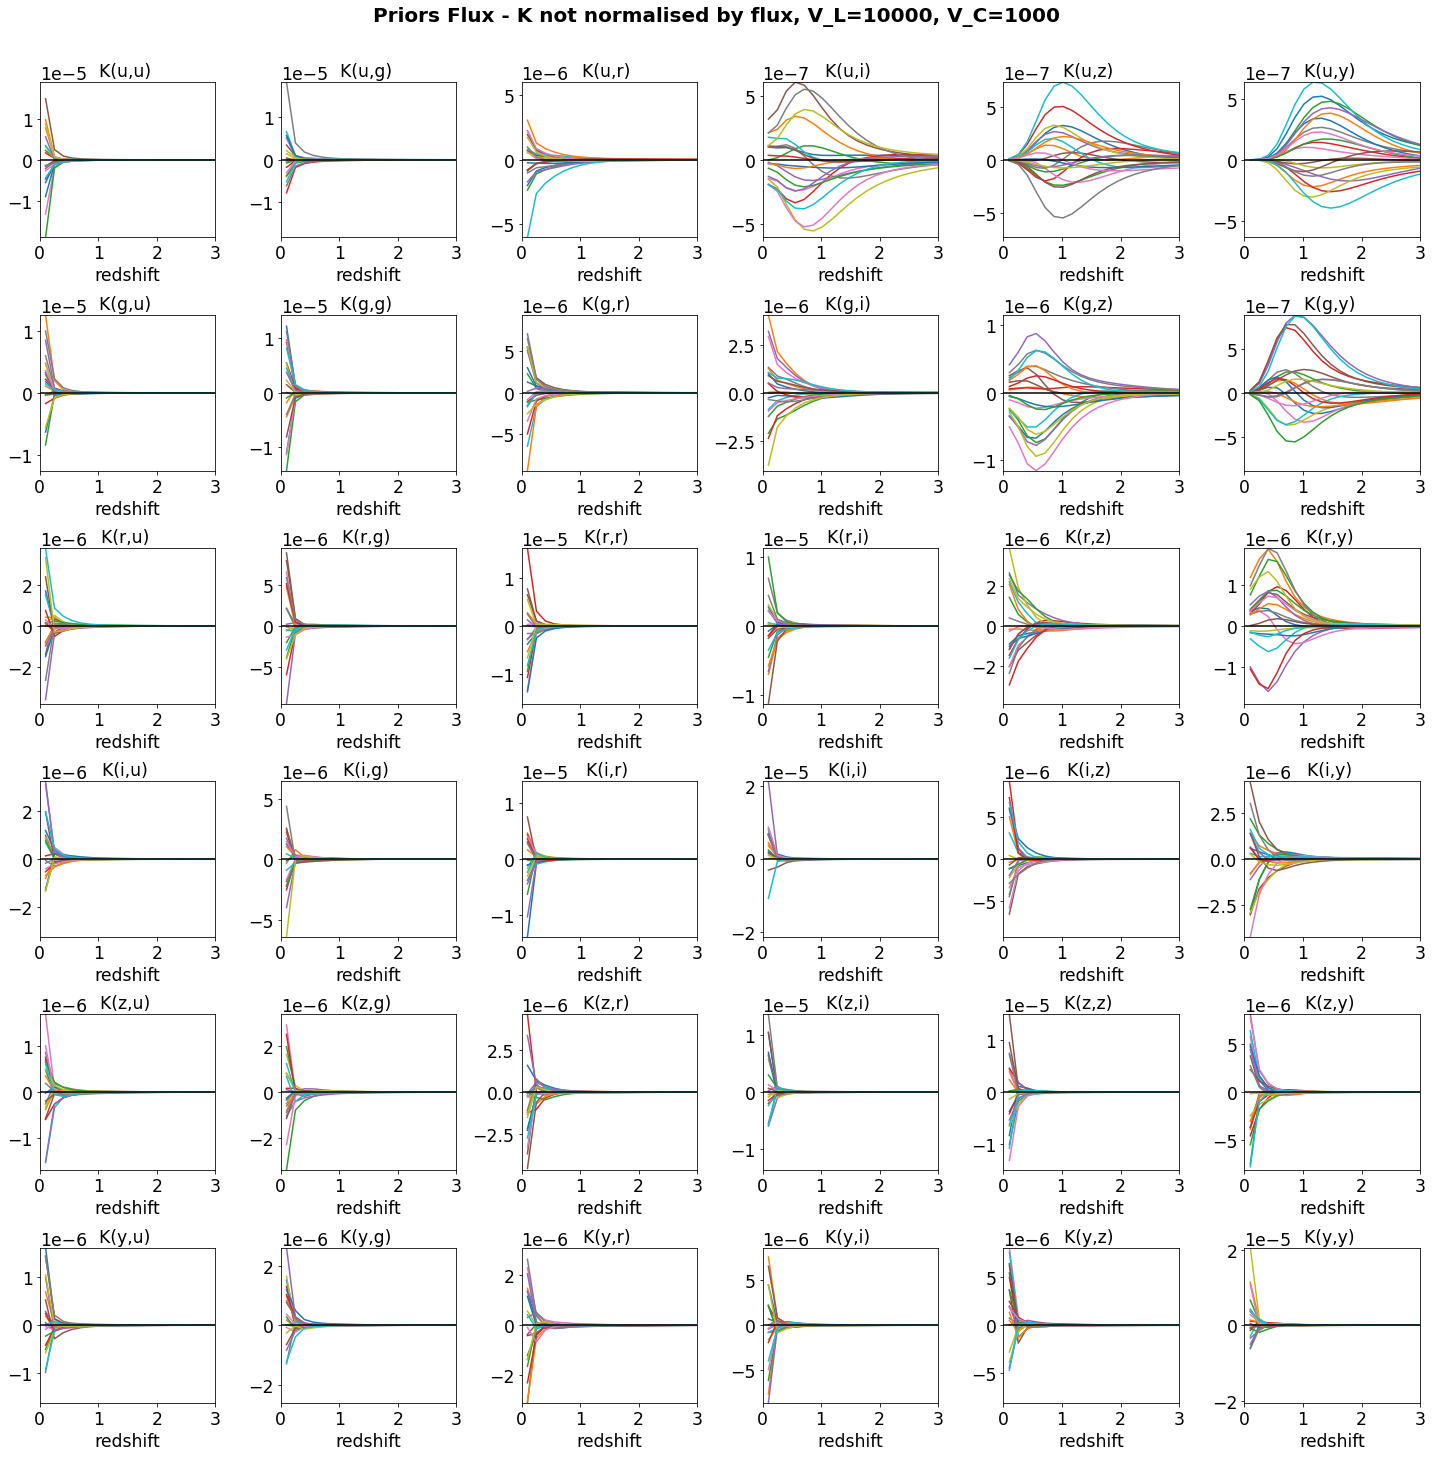

In [79]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix_nonorm(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:])
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K not normalised by flux, V_L={}, V_C={}".format(V_L,V_C)
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()  

/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
/tmp/ipykernel_3452/3125099073.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  F_gp  = np.rando

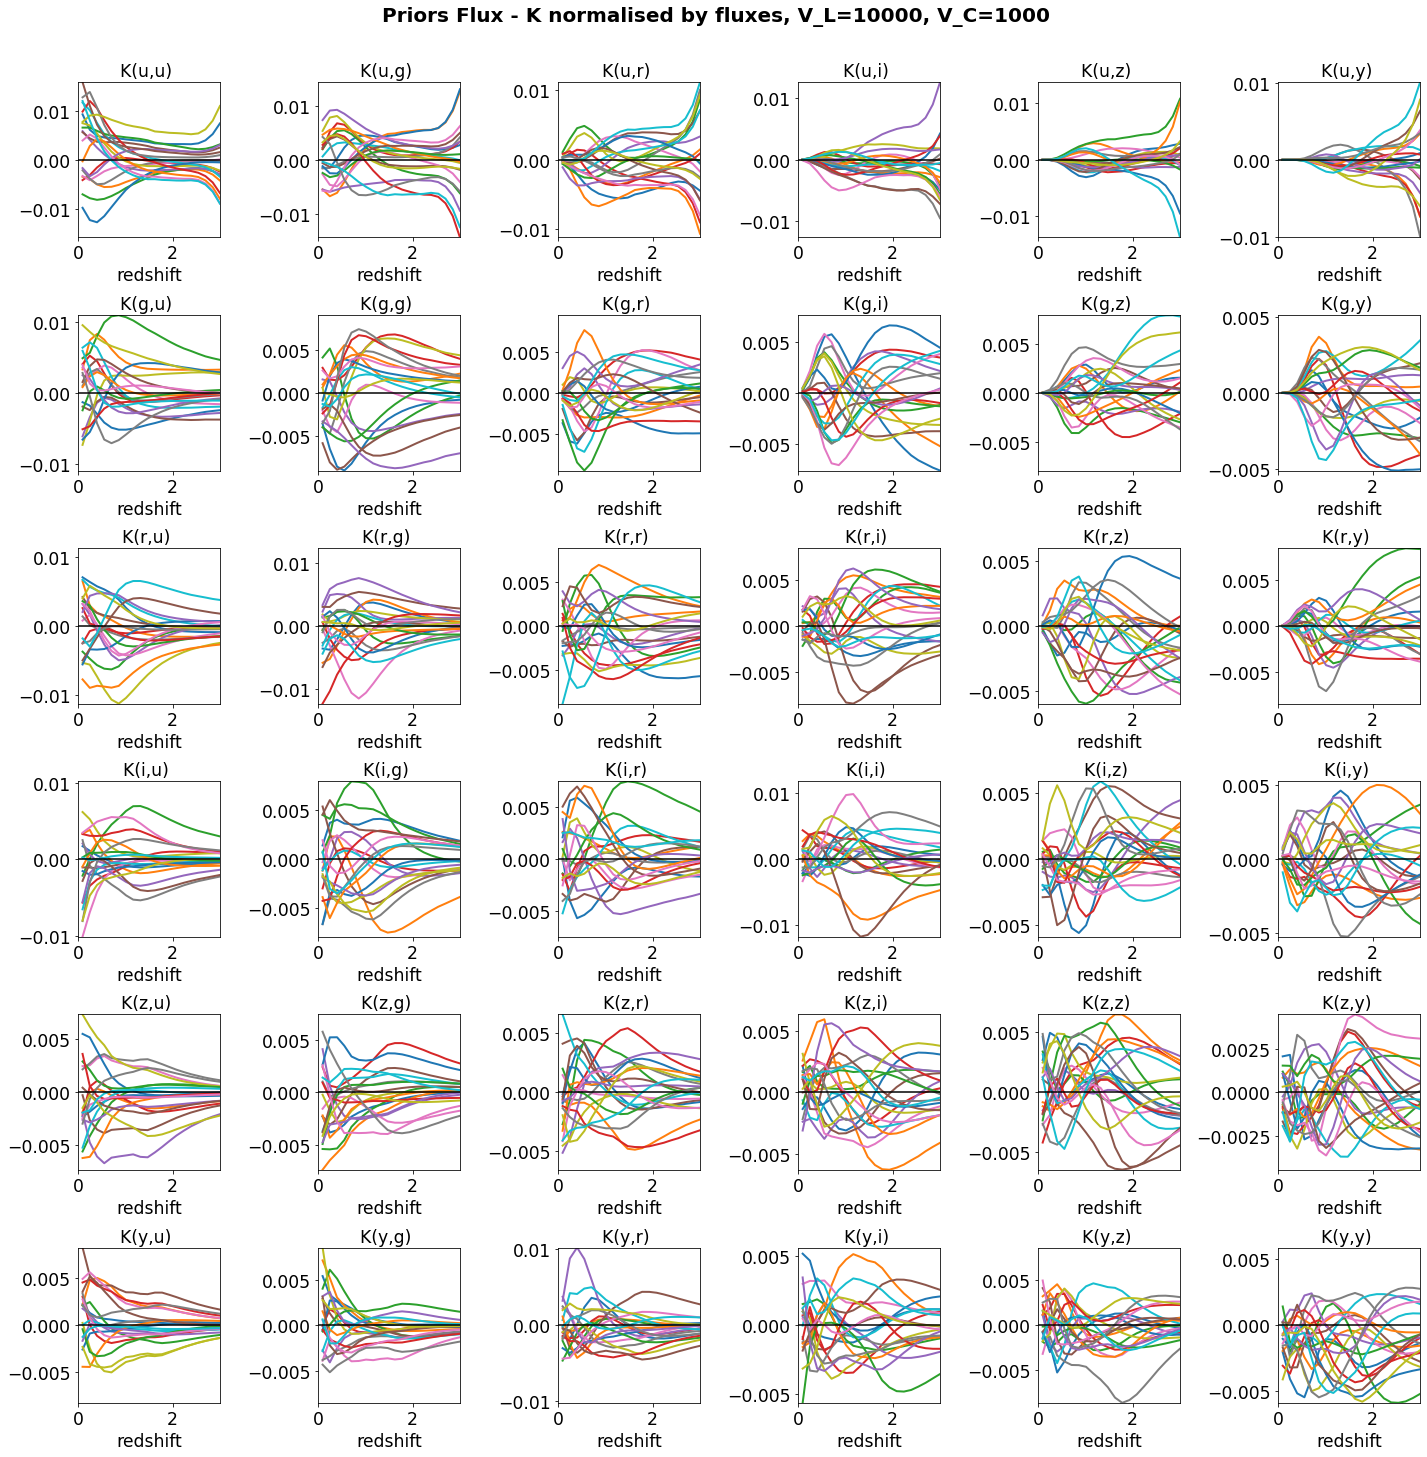

In [80]:
mu=np.zeros(NBINS)
fig, axs = plt.subplots(NR, NC,figsize=(20,20))

for ir in np.arange(NR):
    for ic in np.arange(NC):
        ib1=ic
        ib2=ir
        Cov=Make_Covariance_Matrix(gp,all_X,ib1,ib2)
        F_gp  = np.random.multivariate_normal(mu,Cov, NSIM)
        F_gp_max=np.abs(F_gp).max()
        for idx in np.arange(NSIM):
            axs[ir,ic].plot(all_z,F_gp[idx,:],lw=2)
        
        axs[ir,ic].set_xlim(0,3)
        axs[ir,ic].set_xlabel("redshift")
        axs[ir,ic].set_title("K({},{}) ".format(band_name[ib2],band_name[ib1]))
        axs[ir,ic].set_ylim(-F_gp_max,F_gp_max)
        axs[ir,ic].axhline(y=0,color="k")


title="Priors Flux - K normalised by fluxes, V_L={}, V_C={}".format(V_L,V_C)      
plt.suptitle(title,fontsize=20,fontweight="bold",y=1.01)
plt.tight_layout()    

# Covariance for different fluxes

In [81]:
K=Make_Covariance_matrix_filters(gp,1.,2.)

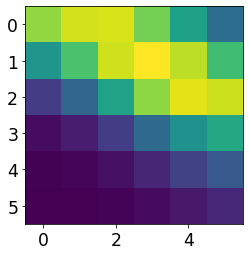

In [82]:
plt.imshow(K)